In [1]:
# Install ogb components
! pip install --upgrade ogb
! python -c "import ogb; print(ogb.__version__)"
# # Otherwise, please update the version by running


1.3.6


In [2]:
# Import libraries
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from ogb.linkproppred import PygLinkPropPredDataset, Evaluator
from torch_geometric.utils import negative_sampling


In [3]:
# Load dataset
dataset = PygLinkPropPredDataset(name="ogbl-collab")
split_edge = dataset.get_edge_split()
data = dataset[0]

print(data)     # Check the structure of the loaded data


Data(num_nodes=235868, edge_index=[2, 2358104], x=[235868, 128], edge_weight=[2358104, 1], edge_year=[2358104, 1])


/root/miniconda3/envs/cs276p/lib/python3.12/site-packages/ogb/linkproppred/dataset_pyg.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.lo

In [4]:
# Define GNN model
class GCNLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNLinkPredictor, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


In [5]:
# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNLinkPredictor(data.num_features, 64, 32).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Try a smaller learning rate


In [6]:
# Define edge scoring function and loss function
def link_prediction_loss(pos_edge_index, neg_edge_index, z):
    pos_score = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
    neg_score = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
    pos_loss = -torch.log(torch.sigmoid(pos_score)).mean()
    neg_loss = -torch.log(1 - torch.sigmoid(neg_score)).mean()
    return pos_loss + neg_loss


In [7]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    
    # Forward pass to obtain node embeddings
    z = model(data.x, data.edge_index)
    
    # Check for edge_neg and generate if missing
    if 'edge_neg' not in split_edge['train']:
        # Generate negative samples if edge_neg is missing
        neg_edge_index = negative_sampling(
            edge_index=data.edge_index,  # Use original edges to sample
            num_nodes=data.num_nodes,
            num_neg_samples=split_edge['train']['edge'].size(1)
        )
    else:
        # Use provided negative edges
        neg_edge_index = split_edge['train']['edge_neg']

    # Calculate loss with the (generated or provided) negative edges
    loss = link_prediction_loss(split_edge['train']['edge'], neg_edge_index, z)
    
    # Backpropagation and optimizer step
    loss.backward()
    optimizer.step()
    
    return loss.item()


In [8]:
# Evaluation function
@torch.no_grad()
def evaluate():
    model.eval()
    z = model(data.x, data.edge_index)
    pos_pred = (z[split_edge['valid']['edge'][0]] * z[split_edge['valid']['edge'][1]]).sum(dim=1)
    neg_pred = (z[split_edge['valid']['edge_neg'][0]] * z[split_edge['valid']['edge_neg'][1]]).sum(dim=1)
    evaluator = Evaluator(name="ogbl-collab")
    input_dict = {"y_pred_pos": pos_pred, "y_pred_neg": neg_pred}
    return evaluator.eval(input_dict)["hits@50"]


In [9]:
# Training loop
for epoch in range(1, 101):
    
    # Train and calculate loss
    loss = train()
    
    # Validation at intervals
    if epoch % 10 == 0:
        # Ensure model is in evaluation mode
        print(f'Epoch {epoch:02d}, Loss: {loss:.4f}')


Epoch 10, Loss: 1.0417
Epoch 20, Loss: 0.9897
Epoch 30, Loss: 0.8694
Epoch 40, Loss: 0.7704
Epoch 50, Loss: 0.9052
Epoch 60, Loss: 0.7582
Epoch 70, Loss: 0.6877
Epoch 80, Loss: 0.7206
Epoch 90, Loss: 0.7881
Epoch 100, Loss: 0.7029


In [10]:
from sklearn.metrics import roc_auc_score, average_precision_score

# Define the test evaluation function
@torch.no_grad()
def test():
    model.eval()
    z = model(data.x, data.edge_index)  # Obtain node embeddings
    
    # Compute positive and negative scores for test set
    pos_pred = (z[split_edge['test']['edge'][0]] * z[split_edge['test']['edge'][1]]).sum(dim=1)
    neg_pred = (z[split_edge['test']['edge_neg'][0]] * z[split_edge['test']['edge_neg'][1]]).sum(dim=1)
    
    # Concatenate predictions for AUC and AP calculations
    y_pred = torch.cat([pos_pred, neg_pred]).cpu()
    y_true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))]).cpu()
    
    # 1. Hits@K Evaluation using OGB Evaluator
    evaluator = Evaluator(name="ogbl-collab")
    input_dict = {"y_pred_pos": pos_pred, "y_pred_neg": neg_pred}
    hits_at_k = evaluator.eval(input_dict)["hits@50"]  # Adjust "hits@50" as needed for K
    
    # 2. AUC-ROC Score
    auc_roc = roc_auc_score(y_true, y_pred)
    
    # 3. Average Precision (AP) Score
    ap_score = average_precision_score(y_true, y_pred)
    
    # Print results
    print(f"Test Hits@50: {hits_at_k:.4f}")
    print(f"Test AUC-ROC: {auc_roc:.4f}")
    print(f"Test AP: {ap_score:.4f}")
    
# Run the test evaluation
test()


Test Hits@50: 1.0000
Test AUC-ROC: 1.0000
Test AP: 1.0000


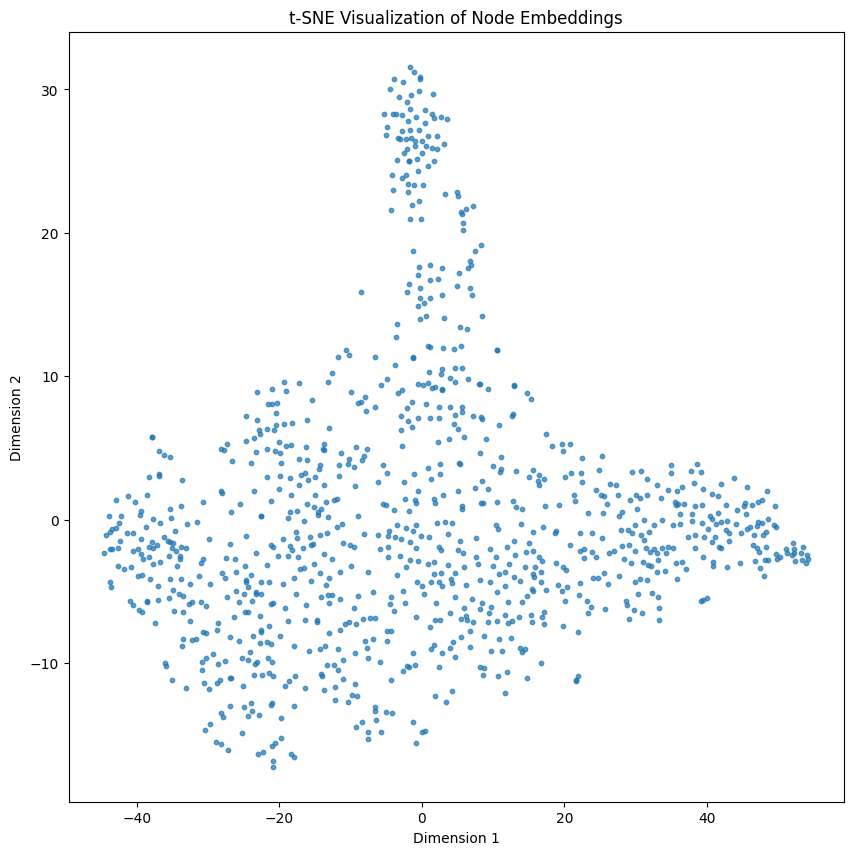

Top positive edges shape: (2, 46329)
Top negative edges shape: (2, 100000)


NetworkXError: Edge tuple (220958, 186854, 136989, 94923, 94923, 128568, 170185, 124856, 124856, 164460, 18013, 39704, 6307, 131725, 206208, 206208, 206208, 130245, 221202, 221202, 221202, 143416, 143416, 178477, 168911, 168911, 110791, 110791, 185518, 53734, 184432, 184432, 100794, 136, 136, 29045, 91325, 50417, 217341, 226934, 88884, 88884, 88884, 143568, 74464, 74464, 61088, 190940, 30532, 176767, 176767, 182741, 13534, 21499, 174710, 174710, 174710, 174710, 174710, 174710, 174710, 174710, 228205, 28851, 121723, 121723, 109655, 109655, 143635, 143635, 138682, 138682, 138682, 138682, 183562, 134668, 53444, 144128, 144128, 144128, 144128, 234186, 234186, 234186, 48921, 48921, 227295, 204550, 204550, 193742, 193742, 24764, 24764, 5003, 149106, 149106, 36918, 160794, 45227, 45227, 45227, 45227, 45227, 45227, 45227, 45227, 209119, 209119, 209119, 209119, 209119, 209119, 221795, 117445, 129437, 68219, 216178, 216178, 113339, 113339, 38878, 9100, 9100, 178756, 178756, 232629, 109163, 109163, 198978, 198978, 198978, 198978, 198978, 198978, 198978, 198978, 53224, 53224, 53224, 53224, 53224, 72692, 72692, 72692, 72692, 193807, 193807, 45083, 35947, 35947, 36451, 175424, 175424, 175424, 137259, 137259, 137259, 46740, 46740, 46740, 46740, 65769, 65769, 65769, 163557, 163557, 163557, 3228, 27590, 27590, 64662, 132819, 132819, 222891, 222891, 222891, 157402, 67425, 67425, 197053, 197053, 197053, 46734, 46734, 46734, 83097, 78244, 78244, 58134, 58134, 113212, 54751, 54751, 15881, 15881, 31456, 90741, 90741, 90741, 47969, 47969, 105933, 163413, 116428, 116428, 231774, 231774, 201149, 135756, 135756, 135756, 111341, 214068, 214068, 214068, 214068, 191993, 5250, 231803, 231803, 231803, 231803, 34941, 34941, 34941, 147803, 147803, 147803, 147803, 147803, 18811, 166778, 166778, 166778, 32296, 32296, 32296, 31691, 31691, 31691, 31691, 32985, 32985, 40403, 40403, 40403, 40403, 40403, 40403, 40403, 40403, 40403, 40403, 71241, 71241, 71241, 71241, 71241, 71241, 71241, 103457, 233744, 233744, 233744, 233744, 233744, 233744, 233744, 89840, 89840, 89840, 193237, 193237, 193237, 116344, 116344, 116344, 116344, 26348, 26348, 26348, 26348, 26348, 26348, 26348, 26348, 189808, 189808, 125608, 125608, 40340, 191276, 13032, 13032, 13032, 13032, 13032, 131255, 131255, 169491, 169491, 11838, 11838, 11838, 11838, 11838, 11838, 11838, 201535, 201535, 201535, 164203, 220004, 220004, 220004, 220004, 220004, 220004, 220004, 220004, 220004, 220004, 206485, 206485, 206485, 161470, 161470, 112050, 127165, 127165, 129597, 129597, 129597, 144850, 88289, 130361, 16252, 16252, 16252, 16252, 16252, 16252, 9222, 9222, 9222, 9222, 9222, 89918, 89918, 89918, 89918, 89918, 184648, 40570, 40570, 144706, 144706, 31838, 31838, 31838, 73986, 73986, 73986, 73986, 73986, 73986, 65508, 65508, 65508, 94387, 166199, 166199, 166199, 166199, 126761, 85996, 149780, 149780, 9079, 9079, 9079, 9079, 9079, 9079, 29225, 29225, 29225, 61068, 221265, 221265, 15490, 8704, 8704, 207215, 207215, 53783, 53783, 88830, 88830, 88830, 88830, 88830, 202446, 202446, 175071, 175071, 175071, 175071, 175071, 175071, 195453, 195453, 190830, 190830, 65187, 65187, 69450, 69450, 69450, 69450, 8561, 8561, 8561, 8561, 8561, 180191, 34226, 34226, 34226, 165960, 165960, 165960, 165960, 12353, 12353, 43623, 43623, 79899, 79899, 79899, 79899, 79899, 79899, 79899, 79899, 136531, 152998, 61093, 61093, 61093, 61093, 61093, 145269, 145269, 194713, 194713, 194713, 187078, 187078, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 122359, 204210, 204210, 204210, 204210, 205364, 205364, 205364, 205364, 205364, 205364, 205364, 205364, 205364, 205364, 37240, 41526, 41526, 146572, 146572, 146572, 146572, 146572, 19967, 19967, 76939, 223366, 184517, 184517, 184517, 184517, 184517, 184517, 101781, 148192, 148192, 148192, 34717, 222520, 222520, 174161, 174161, 174161, 42473, 42473, 42473, 113499, 113499, 113499, 113499, 209369, 41657, 41657, 105610, 105610, 105610, 164854, 164854, 164854, 170545, 44051, 44051, 44051, 44051, 44051, 129273, 143738, 143738, 143738, 143738, 200860, 200860, 144575, 144575, 144575, 144575, 68199, 68199, 181842, 195940, 195940, 195940, 195940, 195940, 195940, 195940, 195940, 171524, 171524, 209047, 209047, 209047, 130217, 227903, 227903, 227903, 227903, 227903, 227903, 227903, 227903, 227903, 227903, 227903, 227903, 227903, 127690, 222067, 222067, 222067, 222067, 222067, 222067, 222067, 222067, 222067, 222067, 222067, 222067, 38789, 194968, 194968, 19421, 193854, 193854, 193854, 193854, 193854, 156866, 90684, 233738, 233738, 102967, 102967, 102967, 102967, 102967, 184092, 184092, 184092, 184092, 184092, 184092, 184092, 59585, 59585, 59585, 184935, 184935, 184935, 2035, 2035, 188650, 188650, 188650, 188650, 188650, 97064, 124028, 130352, 130352, 130352, 130352, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 104093, 200276, 200276, 98659, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 137555, 66486, 66486, 66486, 66486, 66486, 180793, 180793, 180793, 127130, 127130, 53703, 53703, 232518, 123735, 123735, 123735, 123735, 123735, 123735, 123735, 123735, 123735, 220669, 220669, 220669, 233743, 233743, 233743, 233743, 233743, 233743, 233743, 233743, 233743, 233743, 233743, 233743, 233743, 159373, 159373, 159373, 159373, 159373, 159373, 159373, 159373, 159373, 159373, 159373, 159373, 159373, 222996, 222996, 222996, 222996, 222996, 222996, 222996, 222996, 37236, 37236, 90135, 90135, 90135, 90135, 220468, 220468, 220468, 220468, 220468, 220468, 220468, 220468, 106190, 22050, 172976, 68891, 195881, 230470, 230470, 80023, 21590, 229243, 136388, 136388, 112750, 119901, 168872, 87920, 192095, 192095, 179948, 116372, 4585, 25098, 66713, 227099, 204238, 202489, 202489, 52146, 52146, 172356, 65, 53670, 73271, 87887, 87887, 49310, 228369, 40856, 40856, 207893, 227905, 114486, 114486, 114486, 114486, 92428, 92428, 138294, 138294, 85104, 85104, 12458, 12458, 5658, 16182, 232668, 232668, 105042, 11794, 79925, 79925, 79925, 6884, 191151, 16540, 16540, 232233, 232233, 232233, 209401, 194179, 22771, 22771, 22771, 22771, 77627, 201632, 16290, 117933, 49968, 49968, 6792, 111074, 171308, 171308, 39587, 56884, 56884, 8709, 8709, 8709, 8709, 74856, 997, 219082, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 164833, 200297, 200297, 114311, 114311, 114311, 114311, 114311, 114311, 71750, 71750, 71750, 71750, 75775, 75775, 75775, 75775, 75775, 75775, 14448, 175875, 175875, 175875, 179171, 5248, 5248, 5248, 5248, 5248, 105146, 105146, 105146, 206123, 214044, 13367, 13367, 104526, 104526, 104526, 104526, 104526, 104526, 104526, 115479, 82392, 34223, 34223, 34223, 34223, 34223, 34223, 34223, 34223, 34223, 34223, 127038, 127038, 127038, 127038, 20393, 94948, 20642, 20642, 20642, 20642, 20642, 23347, 23347, 23347, 23347, 23347, 23347, 23347, 40974, 120561, 120561, 158920, 158920, 158920, 66149, 161493, 161493, 13132, 13132, 13132, 182138, 182138, 182138, 96650, 96650, 96650, 180005, 91449, 110771, 110771, 47595, 211284, 211284, 211284, 211284, 211284, 211284, 7764, 7764, 35512, 134556, 219172, 178098, 178098, 183417, 183417, 183417, 183417, 183417, 183417, 183417, 137285, 137285, 137285, 215639, 215639, 30205, 30205, 30205, 30205, 73400, 73400, 73400, 73400, 73400, 73400, 73400, 73400, 73400, 123882, 123882, 123882, 123882, 55719, 55719, 3638, 3638, 3638, 3638, 3638, 97128, 97128, 97128, 124458, 124458, 223999, 223999, 118311, 118311, 118311, 118311, 151750, 151750, 151750, 151750, 151750, 151750, 151750, 151750, 50022, 225423, 97077, 97077, 185757, 185757, 185757, 189103, 60170, 60170, 60170, 104073, 101851, 101851, 183253, 183253, 183253, 183253, 183253, 183253, 149620, 90915, 199799, 199799, 49978, 49978, 49978, 201214, 201214, 192084, 192084, 199029, 199029, 10784, 10784, 10784, 10784, 1275, 85358, 74450, 74450, 74450, 74450, 198648, 157441, 157441, 157441, 157441, 157441, 157441, 195979, 195979, 8635, 28846, 28846, 58372, 58372, 127641, 127641, 51195, 131821, 131821, 131821, 131821, 178042, 178042, 216818, 34301, 34301, 34301, 34301, 194693, 194693, 134475, 134475, 134475, 134475, 134475, 134475, 134475, 134475, 149419, 98395, 98395, 98395, 98395, 98395, 98395, 98395, 98395, 98395, 98395, 98395, 98395, 98395, 156300, 123141, 123141, 123141, 147526, 147526, 147526, 147526, 86866, 86866, 233281, 7645, 7645, 77820, 199750, 199750, 199750, 199750, 199750, 199750, 199750, 137626, 137626, 180913, 76962, 76962, 12015, 79432, 182404, 1137, 4328, 4328, 74074, 74074, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 180588, 220715, 220715, 124934, 124934, 188010, 188010, 188010, 75003, 20286, 20286, 20286, 20286, 20286, 20286, 20286, 92595, 92595, 122869, 122869, 45993, 13832, 13832, 13832, 12869, 12869, 37359, 88370, 88370, 88370, 88370, 88370, 88370, 88370, 161732, 161732, 161732, 161732, 188107, 188107, 188107, 188107, 188107, 142789, 142789, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 141752, 212570, 212570, 212570, 5917, 5917, 194030, 194030, 874, 72601, 72601, 72601, 72601, 72601, 72601, 128553, 128553, 128553, 128553, 128553, 128553, 58664, 58664, 58664, 58664, 157540, 157540, 157540, 157540, 116125, 116125, 116125, 116125, 116125, 116125, 227798, 45843, 90932, 115847, 115847, 115847, 88826, 88826, 216861, 216861, 216861, 9125, 9125, 9125, 69121, 194347, 194347, 194347, 194347, 90654, 90654, 3126, 3126, 3126, 102048, 102048, 102048, 117590, 117590, 137581, 137581, 169677, 169677, 169677, 46328, 46328, 83793, 83793, 32412, 32412, 9156, 9156, 9156, 92807, 92807, 92807, 103733, 126247, 126247, 126247, 5817, 5817, 9768, 94372, 94372, 94372, 94372, 94372, 94372, 94372, 94372, 94372, 94372, 94372, 121392, 121392, 121392, 121392, 212241, 45121, 45121, 45121, 146516, 146516, 146516, 171627, 184664, 184664, 158632, 158632, 117830, 117830, 117830, 124798, 124798, 124798, 203431, 148272, 148272, 148272, 112215, 112215, 157939, 157939, 188844, 64690, 64690, 64690, 64690, 64690, 142558, 142558, 142558, 142558, 142558, 31712, 112564, 112564, 228266, 228266, 93862, 93862, 93862, 93862, 93862, 163743, 163743, 217148, 217148, 115220, 115220, 115220, 115220, 115220, 115220, 168293, 216901, 216901, 216901, 216901, 216901, 216901, 216901, 216901, 216901, 216901, 216901, 216901, 25188, 204401, 122270, 222309, 222309, 222309, 180758, 41582, 41582, 41582, 41582, 41582, 41582, 41582, 41582, 135827, 135827, 135827, 87066, 87066, 227451, 227451, 227451, 173823, 104243, 104243, 104243, 104243, 217765, 217765, 93444, 116068, 76669, 76669, 76669, 76669, 76669, 76669, 223347, 152538, 149876, 149876, 149876, 149876, 149876, 149876, 32099, 32099, 32099, 32099, 163031, 163031, 221331, 221331, 222511, 222511, 222511, 134055, 134055, 134055, 134055, 134055, 134055, 114523, 188310, 142332, 204474, 204474, 204474, 163919, 163919, 58004, 196206, 25951, 25951, 25951, 25951, 227332, 42878, 66682, 211969, 223330, 3339, 7112, 129516, 159407, 858, 858, 858, 858, 232916, 180066, 180066, 70733, 86374, 86374, 86374, 86374, 37702, 165430, 90718, 172301, 172301, 15252, 195918, 36416, 72648, 105029, 37037, 198932, 117717, 117717, 13664, 13664, 87056, 83421, 83421, 83421, 83421, 154597, 192377, 192938, 189638, 63872, 63872, 120878, 120878, 179385, 179385, 50822, 50822, 139602, 139602, 234734, 234734, 186692, 186692, 186692, 200261, 200261, 200261, 200261, 186924, 76546, 76864, 76864, 194599, 20048, 20048, 20048, 118543, 169439, 169439, 169439, 169439, 88435, 113724, 113724, 113724, 113724, 113980, 113980, 129150, 9142, 9142, 12931, 12931, 12931, 12931, 73431, 8166, 8166, 8166, 103059, 103059, 141909, 141909, 141909, 141909, 141909, 141909, 141909, 46302, 46302, 186009, 50738, 50738, 99871, 99871, 99871, 99871, 62077, 62077, 121178, 121178, 121178, 121178, 2014, 2014, 2014, 4951, 106986, 154268, 154268, 154268, 154268, 199821, 199821, 199821, 199821, 85603, 85603, 175151, 175151, 24037, 24037, 24037, 24037, 24037, 24037, 82746, 82746, 69747, 69747, 69747, 178921, 178921, 142586, 142586, 212013, 212013, 212013, 156988, 110796, 110796, 110796, 110796, 110796, 147032, 51587, 91481, 117663, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 233214, 148816, 129620, 129620, 110193, 110193, 213843, 213843, 213843, 213843, 213843, 74878, 74878, 74878, 165597, 47896, 47896, 178760, 178760, 178760, 109231, 109231, 109231, 70255, 70255, 70255, 88218, 88218, 88218, 118858, 163234, 163234, 14626, 68682, 68682, 68682, 68682, 68682, 112883, 112883, 112883, 66716, 157359, 157359, 157359, 157359, 115756, 115756, 115756, 115756, 115756, 115756, 115756, 115756, 115756, 115756, 97093, 97093, 97093, 171668, 171668, 171668, 171668, 171668, 171668, 151748, 151748, 151748, 151748, 118778, 209128, 209128, 180479, 129170, 129170, 129170, 186094, 63528, 63528, 15278, 15278, 225332, 225332, 225332, 225332, 225332, 39670, 39670, 67191, 96652, 96652, 96652, 85054, 85054, 123835, 123835, 83052, 83052, 83052, 83052, 83052, 83052, 175538, 187903, 200267, 200267, 200267, 207849, 202572, 97859, 97859, 155529, 222131, 222131, 46050, 46050, 127873, 127873, 127873, 127873, 127873, 127873, 160871, 83912, 83912, 196855, 196855, 4625, 4625, 167063, 167063, 198251, 75859, 216581, 216581, 216581, 216581, 145836, 145836, 145836, 145836, 75871, 224814, 224814, 224814, 228322, 228322, 173861, 20223, 20223, 20223, 20223, 137820, 137820, 211915, 211915, 211915, 211915, 211915, 140460, 140460, 140460, 30871, 30871, 30871, 30871, 174711, 174711, 174711, 43273, 43273, 43273, 170971, 170971, 170971, 170971, 170971, 191321, 191321, 72466, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 3157, 122743, 122743, 122743, 122743, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 200907, 18210, 18210, 18210, 18210, 18210, 27168, 28967, 74864, 74864, 74864, 74864, 84576, 76512, 76512, 145689, 145689, 145689, 145689, 145689, 145689, 145689, 145689, 141054, 141054, 141054, 141054, 169153, 169153, 169153, 169153, 169153, 70888, 70888, 70888, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 192697, 66121, 66121, 66121, 66121, 66121, 66121, 132873, 132873, 52861, 52861, 185606, 185606, 185606, 8467, 8467, 8467, 8467, 15758, 15758, 15758, 15758, 204497, 204497, 204497, 204497, 204497, 143579, 150064, 150064, 150064, 225369, 49428, 49428, 167469, 167469, 167469, 167469, 167469, 167469, 8399, 8399, 8399, 167363, 222630, 222630, 11009, 11009, 69097, 157569, 157569, 157569, 157569, 157569, 157569, 158166, 186661, 164879, 32951, 32951, 32951, 32951, 222492, 222492, 225203, 225203, 201341, 201341, 201341, 201341, 201341, 161300, 161300, 88803, 88803, 88803, 88803, 197794, 197794, 222735, 222735, 49252, 49252, 49252, 37352, 37352, 117915, 117915, 117915, 116654, 116654, 116654, 116654, 116654, 5415, 5415, 5415, 5415, 5415, 5415, 5415, 18974, 18974, 18974, 18974, 18974, 64104, 79058, 79058, 79058, 79058, 79058, 73725, 196691, 196691, 123315, 33470, 33470, 33470, 33470, 33470, 33470, 33470, 33470, 69678, 69678, 69678, 69678, 101343, 101343, 67775, 67775, 67775, 67775, 67775, 84614, 84614, 84614, 183164, 183164, 183164, 100546, 100546, 100546, 100546, 100546, 100546, 21370, 126874, 149535, 63902, 63902, 63902, 63902, 63902, 54627, 54627, 54627, 54627, 54627, 31834, 33070, 33070, 33070, 33070, 33070, 33070, 33070, 33070, 152389, 93283, 93283, 60886, 107508, 107508, 141893, 45110, 150573, 173576, 144940, 54792, 192449, 192449, 191805, 218839, 156889, 57018, 38530, 38530, 38530, 38530, 65603, 56885, 82897, 79536, 235597, 37290, 227015, 70152, 10602, 195384, 61928, 61928, 61928, 61928, 61928, 2498, 15129, 207159, 160120, 69957, 69957, 95264, 57516, 57516, 109906, 20213, 125208, 125208, 163691, 197268, 197268, 197268, 17062, 17062, 17062, 17062, 17062, 17062, 17062, 17062, 17062, 17062, 17062, 234009, 186704, 186704, 186704, 186704, 225835, 225835, 81947, 101813, 101813, 101813, 142943, 142943, 142943, 194208, 91811, 91811, 225179, 38471, 38471, 69831, 72207, 17800, 220678, 65410, 8121, 8121, 8121, 8121, 146771, 215435, 163022, 38207, 198282, 176143, 96640, 96640, 203304, 187083, 92155, 120107, 120107, 120107, 120107, 120107, 111184, 111184, 111184, 111184, 86612, 89924, 89924, 89924, 23413, 23413, 23413, 172965, 172965, 59816, 59816, 59816, 88333, 196405, 235816, 235816, 235816, 235816, 235816, 135485, 6943, 50179, 87306, 87306, 87306, 87306, 163356, 98180, 38793, 38793, 197450, 197450, 197450, 197450, 197450, 197450, 197450, 197450, 213397, 213397, 214397, 189418, 229217, 229217, 60915, 145867, 145867, 60282, 60282, 60282, 60282, 60282, 60282, 60282, 60282, 60282, 60282, 60282, 217177, 217177, 217177, 199056, 199056, 24458, 29236, 29236, 29236, 29236, 29236, 29236, 29236, 29236, 72492, 72492, 72492, 72492, 72492, 72492, 72492, 72492, 180761, 180761, 180761, 53399, 53399, 53399, 53399, 53399, 53399, 53399, 53399, 53399, 53399, 53399, 53399, 148594, 96421, 96421, 96421, 96421, 96421, 96421, 112414, 112414, 112414, 112414, 112414, 178060, 178060, 178060, 178060, 178060, 178060, 178060, 178060, 178060, 178060, 178060, 39173, 39173, 39173, 39173, 39173, 39173, 39173, 70681, 70681, 188244, 188244, 188244, 188244, 92327, 170372, 170372, 170372, 170372, 49300, 49300, 49300, 49300, 49300, 124984, 124984, 124984, 124984, 65163, 65163, 65163, 65163, 180577, 180577, 163750, 203889, 80384, 80384, 80384, 80384, 80384, 1581, 172737, 172737, 172737, 172737, 172737, 172737, 172737, 172864, 172864, 172864, 91237, 2193, 143111, 143111, 143111, 143111, 54120, 54120, 54120, 83198, 83198, 33601, 33601, 33601, 107578, 107578, 107578, 162507, 165758, 229650, 16363, 16363, 134493, 134493, 143467, 143467, 40395, 40395, 40395, 200283, 105439, 105439, 9066, 161586, 161586, 187899, 14036, 125216, 125216, 139145, 139145, 63067, 63067, 63067, 63067, 171115, 171115, 171115, 171115, 181933, 181933, 181933, 181933, 128776, 69213, 69213, 118371, 118371, 226868, 226868, 226868, 226868, 226868, 226868, 63132, 207825, 207825, 207825, 207825, 207825, 119291, 119291, 142327, 142327, 142327, 142327, 142327, 142327, 142327, 142327, 142327, 142327, 84261, 84261, 84261, 133965, 139025, 139025, 139025, 229259, 229259, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 72312, 3789, 209604, 209604, 209604, 209604, 91489, 202757, 202757, 154401, 154401, 154401, 154401, 172899, 172899, 172899, 172899, 172899, 172899, 172899, 165571, 175277, 175277, 175277, 175277, 175277, 175277, 175589, 175589, 30771, 30771, 30771, 30771, 30771, 116646, 116646, 116646, 116646, 116646, 116646, 116646, 116646, 116646, 212416, 212416, 212416, 212416, 212416, 205204, 205204, 14589, 14589, 14589, 14589, 223746, 61392, 61392, 61392, 61392, 61392, 165640, 165640, 165640, 165640, 165640, 165640, 173473, 173473, 212382, 128279, 128279, 128279, 128279, 128279, 128279, 128279, 229136, 229136, 31879, 31879, 31879, 153599, 153599, 153599, 68506, 68506, 68506, 68506, 68506, 68506, 68506, 68506, 68506, 74771, 109250, 109250, 109250, 86514, 86514, 186418, 186418, 151222, 151222, 35750, 35750, 194260, 99452, 99452, 99452, 61440, 8773, 8773, 181116, 181116, 181116, 109687, 109687, 109687, 197364, 197364, 132925, 132925, 132925, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 87522, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 202532, 39313, 39313, 39313, 92293, 92293, 92293, 92293, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 152427, 22363, 22363, 22363, 127503, 230314, 178069, 178069, 178069, 178069, 178069, 178069, 178069, 178069, 178069, 174015, 174015, 174015, 174015, 148901, 148901, 225210, 225210, 225210, 225210, 225210, 20809, 20809, 20809, 29538, 29538, 29538, 80222, 80222, 80222, 59985, 59985, 59985, 59985, 59985, 59985, 231992, 231992, 231992, 177388, 177388, 177388, 163862, 163862, 163862, 116087, 116087, 116087, 116087, 116087, 116087, 116087, 116087, 116087, 116087, 116087, 116087, 188050, 188050, 188050, 188050, 124664, 162908, 162908, 162908, 147862, 147862, 147862, 147862, 147862, 147862, 54376, 54376, 54376, 54376, 54376, 75089, 75089, 39002, 39002, 39002, 225858, 225858, 207264, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 134722, 149321, 149321, 113868, 113868, 8776, 137317, 137317, 137317, 70947, 70947, 70947, 70947, 136988, 136988, 22008, 87903, 87903, 87903, 211587, 211587, 211587, 211587, 211587, 211587, 105501, 17692, 78426, 111019, 111019, 111019, 126836, 147655, 147655, 147655, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 22434, 182534, 182534, 182534, 182534, 224356, 224356, 224356, 183125, 113827, 198264, 146381, 76026, 1692, 185771, 139966, 40699, 85947, 226459, 51301, 232321, 177888, 224730, 104307, 156093, 118619, 58055, 58055, 58055, 119611, 222198, 7032, 124622, 156666, 156666, 207209, 207209, 207209, 168190, 168190, 168190, 85144, 235257, 235257, 235257, 235257, 235257, 34052, 159027, 159027, 159027, 159027, 159027, 207097, 190847, 190847, 190847, 190847, 8249, 36783, 36783, 57635, 57635, 57635, 187921, 187921, 176831, 176831, 176831, 176831, 176831, 176831, 233424, 233424, 44855, 44855, 44855, 199427, 199427, 30988, 30988, 30988, 233766, 71680, 71680, 71680, 71680, 45158, 54229, 54229, 54229, 54229, 50380, 50380, 85948, 124974, 124974, 191570, 104558, 64848, 64848, 95132, 64726, 156414, 212922, 212922, 172472, 172472, 172472, 140641, 140641, 140641, 195765, 230810, 230810, 99226, 99226, 53382, 142562, 142562, 142562, 191987, 191987, 68844, 68844, 218176, 155452, 155452, 73830, 73830, 73830, 234552, 20293, 20293, 31717, 31717, 31717, 31717, 31717, 213138, 213138, 213138, 150774, 112945, 112945, 112945, 112945, 103559, 103559, 103559, 103559, 103559, 103559, 103559, 103559, 103559, 39563, 176217, 147595, 126904, 192314, 192314, 196299, 196299, 196299, 87458, 87458, 178046, 202868, 29179, 75534, 182218, 91973, 91973, 91973, 91973, 179988, 179988, 198339, 198339, 198339, 198339, 198339, 198339, 198339, 198339, 198339, 198339, 198339, 79522, 216638, 59722, 59722, 59722, 59722, 176716, 176716, 203703, 76437, 229016, 229016, 229016, 55430, 55430, 55430, 103596, 103596, 103596, 103596, 103596, 103596, 103596, 103596, 103596, 185434, 185434, 185434, 185434, 185434, 185434, 185434, 185434, 185434, 106532, 106532, 106532, 106532, 106532, 106532, 171476, 160852, 160852, 160852, 181979, 9461, 33252, 33252, 160286, 160286, 160286, 160286, 137344, 150731, 150731, 150731, 118167, 118167, 118167, 947, 947, 179773, 82728, 82728, 108536, 108536, 132310, 101613, 101613, 143279, 152858, 152858, 152858, 3813, 3813, 3813, 87790, 64619, 64619, 148133, 148133, 115739, 115739, 115739, 162679, 198972, 198972, 198972, 198972, 198972, 212534, 212534, 212534, 234695, 234695, 234695, 234695, 234695, 4761, 4761, 194777, 48647, 48647, 48647, 48647, 143393, 161420, 161420, 161420, 97006, 66419, 66419, 66419, 66419, 121214, 137295, 137295, 137295, 137295, 137295, 137295, 137295, 213422, 213422, 3187, 3187, 3187, 117715, 117715, 231944, 231944, 155131, 155131, 204370, 109873, 109873, 30845, 30845, 30845, 30845, 30845, 30845, 139158, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 104818, 184699, 184699, 184699, 184699, 184699, 184699, 184699, 184699, 184699, 184699, 228824, 154844, 154844, 10126, 1811, 1811, 1811, 193196, 193196, 11394, 11394, 11394, 169195, 169195, 169195, 169195, 169195, 169195, 169195, 169195, 169195, 169195, 169195, 84620, 84620, 226191, 226191, 226191, 226191, 50569, 112942, 112942, 69089, 69089, 69089, 115751, 115751, 165490, 165490, 165490, 162263, 33962, 33962, 33962, 34187, 34187, 183537, 183537, 183537, 22440, 23297, 23297, 162463, 162463, 162463, 162463, 162463, 8439, 8439, 8439, 228042, 228042, 228042, 202138, 202138, 202138, 202138, 202138, 173878, 173878, 173878, 173878, 173878, 74069, 74069, 150198, 149713, 149713, 149713, 149713, 149713, 149713, 162137, 162137, 162137, 162137, 162137, 162137, 162137, 76695, 76695, 76695, 76695, 73534, 73534, 73534, 73534, 73534, 73534, 73534, 73534, 143659, 143659, 8969, 8969, 8969, 8969, 19009, 19009, 77660, 77660, 45124, 45124, 229605, 229605, 229605, 229605, 52056, 52056, 52056, 52056, 52056, 52056, 52056, 52056, 52056, 52056, 84492, 84492, 69589, 69589, 220139, 220139, 220139, 220139, 220139, 220139, 220139, 171621, 171621, 104106, 221171, 221171, 221171, 221171, 161822, 161822, 161822, 195223, 195223, 15561, 15561, 15561, 151894, 174102, 174102, 174102, 174102, 174102, 174102, 174102, 174102, 174102, 174102, 174102, 216404, 216404, 216404, 216404, 216404, 232937, 232937, 232937, 232937, 232937, 232937, 188209, 188209, 188209, 188209, 188209, 188209, 188209, 188209, 188209, 188209, 188209, 188209, 170405, 170405, 105540, 105540, 107323, 107323, 26081, 26081, 26081, 26081, 26081, 232621, 232621, 232621, 189937, 189937, 189937, 135586, 64324, 64324, 119888, 119888, 119888, 119888, 119888, 171147, 171147, 171147, 171147, 171147, 217652, 217652, 217652, 113502, 48202, 48202, 212889, 212889, 212889, 212889, 212889, 212889, 212889, 212889, 212889, 212889, 212889, 212889, 212889, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 1123, 177927, 177927, 177927, 177927, 177927, 177927, 177927, 177927, 9651, 9651, 9651, 37581, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 193113, 161378, 161378, 161378, 161378, 161378, 161378, 209769, 209769, 209769, 209769, 126251, 126251, 126251, 178942, 178942, 178942, 178942, 178942, 178942, 75722, 75722, 75722, 132383, 132383, 183335, 183335, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 128171, 185007, 185007, 185007, 185007, 154700, 154700, 83341, 83341, 83341, 83341, 195493, 195493, 64817, 64817, 64817, 196604, 196604, 196604, 196604, 196604, 196604, 161390, 161390, 100096, 100096, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 86072, 73345, 198540, 198540, 163328, 163328, 163328, 163328, 32823, 32823, 32823, 32823, 198804, 198804, 51766, 51766, 220766, 220766, 220766, 220766, 220766, 220766, 220766, 220766, 149036, 149036, 149036, 149036, 149036, 47585, 47585, 74960, 74960, 74960, 74960, 74960, 74960, 74960, 74960, 74960, 164213, 156199, 156199, 156199, 211671, 211671, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 62321, 169496, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 225661, 82083, 116620, 23748, 23748, 23748, 23748, 23748, 176297, 176297, 176297, 176297, 176297, 176297, 176297, 176297, 176297, 118729, 60772, 55220, 51262, 114524, 61349, 61349, 212308, 166244, 163791, 12694, 193600, 45653, 45653, 58742, 58742, 58742, 58742, 58742, 163107, 218441, 218441, 212719, 225798, 225798, 87991, 208300, 192893, 192893, 60599, 60599, 107889, 233343, 233343, 71490, 71490, 142428, 179331, 179331, 179331, 179331, 179331, 85855, 85855, 85855, 156271, 156271, 202126, 202126, 24991, 24991, 24991, 24991, 24991, 24991, 24991, 34993, 128325, 128325, 128325, 128325, 128325, 128325, 128325, 109603, 80647, 80647, 218691, 218691, 218691, 218691, 200714, 151906, 11456, 151201, 110695, 133710, 133710, 103042, 93807, 93807, 136896, 136896, 179115, 179115, 179115, 179115, 16431, 227028, 227028, 74764, 147381, 147605, 147605, 147605, 147605, 147605, 147605, 147605, 147605, 206532, 206532, 35523, 102592, 212049, 212049, 107487, 107487, 107487, 162313, 162313, 162313, 162313, 162313, 163874, 163874, 163874, 16703, 27117, 27117, 180834, 34773, 133879, 209803, 209803, 187995, 187995, 187995, 91794, 91794, 91794, 91794, 143203, 143203, 8344, 8344, 8344, 2994, 69281, 69281, 69281, 2751, 2751, 2751, 34657, 34657, 156621, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 51463, 87692, 87692, 87692, 191286, 191286, 29517, 125204, 235232, 63087, 63087, 120453, 28641, 28641, 28641, 126671, 126671, 126671, 146380, 103938, 83303, 83303, 83303, 83303, 83303, 83303, 161453, 140739, 140739, 140739, 140739, 157633, 59906, 14741, 14741, 14741, 14741, 14741, 14741, 14741, 14741, 14741, 36482, 87846, 87846, 127796, 127796, 35585, 35585, 35585, 44766, 44766, 44766, 44766, 44766, 44766, 44766, 44766, 112083, 112083, 112083, 112083, 187391, 187391, 229028, 229028, 229028, 229028, 208867, 208867, 208867, 77025, 77025, 174183, 30413, 99210, 99210, 50642, 50642, 50642, 50642, 50642, 218347, 218347, 218347, 218347, 218347, 218347, 218347, 218347, 62502, 108752, 58264, 58264, 58264, 58264, 150390, 150390, 150390, 150390, 150390, 110195, 52545, 159871, 153181, 153181, 153181, 153181, 153181, 153181, 153181, 212029, 26531, 221750, 221750, 221750, 221750, 28201, 28201, 28201, 100379, 100379, 100379, 100379, 100379, 219632, 223771, 223771, 137203, 137203, 137203, 137203, 137203, 137203, 191877, 191877, 191877, 191877, 191877, 191877, 191877, 191877, 191877, 166452, 166452, 166452, 166452, 59358, 59358, 59358, 59358, 157978, 157978, 111424, 102531, 102531, 102531, 102531, 102531, 102531, 181370, 181370, 73182, 174291, 174291, 174291, 12842, 12842, 12842, 36560, 36560, 36560, 57131, 57131, 1111, 1111, 108249, 207876, 157464, 157464, 157464, 157464, 157464, 157464, 157464, 157464, 157464, 157464, 103694, 103694, 44901, 7640, 77400, 77400, 77400, 49039, 49039, 49039, 49039, 49039, 49039, 49039, 49039, 84321, 84321, 84321, 145701, 110144, 110144, 110144, 33057, 33057, 33057, 228128, 228128, 213614, 213614, 213614, 213614, 2840, 2840, 2840, 68720, 68720, 134852, 134852, 134852, 134852, 134852, 134852, 134852, 134852, 134852, 134852, 134852, 134852, 17393, 17393, 17393, 207039, 157092, 157092, 823, 823, 83640, 83640, 83640, 83640, 209034, 209034, 229329, 229329, 229329, 229329, 229329, 229329, 229329, 229329, 26153, 26153, 171651, 171651, 179440, 179440, 73058, 73058, 73058, 73058, 73058, 73058, 73058, 73058, 73058, 73058, 58078, 58078, 58078, 58078, 58078, 58078, 161733, 161733, 161733, 161733, 161733, 161733, 233391, 151373, 151373, 151373, 105655, 105655, 105655, 105655, 114179, 114179, 114179, 184617, 184617, 184617, 184617, 184617, 212052, 212052, 212692, 212692, 59237, 59237, 59237, 206932, 206932, 183444, 183444, 183444, 231682, 231682, 231682, 56956, 56956, 56956, 56956, 56956, 56956, 56956, 56956, 34291, 34291, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 156882, 16218, 16218, 16218, 16218, 16218, 16218, 16218, 16218, 83314, 83314, 83314, 83314, 83314, 202754, 202754, 143626, 41291, 41291, 41291, 41291, 224098, 224098, 149572, 149572, 149572, 59172, 59172, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 209175, 79986, 79986, 156042, 156042, 156042, 208410, 208410, 208410, 78400, 7692, 51621, 51621, 51621, 51621, 51621, 110862, 39910, 39910, 165159, 165159, 165159, 14045, 14045, 146011, 166743, 166743, 166743, 166743, 191190, 191190, 35353, 35353, 35353, 35353, 35353, 35353, 186906, 181659, 27120, 27120, 133019, 133019, 233989, 233989, 233989, 233989, 233989, 187243, 187243, 187243, 187243, 187243, 187243, 227393, 227393, 134641, 134641, 134641, 134641, 134641, 134641, 134641, 134641, 163183, 163183, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 214026, 144646, 144646, 25482, 25482, 91207, 91207, 91207, 3981, 3981, 3981, 3981, 181998, 181998, 181998, 181998, 181998, 181998, 181998, 181998, 129913, 129913, 129913, 129913, 129913, 60366, 60366, 75098, 101456, 101456, 101456, 101456, 101456, 101456, 101456, 101456, 128466, 128466, 128466, 128466, 128466, 177395, 177395, 177395, 148263, 148263, 148263, 148263, 10117, 10117, 10117, 10117, 10117, 180472, 180472, 180472, 180472, 180472, 180472, 180472, 180472, 180472, 153410, 153410, 153410, 140097, 140097, 140097, 140097, 26086, 95043, 95043, 95043, 151755, 151755, 151755, 151755, 151755, 151755, 183525, 183525, 183525, 183525, 232385, 232385, 38452, 38452, 63185, 63185, 63185, 180902, 186685, 217367, 217367, 217367, 217367, 217367, 217367, 217367, 193749, 193749, 64990, 64990, 88208, 88208, 203081, 203081, 129647, 19878, 19878, 19878, 198973, 198973, 198973, 198973, 66253, 66253, 21156, 187469, 191393, 91486, 175235, 116386, 116386, 85822, 12205, 12205, 117968, 100306, 100306, 170840, 208916, 208916, 21905, 82616, 18224, 194288, 156361, 156361, 168044, 187858, 235214, 109184, 109184, 110842, 197171, 197171, 197171, 167217, 167217, 159565, 159565, 159565, 159565, 159565, 233313, 127406, 35295, 149642, 149642, 220223, 220223, 220223, 157163, 204021, 204021, 169227, 38327, 8705, 8705, 8705, 200084, 200084, 200084, 122634, 221622, 158116, 149671, 82961, 207666, 207666, 26763, 26763, 26763, 82707, 185565, 185565, 63498, 63498, 63498, 63498, 63498, 63498, 229719, 45445, 178736, 178736, 5821, 5821, 33234, 15417, 72756, 130942, 90988, 191672, 197444, 197444, 197444, 223821, 223821, 223821, 223821, 229185, 229185, 229185, 229185, 89391, 159370, 40852, 94685, 94685, 94685, 94685, 94685, 94685, 94685, 94685, 94685, 94685, 149010, 12904, 91016, 149952, 149952, 149952, 114881, 143110, 143110, 143110, 143110, 143110, 181758, 181758, 181758, 193038, 193038, 193038, 96836, 96836, 3479, 65554, 44237, 17145, 17145, 17145, 206242, 7475, 7965, 7965, 7965, 7965, 7965, 224068, 75772, 130397, 130397, 130397, 35198, 35198, 39477, 39477, 39477, 183212, 79613, 117000, 117000, 117000, 117000, 185637, 185637, 185637, 163575, 163575, 163575, 163575, 163575, 163575, 163575, 72214, 72214, 46864, 46864, 115196, 82809, 172336, 172336, 212776, 212776, 212776, 212776, 194293, 194293, 194293, 89062, 89062, 3890, 3890, 3890, 93867, 93867, 222263, 222263, 222263, 222263, 186493, 137946, 137946, 20210, 95654, 95654, 14506, 185688, 158247, 158247, 158247, 24603, 41055, 150370, 150370, 150370, 150370, 150370, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 203078, 211933, 211933, 87334, 87334, 87334, 87334, 87334, 203211, 203211, 203211, 187648, 187648, 187648, 145109, 145109, 55428, 59745, 61444, 83600, 38766, 174929, 174929, 28558, 28558, 166166, 144858, 141323, 141323, 134257, 188084, 188084, 188084, 188084, 188084, 188084, 188084, 128286, 128286, 128286, 128286, 128286, 192700, 192700, 192700, 192700, 192700, 192700, 58197, 58197, 58197, 86357, 86357, 86357, 88239, 88239, 88239, 213009, 215606, 215606, 215606, 56940, 189451, 189451, 219635, 219635, 219635, 219635, 140055, 15316, 135181, 224229, 224229, 224229, 224229, 224229, 18636, 18636, 18636, 105228, 105228, 105228, 105228, 130445, 130445, 130445, 193508, 128324, 128324, 175084, 78465, 78465, 51588, 51588, 213098, 213098, 213098, 36737, 36737, 36737, 153604, 153604, 161411, 73551, 73551, 73551, 73551, 73551, 73551, 96172, 96172, 96172, 96172, 96172, 202614, 79672, 79672, 79672, 86968, 86968, 228478, 175981, 175981, 210517, 160526, 160526, 63841, 146562, 148041, 148041, 148041, 148041, 148041, 148041, 90279, 90279, 89194, 89194, 12525, 12525, 79971, 79971, 79971, 193707, 193707, 193707, 193707, 193707, 193707, 193707, 93242, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 116267, 219996, 150832, 150832, 186798, 186798, 186798, 186798, 186798, 12222, 12222, 135503, 135503, 135503, 133778, 113852, 182723, 182723, 167334, 40224, 40224, 40224, 189211, 189211, 189211, 189211, 189211, 10887, 10887, 91513, 91513, 99989, 99989, 99989, 99989, 7324, 7324, 7324, 15407, 15407, 197380, 230890, 230890, 230890, 230890, 230890, 230890, 230890, 72782, 72782, 4317, 4317, 4317, 224687, 224687, 224687, 224687, 54535, 54535, 54535, 54535, 54535, 80739, 80739, 25900, 25900, 25900, 25900, 191001, 90099, 90099, 26959, 26959, 26959, 26959, 26959, 26959, 26959, 26959, 26959, 200781, 200781, 8124, 113892, 113892, 113892, 113892, 188797, 188797, 173712, 213966, 232017, 232017, 232017, 232017, 120438, 90040, 90040, 90040, 105246, 117710, 117710, 117710, 117710, 95041, 95041, 175984, 175984, 175984, 175984, 79910, 79910, 79910, 79910, 68284, 27732, 16193, 16193, 16193, 71802, 71802, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 189980, 209178, 209178, 209178, 173867, 9740, 9740, 9740, 9740, 9740, 228442, 228442, 228442, 228442, 228442, 228442, 115816, 115816, 221224, 221224, 221224, 113791, 23377, 23377, 23377, 23377, 23377, 170525, 170525, 155012, 155012, 155012, 83248, 83248, 103530, 130102, 130102, 130102, 130102, 130102, 130102, 130102, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 25303, 124981, 124981, 124981, 124981, 124981, 124981, 223339, 223339, 223339, 3059, 3059, 3059, 3059, 229131, 229131, 229131, 184827, 184827, 184827, 226799, 226799, 40025, 40025, 40025, 40025, 40025, 40025, 40025, 115953, 128208, 128208, 128208, 128208, 128208, 128208, 128208, 166282, 166282, 166282, 166282, 25108, 25108, 25108, 25108, 25108, 25108, 92481, 92481, 156353, 156353, 156353, 156353, 156353, 47050, 47050, 47050, 47050, 47050, 47050, 47050, 131896, 131896, 165372, 165372, 165372, 217275, 217275, 228068, 206903, 206903, 206903, 206903, 206903, 132196, 132196, 132196, 181910, 181910, 181910, 181910, 181910, 181910, 181910, 29352, 29352, 29352, 29352, 29352, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 187697, 75799, 80766, 10845, 118797, 118797, 51482, 146754, 32331, 131842, 131842, 131842, 53105, 53105, 53105, 53105, 53105, 143385, 34565, 22232, 22232, 79765, 138155, 142062, 142062, 207503, 219856, 38822, 38822, 38822, 13853, 166682, 166682, 77169, 41754, 140545, 140545, 140545, 27535, 105284, 138160, 138160, 230710, 230710, 230710, 108555, 108555, 108555, 108555, 220460, 220460, 220460, 77836, 233202, 233202, 233202, 131246, 131246, 67761, 177622, 177622, 177622, 125975, 127029, 111773, 134345, 134345, 226525, 226525, 8051, 68707, 2143, 174743, 174743, 174743, 174743, 225844, 225844, 225844, 150174, 150174, 150174, 150174, 150174, 150174, 150174, 150174, 47795, 42479, 42479, 42479, 138442, 141944, 231162, 231162, 231162, 127787, 127787, 18392, 18392, 18392, 18392, 18392, 18392, 18392, 18392, 18392, 195430, 195430, 213648, 83656, 83656, 16206, 16206, 124804, 104476, 168805, 146282, 2714, 2714, 44456, 44456, 44456, 41890, 41890, 133519, 133519, 133519, 160084, 160084, 160084, 160084, 55747, 27125, 27125, 123785, 123785, 123785, 123785, 123785, 92654, 92654, 92654, 92654, 92654, 146714, 226069, 226069, 226069, 226069, 125070, 125070, 125070, 125070, 76704, 76704, 76704, 218530, 202254, 125887, 39773, 206776, 206776, 206776, 206776, 43017, 52909, 52909, 165734, 85180, 85180, 85180, 85180, 85180, 85180, 140222, 140222, 19761, 19761, 19761, 19761, 19761, 19761, 19761, 19761, 19761, 19761, 19761, 19761, 19761, 42608, 42608, 42608, 42608, 42608, 42608, 165935, 165935, 228895, 149274, 17719, 17719, 17719, 17719, 17719, 17719, 17719, 6910, 6910, 6910, 15555, 15555, 15555, 15555, 15555, 15555, 15555, 132238, 182491, 182491, 182491, 182491, 182491, 182491, 182491, 182491, 182491, 182491, 182491, 98165, 98165, 98165, 46166, 46166, 46166, 46166, 46166, 46166, 57368, 57368, 57368, 5594, 5594, 18033, 18033, 176489, 176489, 176489, 176489, 176489, 35129, 35129, 35129, 223875, 223875, 223875, 19175, 19175, 127517, 127517, 127517, 168148, 168148, 168148, 168148, 215427, 215427, 153224, 133932, 133932, 133932, 133932, 40179, 40179, 60942, 60942, 60942, 70268, 70268, 70268, 46364, 46364, 46364, 46364, 46364, 94088, 94088, 94088, 235077, 235077, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 97960, 203261, 203261, 203261, 173954, 173954, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 185957, 215775, 50202, 78024, 31309, 31309, 9578, 9578, 9578, 9578, 26699, 163656, 163656, 163656, 163656, 163656, 163656, 32751, 32751, 32751, 123983, 123983, 123983, 54794, 54794, 54794, 54794, 54794, 54794, 54794, 54794, 54794, 54794, 192415, 192415, 192415, 92902, 92902, 180788, 180788, 9463, 18902, 18902, 62669, 62669, 17328, 99525, 99525, 147507, 147507, 208231, 208231, 232959, 6726, 6726, 6726, 6726, 102588, 102588, 107773, 89732, 89732, 89732, 89732, 162052, 107408, 31540, 31540, 31540, 31540, 10123, 10123, 94672, 50384, 50384, 50384, 50384, 50384, 199776, 50490, 29864, 154425, 161727, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 43265, 103437, 103437, 103437, 103437, 103437, 103437, 39355, 36106, 36106, 36106, 36106, 36106, 36106, 36106, 36106, 115731, 149342, 234835, 234835, 234835, 90989, 90989, 90989, 90989, 90989, 230124, 230124, 98105, 98105, 98105, 98105, 135035, 135035, 9454, 9454, 210526, 210526, 210526, 12507, 66040, 66040, 66040, 112055, 112055, 219472, 219472, 17635, 17635, 17635, 17635, 219453, 219453, 23812, 23812, 23812, 23812, 23812, 77475, 101284, 101284, 101284, 101284, 101284, 101284, 101284, 82362, 82362, 82362, 82362, 82362, 82362, 162405, 162405, 162405, 196075, 121339, 121339, 48888, 48888, 48888, 48888, 48888, 48888, 72767, 72767, 144916, 36043, 36043, 172982, 172982, 172982, 172982, 172982, 172982, 172982, 172982, 97614, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 96483, 143337, 126895, 126895, 215271, 215271, 215271, 215271, 126923, 126923, 197680, 197680, 197680, 197680, 197680, 197680, 197680, 197680, 197680, 197680, 197680, 153510, 153510, 153510, 153510, 185247, 185247, 88375, 76205, 76205, 76205, 76205, 59751, 59751, 54964, 54964, 108640, 108640, 234155, 234155, 115882, 41815, 41815, 165539, 165539, 120166, 120166, 120166, 120166, 207293, 26352, 26352, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 189631, 76163, 76163, 76163, 76163, 76163, 21058, 9429, 9429, 9429, 9429, 115110, 115110, 115110, 161065, 113387, 15342, 15342, 15342, 15342, 202165, 202165, 62459, 186282, 186282, 186282, 66382, 66382, 66382, 66382, 113917, 113917, 96901, 96901, 96901, 96901, 96901, 208496, 139823, 139823, 139823, 139823, 139823, 139823, 110051, 110051, 56131, 56131, 77359, 77359, 77359, 77359, 77359, 77359, 224731, 224731, 143205, 143205, 441, 112950, 112950, 112950, 112950, 112950, 98533, 98533, 98533, 98533, 98533, 98533, 98533, 98533, 98533, 155205, 234059, 234059, 234059, 234059, 109497, 109497, 109497, 84526, 84526, 84526, 84526, 84526, 84526, 84526, 84526, 84526, 84526, 125941, 125941, 125941, 125941, 22250, 188456, 188456, 188456, 188456, 199985, 199985, 184787, 72099, 6842, 79875, 143950, 156018, 123633, 88256, 21038, 155799, 234775, 234775, 234775, 138852, 92409, 92409, 2693, 2693, 63236, 137158, 72190, 72190, 72190, 219163, 219163, 16253, 119495, 119495, 119495, 174378, 125502, 70466, 113263, 64480, 64480, 176966, 216701, 225555, 143677, 205995, 207090, 171415, 171415, 22978, 22978, 22978, 173017, 173017, 173017, 173017, 173017, 173017, 173017, 173017, 31282, 94973, 94973, 94973, 94973, 94973, 94973, 94973, 142923, 57289, 210205, 210205, 24405, 137275, 137275, 137275, 137275, 137275, 43046, 43046, 29121, 135667, 135667, 135667, 216071, 216071, 216071, 216071, 134643, 182009, 182009, 223072, 223072, 59977, 59977, 59977, 59977, 59977, 59977, 59977, 59977, 59977, 59977, 43031, 43031, 156304, 156304, 156304, 156304, 156304, 3357, 148950, 76228, 225165, 225165, 225165, 225165, 225165, 225165, 80979, 149060, 43063, 149601, 176476, 221828, 221828, 135915, 135915, 135915, 169036, 139488, 52125, 128868, 60246, 175724, 175724, 183313, 183313, 90309, 158616, 158616, 838, 216588, 132682, 132682, 132682, 132682, 132682, 132682, 132682, 132682, 132682, 132682, 15040, 15040, 15040, 58743, 58743, 58743, 109813, 158230, 158230, 218297, 37244, 117925, 117925, 117925, 117925, 117925, 107899, 107899, 107899, 235493, 235493, 151794, 151794, 105222, 105222, 105222, 105222, 105222, 105222, 38905, 112425, 193334, 193334, 193334, 193334, 193334, 193334, 193334, 193334, 193334, 193334, 193334, 232449, 91001, 91001, 19181, 19181, 89932, 43234, 43234, 43234, 43234, 43234, 107970, 107970, 107970, 40776, 108105, 108105, 108105, 175961, 226716, 226716, 226716, 9642, 202218, 202218, 87590, 87590, 87590, 87590, 87590, 136605, 136605, 136605, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 34923, 217096, 217096, 97844, 97844, 193308, 196802, 196802, 196802, 196802, 196802, 196802, 196802, 29867, 123931, 123931, 123931, 123931, 159254, 11317, 125732, 125732, 125732, 205159, 179986, 87132, 1562, 23148, 23148, 23148, 23148, 191954, 191954, 191954, 191954, 191954, 191954, 83405, 83405, 68621, 68621, 117214, 117214, 117214, 117214, 117214, 117214, 96737, 206172, 206172, 214501, 191508, 154075, 219667, 219667, 219667, 219667, 219667, 35669, 35669, 35669, 35669, 35669, 35669, 35669, 35669, 35669, 35669, 35669, 35669, 35669, 110096, 110096, 153086, 13258, 13258, 13258, 35883, 219267, 21766, 21766, 21766, 21766, 68092, 99940, 99940, 111780, 6138, 6138, 6138, 6138, 159314, 159314, 227747, 5142, 16469, 86920, 86920, 86920, 86920, 127171, 127171, 49075, 49075, 49075, 48665, 48665, 48665, 48665, 142709, 142709, 142709, 80875, 141996, 141996, 175939, 175939, 56061, 58993, 58993, 153462, 208708, 154086, 154086, 154086, 154086, 154086, 195194, 178319, 178319, 7014, 7014, 7014, 7014, 7014, 7014, 7014, 7014, 100959, 100959, 100959, 100959, 100959, 100959, 100959, 100959, 228344, 175002, 175002, 175002, 175002, 175002, 53483, 53483, 53483, 111063, 111063, 111063, 84126, 84126, 152349, 152349, 152349, 152349, 152349, 152349, 152349, 152349, 152349, 68959, 150754, 121431, 121431, 121431, 121431, 121431, 939, 78935, 222825, 222825, 222825, 222825, 222825, 222825, 222825, 222825, 222825, 222825, 222825, 4456, 4456, 4456, 4456, 4456, 4456, 131278, 143920, 143920, 143920, 143920, 206919, 206919, 27910, 39703, 39703, 39703, 39703, 39703, 96138, 22327, 22327, 22327, 100216, 100216, 100216, 100216, 100216, 100216, 100216, 100216, 49762, 49762, 49762, 49762, 49762, 49762, 83830, 83830, 94008, 94008, 94008, 94008, 94008, 94008, 194145, 194145, 194145, 194145, 194145, 194145, 60836, 60836, 79784, 79784, 79784, 79784, 142409, 142409, 184779, 184779, 184779, 184779, 218552, 27093, 27093, 27093, 27093, 114703, 114703, 215552, 215552, 215552, 215552, 215552, 212022, 171538, 171538, 171538, 171538, 232864, 232864, 232864, 66634, 66634, 66634, 67040, 115202, 115202, 115202, 115202, 115202, 115202, 115202, 78300, 78300, 78300, 78300, 78300, 78300, 5027, 26423, 26423, 123185, 71376, 71376, 71376, 58678, 58678, 58678, 58678, 204602, 204602, 204602, 38586, 38586, 38586, 223150, 213788, 213788, 157301, 157301, 51171, 51171, 51171, 120313, 120313, 120313, 120313, 120313, 120313, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 54267, 98746, 98746, 208049, 163277, 163277, 163277, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 177765, 99243, 99243, 99243, 196565, 196565, 160301, 160301, 160301, 160301, 160301, 160301, 160301, 86598, 86598, 86598, 86598, 86598, 235339, 235339, 235339, 229097, 229097, 229097, 18282, 18282, 18282, 23171, 23171, 23171, 23171, 23171, 23171, 23171, 172045, 172045, 172045, 172045, 172045, 172045, 23108, 23108, 23108, 23108, 14487, 14487, 14487, 199625, 199625, 199625, 199625, 199625, 199625, 199625, 122782, 122782, 80677, 80677, 80677, 15747, 217985, 217985, 217985, 217985, 217985, 96124, 96124, 233192, 233192, 233192, 233192, 184813, 184813, 27350, 27350, 27350, 27350, 179876, 179876, 179876, 179876, 68484, 68484, 68484, 68484, 68484, 115204, 115204, 226160, 205530, 205530, 205530, 57060, 57060, 57060, 126322, 188983, 90939, 90939, 90939, 90939, 90939, 80704, 80704, 80704, 80704, 80704, 80704, 80704, 80704, 85611, 85611, 108077, 108077, 108077, 133269, 115647, 115647, 115647, 126199, 126199, 72026, 73395, 73395, 73395, 73395, 73395, 73395, 73395, 73395, 73395, 73395, 73395, 73395, 73395, 185809, 185809, 200146, 200146, 200146, 200146, 200146, 200146, 211302, 105083, 218165, 218165, 40870, 67100, 13294, 170457, 139384, 139384, 36362, 36362, 97310, 189184, 189184, 146799, 146799, 82819, 115311, 115311, 48617, 224624, 224624, 21028, 15000, 103508, 103508, 103508, 113874, 113874, 113874, 192079, 37405, 37405, 37405, 37405, 37405, 37405, 68274, 68274, 92611, 92611, 92611, 172985, 216551, 215474, 215474, 144769, 41104, 41104, 183361, 183361, 215914, 166855, 210549, 210549, 210549, 182660, 182660, 71700, 71700, 71700, 234665, 234665, 80571, 80571, 187251, 108464, 142588, 149789, 4492, 4492, 144572, 227317, 227317, 171380, 171380, 171380, 171380, 226634, 226634, 160423, 171811, 142532, 22148, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 182204, 57103, 97090, 166936, 166936, 225806, 225806, 192553, 197520, 36857, 36857, 88508, 89455, 211879, 211879, 211879, 72062, 106335, 49727, 23691, 8088, 8088, 8088, 8088, 183545, 232520, 232520, 232520, 193490, 210022, 217230, 217230, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 59526, 41203, 41203, 41203, 58414, 58414, 58414, 58414, 3468, 3468, 3468, 69149, 69149, 48595, 131575, 50514, 152664, 22014, 208740, 208740, 15043, 35837, 35837, 101021, 101021, 148937, 90870, 90870, 90870, 90870, 90870, 90870, 160105, 160105, 160105, 90685, 90685, 161811, 51007, 51007, 51007, 51007, 181312, 126945, 62113, 62113, 102277, 102277, 102277, 102277, 102277, 8061, 8061, 110661, 110661, 110661, 110661, 110661, 110661, 156306, 178271, 178271, 178271, 115951, 5903, 5903, 5903, 5903, 146552, 146552, 146552, 72595, 72595, 72595, 111680, 111680, 152200, 152200, 152200, 152200, 152200, 223798, 223798, 42593, 44951, 95401, 95401, 95401, 107155, 107155, 107155, 95775, 95775, 73994, 73994, 146674, 146674, 146674, 146674, 146674, 42206, 20492, 221638, 221638, 46627, 46627, 159107, 101448, 101448, 101448, 101448, 101448, 101448, 101448, 101448, 101448, 133232, 133232, 133232, 4628, 213674, 213674, 213674, 213674, 213674, 213674, 213674, 213674, 213674, 213674, 213674, 213674, 213674, 86021, 7517, 7517, 15526, 15526, 169119, 169119, 169119, 188562, 99575, 191599, 191599, 191599, 191599, 191599, 144329, 144329, 181686, 181686, 37231, 37231, 37231, 1704, 1704, 101564, 101564, 101311, 189280, 189280, 201414, 201414, 201414, 201414, 201414, 201414, 232502, 83462, 175370, 175370, 175370, 175370, 104190, 104190, 23796, 23796, 23796, 23796, 23796, 23796, 23796, 31737, 97246, 606, 606, 185283, 185283, 185283, 143510, 143510, 143510, 143510, 143510, 143510, 212078, 148221, 148221, 186888, 186888, 186888, 186888, 186888, 186888, 8989, 8989, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 222022, 154280, 155319, 155319, 37468, 78896, 68669, 68669, 68669, 68669, 68669, 68669, 187368, 139242, 139242, 139242, 139242, 139242, 139242, 139242, 120335, 120335, 120335, 22992, 22992, 22992, 22992, 234255, 231097, 231097, 231097, 231097, 231097, 217662, 217662, 217662, 207795, 207795, 207795, 207795, 207795, 207795, 207795, 108813, 44267, 44267, 181431, 181431, 181431, 70282, 146248, 146248, 146248, 146248, 146248, 146248, 146248, 27280, 27280, 140561, 140561, 140561, 140561, 235787, 235787, 94667, 94667, 94667, 7724, 7724, 7724, 7724, 72835, 72835, 72835, 120835, 120835, 120835, 32239, 32239, 102853, 102853, 102853, 102853, 191917, 191917, 202127, 202127, 202127, 202127, 202127, 202127, 202127, 222545, 12576, 12576, 19943, 196946, 198402, 198402, 198402, 198402, 214022, 183229, 183229, 183229, 195834, 195834, 195834, 195834, 195834, 195834, 195834, 157185, 157185, 7216, 7216, 7216, 102286, 102286, 90256, 90256, 80999, 80999, 70064, 70064, 70064, 70064, 48990, 48990, 91283, 91283, 165350, 165350, 165350, 165350, 165350, 165350, 165350, 165350, 173591, 118384, 118384, 118384, 118384, 118384, 144058, 144058, 144058, 144058, 171809, 171809, 171809, 171809, 171809, 171809, 171809, 171809, 171809, 171809, 171809, 108423, 56620, 56620, 194508, 194508, 194508, 127423, 127423, 127423, 52410, 52410, 52410, 52410, 104122, 104122, 104122, 104122, 3591, 3591, 120211, 103751, 103751, 103751, 103751, 65068, 65068, 69486, 69486, 69486, 69486, 69486, 69486, 69486, 69486, 69486, 118139, 118139, 135327, 135327, 135327, 45076, 45076, 62173, 62824, 62824, 62824, 217681, 217681, 131800, 229552, 229552, 229552, 229552, 229552, 225693, 225693, 5869, 156686, 156686, 156686, 155406, 155406, 155406, 155406, 155406, 79749, 79749, 79749, 79749, 79749, 79749, 79749, 79749, 79749, 79749, 79749, 79749, 79749, 20220, 20220, 20220, 20220, 20220, 72009, 72009, 136559, 136559, 136559, 140847, 140847, 140847, 203627, 34054, 210259, 210259, 210259, 210259, 122812, 122812, 122812, 122812, 165229, 165229, 165229, 165229, 165229, 23839, 23839, 23839, 23839, 72893, 92367, 92367, 92367, 92367, 92367, 92367, 231631, 231631, 231631, 231631, 231631, 231631, 79052, 79052, 79052, 79052, 79052, 79052, 79052, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 29952, 44923, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 186993, 218495, 218495, 218495, 13175, 13175, 13175, 13175, 13175, 13175, 160271, 160271, 160271, 160271, 160271, 165077, 125596, 125596, 125596, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 94815, 98626, 98626, 202199, 37294, 209949, 43517, 30294, 30294, 134068, 134068, 142718, 172070, 98620, 200894, 55751, 55751, 55751, 91239, 30058, 30058, 30058, 30058, 30058, 160189, 226990, 135759, 135759, 135759, 133243, 133243, 133243, 78582, 176515, 68198, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 35901, 229068, 68848, 178823, 178823, 178823, 73552, 73552, 134982, 134982, 13370, 25734, 25734, 137109, 226452, 77221, 77221, 134309, 134309, 123288, 123288, 123288, 85508, 211435, 211435, 211435, 211435, 125343, 210639, 16397, 16397, 16397, 16397, 124700, 124700, 124700, 118303, 118303, 12494, 56824, 56824, 142075, 97534, 134122, 195031, 195031, 138670, 138670, 212605, 212605, 212605, 212605, 212605, 212605, 212605, 212605, 212605, 212605, 98078, 143382, 128899, 128899, 135130, 135130, 23199, 25430, 25430, 199263, 84733, 107428, 94509, 94509, 36073, 182866, 84495, 84495, 190366, 190366, 190366, 190366, 190366, 190366, 190366, 201323, 130951, 130951, 130951, 48955, 48955, 135423, 104334, 54313, 54313, 54313, 54313, 54313, 54313, 54313, 54313, 66416, 150562, 150562, 192664, 192664, 192664, 192664, 170682, 87203, 87203, 7434, 7434, 7434, 151319, 151319, 151319, 151319, 151319, 151319, 183932, 183932, 190334, 195971, 195971, 184112, 184112, 26556, 177478, 177478, 177478, 146104, 146104, 91792, 184917, 184917, 201398, 201398, 201398, 201398, 201398, 201398, 201398, 201398, 201398, 201398, 40173, 111984, 111984, 111984, 48613, 176700, 176700, 73456, 73456, 73456, 73456, 73456, 73456, 73456, 73456, 73456, 73456, 73456, 131402, 131402, 7129, 7129, 202963, 202963, 202963, 158900, 50144, 113194, 181872, 181872, 68583, 68583, 127541, 69738, 26265, 26265, 144125, 144125, 144125, 45056, 45056, 45056, 45056, 45056, 45056, 45056, 45056, 169096, 200549, 200549, 200549, 200549, 200549, 29491, 29491, 29491, 29491, 29491, 29491, 29491, 29491, 29491, 29491, 29491, 157306, 157306, 157306, 157306, 157306, 157306, 46592, 179703, 26119, 26119, 62884, 213886, 213886, 147645, 159807, 159807, 101276, 90337, 90337, 170475, 99506, 99506, 205959, 205959, 221450, 221450, 221450, 221450, 221450, 221450, 221450, 221450, 221450, 221450, 221450, 221450, 13979, 13979, 13979, 13979, 13979, 79461, 188322, 41969, 41969, 76960, 76960, 76960, 76960, 109738, 109738, 109738, 109738, 109738, 109738, 109881, 109881, 27158, 9593, 9593, 9593, 9593, 38675, 38675, 38675, 38675, 38675, 193759, 193759, 103441, 103441, 134140, 107580, 107580, 107580, 176933, 176933, 176933, 198686, 198686, 198686, 164834, 164834, 164834, 164834, 164834, 189432, 21067, 21067, 40918, 40918, 40918, 116443, 116443, 116443, 116443, 116443, 116443, 210866, 210866, 210866, 210866, 200986, 200986, 113353, 113353, 129787, 233041, 14222, 14222, 14222, 124572, 124572, 124572, 124572, 124572, 63874, 63874, 63874, 63874, 63874, 63874, 63874, 63874, 164631, 164631, 164631, 164631, 164631, 154094, 154094, 80002, 80002, 80002, 6749, 6749, 6749, 6749, 6749, 6749, 126125, 173086, 48706, 106704, 106704, 106704, 106704, 146317, 146317, 146317, 157707, 157707, 157707, 157707, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 176010, 225286, 225286, 31115, 110288, 110288, 110288, 110288, 50836, 50836, 104060, 142218, 142218, 142218, 56150, 56150, 56150, 56150, 56150, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 38603, 192175, 74943, 74943, 74943, 192459, 192459, 192459, 192459, 84666, 84666, 84666, 132127, 132127, 132127, 117146, 117146, 96606, 96606, 96606, 96606, 96606, 96606, 173239, 173239, 173239, 145253, 145253, 145253, 145253, 145253, 119865, 119865, 119865, 119865, 119865, 119865, 119865, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 24510, 215998, 215998, 215998, 215998, 215998, 215998, 215998, 215998, 215998, 215998, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7919, 7526, 7526, 7526, 7526, 7526, 188331, 188331, 188331, 188331, 115746, 115746, 115746, 115746, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 12715, 92503, 92503, 92503, 92503, 197950, 197950, 197950, 197950, 98153, 67444, 194760, 194760, 21941, 213842, 213842, 110858, 110858, 110858, 110858, 229083, 229083, 229083, 229083, 229083, 229083, 198388, 198388, 198388, 198388, 198388, 198388, 198388, 198388, 198388, 198388, 199867, 175228, 175228, 175228, 175228, 175228, 12893, 202878, 202878, 202878, 202878, 202878, 202878, 48304, 47942, 104695, 104695, 104695, 167018, 167018, 167018, 167018, 53492, 19418, 19418, 19418, 198956, 198956, 198956, 194526, 146251, 148811, 148811, 148811, 29943, 29943, 29943, 29943, 29943, 29943, 29943, 29943, 181346, 181346, 181346, 181346, 181346, 181346, 181346, 181346, 124597, 124597, 39741, 88431, 88431, 88431, 217574, 56487, 56487, 56487, 195975, 33592, 33592, 81719, 81719, 21154, 21154, 21154, 21154, 212202, 212202, 212202, 170741, 170741, 170741, 170741, 170741, 170741, 170741, 207722, 207722, 42372, 42372, 168850, 168850, 168850, 189852, 189852, 161803, 161803, 161803, 161803, 161803, 161803, 27989, 27989, 33522, 33522, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 229602, 153225, 153225, 153225, 153225, 232825, 220298, 220298, 220298, 115194, 115194, 115194, 115194, 115194, 233363, 233363, 233363, 233363, 233363, 233363, 233363, 219623, 219623, 219623, 219623, 219623, 219623, 219623, 15345, 15345, 15345, 15345, 6654, 6654, 122366, 77494, 77494, 77494, 77494, 191981, 191981, 191981, 191981, 191981, 191981, 191981, 89999, 89999, 89999, 77110, 168919, 5137, 154766, 24705, 24705, 140192, 46287, 68251, 101796, 194645, 154230, 154230, 14816, 63092, 232844, 175279, 165942, 175656, 175656, 231935, 56792, 56792, 56792, 194877, 107030, 107030, 122042, 122042, 122042, 122042, 122042, 218939, 218939, 218939, 218939, 218939, 29175, 223705, 92891, 92891, 165232, 229875, 212947, 183810, 185477, 212141, 2684, 145070, 160331, 160331, 146309, 66527, 66527, 66527, 66527, 106659, 163977, 32773, 32773, 32773, 32773, 86763, 213302, 213302, 14440, 14440, 40085, 7463, 7463, 7463, 7463, 7463, 7463, 184240, 166476, 166476, 182046, 154773, 154773, 154773, 17253, 113008, 181140, 78396, 178754, 178754, 178754, 32102, 156313, 156313, 23119, 120560, 120560, 36922, 165257, 165257, 165257, 165257, 165257, 165257, 165257, 4525, 128999, 128999, 1468, 152425, 152425, 152425, 235642, 235642, 163, 88922, 88922, 88922, 4835, 61319, 128022, 128022, 128022, 218481, 218481, 6674, 117263, 163752, 163752, 163752, 163752, 163752, 27567, 109530, 175531, 175531, 175531, 90533, 110509, 147035, 147035, 147035, 147035, 106791, 106791, 106791, 106791, 106791, 106791, 106791, 162745, 162745, 57223, 101819, 127675, 127675, 127675, 19717, 19717, 229506, 229506, 229506, 57237, 57237, 152551, 93668, 93668, 93668, 93668, 93668, 93668, 93668, 140884, 140884, 140884, 61375, 61375, 61375, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 64204, 46788, 50608, 50608, 50608, 78008, 78008, 78008, 127126, 21419, 21419, 21419, 89915, 3034, 111374, 78170, 78170, 78170, 78170, 78170, 78170, 78170, 78170, 78913, 78913, 61128, 61128, 106990, 106990, 118598, 118598, 118598, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 100395, 194916, 666, 666, 107576, 107576, 70496, 111193, 31537, 31537, 31537, 120133, 112769, 112769, 112769, 93786, 93786, 37963, 60945, 60945, 1044, 1044, 1044, 1044, 22170, 88335, 107994, 107994, 117482, 117482, 66374, 132720, 28804, 28804, 28804, 8418, 8418, 8418, 8418, 18187, 18187, 18187, 18187, 222038, 222038, 222038, 222038, 222038, 222038, 222038, 222038, 222038, 89429, 89429, 89429, 89429, 89429, 89429, 8370, 210871, 210871, 150879, 150879, 150879, 150879, 150879, 28540, 163368, 120785, 120785, 120785, 120785, 120785, 209189, 209189, 220382, 164295, 218386, 218386, 218386, 159678, 159678, 193676, 193676, 207044, 207044, 207044, 16335, 16335, 150055, 150055, 150055, 150055, 150055, 150055, 150055, 150055, 150055, 150055, 6649, 6649, 6649, 6649, 6649, 6649, 219154, 219154, 219154, 219154, 219154, 219154, 199789, 108533, 134687, 134687, 134687, 73121, 73121, 73121, 119951, 119951, 107495, 7746, 7746, 7746, 55567, 55567, 55567, 184696, 31569, 31569, 31569, 200676, 200676, 200676, 200676, 200676, 200676, 21502, 130598, 130598, 130598, 175037, 175037, 175037, 58198, 58198, 58198, 58198, 48471, 48471, 108150, 108150, 108150, 108150, 108150, 48196, 48196, 48196, 144336, 44135, 44135, 44135, 44135, 44135, 49034, 49034, 106784, 56749, 56749, 33620, 33620, 33620, 33620, 32276, 32276, 135199, 135199, 135199, 135199, 135199, 135199, 135199, 135199, 135199, 135199, 135199, 135199, 216636, 190123, 190123, 145840, 145840, 145840, 145840, 145840, 168169, 168169, 168169, 208280, 208280, 47409, 47409, 47409, 47409, 143563, 25790, 25790, 25790, 25790, 25790, 25790, 120931, 106505, 106505, 106505, 106505, 190863, 190863, 190863, 188837, 188837, 189984, 189984, 189984, 189984, 192563, 192563, 192563, 192563, 192563, 192563, 192563, 192563, 192563, 192563, 200244, 76703, 76703, 76703, 76703, 76703, 76703, 123636, 123636, 50070, 50070, 50070, 50070, 50070, 25325, 25325, 25325, 25325, 25325, 170993, 170993, 170993, 170993, 170993, 127888, 127888, 204195, 204195, 204195, 204195, 204195, 103755, 166940, 166940, 155307, 155307, 36349, 36349, 36349, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 231934, 152450, 152450, 152450, 152450, 30322, 30322, 30322, 223095, 223095, 223095, 223095, 223095, 120470, 120470, 120470, 205166, 135325, 135325, 135325, 135325, 135325, 135325, 135325, 135325, 135325, 135325, 81343, 113040, 113040, 113040, 113040, 183380, 183380, 183380, 183380, 183380, 118519, 38761, 227286, 227286, 227286, 227286, 13777, 13777, 13777, 13777, 13777, 13777, 4498, 25909, 25909, 25909, 87941, 87941, 87941, 87941, 87941, 156238, 156238, 208368, 42800, 42800, 86200, 86200, 86200, 18938, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 217369, 113293, 113293, 113293, 113293, 113293, 113293, 113293, 113293, 113293, 113293, 113293, 144609, 144609, 204300, 204300, 204300, 204300, 95696, 50665, 50665, 170684, 146605, 56170, 56170, 193767, 7913, 7913, 59754, 59754, 59754, 59754, 59754, 59754, 59754, 59754, 59754, 61671, 61065, 24561, 24561, 24561, 24561, 24561, 24561, 24561, 24561, 24561, 24561, 24561, 24561, 150928, 150928, 150928, 150928, 150928, 17050, 17050, 42146, 42146, 42146, 42146, 42146, 42146, 66918, 66918, 66918, 66918, 4899, 4899, 4899, 4899, 60896, 60896, 60896, 60896, 60896, 60896, 222806, 222806, 222806, 222806, 222806, 222806, 42519, 42519, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 142623, 98445, 98445, 98445, 98915, 64412, 64412, 64412, 184122, 184122, 184122, 138963, 138963, 138963, 25943, 25943, 147848, 147848, 147848, 147848, 147848, 112335, 24598, 24598, 24598, 119850, 119850, 119850, 89845, 141411, 141411, 141411, 141411, 141411, 19531, 19531, 158642, 123939, 181657, 151622, 222156, 103490, 103490, 215006, 215006, 215006, 41244, 41244, 41244, 95297, 37221, 207692, 19051, 19051, 210967, 210967, 194734, 194734, 115230, 123528, 123528, 123528, 123528, 121094, 180521, 53352, 53352, 196710, 176371, 200034, 200034, 33526, 33526, 33526, 177832, 177832, 30593, 30593, 30593, 30593, 116699, 126363, 126363, 33069, 87307, 87307, 102916, 111810, 111810, 220515, 105234, 20577, 20577, 20577, 204301, 204301, 19164, 195534, 55353, 55353, 213081, 98350, 98350, 98350, 98350, 98350, 40425, 40425, 147665, 35290, 35290, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 73216, 195699, 26525, 26525, 26525, 137108, 137108, 137108, 137108, 137108, 192927, 162572, 162572, 162572, 117229, 152144, 44322, 44322, 44322, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 135215, 33284, 209322, 209322, 44591, 44591, 44591, 139688, 188944, 188944, 188944, 234671, 234671, 173947, 67764, 67764, 131754, 131754, 132012, 132012, 132012, 89322, 231986, 231986, 231986, 84347, 196868, 196868, 196868, 196868, 196868, 196868, 140744, 140744, 102455, 102455, 181000, 181000, 216225, 216225, 34768, 34768, 34768, 198407, 198407, 234643, 135393, 135393, 22345, 22345, 22345, 22345, 22345, 22345, 137676, 137676, 134041, 15880, 15880, 15880, 15880, 15880, 79566, 79566, 127127, 125969, 125969, 226379, 226379, 226379, 90235, 90235, 90235, 90235, 90235, 90235, 19443, 19443, 19443, 127619, 127619, 129962, 105468, 105468, 105468, 228736, 228736, 124227, 124227, 200354, 200354, 200354, 200354, 200354, 219991, 181123, 220842, 220842, 220842, 220842, 220842, 220842, 6756, 6756, 6756, 6756, 23625, 23625, 23625, 106997, 106997, 106997, 106997, 106997, 106997, 106997, 106997, 106997, 18395, 18395, 18395, 198496, 136202, 155584, 155584, 155584, 155584, 155584, 155584, 155584, 174446, 149861, 149861, 198626, 198626, 198626, 198626, 198626, 233392, 233392, 233392, 233392, 233392, 233392, 233392, 32907, 32907, 128906, 37125, 37125, 80220, 83845, 83845, 83845, 83845, 83845, 65780, 65780, 12398, 50964, 50964, 34945, 153617, 153617, 153617, 153617, 124654, 124654, 177196, 201624, 201624, 201624, 211777, 211777, 211777, 27964, 27964, 27964, 27964, 49276, 49276, 49276, 49276, 128735, 150847, 150847, 150674, 233015, 233015, 233015, 18858, 75861, 3598, 3598, 3598, 3598, 3598, 3598, 230537, 230537, 230537, 230537, 230537, 230537, 115654, 115654, 74402, 74402, 74402, 74402, 99574, 76985, 76985, 99297, 13507, 13507, 13507, 13507, 13507, 13507, 13507, 52111, 104647, 104647, 7100, 7100, 215122, 215122, 12138, 214993, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 234743, 165980, 114793, 114793, 114793, 37273, 37273, 37273, 37273, 37273, 37273, 37273, 37273, 37273, 37273, 215366, 50476, 50476, 207339, 170885, 170885, 170885, 211505, 211505, 211505, 211505, 27265, 27265, 27265, 27265, 27265, 143475, 78497, 78497, 78497, 78497, 78497, 98337, 98337, 98337, 98337, 98337, 186372, 186372, 186372, 186372, 212875, 212875, 212875, 21422, 21422, 21422, 226347, 226347, 226347, 226347, 226347, 96634, 96634, 96634, 96634, 96634, 96634, 96634, 96634, 96634, 212557, 212557, 148393, 148393, 183132, 183132, 183132, 76941, 76941, 8117, 8117, 8117, 8117, 191586, 191586, 45509, 45509, 45509, 80623, 80623, 80623, 80623, 62310, 62310, 62310, 186707, 204119, 204119, 42957, 42957, 42957, 189681, 42061, 42061, 142121, 142121, 142121, 142121, 142121, 142121, 122776, 122776, 95482, 95482, 95482, 107033, 107033, 107033, 14655, 14655, 14655, 14655, 14655, 14655, 14655, 14655, 14655, 14655, 14655, 14655, 117057, 117057, 144118, 144118, 144118, 176953, 176953, 176953, 18196, 18196, 31250, 31250, 171311, 171311, 171311, 171311, 171311, 171311, 171311, 171311, 224227, 224227, 224227, 159674, 159674, 159674, 218679, 218679, 9406, 9406, 9406, 9406, 9406, 9406, 9406, 9406, 9406, 151679, 171317, 171317, 171317, 138999, 138999, 231557, 231557, 231557, 82940, 82940, 82940, 82940, 82940, 82940, 82940, 82940, 217926, 217926, 217926, 124846, 56900, 56900, 170249, 170249, 187570, 36931, 136489, 124119, 82629, 82629, 105706, 105706, 105706, 105706, 69380, 69380, 69380, 114585, 114585, 114585, 114585, 114585, 114585, 114585, 114585, 114585, 41174, 117938, 220981, 220981, 220981, 220981, 220981, 220981, 220981, 12252, 12252, 168409, 168409, 168409, 168409, 168409, 185497, 185497, 39886, 9348, 9348, 9729, 9729, 9729, 9729, 143829, 143829, 195363, 195363, 195363, 157060, 157060, 133699, 133699, 133699, 133699, 133699, 133699, 133699, 133699, 133699, 133699, 133699, 113265, 113265, 113265, 122679, 122679, 85579, 85579, 47476, 47476, 47476, 47476, 47476, 47476, 28396, 28396, 28396, 28396, 28396, 28396, 82634, 110723, 41202, 41202, 41202, 41202, 74957, 150485, 163705, 163705, 6652, 6652, 6652, 6652, 6652, 6652, 67144, 67144, 67144, 67144, 73825, 73825, 96523, 96523, 96523, 96523, 96523, 178261, 178261, 120583, 120583, 120583, 120583, 120583, 120583, 120583, 120583, 222859, 222859, 185652, 185652, 185652, 204971, 204971, 204971, 121725, 15343, 140420, 140420, 140420, 92825, 92825, 92825, 63347, 63347, 182912, 147150, 168549, 27075, 233399, 205205, 205205, 6131, 46840, 179308, 33413, 149751, 149751, 222768, 222768, 222768, 49578, 126438, 1727, 1727, 1727, 1727, 1727, 190631, 190631, 34493, 54435, 54435, 54435, 91863, 103874, 103874, 51338, 51338, 137547, 73418, 73418, 98670, 98670, 98670, 98670, 30527, 30527, 223680, 108318, 108318, 108318, 108318, 195343, 195343, 195343, 195343, 195343, 181907, 56853, 56853, 56853, 169866, 224478, 174716, 174716, 174716, 91546, 91546, 173266, 173266, 6151, 17884, 17884, 102392, 102392, 102392, 228536, 17069, 17069, 17069, 158424, 158424, 150497, 150497, 186032, 186032, 186032, 54273, 54273, 210303, 180387, 180387, 180387, 180387, 196386, 196386, 196386, 196386, 196386, 196386, 3447, 76370, 76370, 226557, 179603, 179603, 179603, 179603, 43171, 43171, 43171, 12288, 12288, 172661, 180831, 180831, 180831, 180831, 180831, 180831, 158393, 158393, 158393, 158393, 158393, 158393, 158393, 158393, 187977, 198089, 183435, 183435, 71286, 71286, 71286, 71286, 71286, 157189, 99847, 13128, 13128, 16390, 89169, 44027, 44027, 86774, 86774, 202440, 11938, 148831, 148831, 139259, 139259, 234250, 234250, 234250, 234250, 222788, 52973, 52973, 24641, 24641, 24641, 24641, 24641, 24641, 24641, 24641, 24641, 24641, 24641, 24641, 72246, 72246, 72246, 72246, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 112853, 178195, 178195, 178195, 5206, 5206, 5206, 18980, 19694, 66, 68026, 68026, 21534, 21534, 21534, 21534, 21534, 21534, 21534, 21534, 21534, 21534, 81247, 193561, 68008, 63563, 63563, 63563, 63563, 131241, 4347, 4347, 4347, 48864, 207141, 119682, 119682, 119682, 48456, 48456, 48456, 80185, 80185, 80185, 103640, 103640, 103640, 103640, 103640, 103640, 103640, 103640, 103640, 103640, 26498, 26498, 26498, 217147, 217147, 87934, 106977, 106977, 191772, 191772, 191772, 191772, 180269, 180269, 193863, 193863, 193863, 193863, 222276, 199529, 200598, 200598, 200598, 200598, 200598, 114754, 114754, 118903, 118903, 118903, 77900, 77900, 77900, 77900, 77900, 77900, 77900, 77900, 77900, 77900, 69822, 69822, 69822, 69822, 122917, 122917, 122917, 122917, 122917, 122917, 122917, 122917, 122917, 122917, 122917, 49747, 70592, 70592, 70592, 70592, 70592, 70592, 220261, 220261, 220261, 220261, 148512, 166981, 166981, 166981, 166981, 166981, 166981, 166981, 166981, 166981, 96349, 96349, 96349, 96349, 96349, 62377, 107100, 107100, 121495, 121495, 60733, 60733, 44822, 44822, 44822, 44822, 76643, 76643, 76643, 76643, 76643, 76643, 76643, 55721, 55721, 206405, 206405, 228563, 228563, 234157, 234157, 234157, 11257, 11257, 11257, 11257, 217319, 219452, 580, 580, 580, 164838, 164838, 213040, 213040, 213040, 71793, 71793, 71793, 71793, 71793, 71793, 71793, 71793, 71793, 71793, 128166, 128166, 25704, 25704, 25704, 25704, 25704, 25704, 25704, 25704, 25704, 170815, 170815, 170815, 170815, 170815, 170815, 170815, 80572, 80572, 80572, 80572, 80572, 80572, 80572, 80572, 80572, 80572, 9149, 9149, 76855, 76855, 76855, 76855, 76855, 76855, 76855, 76855, 76855, 76855, 150611, 25268, 25268, 25268, 181264, 114519, 114519, 114519, 114519, 35844, 35844, 173713, 173713, 8278, 8278, 8278, 8278, 8278, 8278, 8278, 94887, 94887, 94887, 94887, 94887, 94887, 94887, 96232, 129698, 129698, 129698, 129698, 129698, 125053, 125053, 125053, 125053, 92146, 92146, 99710, 138325, 138325, 138325, 90157, 90157, 90157, 92798, 92798, 104199, 104199, 53063, 53063, 53063, 53063, 53063, 53063, 53063, 53063, 788, 788, 788, 788, 788, 788, 218711, 218711, 218711, 225122, 225122, 225122, 50224, 50224, 50224, 120887, 120887, 62921, 62921, 150426, 150426, 150426, 150426, 150426, 150426, 150426, 150426, 69300, 69300, 16165, 99633, 99633, 4314, 4314, 127499, 127499, 127499, 127499, 127499, 158929, 158929, 158929, 158929, 158929, 158929, 158929, 26288, 26288, 26288, 26288, 31055, 122907, 122907, 36860, 36860, 36860, 208257, 208257, 208257, 208257, 216183, 216183, 216183, 216183, 161103, 161103, 161103, 128847, 128847, 216789, 216789, 216789, 216789, 216789, 91741, 91741, 201686, 201686, 201686, 201686, 173492, 148489, 148489, 58550, 58550, 58550, 7134, 7134, 7134, 7134, 7134, 7134, 7134, 7134, 179961, 179961, 179961, 179961, 179961, 173487, 173487, 173487, 173487, 173487, 173487, 220832, 220832, 18947, 18947, 18947, 215311, 215311, 29305, 29305, 29305, 87466, 207212, 235782, 235782, 235782, 13250, 224538, 224538, 212970, 212970, 212970, 126749, 126749, 126749, 126749, 126749, 208226, 17607, 17607, 228791, 228791, 228791, 76403, 76403, 162818, 162818, 162818, 162818, 188227, 188227, 188227, 188227, 199478, 181740, 181740, 181740, 66953, 66953, 66953, 15390, 15390, 15390, 15390, 48902, 231638, 231638, 228804, 228804, 228804, 68409, 68409, 96411, 129316, 129316, 129316, 129316, 206371, 26202, 26202, 26202, 26202, 26202, 196026, 196026, 196026, 196026, 196026, 69110, 69110, 69110, 69110, 170987, 170987, 190718, 190718, 190718, 190718, 190718, 190718, 123540, 123540, 166385, 166385, 95324, 95324, 95324, 95324, 95324, 95324, 95324, 144799, 144799, 144799, 144799, 132087, 132087, 132087, 132087, 170392, 170392, 183752, 183752, 183752, 183752, 103259, 103259, 103259, 103259, 24771, 198421, 109846, 109846, 109846, 109846, 72254, 72254, 72254, 72254, 72254, 205534, 205534, 205534, 205534, 54017, 18050, 202981, 207003, 180180, 180180, 60842, 26947, 94495, 228269, 31019, 30104, 30104, 30104, 232306, 34846, 34846, 34846, 81414, 81414, 54942, 54942, 223211, 220416, 186400, 186400, 186400, 40712, 40712, 109537, 109537, 4154, 220020, 139836, 51914, 51914, 203859, 203859, 5949, 30345, 30345, 30345, 31878, 31878, 58268, 110352, 46930, 46930, 123790, 123790, 22642, 22642, 22642, 22642, 13886, 13886, 140984, 140984, 140984, 45900, 45900, 45900, 45900, 217028, 44089, 44089, 44089, 173918, 173918, 173918, 173918, 173918, 73537, 73537, 73537, 73537, 73537, 205010, 205010, 205010, 114075, 31268, 31268, 31268, 171470, 171470, 102185, 165558, 197225, 125980, 125980, 125980, 125980, 213381, 213381, 10484, 27339, 80594, 80594, 80594, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 186897, 733, 115650, 115650, 148843, 41129, 41129, 41129, 19565, 19565, 19565, 19565, 19565, 126574, 126574, 126574, 126574, 126574, 126574, 126574, 139744, 139744, 37473, 37473, 146324, 146324, 68859, 68859, 91791, 91791, 71232, 71232, 76920, 139229, 141865, 168759, 29722, 87252, 87252, 87252, 90839, 121749, 121749, 121749, 121749, 121749, 165507, 183304, 183304, 222388, 16887, 20258, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 231856, 108784, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 195767, 22878, 56699, 56699, 176860, 176860, 176860, 134737, 134737, 134737, 134737, 134737, 134737, 134737, 134737, 134737, 134737, 134737, 166877, 166877, 166877, 166877, 166877, 166877, 166877, 166877, 166877, 199738, 199738, 199738, 186437, 164215, 164215, 164215, 164215, 164215, 164215, 164215, 164215, 164215, 164215, 164215, 43670, 167332, 167332, 181335, 5249, 229483, 229483, 185504, 185504, 185504, 185504, 185504, 120515, 120515, 120515, 130059, 130059, 130059, 130059, 130059, 138794, 128893, 128893, 128893, 128893, 128893, 128893, 128893, 128893, 122428, 122428, 122428, 232818, 196671, 196671, 121972, 208035, 208035, 208035, 208035, 232434, 232434, 155791, 155791, 120314, 120314, 120314, 176303, 167918, 228339, 228339, 228339, 228339, 43220, 43220, 43220, 148262, 148262, 22723, 22723, 22723, 22723, 22723, 198119, 198119, 43059, 43059, 43059, 231863, 231863, 231863, 231863, 231863, 231863, 117319, 117319, 117319, 117319, 164239, 142057, 142057, 142057, 51100, 51100, 32474, 32474, 156936, 68303, 88236, 88236, 58065, 58065, 58065, 58065, 58065, 153017, 176265, 176265, 55676, 17383, 17383, 170441, 170441, 170441, 170441, 170441, 170441, 170441, 87989, 181462, 75007, 187178, 187178, 221553, 221553, 126455, 126455, 117519, 117519, 117519, 5350, 194664, 194664, 161839, 22446, 22446, 22446, 44946, 44946, 44946, 66628, 200588, 200588, 127839, 127839, 35909, 35909, 35909, 69172, 69172, 69172, 130827, 130827, 130827, 130827, 130827, 130827, 130827, 130827, 45437, 193538, 213088, 213088, 213088, 213088, 121961, 60110, 60110, 168099, 168099, 168099, 168099, 36669, 36669, 80745, 80745, 174536, 174536, 174536, 103338, 103338, 103338, 103338, 51, 51, 181162, 131438, 131438, 210946, 210946, 210946, 210946, 210946, 210946, 210946, 130717, 130717, 130717, 25925, 25925, 62738, 62738, 62738, 195823, 195823, 195823, 195823, 96754, 96754, 96754, 96754, 96754, 96754, 96754, 96754, 111521, 111521, 111521, 111521, 35545, 35545, 35545, 35545, 182060, 184991, 132321, 132321, 132321, 38027, 38027, 38027, 156961, 156961, 200635, 200635, 200759, 200759, 200759, 200759, 200759, 200759, 45786, 45786, 193580, 193580, 234778, 93463, 87811, 87811, 87811, 51554, 147753, 147753, 21015, 106134, 106134, 106134, 106134, 147478, 147478, 147478, 147478, 147478, 147478, 147478, 182091, 182091, 182091, 182091, 182091, 182091, 5968, 5968, 5968, 5968, 5968, 233277, 233277, 233277, 147590, 147590, 147590, 147590, 147590, 147590, 147590, 147590, 102778, 102778, 81171, 194513, 194513, 194513, 194513, 56757, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 38704, 96443, 96443, 96443, 96443, 96443, 96443, 96443, 96443, 96443, 96443, 96443, 96443, 96443, 8120, 177014, 177014, 177014, 177014, 229487, 202671, 202671, 205714, 205714, 205714, 205714, 205714, 111384, 111384, 111384, 111384, 111384, 197923, 33823, 33823, 44280, 44280, 44280, 44280, 44280, 44280, 44280, 44280, 44280, 44280, 44280, 44280, 44280, 75768, 75768, 75768, 75768, 225445, 31787, 218022, 218022, 218022, 218022, 218022, 222850, 222850, 222850, 222850, 222850, 60349, 60349, 60349, 221283, 179404, 179404, 179404, 179404, 179404, 179404, 163000, 163000, 163000, 163000, 163000, 163000, 163000, 65595, 65595, 65595, 235864, 235864, 235864, 235864, 235864, 235864, 235864, 90071, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 99438, 57821, 57821, 157164, 157164, 157164, 157164, 157164, 56507, 56507, 56507, 16813, 16813, 10188, 10188, 10188, 10188, 137043, 137043, 137043, 235815, 235815, 235815, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 73793, 110608, 159078, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 128396, 13568, 13568, 229648, 229648, 229648, 225530, 225530, 225530, 225530, 225530, 225530, 225530, 225530, 225530, 140903, 140903, 140903, 140903, 140903, 140903, 140903, 140903, 140903, 177063, 177063, 177063, 57101, 57101, 57101, 193131, 193131, 193131, 106995, 106995, 106995, 106995, 106995, 131520, 104311, 104311, 20776, 20776, 226858, 174039, 36578, 141739, 128118, 96233, 96233, 204975, 204975, 58893, 58893, 191314, 79666, 179338, 179338, 179338, 156841, 156429, 156429, 66874, 171754, 141942, 141942, 8673, 177786, 142739, 165436, 34623, 34623, 128597, 168143, 42185, 4840, 162992, 136815, 111658, 111658, 177158, 82661, 59223, 163496, 163496, 163496, 163496, 33219, 33219, 113807, 113807, 113807, 56154, 56154, 56154, 14453, 123684, 123684, 78846, 159074, 84441, 153702, 90178, 90178, 75806, 75806, 76227, 76227, 76227, 76227, 76227, 152285, 152285, 152285, 152285, 152285, 152285, 152285, 152285, 152285, 152285, 152285, 195753, 203748, 203748, 26016, 26016, 159430, 204767, 20460, 20460, 20460, 20460, 20460, 20460, 20460, 20460, 20460, 67178, 233116, 233116, 151037, 151037, 171891, 177344, 177344, 224812, 224812, 224812, 32619, 137959, 137959, 137959, 31688, 31688, 31688, 31688, 31688, 31688, 31688, 31688, 31688, 31688, 31688, 178729, 202576, 202576, 202576, 28737, 78335, 33648, 33648, 210907, 66176, 66176, 66176, 17225, 17225, 17225, 212446, 212446, 212446, 133963, 133963, 133963, 133963, 133963, 133963, 151357, 56717, 42921, 66857, 66857, 66857, 66857, 66857, 161478, 161478, 53709, 227630, 227630, 148819, 148819, 9037, 9037, 9037, 9037, 9037, 9037, 26537, 26537, 26537, 26537, 205466, 204352, 204352, 214357, 214357, 154409, 154409, 154409, 195278, 134950, 134950, 59573, 24066, 24066, 24066, 93018, 93018, 93018, 93018, 126019, 126019, 126019, 126019, 126019, 126019, 126019, 126019, 216571, 53179, 234276, 234276, 234276, 234276, 228212, 228212, 69105, 69105, 157691, 224853, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 108125, 213387, 213387, 213387, 186602, 186602, 18565, 18565, 18565, 18565, 94388, 37001, 37001, 37001, 59094, 59094, 83077, 83077, 50749, 177825, 177825, 177825, 177825, 177825, 177825, 177825, 3527, 3527, 98829, 98829, 98829, 98829, 98829, 98829, 98829, 98829, 98829, 98829, 128372, 128372, 50707, 50707, 59702, 59702, 59702, 59702, 59702, 59702, 90166, 90166, 90166, 35783, 35783, 35783, 35783, 35783, 35783, 35783, 35783, 35783, 35783, 114538, 101193, 199013, 199013, 199013, 160198, 160198, 155623, 109063, 109063, 109063, 143725, 233318, 190764, 190764, 190764, 190764, 190764, 190764, 190764, 27414, 214880, 214880, 214880, 214880, 214880, 207747, 207747, 207747, 207938, 84038, 84038, 84038, 84038, 84038, 62021, 62021, 62021, 62021, 62021, 171270, 171270, 171270, 31845, 28994, 28994, 28994, 28994, 160224, 160224, 160224, 160224, 160224, 160224, 160224, 160224, 160224, 187772, 125731, 125731, 125731, 125731, 125731, 125731, 159704, 159704, 159704, 159704, 164617, 164617, 164617, 164617, 174497, 174497, 1036, 1036, 1036, 1036, 96083, 96083, 96083, 219958, 219958, 219958, 9721, 58318, 58318, 58318, 58318, 58318, 119690, 119690, 119690, 23819, 23819, 171152, 171152, 171152, 171152, 171152, 194080, 41301, 41301, 220979, 32371, 12930, 12930, 12930, 12930, 12930, 79208, 79208, 79208, 79208, 79208, 116838, 116838, 181549, 181549, 181549, 181549, 51733, 51733, 129809, 129809, 129809, 168604, 168604, 168604, 168604, 168604, 182494, 182494, 182494, 182494, 182494, 182494, 186746, 197035, 203604, 203604, 203604, 203604, 131309, 22418, 22418, 22418, 22418, 22418, 119593, 119593, 119593, 119593, 119593, 119593, 119593, 119593, 171615, 171615, 171615, 74408, 74408, 194466, 194466, 73900, 73900, 73900, 117947, 117947, 117947, 207368, 207368, 166176, 166176, 25083, 25083, 25083, 124944, 124944, 198564, 198564, 198564, 126760, 222593, 222593, 222593, 222593, 222593, 222593, 222593, 222593, 71541, 71541, 71541, 71541, 71541, 71541, 71541, 197116, 197116, 197116, 66202, 66202, 143306, 230776, 230776, 230776, 75887, 75887, 75887, 150166, 150166, 69490, 164487, 164487, 164487, 61916, 202387, 67032, 67032, 81150, 42541, 42541, 42541, 42541, 189323, 189323, 189323, 189323, 189323, 189323, 213872, 213872, 213872, 51425, 51425, 51425, 51425, 51425, 54359, 54359, 54359, 54359, 54359, 54359, 54359, 54359, 54359, 54359, 54359, 54359, 54359, 174817, 174817, 156847, 156847, 156847, 156847, 117362, 117362, 117362, 59679, 59679, 65229, 65229, 65229, 65229, 65229, 65229, 65229, 105813, 105813, 110548, 110548, 110548, 110548, 110548, 63654, 63654, 225275, 225275, 77112, 65941, 189419, 189419, 189419, 189419, 116206, 116206, 116206, 213082, 213082, 150833, 150833, 150833, 150833, 187468, 193467, 193467, 193467, 193467, 117653, 117653, 63117, 63117, 63117, 63117, 47366, 41220, 41220, 41220, 41220, 41220, 150612, 150612, 201840, 201840, 201840, 201840, 95870, 95870, 95870, 95870, 103962, 103962, 169369, 169369, 169369, 169369, 109493, 109493, 155054, 155054, 155054, 194987, 223863, 37837, 37837, 37837, 49576, 228045, 210826, 39506, 233814, 145420, 145420, 145420, 173856, 173856, 173856, 173856, 221440, 221440, 18904, 18904, 18904, 18904, 18904, 50398, 50398, 50398, 50398, 50398, 149880, 149880, 42879, 42879, 42879, 168813, 168813, 168813, 168813, 168813, 168813, 168813, 168813, 168813, 93898, 122040, 122040, 122040, 122040, 122040, 122040, 122040, 122040, 143823, 143823, 143823, 143823, 143823, 93986, 93986, 93986, 93986, 93986, 93986, 93986, 93986, 93986, 93986, 9739, 9739, 173771, 173771, 173771, 1725, 216993, 149157, 149157, 149157, 149157, 149157, 149157, 149157, 55506, 55506, 55506, 55506, 175458, 175458, 175458, 127777, 127777, 127777, 56696, 56696, 56696, 56696, 56696, 56696, 113151, 163859, 163859, 163859, 163859, 163859, 2649, 178851, 231477, 224535, 224535, 224535, 97225, 126949, 126949, 177359, 177359, 177359, 177359, 177359, 177359, 177359, 64077, 64077, 64077, 64077, 64077, 64077, 64077, 64077, 64077, 125979, 125979, 125979, 158650, 158650, 158650, 158650, 41713, 41713, 41713, 41713, 41713, 41713, 41713, 41713, 41713, 43638, 43638, 43638, 43638, 43638, 43638, 43638, 43638, 43638, 43638, 43638, 43638, 219009, 219009, 108321, 108321, 108321, 51008, 51008, 51008, 51008, 51008, 51008, 26040, 26040, 111037, 111037, 111037, 117913, 117913, 117913, 127668, 192749, 95868, 149959, 149959, 149959, 149959, 112022, 145566, 172685, 139408, 139408, 139408, 139408, 80345, 226145, 156183, 23011, 36800, 133041, 5762, 115940, 136220, 145510, 213278, 213278, 6070, 6070, 6070, 133969, 133969, 190788, 190788, 195229, 195229, 195229, 206195, 206195, 65204, 96916, 219523, 219523, 92216, 92216, 92216, 92216, 40532, 40532, 40532, 40532, 40532, 40532, 40532, 40532, 40532, 40532, 40532, 40532, 164347, 65921, 171219, 124525, 88130, 172124, 173658, 156663, 215765, 215765, 211588, 89074, 158703, 83074, 201234, 201234, 201234, 175289, 175289, 217831, 19469, 28979, 53659, 26131, 26131, 104732, 207396, 107266, 179793, 112906, 112906, 146639, 107171, 1458, 181741, 181741, 181741, 158976, 204511, 78136, 78136, 9496, 131711, 34590, 129225, 129225, 129225, 129225, 129225, 219428, 136503, 136503, 220060, 17088, 17088, 55491, 55491, 55491, 100107, 100107, 100107, 100107, 100107, 100107, 100107, 15358, 135328, 3854, 3854, 191998, 103297, 103297, 103297, 103297, 103297, 83749, 83749, 83749, 83749, 192565, 161494, 212332, 60850, 60850, 221659, 221659, 125348, 86897, 86897, 86897, 86897, 86897, 86897, 88719, 88719, 124824, 124824, 124824, 124824, 124824, 124824, 5615, 98880, 98880, 98880, 179508, 179508, 219924, 219924, 7992, 7992, 7992, 111218, 42601, 42601, 96203, 151501, 151501, 151501, 151501, 151501, 166739, 218528, 218528, 583, 583, 23423, 180252, 6868, 6868, 6868, 6868, 6868, 6868, 6868, 2388, 2388, 2388, 63305, 63305, 230923, 83375, 172824, 172824, 172824, 109425, 109425, 104232, 151635, 151635, 226428, 226428, 209763, 209763, 45526, 45526, 45526, 45526, 23629, 23629, 134203, 134203, 111875, 217348, 217348, 217348, 217348, 217348, 217348, 100072, 100072, 100072, 100072, 128475, 128475, 144441, 99878, 99878, 129632, 129632, 129632, 199127, 199127, 199127, 97162, 232782, 232782, 232782, 232782, 232782, 148638, 148638, 127627, 127627, 127627, 178914, 178914, 33921, 33921, 178711, 178711, 178711, 61419, 61419, 61419, 61419, 61419, 381, 381, 381, 381, 381, 381, 381, 381, 381, 381, 231913, 104968, 157963, 157963, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 161629, 127809, 127809, 127809, 184046, 184046, 191294, 191294, 191294, 63888, 63888, 63888, 38115, 38115, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 195227, 116864, 116864, 116864, 116864, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 201399, 53761, 200210, 200210, 214203, 214203, 214203, 214203, 214203, 214203, 201581, 201581, 201581, 201581, 201581, 201581, 45385, 45385, 45385, 45385, 45385, 45385, 45385, 45385, 45385, 45385, 54891, 233499, 67245, 67245, 160046, 160046, 12623, 223227, 223227, 126521, 218649, 40414, 40414, 40414, 198286, 202991, 20454, 20454, 20454, 96897, 96897, 96897, 96897, 67656, 67656, 67656, 67656, 67656, 141453, 141453, 192157, 192157, 192157, 181934, 181934, 181934, 181934, 181934, 111123, 163209, 163209, 163209, 163209, 163209, 163209, 163209, 163209, 97560, 97560, 97560, 97560, 70583, 70583, 70583, 70583, 201332, 201332, 214994, 208888, 208888, 91871, 91871, 91871, 91871, 89136, 89136, 89136, 89136, 89136, 89136, 89136, 140195, 206166, 206166, 206166, 34480, 34480, 34480, 34480, 34480, 34480, 34480, 34480, 83425, 52701, 72570, 72570, 72570, 172411, 101468, 101468, 101468, 101468, 108163, 80910, 80910, 80910, 80910, 177643, 177643, 177643, 177643, 189909, 189909, 189909, 189909, 189909, 189909, 46203, 46203, 6661, 93625, 93625, 84483, 84483, 84483, 84483, 187733, 187733, 187733, 150386, 150386, 188645, 188645, 188645, 205081, 133452, 137864, 137864, 137864, 137864, 137864, 137864, 137864, 137864, 137864, 137864, 116022, 116022, 116022, 116022, 42580, 42580, 117964, 117964, 208260, 208260, 208260, 208260, 141795, 235238, 235238, 235238, 36161, 36161, 36161, 135020, 135020, 51004, 51004, 51004, 51004, 51004, 9631, 9631, 9631, 3012, 3012, 3012, 3012, 3012, 3012, 3012, 3012, 3012, 3012, 5017, 5017, 88277, 88277, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 110583, 4237, 81905, 108482, 108482, 108482, 108482, 108482, 17134, 17134, 17134, 125677, 98610, 98610, 98610, 98610, 98610, 54700, 66562, 20352, 20352, 20352, 20352, 20352, 20352, 20352, 20352, 165724, 165724, 165724, 165724, 165724, 207340, 207340, 207340, 158814, 158814, 77842, 77842, 77842, 77842, 77842, 21111, 21111, 166965, 100304, 100304, 100304, 100304, 100304, 68384, 68384, 68384, 68384, 68384, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 107471, 202539, 165895, 165895, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 139830, 14244, 16524, 189218, 189218, 189218, 189218, 16454, 16454, 30500, 30500, 30500, 55142, 55142, 55142, 55142, 65051, 65051, 53387, 53387, 20468, 69623, 152475, 152475, 152475, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 58621, 42382, 187999, 215863, 202942, 220945, 9359, 112294, 159320, 159320, 199023, 199023, 199023, 227056, 61518, 192012, 200562, 85621, 48577, 103167, 220103, 133897, 133897, 133897, 47926, 158165, 142026, 222121, 153023, 153023, 107350, 107350, 107350, 221498, 27679, 27679, 141162, 141162, 74272, 197390, 197390, 197390, 197390, 197390, 197390, 197390, 89237, 89237, 228167, 228167, 135717, 149138, 80702, 153044, 196000, 99860, 2055, 2055, 44782, 44782, 165621, 98677, 98677, 129546, 168621, 90495, 90495, 3327, 142606, 225300, 225300, 107324, 338, 12152, 12152, 12152, 164883, 33248, 111600, 111600, 142135, 142135, 184222, 184222, 184222, 184222, 202997, 54573, 54573, 54573, 54573, 54573, 190191, 190191, 190191, 233623, 222166, 222166, 23257, 23257, 99296, 99296, 145520, 145520, 145520, 208512, 229580, 229580, 229580, 229580, 19945, 19945, 19945, 19945, 138968, 218561, 218561, 218561, 47113, 47113, 94345, 5567, 180643, 180643, 177049, 177049, 194394, 194394, 194394, 194394, 194394, 191258, 188924, 18235, 18235, 18235, 17864, 111308, 111308, 111308, 128520, 128520, 163567, 163567, 163567, 163567, 163567, 163567, 174372, 174372, 174372, 215344, 81470, 81470, 117306, 25040, 79091, 79091, 14037, 219975, 219975, 219975, 178744, 40497, 90450, 90450, 210332, 210332, 107507, 107507, 107507, 91699, 120307, 120307, 120307, 120307, 120307, 142385, 142385, 142385, 142385, 70408, 70408, 120363, 120363, 81199, 62934, 223487, 223487, 223487, 223487, 223487, 223487, 232807, 232807, 232807, 179532, 138004, 194618, 181711, 181711, 11488, 11488, 11488, 18760, 18760, 18760, 18760, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 129517, 41078, 41078, 84241, 84241, 118506, 48318, 17555, 17555, 17555, 192195, 192195, 192195, 126100, 126100, 126100, 195840, 223472, 223472, 223472, 13774, 13774, 51562, 165440, 229199, 229199, 229199, 229199, 221840, 198991, 198991, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 182625, 22317, 22317, 22317, 22317, 180794, 180794, 177146, 177146, 232133, 232142, 37401, 20530, 20530, 53207, 861, 861, 861, 861, 29683, 29683, 29683, 29683, 29683, 29683, 29683, 169041, 231467, 231467, 231467, 37641, 37641, 58256, 58256, 58256, 58256, 58256, 58256, 27868, 189029, 189029, 189029, 189029, 44979, 44979, 44979, 221041, 48362, 48362, 205401, 205401, 205401, 205401, 205401, 205401, 205401, 205401, 205401, 205401, 205401, 15376, 13530, 13530, 13530, 13530, 13530, 29800, 29800, 81673, 81673, 88368, 88368, 88368, 88368, 213467, 213467, 232216, 232216, 232216, 109154, 118190, 118190, 118190, 6722, 179134, 179134, 179134, 179134, 179134, 179134, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 3836, 113139, 81034, 81034, 81034, 81034, 81034, 182479, 41661, 24380, 85366, 85366, 20175, 20175, 20175, 20175, 20175, 167227, 84297, 84297, 84297, 84297, 36496, 36496, 36496, 36496, 36496, 180314, 180314, 180314, 180314, 180314, 96989, 96989, 96989, 227442, 227442, 73240, 73240, 142311, 142311, 142311, 142311, 54963, 54963, 54963, 51996, 101263, 101263, 101263, 85312, 85312, 85312, 85312, 85312, 216424, 216424, 216424, 216424, 63379, 63379, 63379, 63379, 101709, 101709, 101709, 128827, 128827, 128827, 128827, 165660, 165660, 9612, 9612, 9612, 9612, 114137, 114137, 114137, 114137, 226611, 226611, 155869, 158335, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 109304, 146386, 193809, 199030, 199030, 199030, 199030, 199030, 104099, 104099, 104099, 104099, 43154, 43154, 43154, 95037, 201270, 201270, 201270, 201270, 134507, 134507, 134507, 134507, 139829, 180201, 180201, 180201, 180201, 180201, 126425, 126425, 135929, 178697, 178697, 178697, 178697, 32552, 32552, 32552, 32552, 32552, 32552, 105365, 105365, 105365, 21647, 21647, 21647, 21647, 130991, 130991, 138293, 138293, 138293, 138293, 109893, 109893, 109893, 165423, 165423, 165423, 165423, 165423, 165423, 165423, 165423, 165423, 165423, 165423, 215461, 9724, 9724, 63148, 120696, 175081, 175081, 152675, 73342, 73342, 73342, 73342, 73342, 73342, 73342, 169213, 169213, 169213, 3559, 3559, 3559, 3559, 3559, 3559, 3559, 3559, 3559, 3559, 67860, 142572, 142572, 65131, 65131, 158606, 158606, 158606, 158606, 158606, 158606, 226751, 226751, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 150429, 88877, 88877, 88877, 88877, 88877, 88877, 23290, 109354, 109354, 109354, 109354, 16283, 16283, 16283, 16283, 16283, 5586, 5586, 5586, 105511, 62828, 135247, 73072, 73072, 164517, 49789, 49789, 99884, 31414, 42630, 42630, 214135, 214135, 136062, 218689, 134803, 214075, 125815, 125815, 157930, 157930, 157930, 135980, 147649, 147649, 150304, 228572, 134611, 134611, 80530, 80530, 194588, 194588, 18474, 18474, 71172, 71172, 71172, 132079, 100283, 108867, 108867, 108867, 128217, 225507, 225507, 225507, 225507, 225507, 225507, 225507, 225507, 225507, 225507, 185018, 185018, 185018, 87609, 103370, 136170, 136170, 136170, 136170, 136170, 136170, 136170, 33561, 211754, 156948, 156948, 156948, 156948, 84249, 84249, 232269, 25200, 25200, 25200, 25200, 25200, 25200, 25200, 25200, 25059, 55828, 55828, 214506, 214506, 184501, 134193, 134193, 134193, 93350, 185393, 208414, 208414, 187000, 187000, 164260, 164260, 164260, 145513, 186134, 141527, 141527, 64988, 64988, 132487, 132487, 132487, 173210, 173210, 173210, 231090, 18889, 167963, 220524, 113939, 108528, 108528, 216765, 216765, 216765, 82079, 82079, 82079, 235383, 235383, 235383, 45616, 128024, 128024, 24746, 28922, 28922, 28922, 28922, 106721, 141887, 141887, 141887, 213316, 36650, 36650, 36650, 36650, 169896, 54251, 54251, 54251, 54251, 54251, 54251, 54251, 54251, 10351, 10351, 89005, 228119, 228119, 228119, 41031, 27715, 98840, 98840, 98840, 98840, 98840, 98840, 98840, 98840, 98840, 98840, 148219, 148219, 148219, 26892, 234559, 234559, 106877, 122752, 172491, 172491, 7632, 7632, 220938, 158839, 158839, 158839, 158839, 158839, 187760, 187760, 187760, 187760, 187760, 187760, 187760, 187760, 187760, 182945, 182945, 159352, 159352, 159352, 180654, 6847, 6847, 6847, 6847, 6847, 3601, 186497, 176824, 176824, 20347, 20347, 20347, 20347, 20347, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 78855, 148804, 148804, 148804, 101662, 14887, 14887, 115166, 115166, 68114, 68114, 178352, 178352, 224119, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 194499, 113973, 113973, 113973, 113973, 113973, 31105, 63827, 63827, 63827, 207220, 207220, 207220, 207220, 207220, 223840, 223840, 210382, 210382, 179922, 179922, 179922, 128548, 178776, 206860, 39562, 39562, 39562, 150575, 37964, 37964, 37964, 37964, 37964, 37964, 38938, 38938, 209165, 209165, 20298, 20298, 20298, 20298, 93452, 93452, 154413, 43561, 43561, 158820, 141386, 147475, 147475, 147475, 147475, 147475, 151061, 151061, 106729, 106729, 106729, 106729, 76129, 76129, 76129, 76129, 76129, 76129, 47344, 8358, 8358, 120654, 120654, 120654, 120654, 88281, 88281, 34377, 34377, 34377, 52443, 52443, 157045, 157045, 143448, 143448, 143448, 143448, 154040, 154040, 154040, 202833, 202833, 202833, 64921, 64921, 64921, 16304, 127565, 127565, 127565, 104429, 104429, 104429, 205235, 205235, 21732, 21732, 53793, 53793, 53793, 53793, 170984, 196362, 196362, 196362, 196362, 196362, 196362, 196362, 196362, 196362, 196362, 177957, 111391, 111391, 158033, 158033, 158033, 192460, 192460, 192460, 101602, 3335, 3335, 3335, 16439, 196559, 196559, 196559, 154696, 154696, 154696, 153955, 153955, 66094, 66094, 66094, 66094, 208552, 112647, 112647, 112647, 112647, 112647, 187052, 67459, 67459, 67459, 67459, 67459, 167049, 135966, 135966, 221742, 221742, 110687, 101066, 211182, 211182, 211182, 211182, 221155, 131406, 131406, 221768, 221768, 221768, 221768, 221768, 221768, 155309, 155309, 74434, 74434, 74434, 74434, 184701, 184701, 184701, 150725, 150725, 150725, 150725, 235453, 186427, 140091, 196411, 196411, 196411, 180547, 180547, 180547, 180547, 180547, 6926, 6926, 18685, 43024, 43024, 43024, 33549, 33549, 9086, 64979, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 20567, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 120976, 208349, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 5580, 219765, 219765, 219765, 219765, 219765, 223716, 223716, 223716, 223716, 84976, 84976, 84976, 84976, 84976, 148230, 148230, 148230, 9082, 9082, 9082, 9082, 76078, 34747, 34747, 34747, 34747, 34747, 197710, 204391, 204391, 115183, 70363, 70363, 70363, 70363, 70363, 70363, 226212, 226212, 226212, 226212, 226212, 54087, 54087, 54087, 54087, 54087, 54087, 54087, 54087, 54087, 50362, 50362, 190300, 190300, 190300, 190300, 190300, 28071, 28071, 80094, 222325, 222325, 222325, 222325, 198898, 198898, 198898, 198898, 198898, 198898, 198898, 198898, 198898, 198898, 75368, 234617, 234617, 234617, 234617, 198063, 198063, 198063, 198063, 198063, 208906, 208906, 208906, 208906, 90016, 75661, 75661, 75661, 75661, 192227, 162458, 162458, 162458, 104714, 48390, 48390, 48390, 48390, 192225, 192225, 192225, 199691, 199691, 199691, 199691, 91342, 159771, 159771, 172945, 141745, 141745, 141745, 141745, 141745, 141745, 130483, 112941, 112941, 112941, 112941, 112941, 186528, 186528, 186528, 186528, 186528, 123631, 123631, 123631, 123631, 138629, 138629, 138629, 138629, 234504, 234504, 234504, 234504, 234504, 19279, 174816, 174816, 174816, 174816, 164892, 231310, 231310, 34096, 34096, 34096, 34096, 34096, 3896, 80191, 80191, 80191, 80191, 80191, 27024, 27024, 27024, 124965, 124965, 124965, 124965, 124965, 108271, 108271, 108271, 108271, 108271, 108271, 108271, 154726, 154726, 154726, 154726, 154726, 154726, 154726, 152944, 152944, 152944, 152944, 152944, 152944, 99757, 99757, 99757, 99757, 174375, 174375, 174375, 33889, 33889, 33889, 108795, 108795, 108795, 108795, 108795, 108795, 108795, 53629, 53629, 189164, 78702, 78702, 220891, 220891, 63923, 63923, 63923, 26610, 26610, 26610, 26610, 26610, 26610, 76172, 76172, 76172, 76172, 76172, 76172, 76172, 76172, 76172, 76172, 219021, 219021, 219021, 219021, 123679, 123679, 123679, 123679, 123679, 123679, 123679, 123679, 123679, 123679, 123679, 123679, 123679, 42525, 42525, 42525, 42525, 42525, 42525, 14053, 14053, 14053, 135352, 135352, 43408, 43408, 170491, 170491, 208420, 208420, 208420, 208420, 208420, 208420, 62061, 211674, 122240, 91924, 115069, 124745, 48026, 48026, 26284, 181474, 222594, 222594, 211185, 53627, 53627, 53627, 47422, 59615, 59615, 59615, 59615, 175991, 51633, 47555, 26568, 59021, 59021, 59021, 59021, 131483, 141446, 74941, 196765, 61172, 61172, 61172, 204331, 204331, 204331, 204331, 204331, 17984, 166336, 207672, 207672, 207672, 172265, 234944, 234944, 116140, 116140, 91921, 47880, 179311, 179311, 7149, 7149, 27148, 100454, 231401, 33755, 43956, 43956, 43956, 76826, 114883, 114883, 114883, 183309, 183309, 183309, 4218, 144752, 166329, 166329, 196117, 196117, 196117, 210414, 134527, 134527, 235759, 16646, 175153, 175153, 175153, 175153, 175153, 175153, 214137, 214137, 214137, 214137, 177753, 120921, 120921, 120921, 120921, 120921, 1513, 1513, 58751, 10754, 10754, 75777, 75777, 75777, 75777, 75777, 75777, 75777, 75777, 75777, 75777, 227549, 60084, 80232, 80232, 80232, 179734, 179734, 179734, 179734, 216759, 216759, 147, 31048, 31048, 54750, 211209, 211209, 211209, 165857, 165857, 165857, 165857, 165857, 165857, 88697, 81091, 178861, 179090, 77018, 77018, 77018, 77018, 87682, 235033, 235033, 109221, 206422, 206422, 206422, 206422, 206422, 206422, 206422, 206422, 206422, 29660, 180686, 180686, 95183, 95183, 159666, 123329, 224858, 224858, 224858, 224858, 213669, 19326, 19326, 22006, 22006, 22006, 31179, 140587, 140587, 140587, 117705, 181242, 181242, 181242, 181242, 181242, 181242, 124582, 124582, 43620, 43620, 202628, 202628, 93478, 93478, 9648, 9648, 9648, 9648, 146352, 146352, 146352, 1668, 207291, 207291, 207291, 207291, 88490, 88490, 88490, 173602, 100676, 100676, 100676, 100676, 100676, 100676, 17675, 135906, 88378, 88378, 88378, 88378, 27506, 27506, 27506, 27506, 27506, 27506, 27506, 68590, 127007, 9922, 9922, 9922, 119379, 198374, 198374, 162623, 217911, 217911, 217911, 217911, 217911, 217911, 229006, 108387, 135856, 135856, 135856, 135856, 135856, 135856, 135856, 135856, 154779, 154779, 84633, 71263, 71263, 71263, 71263, 71263, 77131, 121326, 121326, 121326, 5358, 5358, 135896, 135896, 135896, 221384, 80755, 80755, 132912, 132912, 132912, 122605, 122605, 122605, 122605, 223152, 223152, 223152, 223152, 173775, 10377, 182070, 182070, 182070, 78253, 78253, 78253, 78253, 78253, 78253, 134336, 134336, 134336, 134336, 52521, 5004, 5004, 5004, 5004, 5004, 23929, 23929, 23929, 82412, 67969, 153907, 38968, 125305, 125305, 69566, 69566, 69566, 69566, 69566, 184392, 216561, 216561, 216561, 216561, 216561, 214299, 54476, 54476, 54476, 54476, 54476, 54476, 54476, 54476, 151978, 151978, 151978, 151978, 151978, 151978, 46562, 61304, 61304, 231645, 216796, 216796, 47350, 47350, 228368, 138191, 138191, 138191, 138191, 116354, 177155, 177155, 177155, 222179, 222179, 25580, 25580, 25580, 193635, 193635, 193635, 42513, 212252, 212252, 212252, 101055, 45510, 45510, 45510, 102412, 102412, 160175, 160175, 160175, 160175, 160175, 160175, 160175, 10442, 10442, 114339, 112948, 112948, 112948, 112948, 112948, 112948, 112948, 2963, 2963, 2963, 2963, 2963, 2963, 2963, 35845, 59054, 59054, 59054, 59054, 59054, 59054, 59054, 59054, 11301, 105192, 105192, 105192, 80376, 80376, 105935, 105935, 105935, 105935, 105935, 105935, 105935, 105935, 221318, 219728, 219728, 11766, 11766, 11766, 11766, 11766, 146655, 146655, 30192, 30192, 30192, 30192, 219446, 219446, 219446, 118414, 118414, 118414, 118414, 118414, 85216, 85216, 85216, 44520, 44520, 71091, 11011, 11011, 11011, 11011, 11011, 168989, 168989, 168989, 168989, 168989, 168989, 168989, 168989, 168989, 168989, 54595, 54595, 138344, 138344, 138344, 46481, 145373, 145373, 145373, 145373, 145373, 145373, 145373, 145373, 93900, 235088, 235088, 235088, 151965, 151965, 155154, 189768, 189768, 184471, 184471, 184471, 184471, 103827, 64494, 178288, 178288, 179188, 179188, 179188, 3250, 3250, 3250, 3250, 3250, 3250, 35455, 35455, 35455, 35455, 35455, 35455, 187840, 173102, 173102, 173102, 27017, 27017, 27017, 27017, 15199, 15199, 152387, 152387, 173394, 173394, 173394, 190429, 232544, 232544, 232544, 170317, 170317, 22808, 22808, 22808, 22808, 22808, 22808, 22808, 119891, 119891, 119891, 186105, 186105, 186105, 186105, 186105, 186105, 186105, 186105, 186105, 186105, 217758, 182503, 182503, 126550, 36270, 78080, 78080, 112210, 112210, 50394, 50394, 50394, 50394, 50394, 50394, 50394, 50394, 50394, 44049, 113863, 113863, 113863, 201789, 106259, 106259, 106259, 106259, 106259, 1988, 1988, 223520, 223520, 223520, 223520, 60384, 60384, 60384, 60384, 60384, 202563, 202563, 202563, 207356, 207356, 207356, 207356, 133900, 133900, 133900, 133900, 133900, 133900, 225940, 41859, 41859, 107415, 107415, 151047, 161256, 161256, 161256, 161256, 161256, 94860, 94860, 94860, 12840, 12840, 12840, 205091, 215945, 215945, 215945, 107434, 107434, 60072, 60072, 60072, 60072, 14109, 14109, 191850, 191850, 127981, 127981, 127981, 119789, 119789, 119789, 57272, 75704, 75704, 49682, 49682, 49682, 49682, 49682, 49682, 3809, 3809, 102352, 102352, 102352, 204112, 204112, 153656, 153656, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 207733, 177188, 143164, 50639, 94642, 23407, 175895, 138725, 194832, 170669, 28088, 130820, 9038, 9038, 58242, 201309, 104100, 105700, 94428, 94428, 111907, 17478, 17478, 17478, 37439, 101088, 201985, 201985, 201985, 201985, 201985, 201985, 110150, 35671, 77729, 77729, 150906, 134053, 134053, 134053, 133697, 133697, 133697, 133697, 133697, 133697, 37748, 37748, 37748, 37748, 177824, 55211, 137163, 116696, 116696, 116696, 9106, 9106, 162349, 69728, 69728, 218620, 120854, 133377, 133377, 133377, 235754, 235754, 235754, 235754, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 48290, 68323, 68323, 149807, 149807, 11795, 11795, 11795, 11795, 11795, 11795, 11795, 171678, 171678, 21959, 21959, 189327, 49819, 96832, 96832, 96832, 96832, 96832, 96832, 225522, 194634, 150999, 150999, 150999, 217710, 217710, 202511, 202511, 202511, 47001, 123859, 129249, 129249, 129249, 129249, 123850, 123850, 123850, 123850, 123850, 123850, 75499, 75499, 75499, 112380, 112380, 112380, 112380, 112380, 112380, 86871, 35559, 35559, 35559, 35559, 182674, 182674, 182674, 182674, 182674, 182674, 182674, 229032, 5407, 5407, 5407, 5407, 5407, 5407, 157696, 182030, 182030, 182030, 143757, 118577, 118577, 118577, 118577, 118577, 118577, 161548, 191940, 191940, 32988, 47853, 47853, 56990, 56990, 69632, 69632, 69632, 69632, 93679, 72154, 72154, 72154, 14840, 91224, 91224, 91224, 193829, 193829, 235475, 235475, 82215, 82215, 82215, 82215, 10055, 10055, 10055, 10055, 10055, 10055, 10055, 119808, 228433, 228433, 4375, 4375, 4375, 180281, 225717, 47446, 57815, 175957, 213737, 213737, 15804, 15804, 15804, 231844, 95369, 95369, 95369, 111723, 111723, 111723, 111723, 126882, 126882, 126882, 221514, 221514, 193648, 64497, 188430, 188430, 197230, 190868, 190868, 198816, 200464, 206415, 206415, 142149, 110123, 110123, 110123, 110123, 110123, 27060, 8268, 8268, 10385, 113883, 51999, 51999, 98297, 98297, 216495, 215417, 212969, 212969, 212969, 212969, 212969, 9855, 204733, 32431, 209256, 209256, 92181, 92181, 92181, 14749, 46568, 56247, 168906, 168906, 76447, 95096, 125929, 125929, 125929, 125929, 125929, 125929, 93139, 93139, 93139, 93139, 93139, 164418, 127654, 127654, 127654, 127654, 188491, 188491, 166627, 166627, 67053, 67053, 152520, 10113, 10113, 10113, 14639, 14639, 14639, 5665, 194677, 194677, 194677, 43221, 43221, 43221, 43221, 43221, 43221, 43221, 43221, 143705, 103994, 103994, 103994, 103994, 103994, 213765, 213765, 82244, 82244, 82244, 75236, 75236, 75236, 75236, 75236, 105889, 105889, 69323, 69323, 20521, 20521, 20521, 20521, 191053, 191053, 191053, 191053, 191053, 191053, 191053, 191053, 45089, 45089, 45089, 45089, 45089, 197566, 61020, 61020, 123558, 186124, 186124, 186124, 186124, 36107, 36107, 59518, 59518, 160300, 160300, 206711, 206711, 206711, 206711, 55618, 55618, 204384, 204384, 204384, 204384, 204384, 204384, 204384, 181472, 224421, 127776, 127776, 70520, 70520, 70520, 70520, 70520, 70520, 70520, 70520, 70520, 70520, 70520, 70520, 53228, 77743, 77743, 77743, 77743, 77743, 77743, 77743, 77743, 77743, 77743, 224336, 224336, 224336, 59940, 59940, 59940, 59940, 59940, 59940, 59940, 89181, 89181, 89181, 89181, 73075, 73075, 73075, 220640, 163606, 163606, 163606, 163606, 231813, 231813, 231813, 231813, 56213, 56213, 56213, 56213, 56213, 56213, 56213, 56213, 127467, 127467, 127467, 127467, 127467, 127467, 127467, 127467, 127467, 127467, 127467, 127467, 127467, 213344, 213344, 213344, 213344, 213344, 213344, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 55314, 39150, 198616, 218448, 218448, 218448, 218448, 218448, 218448, 218448, 218448, 61681, 98461, 98461, 98461, 98461, 98461, 98461, 98461, 197420, 197420, 92009, 92009, 92009, 92009, 92009, 92009, 4775, 4775, 231013, 231013, 23610, 149512, 149512, 168866, 168866, 168866, 209749, 209749, 209749, 209749, 220801, 108719, 108719, 108719, 108719, 108719, 227396, 227396, 227396, 227396, 227396, 227396, 41271, 119923, 119923, 119923, 167310, 167310, 167310, 179766, 179766, 12320, 12320, 12320, 12320, 12320, 50181, 50181, 79355, 79355, 79355, 79355, 10815, 112302, 112302, 81019, 61, 215677, 74172, 86555, 200557, 200557, 167100, 167100, 167100, 167100, 102041, 102041, 124797, 124797, 215378, 215378, 215378, 215378, 157489, 157489, 157489, 157489, 189569, 189569, 189569, 189569, 189569, 189569, 138047, 138047, 158843, 214133, 230980, 223718, 223718, 32555, 32555, 32555, 32555, 12367, 12367, 12367, 12367, 193574, 12526, 12526, 118698, 118698, 37500, 37500, 37500, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 55297, 32037, 191364, 191364, 191364, 191364, 26930, 228292, 196996, 230366, 131878, 206, 206, 197806, 28434, 186642, 157772, 214700, 214700, 185886, 185886, 185886, 185886, 66256, 61299, 61299, 16575, 53746, 53746, 150714, 150714, 201570, 201570, 213457, 213457, 213457, 138454, 138454, 138454, 138454, 138454, 138454, 210794, 210794, 210794, 210794, 210794, 210794, 210794, 210794, 210794, 210794, 210794, 210794, 210794, 123377, 68765, 68765, 68765, 68765, 160789, 199090, 199090, 83900, 83900, 192330, 83866, 83866, 83866, 83866, 83866, 83866, 199680, 132143, 132143, 1346, 1346, 56044, 56044, 215542, 215542, 215542, 215542, 215542, 186262, 1096, 1096, 1096, 1096, 41539, 46267, 76857, 128667, 152020, 74548, 74548, 119950, 91926, 91926, 91926, 91926, 91926, 113033, 45625, 72702, 54215, 54215, 141333, 21827, 119190, 119190, 119190, 171122, 171122, 216825, 216825, 216825, 130360, 130360, 63014, 8791, 36401, 197092, 197092, 183909, 183909, 183909, 199938, 199938, 183182, 183182, 33347, 164623, 164623, 161061, 39750, 39750, 175468, 175468, 33314, 33314, 33314, 33314, 31120, 85242, 85242, 85242, 147541, 89747, 89747, 89747, 209809, 209809, 109658, 55071, 55071, 55071, 55071, 153858, 153858, 153858, 153858, 153858, 153858, 153858, 153858, 203765, 11928, 54548, 54548, 54548, 22450, 22450, 22450, 22450, 22450, 31331, 57371, 31598, 174283, 174283, 74446, 74446, 136219, 136219, 111933, 80805, 80805, 80805, 80805, 223516, 41030, 41030, 41030, 41030, 229676, 229676, 229676, 229676, 229676, 62617, 40390, 40390, 61378, 61378, 87539, 87539, 170708, 170708, 170708, 74578, 74578, 74578, 74578, 74578, 131902, 131902, 105974, 212433, 216923, 216923, 42024, 109599, 45363, 54756, 54756, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 181167, 228416, 228416, 228416, 150171, 150171, 150171, 150171, 67107, 67107, 66517, 66517, 66517, 66517, 66517, 18951, 18951, 18951, 46461, 46461, 151277, 151277, 151277, 151277, 151277, 54925, 1387, 1387, 1387, 1387, 1387, 1387, 1387, 179269, 48544, 160182, 3928, 3928, 3928, 3928, 51402, 51402, 51402, 51402, 198079, 198079, 198079, 19748, 200611, 200611, 50438, 50438, 50438, 50438, 50438, 50438, 50438, 50438, 50438, 50438, 148532, 148532, 148532, 148532, 148532, 94790, 216434, 42955, 203842, 203842, 203842, 60634, 8105, 8105, 118258, 209721, 204148, 204148, 34937, 140356, 140356, 140356, 84013, 113873, 227732, 2846, 2846, 2846, 189782, 189782, 189782, 28488, 111244, 147885, 147885, 147885, 147885, 147885, 208304, 208304, 9581, 9581, 9581, 9581, 9581, 9581, 9581, 196742, 216585, 113709, 99631, 99631, 14694, 91866, 91866, 155459, 155459, 81967, 81967, 81967, 81967, 81967, 51879, 51879, 51879, 51879, 51879, 234562, 234562, 142884, 142884, 142884, 142884, 142884, 142884, 142884, 142884, 158605, 158605, 158605, 138333, 138333, 138333, 138333, 138333, 138333, 138333, 138333, 63180, 63180, 128470, 128470, 128470, 128470, 106623, 117394, 117394, 155090, 155090, 200372, 200372, 200372, 200372, 200372, 200372, 200372, 120057, 120057, 161164, 161164, 161164, 194567, 194567, 194567, 194567, 194567, 194567, 194567, 194567, 194567, 194567, 194567, 45789, 45789, 136260, 207457, 207457, 207457, 17385, 17385, 17385, 150483, 150483, 150483, 85133, 85133, 95887, 95887, 135957, 135957, 169148, 6286, 6286, 167653, 167653, 167653, 5824, 67939, 67939, 67939, 67939, 67939, 67939, 221069, 221069, 221069, 221069, 106388, 106388, 106388, 106388, 106388, 106388, 106388, 106388, 168665, 168665, 73766, 73766, 73766, 73766, 73766, 73766, 73766, 165347, 165347, 165347, 165347, 165347, 198088, 198088, 198088, 198088, 198088, 227570, 227570, 110863, 110863, 110863, 48227, 36223, 36223, 36187, 36187, 36187, 36187, 165668, 165668, 165668, 165668, 165668, 165668, 165668, 188044, 188044, 188044, 188044, 188044, 188044, 188044, 188044, 188044, 231206, 231206, 231206, 231206, 231206, 80212, 218178, 218178, 218178, 218178, 218178, 218178, 55094, 55094, 55094, 13602, 13602, 157343, 94171, 94171, 94171, 94171, 183795, 183795, 183795, 183795, 183795, 183795, 5861, 5861, 5861, 195720, 195720, 195720, 195720, 104961, 104961, 205054, 52217, 52217, 52217, 52217, 52217, 52217, 111687, 215723, 215723, 140495, 140495, 140495, 140495, 173165, 173165, 173165, 139367, 209250, 99733, 99733, 99733, 99733, 99733, 196985, 196985, 196985, 196985, 196985, 196985, 164148, 164148, 100046, 100046, 96461, 96461, 96461, 96461, 96461, 96461, 96461, 96461, 96461, 96461, 181256, 181256, 215414, 215414, 215414, 215414, 215414, 215414, 215414, 215414, 215414, 123318, 123318, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 226332, 206052, 206052, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 75048, 150188, 150188, 150188, 150188, 150188, 102728, 86103, 86103, 86103, 6189, 6189, 6189, 6189, 6189, 162389, 162389, 162389, 69948, 69948, 35944, 35944, 35944, 35944, 35944, 35944, 35944, 98494, 106385, 82858, 82858, 66032, 181342, 184191, 40819, 40819, 201585, 201585, 228204, 142665, 142665, 185781, 49170, 49170, 49170, 49170, 49170, 49170, 169116, 233827, 65345, 118606, 141266, 178648, 36163, 52716, 52716, 52716, 52716, 52716, 52716, 32214, 32214, 202229, 94962, 94962, 94962, 152788, 169739, 54450, 186598, 186598, 189482, 205448, 160018, 63592, 63592, 63592, 37657, 184642, 184642, 3688, 3688, 150002, 150002, 150002, 193502, 193502, 193502, 193502, 166649, 205457, 205457, 205457, 205457, 30932, 57397, 103234, 103234, 188206, 188206, 124780, 165263, 165263, 165263, 229713, 3253, 186658, 195243, 169054, 14504, 135736, 124462, 124462, 124462, 124462, 122728, 122728, 122728, 223486, 223486, 233492, 233492, 87917, 109385, 37503, 13658, 13658, 215007, 135204, 135204, 78769, 78769, 226173, 9732, 40273, 154709, 154709, 154709, 154709, 154709, 154709, 157843, 157843, 157843, 83157, 83157, 83157, 83157, 83157, 83157, 83157, 198871, 134740, 179067, 36836, 36836, 114033, 114033, 118969, 216109, 216109, 216109, 232572, 173643, 207458, 125133, 125133, 125133, 125133, 125133, 125133, 125133, 25445, 43771, 118775, 159899, 159899, 159899, 159899, 159899, 159899, 60859, 60859, 66270, 169241, 17077, 17077, 48082, 48082, 64246, 64246, 8258, 8258, 111655, 184161, 184161, 184161, 184161, 184161, 220274, 90119, 90119, 70699, 70699, 2709, 2709, 2709, 99407, 223415, 203538, 203538, 203538, 139439, 139439, 139439, 167830, 124195, 124195, 208208, 208208, 208208, 208208, 208208, 130036, 135158, 135158, 135158, 135158, 56839, 56839, 56839, 56839, 224197, 224197, 98353, 98353, 98353, 98353, 75321, 75321, 227845, 182386, 215772, 76571, 168120, 168120, 168120, 168120, 75935, 144181, 144181, 144181, 144181, 182442, 151329, 151329, 151329, 151329, 151329, 178889, 178889, 178889, 178889, 31083, 31083, 19278, 19278, 19278, 19278, 19278, 19278, 19278, 19278, 19278, 19278, 124963, 124963, 124963, 124963, 53867, 14447, 112008, 112008, 112008, 181026, 181026, 183706, 183706, 119201, 119201, 119201, 119201, 119201, 206744, 206744, 156198, 156198, 156198, 156198, 156198, 156198, 156198, 156198, 156198, 89516, 89516, 89516, 195676, 195676, 195676, 195676, 195764, 230425, 230425, 235693, 235693, 235693, 235693, 235693, 89003, 148325, 148325, 148325, 45547, 45547, 218213, 218213, 218213, 218213, 222533, 222533, 194511, 229870, 229870, 229870, 229870, 229870, 20970, 20970, 20970, 20970, 20970, 191111, 191111, 191111, 6975, 130229, 130229, 130229, 95869, 96142, 96142, 96142, 8055, 8055, 195025, 195025, 195025, 8272, 8272, 8272, 8272, 84303, 84303, 84303, 84303, 150424, 150424, 150424, 150424, 150424, 150424, 150424, 150424, 150424, 135805, 218129, 218129, 37870, 37870, 37870, 14971, 14971, 184915, 184915, 158316, 158316, 158316, 158316, 158316, 197226, 57788, 57788, 57788, 41003, 41003, 41003, 106438, 106438, 106438, 106438, 223287, 23939, 125085, 125085, 226420, 226420, 226420, 226420, 226420, 203068, 203068, 209440, 209440, 209440, 28110, 28110, 74155, 74155, 74155, 74155, 74155, 74155, 65895, 65895, 65895, 57206, 57206, 57206, 154288, 154288, 154288, 154288, 154288, 154288, 161864, 139447, 139447, 139447, 139447, 213288, 213288, 213288, 213288, 124608, 124608, 15324, 15324, 55824, 55824, 19844, 67626, 74417, 74417, 74417, 111996, 111996, 217500, 217500, 217500, 52425, 159012, 159012, 159012, 138924, 138924, 138924, 138924, 138924, 138924, 142747, 142747, 142747, 142747, 142747, 142747, 142747, 142747, 142747, 142747, 142747, 77450, 77450, 77450, 77450, 35343, 35343, 10759, 10759, 10759, 10759, 10759, 229679, 229679, 229679, 131729, 131729, 131729, 18615, 18615, 18615, 57111, 178171, 178171, 5750, 5750, 95615, 112880, 112880, 112880, 211252, 211252, 211252, 211252, 211252, 211252, 211252, 211252, 20629, 20629, 20602, 20602, 20602, 84801, 84801, 84801, 84801, 84801, 112032, 112032, 112032, 112032, 112032, 112032, 112032, 112032, 112032, 112032, 185546, 6734, 6734, 6734, 190029, 190029, 51067, 51067, 51067, 160970, 160970, 46434, 46434, 183408, 183408, 183408, 131578, 131578, 131578, 33030, 33030, 198403, 198403, 141638, 141638, 24970, 163464, 163464, 163464, 163464, 163464, 214913, 57074, 57074, 57074, 57074, 57074, 57074, 57074, 46183, 46183, 46183, 96497, 230008, 230008, 230008, 230008, 204392, 204392, 226863, 2628, 29751, 68725, 129865, 129865, 140620, 85260, 120530, 205904, 107226, 107226, 91117, 212171, 213859, 213859, 76055, 76055, 180979, 180979, 20322, 61760, 61760, 149129, 114416, 33687, 217772, 76806, 56834, 93437, 154149, 76764, 76764, 43496, 211046, 208614, 208614, 158435, 158435, 158435, 136760, 226217, 226217, 226217, 206210, 206210, 206210, 206210, 92407, 92407, 81373, 50073, 50073, 50073, 50073, 50073, 137215, 137215, 134463, 134463, 216429, 133532, 133532, 1945, 1945, 18668, 75049, 87277, 119640, 128842, 9028, 9028, 9028, 9028, 9028, 9028, 9028, 9028, 9028, 9028, 9028, 140233, 43757, 62253, 104899, 154265, 41731, 110273, 110273, 101669, 101669, 101669, 101669, 101669, 101669, 101669, 173985, 192188, 192188, 40393, 40393, 40393, 40393, 2181, 2181, 2181, 139387, 8058, 8058, 32501, 68993, 68993, 163161, 48356, 48356, 48356, 48356, 154782, 26167, 26167, 26167, 133059, 133059, 133059, 133059, 133059, 133059, 133059, 133059, 133059, 136817, 136817, 142734, 142734, 142734, 142734, 142734, 114303, 114303, 114303, 114303, 114303, 89756, 89756, 55365, 148655, 125783, 125783, 212840, 212840, 212840, 212840, 212840, 194122, 194122, 170204, 170204, 170204, 170204, 49468, 95975, 38801, 38801, 38801, 38801, 172520, 152003, 152003, 152003, 1833, 24127, 24127, 182956, 228398, 228398, 228398, 228398, 228398, 228398, 228398, 228398, 228398, 132734, 142372, 142372, 61823, 61823, 143491, 89398, 203192, 203192, 47715, 172810, 172810, 172810, 113101, 113101, 126848, 126848, 126848, 52078, 119614, 116291, 116291, 146816, 146816, 146816, 107251, 208783, 208783, 208783, 79688, 159616, 227569, 227569, 227569, 227569, 28160, 28160, 28160, 139283, 167360, 186526, 121513, 76106, 76106, 61754, 61754, 61754, 25152, 25152, 25152, 25152, 25152, 25152, 98317, 74903, 74903, 208080, 208080, 218280, 124351, 124351, 124351, 13676, 23840, 23840, 23840, 88026, 88026, 88026, 88026, 88026, 88026, 55945, 55945, 123840, 123840, 155116, 155116, 155116, 155116, 1994, 192238, 192238, 192238, 192238, 192238, 192238, 173194, 53337, 53337, 53337, 53337, 155944, 155944, 155944, 155944, 226505, 226505, 56127, 56127, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 54307, 203492, 57605, 146276, 146276, 146276, 90310, 90310, 90310, 90310, 141984, 13328, 13328, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 94868, 18462, 188032, 219268, 5168, 5168, 5168, 5168, 82621, 82621, 70276, 70276, 77940, 77940, 77940, 77940, 77940, 77940, 77940, 77940, 77940, 77940, 77940, 176508, 176508, 176508, 186857, 186857, 186857, 186857, 186857, 186857, 203795, 203795, 203795, 203795, 81542, 81542, 81542, 81542, 203624, 203624, 203624, 203624, 203624, 203624, 203624, 56132, 56132, 56132, 200199, 200199, 200199, 209102, 209102, 209102, 209102, 209102, 15156, 15156, 15156, 133258, 20748, 20748, 20748, 20748, 20748, 194813, 194813, 194813, 194813, 194813, 194813, 194813, 194813, 194813, 194813, 194813, 194813, 194813, 72330, 93258, 93258, 93258, 93258, 93258, 93258, 93258, 93258, 93258, 223452, 223452, 223452, 136520, 136520, 136520, 35264, 35264, 39418, 39418, 92180, 92180, 92180, 92180, 139740, 139740, 139740, 116352, 39706, 39706, 39706, 39706, 39706, 39706, 39706, 201031, 98608, 98608, 210536, 210536, 1885, 1885, 144891, 144891, 139406, 32247, 32247, 26659, 26659, 26659, 26659, 26659, 162688, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 170845, 147676, 147676, 147676, 147676, 147676, 104451, 104451, 140438, 140438, 140438, 78259, 78259, 78259, 78259, 78259, 78259, 78259, 78259, 78259, 78259, 78259, 142251, 142251, 142251, 35896, 35896, 95716, 95716, 95716, 25663, 25663, 25663, 25663, 148913, 148913, 148913, 148913, 148913, 148913, 148913, 213084, 213084, 213084, 213084, 213084, 213084, 15469, 15469, 224287, 224287, 4246, 4246, 4246, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 132690, 162656, 162656, 162656, 162656, 219182, 219182, 219182, 219182, 219182, 81868, 81868, 81868, 180216, 180216, 180216, 180216, 140592, 140592, 218850, 218850, 218850, 218850, 218850, 218850, 218850, 218850, 218850, 218850, 59782, 59782, 59782, 59782, 59782, 50541, 50541, 50541, 50541, 50541, 1906, 1906, 1906, 1906, 1906, 1906, 1906, 1906, 1906, 1906, 1906, 1906, 106593, 106593, 106593, 106593, 106593, 106593, 143486, 143486, 21504, 21504, 21504, 21504, 21504, 21504, 21504, 60980, 60980, 44642, 44642, 106972, 106972, 106972, 106972, 195335, 195335, 195335, 195335, 195335, 81363, 81363, 15947, 15947, 42402, 42402, 42402, 42402, 42402, 42402, 42402, 42402, 135594, 30578, 30578, 30578, 30578, 30578, 30578, 227429, 227429, 227429, 227429, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 159622, 66498, 66498, 66498, 66498, 65534, 65534, 65534, 65534, 65534, 65534, 189373, 46053, 46053, 55144, 55144, 55144, 55144, 55144, 55144, 55144, 55144, 55144, 26827, 118660, 118660, 118660, 174664, 174664, 174664, 174664, 147821, 147821, 147821, 147821, 147821, 35193, 35193, 35193, 35193, 35193, 35193, 35193, 35193, 35193, 184230, 184230, 184230, 97829, 97829, 97829, 97829, 97829, 97829, 97829, 97829, 97829, 13247, 13247, 13247, 13247, 217689, 217689, 168902, 168902, 168902, 168902, 15331, 15331, 15331, 17931, 17931, 190730, 190730, 190730, 190730, 190730, 190730, 190730, 168191, 168191, 64042, 64042, 64042, 64042, 64042, 64042, 115551, 115551, 115551, 115551, 115551, 115551, 115551, 115551, 115551, 143668, 143668, 222372, 95739, 13550, 13550, 13550, 13550, 13550, 13550, 81667, 81667, 65473, 65473, 65473, 65473, 65473, 65473, 65473, 65473, 65473, 925, 925, 925, 925, 925, 925, 925, 925, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 173737, 63078, 63078, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 158755, 176948, 176948, 176948, 176948, 176948, 176948, 176948, 176948, 191751, 191751, 191751, 191751, 191751, 131927, 131927, 131927, 234717, 234717, 128852, 123977, 113150, 155502, 155502, 27032, 27032, 162837, 69079, 69079, 169171, 77621, 147203, 86839, 125702, 158940, 158940, 13598, 50076, 144527, 176560, 176560, 526, 526, 44680, 224066, 224066, 224066, 228642, 228642, 80130, 80130, 96886, 96886, 96886, 96886, 5316, 171836, 102968, 35380, 35380, 184133, 6223, 6223, 6223, 6223, 6223, 55913, 115370, 115370, 125938, 125938, 76441, 123878, 196782, 8775, 46134, 182401, 182401, 182401, 182401, 192717, 71886, 71886, 121248, 121248, 121248, 121248, 121248, 227737, 216947, 16328, 131829, 63333, 63333, 63333, 63333, 63333, 63333, 63333, 63333, 63333, 158374, 26179, 26179, 80143, 193077, 193077, 31609, 180276, 180276, 180276, 38651, 38651, 226646, 226646, 185642, 19000, 19000, 19000, 19000, 187828, 187828, 208840, 107711, 107711, 156672, 232843, 232843, 232843, 232843, 71864, 71864, 108450, 108450, 108450, 6421, 6421, 117398, 117398, 117398, 171689, 52012, 160791, 160791, 146936, 146936, 146936, 146936, 146936, 22019, 200473, 200473, 101950, 101950, 211898, 211898, 54711, 54711, 84908, 17778, 17778, 17778, 17778, 17778, 17778, 17778, 109679, 104129, 104129, 104129, 104129, 104129, 104129, 104129, 228589, 228589, 156726, 156726, 156726, 118788, 53937, 53937, 53937, 130618, 130618, 49667, 138516, 138516, 138516, 19188, 19188, 169004, 169004, 169004, 169004, 169004, 169004, 169004, 169004, 169004, 169004, 169004, 169004, 169004, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 32964, 33963, 33963, 100003, 153076, 153076, 228434, 73568, 73568, 104341, 181660, 181660, 181660, 124486, 124486, 184533, 184533, 184533, 184533, 44346, 3522, 3522, 3522, 3522, 186875, 186875, 114391, 162825, 162825, 162825, 146694, 146694, 146694, 146694, 61859, 218327, 202518, 202518, 185514, 185514, 185514, 152579, 152579, 210276, 210276, 200412, 200412, 200412, 200412, 200412, 200412, 200412, 200412, 200412, 200412, 200412, 203456, 203456, 203456, 23193, 23193, 23193, 23193, 45990, 45990, 45990, 45990, 45990, 78521, 78521, 78521, 85208, 85208, 85208, 85208, 85208, 85208, 85208, 85208, 192168, 40796, 40796, 131760, 131760, 131760, 89917, 126936, 101988, 101988, 47166, 47166, 219124, 161675, 161675, 218187, 218187, 218187, 218187, 218187, 195527, 195527, 195527, 193788, 193788, 193788, 193788, 193788, 193788, 55134, 55134, 142501, 142501, 142501, 57492, 57492, 220812, 220812, 220812, 220812, 220812, 220812, 220812, 16136, 98402, 98402, 184903, 184903, 184903, 68147, 68147, 205021, 205021, 38049, 38049, 38049, 38049, 38049, 38049, 232987, 232987, 68477, 188333, 188333, 188333, 188333, 188333, 188974, 166193, 75474, 125833, 125833, 202397, 202397, 169975, 68225, 119627, 119627, 41885, 41885, 41885, 41885, 41885, 154222, 214450, 214450, 214450, 50737, 50737, 50737, 50737, 50737, 50737, 161990, 161990, 136860, 136860, 190244, 190244, 190244, 190244, 190244, 190244, 190244, 231683, 217455, 217455, 217455, 217455, 217455, 217455, 217455, 217455, 67909, 133208, 157533, 157533, 35318, 35318, 35318, 35318, 35318, 35318, 35318, 35318, 112443, 112443, 112443, 112443, 112443, 112443, 112443, 193991, 193991, 193991, 193991, 193991, 193991, 193991, 126307, 126307, 204375, 7505, 7505, 7505, 59449, 59449, 59449, 154143, 154143, 227781, 227781, 227781, 227781, 80615, 80615, 80615, 159526, 159526, 159526, 24050, 24050, 24050, 24050, 109604, 109604, 109604, 109604, 109604, 109604, 39334, 39334, 13900, 13900, 13900, 208608, 208608, 157927, 157927, 157927, 157927, 157927, 157927, 40042, 211824, 211824, 211824, 211824, 211824, 211824, 211824, 211824, 211824, 211824, 139870, 109431, 109431, 109431, 109431, 163972, 163972, 163972, 163972, 162887, 162887, 162887, 162887, 227361, 227361, 227361, 227361, 227361, 227361, 227361, 227361, 227361, 227361, 227361, 144881, 144881, 144881, 144881, 144881, 144881, 144881, 144881, 78718, 4923, 4923, 4923, 229953, 229953, 159947, 159947, 159947, 159947, 159947, 159947, 159947, 143702, 143702, 143702, 143702, 143702, 66177, 66177, 129570, 129570, 58943, 166959, 166959, 166959, 166959, 166959, 166959, 166959, 166959, 166959, 27674, 27674, 27674, 27674, 158201, 158201, 158201, 154320, 63285, 35936, 40956, 40956, 40956, 40956, 57144, 112889, 112889, 112889, 139554, 9662, 9662, 9662, 27391, 27391, 27391, 171091, 171091, 171091, 171091, 55387, 55387, 55387, 55387, 55387, 55387, 55387, 55387, 55387, 89968, 89968, 89968, 131787, 131787, 138003, 86994, 86994, 86994, 210459, 210459, 210459, 210459, 210459, 210459, 210459, 210459, 210459, 210459, 210459, 69321, 69321, 71661, 71661, 71661, 151166, 151166, 151166, 160273, 121682, 121682, 121682, 130497, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 172247, 194083, 194083, 147202, 147202, 147202, 147202, 147202, 146328, 146328, 146328, 146328, 146328, 146328, 20155, 20155, 20155, 20155, 20155, 16554, 16554, 16554, 16554, 16554, 22840, 22840, 22840, 22840, 67320, 118720, 118720, 118720, 164100, 164100, 164100, 91568, 91568, 91568, 91568, 91568, 91568, 91568, 91568, 91568, 91568, 156772, 156772, 156772, 156772, 156772, 156772, 156772, 156772, 156772, 215192, 215192, 78431, 78431, 59456, 59456, 59456, 59456, 94140, 94140, 131145, 131145, 131145, 226367, 226367, 226367, 226367, 226367, 226367, 226367, 226367, 226367, 226367, 173969, 173969, 173969, 173969, 108215, 108215, 108215, 108215, 108215, 108215, 99689, 167207, 226263, 142758, 36709, 159752, 218098, 150402, 152621, 234938, 21967, 27095, 179309, 63116, 52775, 39719, 39719, 9553, 176926, 149239, 90983, 90983, 173413, 173413, 173413, 33556, 18254, 218598, 189875, 35430, 210165, 108488, 178402, 123701, 12456, 52293, 113041, 186579, 186579, 170901, 170901, 115798, 115798, 196167, 196167, 196167, 196167, 196167, 196167, 23483, 23483, 23483, 120511, 224572, 224572, 229125, 111300, 111300, 196121, 196121, 204419, 201861, 111502, 148120, 148120, 76079, 76079, 203293, 45355, 45355, 45355, 45355, 45355, 49008, 48048, 36464, 36464, 112311, 131844, 210143, 210143, 210143, 210143, 100027, 160163, 160163, 148496, 148496, 5669, 5669, 5669, 112956, 112956, 47833, 47833, 47833, 107699, 49684, 19348, 51076, 121002, 58416, 27112, 27112, 65440, 61222, 61222, 61222, 61222, 61222, 217400, 217400, 15809, 15809, 81564, 74766, 74766, 231742, 231742, 231742, 231742, 90995, 90995, 90995, 212394, 212394, 158012, 158012, 158012, 20620, 20620, 20620, 13060, 167917, 33682, 33682, 33682, 7338, 7338, 7338, 7338, 7338, 7338, 7338, 69590, 69590, 69590, 71226, 61677, 61677, 61677, 61677, 61677, 61677, 61677, 86316, 127730, 80505, 80505, 145881, 145881, 145881, 145881, 145881, 145881, 145881, 145881, 145881, 145881, 145881, 228373, 228373, 228373, 228373, 228373, 73149, 79070, 79070, 79070, 79070, 79070, 52751, 52751, 52751, 52751, 52751, 52751, 129041, 129041, 129041, 129041, 129041, 129041, 198280, 167378, 24482, 75678, 75678, 75678, 75678, 75678, 93646, 93646, 93646, 93646, 21736, 21736, 21736, 36974, 36974, 97341, 97341, 97341, 97341, 74998, 74998, 74998, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 11351, 171545, 171545, 171545, 199657, 199657, 199657, 202492, 202492, 202492, 2059, 178421, 178421, 195531, 195531, 94894, 142096, 142096, 74782, 74782, 56407, 120223, 101946, 153285, 153285, 153285, 153285, 150842, 150842, 150842, 150842, 150842, 150842, 150842, 150842, 150842, 150842, 23863, 23863, 23863, 106678, 197152, 197152, 197152, 86680, 202037, 202037, 51782, 6436, 91802, 91802, 91802, 91802, 91802, 91802, 91802, 61331, 61331, 213125, 213125, 213125, 213125, 187300, 187300, 83869, 83869, 83869, 83869, 219458, 219458, 219458, 206549, 206549, 206549, 206549, 175241, 175241, 175241, 175241, 205168, 205168, 47229, 47229, 47229, 95411, 95411, 117660, 117660, 117660, 117660, 117660, 170043, 170043, 170043, 170043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 142043, 70882, 70882, 70882, 70882, 70882, 70882, 70882, 70882, 70882, 70882, 186507, 186507, 186507, 186507, 186507, 186507, 120207, 120207, 120207, 120207, 120207, 120207, 115918, 115918, 137273, 137273, 184238, 65316, 65316, 36876, 36876, 36876, 36876, 213350, 213350, 110267, 110267, 55672, 55672, 208562, 208562, 16233, 184193, 184193, 171335, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 83083, 129483, 129483, 173192, 173192, 173192, 173192, 9385, 9385, 9385, 22919, 22919, 22919, 183395, 183395, 183395, 183395, 183395, 183395, 155282, 60903, 60903, 60903, 160123, 145377, 145377, 145377, 145377, 60507, 60507, 60507, 200973, 200973, 25134, 205142, 97031, 24861, 24861, 24861, 24861, 24861, 24861, 28031, 131780, 131780, 131780, 66947, 168612, 168612, 143578, 181996, 136410, 136410, 136410, 191655, 191655, 191655, 191655, 109708, 73721, 73721, 73721, 73721, 73721, 73721, 73721, 73721, 71759, 71759, 71759, 71759, 11086, 11086, 11086, 114019, 114019, 114019, 114019, 113422, 113422, 161171, 161171, 56571, 209578, 209578, 209578, 209578, 133588, 133588, 133588, 133588, 133588, 133588, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 11278, 83740, 83740, 83740, 83740, 83740, 83740, 83740, 99826, 99826, 99826, 36331, 36331, 36331, 126151, 26176, 26176, 26176, 218988, 218988, 218988, 14949, 14949, 14949, 126453, 126453, 126453, 157121, 90263, 90263, 46909, 46909, 46909, 117442, 117442, 224177, 81866, 68240, 68240, 147550, 147550, 147550, 147550, 22393, 168189, 42480, 198764, 133545, 133545, 133545, 133545, 28626, 28626, 28626, 96633, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 126424, 111113, 111113, 139354, 139354, 139354, 139354, 110229, 110229, 110229, 65813, 65813, 14883, 14883, 177483, 45365, 45365, 62513, 62513, 62513, 62513, 62513, 62513, 21603, 21603, 187646, 187646, 187646, 187646, 185261, 41460, 41460, 217870, 217870, 217870, 82078, 82078, 220885, 101721, 228719, 31392, 92870, 93562, 93562, 50527, 50527, 50527, 50527, 198352, 198352, 98864, 98864, 98864, 31871, 122987, 172342, 160929, 160929, 221165, 123000, 33390, 198450, 198450, 198450, 198450, 198450, 198450, 198450, 198450, 198450, 198450, 2096, 156516, 91311, 91311, 25180, 25180, 36819, 69987, 69987, 138371, 156924, 156924, 156924, 118807, 146508, 146508, 180859, 180859, 180859, 180859, 163181, 163181, 49438, 127614, 127614, 86407, 234578, 64491, 64491, 64491, 64491, 97901, 131116, 131116, 67690, 221221, 11679, 11679, 115730, 115730, 56185, 56185, 21477, 21477, 101574, 135294, 2630, 172492, 196667, 196667, 196667, 178006, 178006, 51730, 51730, 51730, 106434, 185596, 185596, 185596, 73557, 73557, 154830, 154830, 106548, 223912, 104856, 32160, 160691, 160691, 153647, 153647, 218079, 218079, 184717, 184717, 184717, 184717, 184717, 184717, 192397, 226426, 226426, 226426, 46925, 46925, 46925, 65113, 152873, 152873, 152873, 113386, 162506, 162506, 162506, 162506, 193110, 193110, 135032, 119762, 28194, 28194, 28194, 207623, 81220, 81220, 81220, 81220, 81220, 81220, 81220, 199535, 153768, 153768, 153768, 185634, 185634, 143545, 174691, 174691, 174691, 122561, 122561, 122561, 121906, 235421, 235421, 5432, 5432, 96885, 96885, 839, 839, 200886, 200886, 200886, 33155, 33155, 126073, 126073, 126073, 126073, 117997, 117997, 117997, 117997, 117997, 133552, 116319, 116319, 116319, 116319, 116319, 116319, 116319, 116319, 116319, 125526, 125526, 19202, 154620, 154620, 154620, 154620, 154620, 154620, 154620, 4002, 4002, 4002, 4002, 32366, 32366, 32366, 32366, 32366, 105457, 105457, 105457, 105457, 105457, 105457, 105457, 105457, 105457, 144879, 144879, 144879, 144879, 144879, 144879, 144879, 144879, 95038, 159643, 159643, 170459, 139060, 139060, 139060, 72018, 72018, 72018, 72018, 29504, 29504, 29504, 29504, 39147, 39147, 39147, 39147, 39147, 39147, 39147, 91003, 68246, 68246, 68246, 68246, 210191, 210191, 210191, 210191, 210191, 210191, 175661, 75093, 148186, 44587, 44587, 44587, 44587, 44587, 44587, 44587, 44587, 233806, 233806, 233806, 118109, 131316, 80445, 80445, 161173, 161173, 73584, 73584, 187100, 187100, 187100, 70534, 24676, 29408, 29408, 29408, 54144, 80050, 52663, 52663, 24369, 65002, 65002, 65002, 148650, 148650, 163392, 163392, 77389, 19871, 19871, 64349, 64349, 146331, 146331, 146331, 146331, 39255, 39255, 227202, 214768, 214768, 75433, 75433, 120982, 234816, 234816, 186353, 186353, 186353, 185426, 185426, 185426, 17942, 78863, 78863, 78863, 15537, 15537, 119314, 119314, 119314, 156771, 156771, 156771, 156771, 217879, 217879, 217879, 217879, 217879, 219527, 219527, 16787, 16787, 16787, 5468, 38861, 38861, 38861, 224370, 224370, 93540, 93540, 93540, 139350, 50549, 50549, 50549, 185696, 123102, 123102, 184836, 174000, 174000, 165729, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 20080, 105403, 105403, 141920, 33891, 33891, 33891, 33891, 33891, 33891, 100816, 100816, 177980, 177980, 215935, 215935, 77640, 33043, 33043, 33043, 224971, 36752, 209886, 209886, 230647, 56852, 56852, 197099, 197099, 44115, 44115, 70680, 70680, 218000, 218000, 218000, 122751, 122751, 122751, 151609, 151609, 151609, 160649, 160649, 202584, 202584, 202584, 202584, 202584, 101597, 101597, 101597, 78671, 78671, 78671, 78671, 78671, 78671, 78671, 163311, 163311, 163311, 163311, 109953, 109953, 194592, 182619, 182619, 182619, 181906, 181906, 181906, 181906, 203800, 203800, 141610, 141610, 40075, 40075, 102905, 102905, 222467, 222467, 146834, 146834, 34640, 34640, 125062, 125062, 31896, 31896, 31896, 31896, 31896, 31896, 31896, 127913, 69405, 69405, 69405, 69405, 69405, 69405, 69405, 69405, 69405, 88599, 88599, 88599, 88599, 88599, 88599, 88599, 88599, 54401, 54401, 127295, 127295, 127295, 127295, 20360, 119472, 119472, 119472, 119472, 129849, 129849, 189860, 189860, 189860, 189860, 189860, 189860, 189860, 189860, 47680, 127920, 127920, 127920, 32063, 32063, 32063, 32063, 32063, 32063, 19341, 19341, 19341, 19341, 189680, 189680, 189680, 115919, 115919, 115919, 115919, 188158, 188158, 188158, 188158, 188158, 72284, 72284, 216414, 216414, 228838, 228838, 228838, 102389, 102389, 102389, 35306, 35306, 35306, 35306, 98017, 98017, 38760, 38760, 38760, 38760, 38760, 38760, 38760, 105174, 105174, 105174, 105174, 105174, 105174, 105174, 105174, 105174, 186008, 186008, 186008, 186008, 186008, 186008, 186008, 178951, 178951, 178951, 178951, 178951, 20613, 20613, 20613, 20613, 20613, 233855, 233855, 233855, 233855, 233855, 233855, 52622, 52622, 52622, 52622, 52622, 193844, 102199, 102199, 102199, 102199, 209476, 209476, 52458, 154815, 154815, 154815, 154815, 154815, 154815, 154815, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 91430, 84268, 84268, 84268, 84268, 84268, 84268, 84268, 84268, 84268, 84268, 84268, 84268, 84268, 102318, 102318, 102318, 195330, 195330, 195330, 195330, 195330, 195330, 130319, 130319, 130319, 178350, 178350, 31245, 31245, 31245, 31245, 31245, 31245, 149471, 86816, 86816, 86816, 86816, 208586, 234893, 144459, 144459, 234571, 54959, 173676, 138923, 212025, 212025, 212025, 212025, 201920, 108820, 63345, 63345, 54465, 145157, 227005, 227005, 33288, 33288, 45494, 45494, 114550, 114550, 231716, 160895, 122129, 140259, 140259, 217997, 75283, 75283, 137011, 137011, 56817, 56817, 188717, 107701, 141603, 141603, 141603, 196193, 89746, 80294, 235368, 235368, 235368, 130520, 130520, 29439, 96144, 199484, 199484, 199484, 199484, 199484, 182436, 24747, 40949, 40949, 40949, 40949, 85161, 147824, 147824, 67793, 67793, 67793, 67793, 67793, 67793, 67793, 166087, 166087, 211161, 88916, 88916, 129803, 50092, 108929, 108929, 26971, 193615, 193615, 228291, 174146, 174146, 174146, 174146, 174146, 210585, 210585, 210585, 210585, 210585, 210585, 210585, 210585, 210585, 210585, 210585, 77847, 60626, 60626, 60626, 176655, 54331, 140606, 140606, 140606, 140606, 216151, 773, 144250, 38039, 38039, 38039, 38039, 23337, 180297, 180297, 180297, 224594, 224594, 224594, 181735, 181735, 181735, 181735, 181735, 181735, 181735, 181735, 181735, 181735, 181735, 181735, 212879, 3356, 3356, 26952, 98160, 98160, 154599, 154599, 154599, 193825, 193825, 160066, 160066, 160066, 160066, 167786, 167786, 167786, 167786, 167786, 180448, 180448, 70045, 70045, 78951, 78951, 78951, 78951, 78951, 78951, 127983, 127983, 127983, 108828, 66289, 66289, 16289, 16289, 16289, 16289, 16289, 16289, 234292, 64600, 5905, 5905, 5905, 5905, 5905, 5905, 189454, 218537, 218537, 35081, 5383, 5383, 5383, 156507, 156507, 156507, 156507, 156507, 21858, 21858, 21858, 21858, 58938, 114056, 195378, 195378, 195378, 195378, 195378, 183809, 183809, 183809, 183809, 109494, 196046, 6613, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 206666, 4790, 4790, 4790, 144266, 144266, 168467, 189431, 189431, 189431, 189431, 23065, 92267, 164130, 164130, 195787, 195787, 195787, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 203908, 79941, 79941, 79941, 79941, 124453, 124453, 105991, 105991, 97027, 97027, 97027, 97027, 38410, 38410, 38410, 38410, 171787, 30889, 30889, 30889, 30889, 30889, 30889, 168031, 168031, 168031, 168031, 122069, 115904, 115904, 115904, 115904, 115904, 115904, 171584, 171584, 234073, 234073, 215962, 215962, 186441, 186441, 186441, 148914, 148914, 148914, 148914, 148914, 148914, 148914, 148914, 230945, 230945, 51811, 51811, 51811, 131855, 131855, 131855, 206557, 1853, 89986, 214808, 214808, 34997, 34997, 34997, 34997, 115015, 47058, 47058, 47058, 47058, 109144, 109144, 109144, 120061, 7579, 7579, 7579, 7579, 7579, 7579, 100470, 100470, 100470, 100470, 100470, 100470, 100470, 205801, 205801, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 159874, 204136, 204136, 204136, 106071, 106071, 106071, 144694, 144694, 144694, 100231, 100231, 100231, 100231, 100231, 100231, 100231, 111728, 52032, 69499, 69499, 69499, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 34140, 92405, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 10593, 196288, 155572, 155572, 155572, 155572, 155572, 155572, 155572, 155572, 155572, 155572, 159510, 173057, 173057, 173057, 182672, 182672, 210389, 210389, 210389, 210389, 76769, 124554, 124554, 124554, 212279, 152565, 152565, 152565, 152565, 152565, 152565, 167560, 173588, 104404, 191856, 191856, 191856, 191856, 2434, 2434, 99947, 99947, 99947, 99947, 33894, 31227, 31227, 31227, 31227, 31227, 31227, 31227, 51533, 173034, 173034, 54364, 54364, 44307, 210473, 60876, 60876, 103214, 177751, 177751, 177751, 204635, 207591, 207591, 65402, 65402, 182634, 225343, 225343, 195151, 31531, 31531, 54630, 54630, 54630, 54630, 54630, 54630, 54630, 208995, 208995, 208995, 126053, 126053, 126053, 163657, 163657, 163657, 124970, 124970, 124970, 231327, 231327, 231327, 84682, 132952, 130750, 130750, 130750, 130750, 134715, 134715, 134715, 134715, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 110421, 112712, 112712, 112712, 112712, 112712, 112712, 103708, 103708, 190775, 190775, 190775, 190775, 166771, 166771, 166771, 166771, 166771, 133593, 133593, 133593, 7836, 235235, 41653, 41653, 41653, 41653, 41653, 41653, 41653, 41653, 41653, 148107, 148107, 148107, 148107, 148107, 148107, 148107, 148107, 148107, 148107, 100419, 104651, 104651, 104651, 145694, 145694, 6025, 6025, 6025, 138945, 138945, 19102, 19102, 19102, 19102, 85717, 85717, 85717, 230595, 178380, 178380, 178380, 178380, 178380, 167989, 167989, 167989, 167989, 223123, 203255, 203255, 203255, 203255, 203255, 203255, 203255, 203255, 203255, 142055, 142055, 86939, 86939, 164462, 100257, 100257, 100257, 100257, 94368, 94368, 94368, 94368, 94368, 102227, 102227, 102227, 217138, 217138, 167763, 135, 140805, 140805, 140805, 140805, 140805, 140805, 221251, 221251, 221251, 31166, 9098, 9098, 9098, 9098, 140376, 140376, 140376, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 135731, 178218, 178218, 178218, 178218, 81757, 90978, 90978, 211646, 132406, 132406, 493, 493, 493, 155779, 155779, 155779, 155779, 31857, 31857, 31857, 129507, 129507, 129507, 129507, 129507, 129507, 5362, 5362, 82963, 82963, 82963, 82963, 82963, 82963, 82963, 82963, 82963, 82963, 82963, 82963, 234805, 75230, 137016, 137016, 137016, 137016, 136027, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 157136, 92148, 199382, 101969, 91740, 202566, 202566, 101674, 76050, 76050, 36395, 36395, 36395, 230531, 230531, 230531, 230531, 230531, 67677, 216162, 216162, 167930, 167930, 30887, 30887, 226429, 226429, 51689, 26340, 40529, 222292, 118213, 63513, 17672, 164401, 164401, 217510, 9398, 9398, 129331, 47017, 47017, 47017, 47017, 47017, 47017, 47017, 47017, 47017, 229556, 229556, 229556, 7156, 129924, 129924, 129924, 129924, 129924, 129924, 129924, 122394, 190729, 209445, 160694, 160694, 160694, 160694, 76363, 76363, 76363, 76363, 76363, 76363, 76363, 76363, 76363, 122828, 79794, 79794, 79794, 213003, 213003, 213003, 213003, 143472, 143472, 61650, 101176, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 51157, 114313, 114313, 189141, 43946, 72188, 56068, 76405, 76405, 203875, 203875, 207943, 207943, 12060, 12060, 39127, 39177, 161059, 161059, 4190, 85671, 85671, 196444, 136625, 73891, 176005, 176005, 176005, 176005, 12082, 175735, 175735, 93164, 93164, 93164, 93164, 50643, 134914, 134914, 206217, 53384, 53384, 53384, 53384, 53384, 44659, 44659, 44659, 28577, 28577, 71361, 71361, 71361, 219099, 26640, 26640, 26640, 26640, 26640, 26640, 64687, 64687, 64687, 88751, 88751, 214565, 80690, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 104527, 28865, 28865, 56724, 59073, 59073, 59073, 59073, 59073, 102650, 102650, 102650, 102650, 102650, 102650, 102650, 102650, 26804, 26804, 102036, 102036, 102036, 223591, 5823, 5823, 5823, 5823, 11401, 11401, 41211, 41211, 156421, 156421, 39246, 1072, 1072, 1072, 202090, 202090, 202090, 202090, 202090, 202090, 202090, 50307, 50307, 50307, 50307, 50307, 50307, 106191, 106191, 106191, 8617, 58809, 204512, 204512, 74714, 37088, 37088, 37088, 37088, 37088, 37088, 37088, 37088, 181382, 181382, 70403, 22565, 22565, 100262, 100262, 100262, 100262, 38668, 38668, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 7069, 167475, 167475, 167475, 106179, 18273, 18273, 209534, 209534, 209534, 63730, 63730, 63730, 63730, 63730, 63730, 63730, 63730, 63730, 63730, 76780, 76780, 24984, 24984, 24984, 24984, 24984, 24984, 131431, 35966, 35966, 35966, 231289, 231289, 63969, 94789, 94789, 94789, 94789, 94789, 94789, 94789, 94789, 94789, 94789, 94789, 36328, 36328, 36328, 224607, 224607, 143774, 143774, 133935, 133935, 133935, 24927, 24927, 24927, 156648, 156648, 156648, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 6375, 65451, 65451, 65451, 65451, 65451, 65451, 134988, 134988, 134988, 134988, 134988, 134988, 134988, 134988, 111764, 199, 38395, 38395, 38395, 38395, 142829, 142829, 142829, 76060, 234884, 37395, 37395, 190093, 186671, 186671, 186671, 190509, 190509, 190509, 190509, 143106, 143106, 54579, 54579, 54579, 54579, 54579, 128946, 128946, 128946, 187465, 187465, 187465, 187465, 187465, 40221, 40221, 40221, 40221, 183812, 183812, 183812, 46782, 46782, 46782, 210822, 22536, 22536, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 143939, 7395, 172231, 172231, 69503, 69503, 234521, 234521, 234521, 30915, 30915, 30915, 30915, 30915, 30915, 30915, 30915, 30915, 30915, 30915, 30915, 30915, 101067, 101067, 142310, 160069, 105442, 162278, 24568, 24568, 24568, 86465, 86465, 86465, 109787, 109787, 109787, 109787, 109787, 109787, 109787, 40972, 40972, 40972, 225161, 225161, 110981, 110981, 172630, 172630, 172630, 202028, 202028, 202028, 202028, 202028, 202028, 202028, 202028, 202028, 92999, 92999, 92999, 92999, 92999, 92999, 145247, 11573, 183948, 55028, 55221, 65828, 65828, 65828, 65828, 65828, 65828, 207589, 210834, 210834, 210834, 210834, 210834, 119169, 119169, 119169, 119169, 89769, 89769, 89769, 89769, 89769, 89769, 89769, 89769, 79023, 114688, 219262, 107997, 201491, 201491, 201491, 201491, 201491, 36054, 21217, 128557, 128557, 128557, 127566, 127566, 127566, 127566, 165642, 165642, 165642, 165642, 165642, 165642, 66155, 66155, 66155, 66155, 66155, 66155, 66155, 71061, 71061, 71061, 165570, 158793, 158793, 158793, 5239, 5239, 5239, 24117, 24117, 24117, 24117, 140616, 44437, 44437, 44437, 44437, 44437, 181916, 181916, 181916, 121879, 121879, 225308, 225308, 130665, 130665, 130665, 147262, 91805, 91805, 91805, 91805, 91805, 91805, 91805, 91805, 91805, 40356, 40356, 40356, 40356, 40356, 40356, 143446, 143446, 143446, 143446, 143446, 143446, 143446, 143446, 193930, 193930, 193930, 131613, 19941, 19941, 19941, 19941, 7832, 193758, 193758, 196082, 196082, 196082, 202679, 202679, 202679, 159953, 159953, 159953, 159953, 159953, 91385, 91385, 91385, 91385, 123349, 123349, 123349, 123349, 123349, 123349, 55478, 55478, 210903, 15576, 15576, 15576, 206141, 206141, 206141, 214422, 214422, 42066, 42066, 161682, 161682, 171644, 171644, 171644, 82122, 82122, 82122, 82122, 82122, 82122, 82122, 82122, 96247, 96247, 96247, 25762, 25762, 25762, 25762, 8615, 8615, 8615, 8615, 8615, 8615, 162877, 162877, 162877, 162877, 162877, 162877, 6032, 6032, 6032, 6032, 6032, 6032, 6032, 6032, 86195, 86195, 86195, 44355, 44355, 44355, 231546, 231546, 231546, 231546, 231546, 200435, 3017, 3017, 3017, 210771, 210771, 18000, 18000, 18000, 65304, 115850, 115850, 115850, 115850, 115850, 225626, 225626, 55788, 55788, 233503, 119095, 119095, 119095, 119095, 119095, 119095, 119095, 119095, 119095, 119095, 119095, 137591, 137591, 111998, 120916, 120916, 120916, 75701, 75701, 75701, 28101, 28101, 28101, 28101, 28101, 28101, 72394, 72394, 72394, 72394, 17724, 17724, 213866, 213866, 213866, 213866, 213866, 213866, 213866, 213866, 213866, 47018, 47018, 140092, 41300, 110210, 110210, 16894, 200140, 97181, 97181, 181962, 104735, 185287, 68608, 60720, 60720, 224905, 156060, 95781, 95781, 94316, 99742, 157379, 147755, 25447, 20945, 20945, 20945, 20945, 220944, 144144, 144144, 144144, 146686, 146686, 43881, 25489, 25489, 25489, 25489, 25489, 153629, 58211, 58211, 67020, 201802, 201802, 154126, 146820, 146820, 146820, 146820, 26743, 224544, 84, 23602, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 232221, 10981, 10981, 195904, 82485, 10338, 131506, 131506, 131506, 104570, 104570, 104570, 104570, 104570, 104570, 104570, 104570, 104570, 104570, 104570, 21367, 171334, 222235, 127528, 86636, 86636, 86636, 126941, 126941, 126941, 126941, 126941, 126941, 126941, 126941, 126941, 116163, 116163, 116163, 29544, 29544, 29544, 37078, 145845, 145845, 235410, 235410, 235410, 235410, 121422, 48610, 182724, 124461, 5274, 195103, 86387, 86387, 10675, 10675, 10675, 10675, 211322, 211322, 107430, 107430, 116888, 116888, 116888, 45048, 45048, 45048, 45048, 45048, 47384, 176247, 13922, 13922, 47611, 21173, 21173, 21173, 21173, 21173, 104130, 104130, 104130, 120271, 120271, 70080, 110604, 205179, 205179, 3697, 3697, 11700, 11700, 130633, 130633, 130633, 130633, 130633, 130633, 130633, 130633, 12195, 74730, 74730, 4813, 4813, 14796, 14796, 44846, 171853, 171853, 171853, 171853, 171853, 171853, 171853, 171853, 171853, 197222, 197222, 197222, 167482, 215630, 52268, 52268, 71503, 71503, 197969, 197969, 197969, 162541, 25257, 25257, 25257, 25257, 25257, 25257, 140697, 131436, 131436, 138851, 138851, 138851, 138851, 138851, 138851, 138851, 120137, 120137, 120137, 190773, 144224, 227815, 227815, 63006, 63006, 63006, 63006, 63006, 125523, 125523, 60370, 60370, 60370, 182977, 217099, 217099, 217099, 20427, 20427, 20427, 20427, 20427, 21933, 11803, 106394, 106394, 106394, 106394, 125884, 125884, 147529, 147529, 200776, 200776, 24469, 24469, 24469, 229806, 229806, 32304, 32304, 31909, 123715, 123715, 68468, 68468, 68468, 68468, 225675, 193426, 193426, 66102, 66102, 66102, 155330, 155330, 58813, 58813, 58813, 175687, 182802, 182802, 193513, 193513, 193513, 232055, 111864, 111864, 46111, 46111, 46111, 46111, 65767, 9994, 9994, 188534, 189536, 189536, 189536, 44991, 44991, 94648, 214656, 150985, 49113, 49113, 49113, 23639, 23639, 23639, 23639, 23639, 23639, 23639, 23639, 23639, 23639, 91877, 91877, 234896, 234896, 106579, 106579, 40941, 40941, 40941, 165346, 9611, 9611, 199113, 199113, 199113, 199113, 228017, 228017, 132225, 160034, 160034, 121588, 192652, 192652, 63317, 63317, 184661, 184661, 184661, 184661, 184661, 184661, 184661, 188129, 188129, 188129, 134138, 134138, 134138, 108021, 215614, 215614, 215614, 215614, 137912, 137912, 137912, 137912, 212779, 212779, 212779, 212779, 212779, 212779, 212779, 212779, 212779, 179029, 179781, 10659, 10659, 187663, 63424, 63424, 63424, 63424, 63424, 8277, 8277, 8277, 8277, 188360, 188360, 188360, 188360, 189703, 52710, 52710, 184445, 184445, 184445, 184445, 184445, 196153, 187765, 173095, 173095, 205023, 205023, 123564, 123564, 123564, 206471, 206471, 91324, 91324, 91324, 91324, 91324, 141516, 153602, 156075, 156075, 89137, 89137, 89137, 26396, 230484, 118700, 118700, 118700, 118700, 118700, 118700, 56610, 56610, 56610, 126341, 126341, 126341, 126341, 93349, 93349, 93349, 93349, 191136, 191136, 191136, 107510, 107510, 177612, 177612, 115354, 115354, 115354, 60813, 60813, 60813, 60813, 60813, 60813, 60813, 3502, 3502, 3502, 3502, 3502, 3502, 162213, 162213, 66112, 66112, 66112, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 1890, 61665, 101643, 101643, 101643, 101643, 101643, 163009, 163009, 163009, 163009, 163009, 144614, 144614, 135242, 135242, 12604, 195504, 172142, 224210, 138758, 193884, 193884, 95317, 217830, 191736, 153246, 174151, 223282, 223282, 162849, 162849, 161567, 4900, 4900, 92507, 11528, 166973, 189570, 51948, 51948, 51948, 51948, 145036, 151412, 27852, 27852, 27852, 36825, 88548, 108244, 148528, 148528, 148528, 148528, 233271, 15567, 205858, 205858, 205858, 205858, 205858, 205858, 157794, 157794, 157794, 68079, 68079, 94587, 2293, 2293, 2293, 194844, 109389, 112185, 89008, 89008, 142240, 202640, 202640, 202640, 202640, 177405, 177405, 75387, 187222, 60431, 168045, 16915, 16915, 81856, 101958, 206690, 57102, 57102, 57102, 57102, 179996, 179996, 179996, 179996, 48316, 145210, 47314, 47314, 1321, 1321, 106618, 142510, 163641, 219650, 170443, 2877, 229230, 229230, 229230, 132533, 132533, 132533, 132533, 79646, 60452, 60452, 60452, 43842, 169772, 169772, 169772, 187260, 187260, 211653, 218235, 218235, 218235, 218235, 218235, 218235, 221930, 221930, 221930, 221930, 155871, 155871, 155871, 155871, 155871, 155871, 155871, 168744, 168744, 168744, 168744, 115073, 115073, 115073, 115073, 110532, 110532, 110532, 157826, 180352, 180352, 184639, 184639, 107211, 107211, 107211, 107211, 107211, 107211, 107211, 107211, 131595, 190120, 190120, 190120, 190120, 174785, 174785, 174785, 174785, 121257, 226213, 187717, 187717, 110989, 110989, 110989, 110989, 23894, 23894, 23894, 62111, 62111, 62111, 158846, 158846, 158079, 158079, 158079, 158079, 158079, 171451, 171451, 167406, 110351, 110351, 110351, 110351, 110351, 110351, 110351, 110351, 110351, 110351, 76766, 76766, 140636, 140636, 216454, 122063, 122063, 84117, 24502, 24502, 24502, 24502, 24502, 63107, 30032, 153257, 172496, 172496, 172496, 172496, 172496, 172496, 204255, 204255, 228626, 228626, 23383, 23383, 89164, 89164, 168519, 28383, 72428, 72428, 72428, 72428, 72428, 72428, 26788, 26788, 14056, 14056, 37954, 37954, 37954, 109459, 109459, 109459, 109459, 187524, 187524, 187524, 128226, 128226, 168358, 122267, 210750, 210750, 210750, 210750, 56948, 56948, 79730, 79730, 79730, 79730, 79730, 79730, 79730, 79730, 79730, 87997, 87997, 99188, 51931, 51931, 51931, 51931, 90845, 90845, 90845, 192491, 192491, 192491, 192491, 192491, 192491, 192491, 192491, 192491, 192491, 192491, 192491, 192491, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 73440, 39420, 39420, 39420, 39420, 131915, 131915, 72329, 72329, 72329, 72329, 72329, 72329, 72329, 72329, 72329, 72329, 72329, 72329, 72329, 67899, 67899, 105436, 105436, 105436, 105436, 183553, 183553, 109456, 169977, 44391, 227110, 227110, 99773, 99773, 99773, 189685, 189685, 189685, 88593, 88593, 88593, 111171, 111171, 111171, 189367, 189367, 189367, 187322, 25346, 25346, 25346, 205788, 205788, 205788, 205788, 30607, 30607, 30607, 30607, 162664, 162664, 162664, 162664, 162664, 162664, 67714, 67714, 117289, 117289, 152064, 152064, 152064, 186751, 186751, 194289, 194289, 194289, 194289, 107727, 107727, 107727, 107727, 147368, 147368, 147368, 147368, 67168, 117748, 117748, 117748, 117748, 117748, 117748, 208353, 116401, 116401, 19424, 19424, 19424, 19424, 19424, 2951, 2951, 2951, 37683, 37683, 37683, 37683, 123148, 123148, 92452, 92452, 92452, 220254, 220254, 182728, 182728, 182728, 182728, 182728, 182728, 182728, 182728, 58930, 58930, 58930, 58930, 58930, 225010, 225010, 225010, 225010, 225010, 225010, 75658, 116438, 116438, 128835, 78467, 78467, 78467, 155785, 228599, 88394, 88394, 88394, 104543, 104543, 104543, 104543, 104543, 104543, 104543, 104543, 121601, 121601, 47185, 47185, 47185, 47185, 47185, 135370, 135370, 135370, 135370, 194943, 30224, 30224, 30224, 30224, 78732, 126873, 126873, 148772, 6568, 6568, 6568, 6568, 6568, 6568, 6568, 6568, 29931, 29931, 29931, 29931, 29931, 29931, 24244, 24244, 146869, 60270, 63155, 83742, 83742, 83742, 83742, 83742, 136596, 136596, 136596, 136596, 136596, 194908, 194908, 194908, 194908, 194908, 145997, 145997, 206698, 206698, 201355, 36232, 36232, 36232, 148616, 148616, 135310, 135310, 135310, 135310, 135310, 135310, 190617, 2987, 2987, 2987, 2987, 2987, 2987, 189483, 189483, 189483, 205295, 52798, 52798, 52798, 52798, 52798, 95354, 95354, 95354, 95354, 203439, 203439, 203439, 203439, 203439, 141810, 141810, 141810, 141810, 141810, 141810, 141810, 141810, 87669, 101608, 101608, 101608, 159318, 159318, 159318, 159318, 6327, 6327, 6327, 6327, 32001, 32001, 32001, 145740, 145740, 208342, 208342, 208342, 124112, 124112, 124112, 124112, 124112, 124112, 124112, 44702, 198856, 196393, 196393, 87520, 87520, 231781, 106102, 106102, 106102, 106102, 106102, 106102, 106102, 106102, 106102, 155462, 155462, 155462, 155462, 155462, 82173, 145971, 6402, 137821, 38296, 114283, 114283, 163890, 108569, 108569, 98643, 171061, 171061, 17394, 233668, 233668, 171773, 88344, 208398, 208398, 208398, 145185, 173201, 173201, 173201, 173201, 154494, 173382, 173382, 208615, 10077, 10077, 10077, 203959, 233458, 233458, 219781, 90594, 90594, 79322, 79322, 2258, 2258, 171162, 171162, 171162, 171162, 171162, 129312, 129312, 201290, 201290, 201290, 171406, 229527, 227937, 227937, 227937, 185290, 181021, 181021, 23147, 68272, 68272, 68272, 68272, 99370, 53205, 53205, 41613, 41613, 194825, 200646, 143100, 100145, 95412, 95412, 95412, 95412, 95412, 95412, 95412, 95412, 95412, 95412, 95412, 196429, 68314, 68314, 68314, 89265, 89265, 165712, 165712, 165712, 165712, 158098, 146445, 177233, 177233, 234037, 220925, 220925, 220925, 220925, 231346, 231346, 231346, 231346, 231346, 57717, 57717, 57717, 73943, 102082, 102082, 102082, 184607, 166335, 196869, 101725, 101725, 181456, 181456, 181456, 181456, 202814, 202814, 202814, 202814, 202814, 154172, 154172, 202071, 45370, 45370, 45370, 45370, 89206, 89206, 67163, 218721, 218721, 218721, 183720, 183720, 183720, 183720, 183720, 97964, 113278, 113278, 113278, 113278, 180048, 168791, 168791, 168791, 168791, 52187, 52187, 52187, 52187, 28771, 28771, 199642, 93329, 93329, 93329, 93329, 93329, 93329, 198266, 35237, 133987, 133987, 133987, 176188, 181366, 181366, 181366, 154176, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 151777, 229331, 200241, 200241, 200241, 200241, 1201, 194467, 194467, 194467, 194467, 194467, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 146695, 18576, 18576, 18576, 18576, 30160, 92014, 92014, 92014, 92014, 92014, 92014, 92014, 92014, 92014, 92014, 92014, 71273, 71273, 71273, 71273, 148156, 148156, 186986, 186986, 182709, 34655, 99527, 99527, 67149, 76988, 126239, 126239, 126239, 203802, 110676, 110676, 150836, 226319, 98079, 98079, 12042, 201091, 201091, 201091, 201091, 80352, 80352, 80352, 80352, 80352, 80352, 58652, 58652, 58652, 58652, 58652, 58652, 132579, 132579, 132579, 132579, 132579, 81203, 81203, 81203, 143422, 143422, 144059, 144059, 144059, 144059, 144059, 144059, 144059, 144059, 144059, 144059, 144059, 144059, 144059, 106824, 106824, 106824, 106824, 106824, 231997, 231997, 52725, 52725, 52725, 52725, 40937, 230645, 230645, 187838, 187838, 41910, 140738, 140738, 61951, 100290, 143882, 143882, 143882, 31371, 216952, 216952, 216952, 216952, 216952, 229471, 229471, 229471, 229471, 5699, 5699, 178827, 178827, 47220, 47220, 119805, 113533, 113533, 113533, 113533, 76181, 76181, 192747, 34062, 34062, 143476, 143476, 832, 832, 832, 832, 832, 832, 832, 832, 832, 832, 123504, 123504, 123504, 162238, 162238, 162238, 162238, 162238, 162238, 162238, 63469, 63469, 63469, 63469, 63469, 63469, 174323, 174323, 174323, 7485, 158296, 22917, 22917, 22917, 22917, 230222, 230222, 230222, 205549, 30333, 135560, 135560, 112902, 112902, 112902, 108213, 108213, 8696, 8696, 8696, 8696, 8696, 8696, 8696, 8696, 8696, 8696, 8696, 204674, 204674, 204674, 15049, 15049, 16735, 16735, 95982, 95982, 95982, 210009, 210009, 143584, 143584, 227424, 51330, 51330, 207158, 24763, 24763, 84615, 84615, 71848, 71848, 71848, 133071, 133071, 87002, 87002, 87002, 87002, 45697, 45697, 45697, 45697, 213742, 213742, 213742, 195496, 195496, 195496, 36852, 36852, 36852, 36852, 36852, 36852, 36852, 36852, 208109, 208109, 229670, 229670, 229670, 230048, 95507, 95507, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 171995, 171995, 171995, 109270, 109270, 109270, 109270, 109270, 109270, 151723, 151723, 151723, 151723, 117837, 57037, 57037, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 6299, 212231, 212231, 212231, 212231, 212231, 212231, 212231, 212231, 189729, 189729, 189729, 189729, 189729, 147075, 43218, 151250, 151250, 151250, 151250, 53658, 53658, 53658, 53658, 53658, 23873, 207539, 207539, 207539, 207539, 207539, 20004, 20004, 220890, 220890, 52786, 52786, 52786, 119207, 119207, 231715, 231715, 78969, 78969, 78969, 78969, 78969, 435, 435, 435, 33658, 33658, 33658, 33658, 33658, 33658, 33658, 136068, 62855, 62855, 125852, 206054, 206054, 206054, 206054, 206054, 172672, 172672, 172672, 172672, 85805, 38457, 38457, 38457, 38457, 38457, 38457, 100832, 100832, 223952, 223952, 223952, 223952, 223952, 223952, 223952, 96287, 96287, 96287, 96287, 142245, 142245, 142245, 142245, 142245, 142245, 142245, 142245, 122539, 122539, 122539, 122539, 122539, 122539, 122539, 122539, 25251, 25251, 25251, 25251, 25251, 25251, 94401, 222205, 222205, 96320, 96320, 166789, 197588, 197588, 197588, 13290, 13290, 115518, 189012, 189012, 79915, 79915, 79915, 79915, 131008, 131008, 131008, 37369, 37369, 27555, 27555, 27555, 27555, 27555, 27555, 27555, 27555, 27555, 27555, 126898, 152637, 152637, 206605, 206605, 102649, 102649, 102649, 132407, 197022, 197022, 197022, 197022, 117769, 117769, 218725, 218725, 218725, 218725, 150018, 105781, 105781, 105781, 105781, 105781, 105781, 21345, 21345, 21345, 6833, 6833, 6833, 232703, 212326, 212326, 212326, 212326, 149334, 216682, 216682, 25060, 25060, 25060, 25060, 25060, 25060, 25060, 25060, 25060, 184149, 188415, 188415, 188415, 188415, 188415, 188415, 188415, 191338, 191338, 191338, 191338, 124990, 124990, 124990, 124990, 124990, 124990, 124990, 199250, 199250, 199250, 199250, 43908, 43908, 43908, 43908, 25377, 25377, 45850, 184506, 176713, 126045, 126045, 188092, 188092, 61475, 61475, 85893, 151508, 191474, 97972, 174885, 188352, 188352, 161575, 161575, 161575, 34586, 34586, 57205, 188835, 123461, 123461, 123461, 123461, 114946, 114946, 114946, 226467, 226467, 223105, 181995, 192682, 189580, 67953, 67953, 67953, 155776, 90065, 84211, 130916, 130916, 130292, 233816, 60305, 199866, 158417, 164966, 60087, 60087, 206047, 147136, 30717, 41606, 84033, 84033, 84033, 84033, 84033, 9036, 9036, 9036, 32944, 88316, 205720, 205720, 205720, 130611, 230283, 98889, 98889, 98889, 222749, 52672, 52672, 52672, 52672, 140919, 142374, 142374, 87370, 87370, 48805, 48805, 67654, 222991, 54461, 54461, 54461, 54461, 43303, 43303, 54173, 54173, 54173, 43644, 43644, 57701, 77311, 77311, 96366, 136157, 136157, 136157, 62658, 30139, 62530, 63141, 206011, 125699, 125699, 125699, 120504, 68690, 232906, 100382, 100382, 100382, 226674, 226674, 226674, 9950, 9950, 9950, 9950, 9950, 9950, 9950, 9950, 9950, 9950, 47761, 169322, 169322, 169322, 169322, 120855, 120855, 120855, 201053, 153006, 153006, 147227, 23722, 23722, 23722, 23722, 23722, 40830, 40830, 40830, 40830, 40830, 40830, 40830, 40830, 73517, 73517, 108814, 108814, 108814, 116039, 116039, 191600, 191600, 191600, 191600, 191600, 191600, 191600, 191600, 191600, 191600, 191600, 191600, 191600, 93927, 93927, 112513, 112513, 112513, 112513, 112513, 85487, 103345, 103345, 103345, 103345, 188429, 188429, 188429, 188429, 89608, 125962, 125962, 125962, 125962, 149467, 149467, 149467, 68213, 68213, 232599, 232599, 142461, 68447, 92081, 92081, 202811, 202811, 54501, 54501, 156070, 156070, 185707, 37565, 37565, 37565, 151621, 151621, 151621, 118483, 99856, 99856, 112972, 156631, 156631, 156631, 156631, 128108, 159247, 159247, 186904, 190140, 190140, 56858, 81321, 81321, 81321, 81321, 212646, 125976, 202784, 224006, 192966, 68868, 228503, 32195, 127530, 127530, 127530, 127530, 127530, 127530, 127530, 127530, 127530, 127530, 127530, 186020, 186020, 186020, 63315, 63315, 63315, 63315, 63315, 63315, 63315, 63315, 229447, 229447, 229447, 229447, 229447, 229447, 229447, 229447, 194031, 13707, 13707, 70841, 70841, 70841, 70841, 70841, 81128, 81128, 81128, 81128, 81128, 81128, 114963, 99812, 41957, 41957, 101341, 178583, 65409, 60682, 60682, 60682, 60682, 87748, 87748, 124565, 124565, 124565, 10557, 10557, 10557, 89066, 89066, 89066, 217659, 155809, 79643, 123413, 31577, 31577, 41842, 33093, 174768, 174768, 174768, 174768, 174768, 174768, 174768, 174768, 174768, 174768, 185071, 185071, 185071, 163341, 163341, 163341, 163341, 34763, 34763, 34763, 34763, 34763, 34763, 34763, 34763, 34763, 34763, 34763, 34763, 131073, 131073, 131073, 211510, 53758, 103890, 103890, 103890, 103890, 103890, 103890, 103890, 103890, 47010, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 45754, 175413, 13483, 13483, 120269, 103628, 103628, 103628, 103628, 103628, 103628, 103628, 55971, 55971, 55971, 55971, 55971, 55971, 70646, 70646, 70646, 70646, 70646, 59098, 36329, 36329, 66968, 66968, 141329, 13472, 24994, 24994, 24994, 153636, 153636, 215499, 84242, 229063, 137970, 137970, 218313, 218313, 218313, 218313, 14505, 14505, 14505, 94307, 94307, 151847, 151847, 151847, 230951, 134016, 134016, 134016, 134016, 163609, 219081, 219081, 219081, 219081, 110278, 110278, 110278, 110278, 110278, 110278, 110278, 110278, 110278, 110278, 110278, 110278, 110278, 93315, 93315, 93315, 93315, 93315, 93315, 93315, 93315, 93315, 93315, 93315, 93315, 93315, 107491, 107491, 34244, 225485, 225485, 225485, 225485, 158329, 182371, 182371, 197403, 229813, 229813, 29099, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 24208, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 154793, 53847, 53847, 53847, 53847, 53847, 53847, 96727, 96727, 136248, 136248, 146838, 146838, 146838, 146838, 119984, 119984, 119984, 123609, 123609, 123609, 123609, 123609, 129721, 129721, 26238, 26238, 3094, 50890, 72920, 72920, 120434, 120434, 174119, 141217, 97686, 48066, 48066, 48066, 48066, 48066, 100565, 100565, 205571, 77270, 168080, 168080, 168080, 168080, 199745, 147297, 147297, 147297, 135069, 135069, 135069, 135069, 144438, 202131, 202131, 202131, 202131, 123740, 123740, 123740, 63939, 35444, 35444, 99219, 99219, 99219, 99219, 99219, 99219, 50832, 50832, 218258, 218258, 218258, 39485, 39485, 93425, 93425, 93425, 207603, 105240, 105240, 140701, 140701, 207190, 207190, 222857, 222857, 222857, 147396, 147396, 147396, 147396, 147396, 136888, 136888, 136888, 184946, 184946, 184946, 184946, 184946, 36310, 36310, 117575, 130193, 78184, 78184, 78184, 78184, 78184, 78184, 78184, 78184, 69569, 69569, 143195, 143195, 143195, 214031, 180004, 180004, 180004, 50704, 50704, 50704, 50704, 50704, 50704, 27073, 27073, 27073, 27073, 25767, 25767, 23848, 23848, 20634, 20634, 215759, 215759, 215759, 215759, 127958, 127958, 127958, 95452, 83317, 2832, 2832, 2832, 2832, 2832, 2832, 152599, 152599, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 154938, 144310, 144310, 144310, 144310, 144310, 150954, 137009, 137009, 137009, 137009, 137009, 137009, 87120, 87120, 165582, 196186, 196186, 196186, 196186, 154720, 154720, 154720, 225594, 110859, 2632, 14019, 92003, 79497, 79497, 166104, 166104, 79634, 103002, 103002, 225474, 225474, 57294, 57294, 57294, 57294, 57294, 57294, 158245, 158245, 158245, 158245, 158245, 123476, 123476, 123476, 123476, 94619, 94619, 94619, 94619, 107754, 233289, 37648, 192807, 192807, 157381, 35875, 197952, 206498, 206498, 118974, 118974, 97546, 97546, 97546, 79966, 161899, 124672, 124672, 124672, 52461, 52461, 146828, 146828, 146828, 146828, 73360, 22228, 22228, 66307, 226064, 212898, 201697, 76741, 60495, 60495, 60495, 116606, 116606, 116606, 7164, 7164, 7864, 7864, 7864, 7864, 7864, 7864, 139443, 89128, 137681, 129295, 7568, 219687, 232673, 49803, 49803, 49803, 49803, 49803, 120961, 143551, 141044, 178325, 208470, 208470, 208470, 208470, 208470, 208470, 208470, 202221, 202221, 202221, 107328, 107328, 24431, 24431, 98575, 98575, 98575, 98575, 7063, 144202, 144202, 144202, 144202, 144202, 144202, 144202, 144202, 217622, 65334, 215267, 216361, 216361, 137467, 207592, 105968, 23789, 191737, 191737, 191737, 192259, 27315, 61846, 61846, 174425, 174425, 174425, 164721, 164721, 164721, 164721, 164721, 229445, 109240, 109240, 192299, 192299, 192299, 96453, 96453, 66081, 66081, 66081, 66081, 205007, 205007, 205007, 205007, 195704, 58303, 58303, 58303, 124743, 124743, 206103, 149934, 149934, 149934, 136106, 136106, 152328, 163467, 196294, 196294, 206816, 211846, 211846, 211846, 211846, 211846, 211846, 211846, 211846, 127262, 135799, 29441, 29441, 29441, 153036, 153036, 153036, 136510, 136510, 28587, 28587, 28587, 28587, 42727, 32419, 214679, 215788, 215788, 165165, 165165, 165165, 165165, 165165, 165165, 165165, 165165, 106871, 106871, 106871, 106871, 82121, 82121, 82121, 82121, 82121, 82121, 88619, 88619, 148609, 148609, 144823, 181332, 13547, 13547, 35371, 193311, 193311, 140212, 72726, 72726, 130594, 130594, 130594, 86953, 105887, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 199064, 230885, 93323, 225964, 41516, 224773, 166142, 166142, 166142, 209157, 209157, 178587, 178587, 23584, 149006, 149006, 149006, 149006, 149006, 2596, 2596, 2596, 2596, 2596, 2596, 2596, 2596, 92591, 92591, 80117, 80117, 80117, 80117, 222082, 222082, 222082, 222082, 222082, 222082, 222082, 60760, 60760, 60760, 60760, 60760, 60760, 60760, 60760, 60760, 60760, 60760, 60760, 60760, 214836, 214836, 214836, 214836, 214836, 214836, 195253, 195253, 195253, 195253, 195253, 195253, 139933, 139933, 139933, 139933, 211865, 211865, 12451, 12451, 154066, 155644, 155644, 26739, 26739, 26739, 26739, 26739, 26739, 26739, 26739, 26739, 26739, 71192, 68833, 68833, 68833, 68833, 68833, 218712, 218712, 218712, 218712, 218712, 218712, 218712, 17114, 17114, 95730, 95730, 29859, 29859, 29859, 29859, 29859, 79691, 79691, 79691, 26627, 26627, 26627, 26410, 197257, 197257, 197257, 197257, 197257, 491, 220951, 223563, 223563, 223563, 223563, 223563, 212868, 209251, 209251, 130415, 130415, 20755, 20755, 20755, 20755, 20755, 20755, 20755, 20755, 39903, 39903, 104711, 104711, 104711, 138790, 138790, 138790, 138790, 187545, 187545, 117899, 117899, 228785, 228785, 228785, 228785, 197965, 154021, 199304, 199304, 199304, 199304, 199304, 199304, 199304, 70480, 70480, 70480, 29599, 29599, 147698, 18302, 41513, 41513, 41513, 41513, 222763, 175159, 175159, 176736, 176736, 176736, 176736, 176736, 176736, 176736, 176736, 176736, 176736, 176736, 52669, 187244, 187244, 187244, 187244, 187244, 187244, 187244, 44925, 44925, 44925, 103046, 103046, 103046, 79724, 79724, 210100, 210100, 210100, 201758, 201758, 201758, 201758, 62968, 233423, 233423, 233423, 233423, 233423, 83062, 83062, 83062, 141252, 141252, 141252, 15103, 15103, 15103, 15103, 15103, 15103, 15103, 15103, 15103, 15103, 15103, 15103, 12749, 6945, 6945, 230816, 56519, 56519, 68081, 68081, 109834, 200797, 200797, 200797, 14374, 72565, 72565, 72565, 90401, 90401, 90401, 90401, 90401, 90401, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 137266, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 115973, 85211, 203483, 203483, 79612, 79612, 106769, 119073, 119073, 67172, 67172, 67172, 223499, 109526, 109526, 109526, 109526, 209767, 209767, 209767, 194488, 194488, 108571, 108571, 108571, 15905, 24166, 153274, 147641, 147641, 208653, 208653, 134062, 134062, 219655, 219655, 219655, 219655, 219655, 184012, 127830, 127830, 127830, 27033, 27033, 27033, 80356, 198116, 12578, 12578, 226967, 226967, 226967, 226967, 226967, 226967, 210296, 210296, 210296, 210296, 210296, 210296, 203299, 203299, 203299, 150961, 150961, 150961, 150961, 150961, 218492, 218492, 218492, 218492, 218492, 218492, 218492, 218492, 218492, 218492, 218492, 218492, 218492, 29541, 29541, 29541, 40507, 40507, 219256, 219256, 219256, 235460, 58833, 58833, 58833, 184769, 185053, 92149, 92149, 92149, 20474, 20474, 126861, 19711, 203180, 203180, 181315, 26902, 26902, 26902, 97159, 97159, 232217, 232217, 232217, 232217, 232217, 232217, 232217, 70436, 70436, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 101038, 61264, 61264, 61264, 61264, 61264, 66739, 66739, 66739, 66739, 66739, 66739, 66739, 66739, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 188147, 39937, 39937, 39937, 39937, 39937, 210823, 24882, 24882, 67433, 43301, 43301, 166146, 166146, 166146, 28392, 82989, 67741, 57730, 219076, 219076, 235463, 103371, 139097, 82010, 82010, 144861, 144861, 229780, 229780, 229780, 229780, 105973, 226496, 178930, 178930, 178930, 178930, 178930, 178930, 178930, 168063, 84482, 172738, 172738, 71652, 214371, 214371, 214371, 43379, 43364, 48957, 131270, 15967, 15967, 15967, 229932, 230340, 230340, 30247, 30247, 30247, 49755, 49755, 76193, 46953, 8675, 187970, 148432, 148432, 148432, 148432, 179557, 190861, 35538, 35538, 183208, 183208, 198102, 2725, 228576, 91664, 201378, 12862, 130962, 41018, 41018, 41018, 1138, 142888, 65094, 65094, 65094, 65094, 172334, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 37968, 101802, 201934, 201934, 201934, 201934, 106137, 203620, 203620, 183284, 183284, 223371, 100875, 176871, 176871, 176871, 176871, 176871, 176871, 176871, 213347, 213347, 90228, 36814, 199035, 199035, 199035, 56006, 56006, 56006, 56006, 56006, 159613, 159613, 159613, 127822, 127822, 127822, 127822, 208720, 208720, 134163, 134163, 134163, 134163, 141532, 141532, 141532, 231252, 193326, 193326, 32801, 32801, 32801, 169778, 215502, 215502, 72812, 79963, 79963, 79963, 79963, 79963, 79963, 79963, 79963, 165122, 26738, 26738, 26738, 16299, 123302, 123302, 193650, 193650, 150117, 150117, 150117, 150117, 150117, 150117, 54196, 54196, 54196, 150626, 82812, 148523, 148523, 227486, 195359, 43152, 43152, 43152, 62777, 89991, 89991, 203340, 71760, 71760, 71760, 131285, 131285, 131285, 131285, 131285, 34563, 34563, 34563, 34563, 98111, 98111, 98111, 209065, 164361, 26795, 35826, 35826, 35826, 35826, 35826, 148319, 148319, 11704, 26598, 26598, 26598, 26598, 26598, 192324, 192324, 192324, 9182, 9182, 9182, 172638, 172638, 223699, 223699, 223699, 116173, 116173, 116173, 116173, 116173, 116173, 116173, 116173, 116173, 116173, 149727, 78127, 141858, 141858, 194775, 16274, 16274, 104684, 104684, 104684, 187543, 187543, 187543, 187543, 64651, 64651, 64651, 64651, 64651, 64651, 64651, 64651, 64651, 64651, 64651, 64651, 24457, 24457, 24457, 49897, 172892, 89729, 89729, 45715, 115024, 44817, 189628, 203018, 203018, 203018, 203018, 203018, 142654, 232008, 232008, 124940, 124940, 124940, 124940, 124940, 124940, 8692, 8692, 8692, 8692, 98857, 98857, 98857, 2160, 2160, 203131, 203131, 203131, 167403, 167403, 167403, 167403, 167403, 167403, 29260, 29260, 29260, 29260, 47701, 47701, 47701, 47701, 47701, 47701, 47701, 47701, 147413, 147413, 20215, 140874, 107150, 173281, 173281, 173281, 173281, 8131, 1162, 1162, 1162, 1162, 1162, 1162, 1162, 1162, 1162, 110887, 167045, 167045, 167045, 69748, 69748, 69748, 208433, 208433, 66348, 66348, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 55647, 109287, 50291, 50291, 50291, 50291, 133195, 133195, 133195, 133195, 133195, 156830, 156830, 156830, 6599, 6599, 37839, 37839, 37839, 234006, 178408, 178408, 186327, 186327, 186327, 186327, 186327, 117095, 117095, 117095, 86203, 12898, 12898, 12898, 12898, 12898, 12898, 12898, 12898, 76110, 76110, 76110, 103832, 103832, 214293, 113152, 113152, 113152, 113152, 113152, 113152, 113152, 113152, 169604, 169604, 169604, 132049, 132049, 176127, 206562, 32671, 32671, 32671, 108672, 108672, 108672, 108672, 234398, 234398, 215793, 215793, 215793, 215793, 215793, 215793, 215793, 215793, 215793, 215793, 167155, 91515, 91515, 170511, 170511, 170511, 170511, 170511, 170511, 170511, 142509, 113222, 218411, 218411, 218411, 218411, 218411, 218411, 63772, 3020, 3020, 3020, 3020, 3020, 164448, 164448, 162821, 162821, 162821, 31558, 31558, 31558, 31558, 150763, 77419, 77419, 77419, 77419, 77419, 77419, 4821, 4821, 4821, 4821, 4821, 91364, 91364, 91364, 91364, 91364, 91364, 176898, 176898, 176898, 83247, 116383, 116383, 140231, 140231, 140231, 65133, 2250, 50673, 74306, 74306, 74306, 231121, 231121, 234127, 210223, 186087, 186087, 186087, 187305, 187305, 187305, 187305, 187305, 187305, 187305, 187305, 144836, 24966, 24966, 184266, 184266, 184266, 184266, 136485, 38605, 37044, 37044, 22096, 22096, 22096, 66721, 66721, 66721, 189634, 189634, 4874, 4874, 4874, 43100, 105863, 105863, 105863, 81904, 81904, 81904, 81904, 81904, 81904, 81904, 81904, 13796, 13796, 64927, 64927, 64927, 64927, 210060, 210060, 145125, 145125, 145125, 25707, 25707, 56712, 56712, 56712, 139806, 139806, 139806, 69841, 69841, 69841, 69841, 229139, 229139, 213731, 213731, 213731, 152139, 152139, 217950, 14367, 125668, 159530, 3631, 228337, 208776, 163571, 137819, 137819, 137819, 137819, 43458, 186750, 149018, 149018, 205936, 83418, 131048, 217647, 217647, 217647, 217647, 172875, 193968, 193968, 179487, 162465, 162465, 205052, 205052, 205052, 205052, 37198, 37198, 37198, 14845, 124809, 224390, 133743, 51417, 100634, 219615, 219615, 219615, 206061, 206061, 206061, 851, 214536, 158119, 167669, 167669, 199510, 62453, 62453, 89377, 89377, 104731, 123061, 123061, 150059, 150059, 150059, 150059, 180237, 75878, 18893, 18893, 122595, 42765, 42765, 42765, 104466, 153709, 134188, 199718, 160763, 190819, 190819, 190819, 182992, 59738, 59738, 59738, 59738, 179041, 179041, 179041, 179041, 179041, 108999, 206390, 206390, 71581, 161450, 161450, 155081, 155081, 155081, 15549, 15549, 15549, 15549, 15549, 33437, 33437, 33437, 33437, 33437, 33437, 96594, 121633, 121633, 121633, 121633, 121633, 121633, 121633, 71141, 71141, 71141, 41979, 69766, 69766, 69766, 69766, 69766, 173408, 173408, 173408, 12631, 13905, 85, 85, 85, 85, 85, 176248, 160204, 160204, 7203, 7203, 7203, 7203, 7203, 7203, 7203, 7203, 7203, 7203, 7203, 7203, 7203, 25402, 25402, 127163, 127163, 125986, 125986, 1333, 1333, 83039, 102116, 102116, 188078, 78653, 78653, 78653, 78653, 78653, 34024, 34024, 34024, 34024, 34024, 34024, 84806, 106830, 65600, 65600, 231075, 231075, 231075, 44612, 44612, 12072, 12072, 136119, 136119, 143404, 195129, 146015, 148880, 148880, 148880, 148880, 148880, 148880, 127868, 127868, 115625, 115625, 205133, 205133, 205133, 121412, 17081, 17081, 17081, 110454, 78028, 78028, 78028, 114871, 217731, 217731, 217731, 217731, 217731, 217731, 217731, 217731, 217731, 217731, 220880, 100583, 200762, 107613, 105060, 105060, 105060, 105060, 105060, 216018, 216018, 13451, 13451, 167133, 167133, 150717, 150717, 150717, 63678, 63678, 90247, 95883, 95883, 95883, 222809, 222809, 222809, 222809, 222809, 222809, 11179, 145348, 145348, 145348, 145348, 145348, 160258, 160258, 160258, 3687, 129339, 129339, 207894, 207894, 207894, 207894, 25797, 25797, 25797, 128669, 128669, 128669, 128669, 128669, 128669, 156912, 156912, 156912, 9078, 234829, 234829, 181047, 181047, 221074, 208364, 208364, 208364, 152071, 134536, 134536, 17902, 107090, 107090, 107090, 213005, 213005, 213005, 213005, 213005, 213005, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 47369, 95808, 95808, 95808, 42993, 62090, 62090, 82931, 119860, 230802, 230802, 96906, 103051, 215017, 215017, 84220, 84220, 84220, 84220, 84220, 84220, 84220, 84220, 84220, 84220, 38556, 172197, 48131, 43316, 43316, 43316, 43316, 54324, 54324, 214156, 214156, 115368, 115368, 193757, 193757, 193757, 188813, 122384, 122384, 122384, 122384, 122384, 122384, 145984, 145984, 145984, 120295, 120295, 120295, 178344, 178344, 74479, 74479, 59195, 59195, 108634, 108634, 108634, 108634, 108634, 108634, 108634, 108634, 108634, 154939, 154939, 154939, 154939, 154939, 154939, 154939, 154939, 154939, 144535, 144535, 104058, 28964, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 83792, 73470, 73470, 185399, 179004, 159873, 159873, 98516, 98516, 98516, 98516, 98516, 98516, 229985, 229985, 229985, 229985, 229985, 229985, 229985, 141783, 141783, 141783, 148573, 148573, 183502, 183502, 77034, 70927, 70927, 70927, 160833, 160833, 160833, 137239, 137239, 127017, 127017, 127017, 127017, 99890, 99890, 52428, 52428, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 197917, 194684, 194684, 194684, 194684, 194684, 194684, 194684, 194684, 194684, 217753, 217753, 217753, 217753, 219098, 31582, 31582, 31582, 168199, 168199, 168199, 168199, 117215, 117215, 117215, 216788, 216788, 216788, 216788, 176839, 176839, 176839, 176839, 176839, 70516, 85007, 85007, 85007, 85007, 85007, 11189, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 66148, 169075, 169075, 169075, 169075, 80843, 80843, 80843, 80843, 80843, 192181, 191337, 191337, 113112, 113112, 113112, 113112, 177898, 125503, 125503, 151930, 151930, 151930, 151930, 151930, 151930, 151930, 151930, 151930, 151930, 198329, 202527, 113047, 113047, 188906, 188906, 188906, 7456, 7456, 7456, 7456, 7456, 157651, 133293, 102139, 102139, 102139, 102139, 86353, 86353, 86353, 73540, 73540, 73540, 73540, 72281, 72281, 72281, 72281, 72281, 218706, 218706, 218706, 218706, 218706, 218706, 218706, 218706, 39054, 39054, 39054, 93236, 93236, 93236, 93236, 93236, 195304, 195304, 121824, 84069, 84069, 210768, 210768, 210768, 210768, 210768, 210768, 32516, 32516, 32516, 32516, 32516, 32516, 186281, 186281, 186281, 149873, 235389, 65077, 1439, 1439, 1439, 1439, 1439, 1439, 1439, 39544, 39544, 192809, 192809, 192809, 192809, 192809, 192809, 50333, 105076, 114912, 114912, 114912, 114912, 114912, 210424, 210424, 210424, 210424, 210424, 210424, 210424, 210424, 210424, 210424, 5039, 35584, 21266, 21266, 21266, 21266, 11264, 11264, 67426, 132066, 132066, 169863, 169863, 169863, 169863, 169863, 169863, 69731, 69731, 69731, 224680, 29746, 180706, 194759, 152078, 185946, 160489, 98760, 193585, 185059, 185059, 66817, 66817, 185569, 185569, 190708, 190708, 106866, 106866, 74453, 74453, 18822, 165138, 137969, 8960, 14259, 14259, 203411, 89808, 43375, 225852, 225852, 225852, 149953, 161579, 39388, 39388, 67096, 67096, 67096, 67096, 67096, 209007, 209007, 54205, 89995, 122892, 159629, 196165, 196165, 196165, 106534, 114412, 55468, 170473, 63335, 173367, 218086, 218086, 8146, 8146, 67382, 67382, 67382, 116299, 70684, 108438, 48164, 48164, 48164, 193631, 108592, 108592, 101474, 217398, 217398, 198149, 87467, 105506, 125873, 185193, 37944, 75794, 75794, 101827, 101827, 101827, 101827, 106736, 106736, 106736, 106736, 205611, 205611, 112284, 145811, 10067, 10067, 10067, 10067, 10067, 105903, 105903, 221845, 93267, 159698, 159698, 194836, 194836, 194836, 19502, 19502, 19502, 234257, 234257, 13136, 13136, 69667, 69667, 69667, 3267, 3267, 3267, 81548, 181883, 146788, 151559, 220610, 100803, 100803, 229645, 19142, 19142, 100462, 100462, 107995, 81327, 9789, 212387, 216263, 165308, 134446, 134446, 134446, 73580, 73580, 73580, 73580, 73580, 103576, 103576, 87937, 178315, 178315, 178315, 108951, 152966, 6619, 6619, 6619, 6619, 6619, 6619, 187994, 212934, 212934, 57421, 57421, 159708, 159708, 159708, 7981, 7981, 73493, 73493, 73493, 73493, 209974, 209974, 192440, 192440, 7276, 7276, 7276, 7276, 7276, 165119, 231943, 231943, 231943, 214676, 67227, 25981, 25981, 82397, 106043, 106043, 48122, 48122, 48122, 48122, 48122, 141127, 141127, 141127, 141127, 141127, 141127, 100316, 100316, 73691, 151849, 151849, 151849, 151849, 151849, 203196, 203196, 203196, 203196, 203196, 203196, 228971, 228971, 228971, 228971, 228971, 77024, 150248, 169260, 177954, 68745, 192802, 192802, 192802, 192802, 222568, 222568, 45063, 89669, 89669, 67455, 67455, 205824, 205824, 85934, 85934, 10220, 33032, 33032, 33032, 117912, 117912, 117912, 117912, 144040, 67306, 67306, 67306, 173104, 170668, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 104191, 147430, 147430, 36479, 198126, 198126, 134779, 134779, 22169, 22169, 22169, 22169, 22169, 22169, 22169, 22169, 95015, 12183, 12183, 12183, 17909, 113138, 79377, 79377, 79377, 119282, 119282, 207807, 207807, 207807, 207807, 207807, 207807, 132324, 132324, 132324, 132324, 132324, 132324, 81676, 162423, 162423, 162423, 156023, 156023, 156023, 105893, 105893, 105893, 105893, 91031, 91031, 91031, 205343, 205343, 205343, 31721, 31721, 31721, 31721, 233497, 29100, 29100, 29100, 29100, 29100, 29100, 29100, 27667, 27667, 27667, 27667, 27667, 27667, 80029, 80029, 80029, 80029, 160190, 160190, 160190, 160190, 160190, 195379, 195379, 10642, 10642, 10642, 101538, 101538, 219796, 219796, 219796, 219796, 219796, 235356, 235356, 235356, 47503, 47503, 32959, 32959, 32959, 32959, 9759, 9759, 9759, 9759, 9759, 9759, 9759, 9759, 9759, 233266, 133283, 133283, 146555, 114071, 39230, 39230, 39230, 39230, 39230, 174908, 174908, 174908, 174908, 149982, 149982, 149982, 202645, 202645, 202645, 202645, 202645, 202645, 157694, 157694, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 177255, 105527, 105527, 105527, 173260, 173260, 173260, 173076, 173076, 173076, 173076, 173076, 173076, 173076, 173076, 173076, 211859, 211859, 211859, 211859, 211859, 211859, 211859, 211859, 183427, 183427, 183427, 154980, 154980, 174796, 174796, 220710, 158776, 158776, 158776, 41080, 106303, 106303, 106303, 106303, 106303, 106303, 106303, 106303, 75178, 75178, 142029, 142029, 142029, 142029, 142029, 142029, 162862, 162862, 58180, 58180, 58180, 58180, 58180, 58180, 126991, 126991, 31727, 31727, 48639, 86491, 86491, 197517, 197517, 197517, 201795, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 45137, 122182, 24392, 24392, 190793, 190793, 190793, 190793, 190793, 190793, 190793, 190793, 198777, 198777, 198777, 63755, 63755, 63755, 63755, 62778, 62778, 62778, 62778, 62778, 62778, 62778, 128207, 128207, 128207, 194049, 194049, 80213, 80213, 80213, 80213, 80213, 80213, 208629, 208629, 109684, 109684, 109684, 141674, 141674, 141674, 141674, 141674, 141674, 141674, 159781, 159781, 159781, 159781, 63643, 63643, 63643, 63643, 70155, 70155, 70155, 70155, 70155, 70155, 183908, 201850, 201850, 136206, 136206, 136206, 136206, 136206, 136206, 185673, 185673, 185673, 185673, 92128, 38554, 38554, 38554, 66170, 66170, 66170, 66170, 199102, 199102, 199102, 17706, 17706, 17706, 17706, 17706, 17706, 17706, 208146, 208146, 208146, 208146, 208146, 208146, 53148, 53148, 72472, 72472, 64622, 64622, 13727, 13727, 13727, 213535, 213535, 213535, 213535, 213535, 213535, 59234, 59234, 59234, 80952, 80952, 80952, 80952, 80952, 80952, 209197, 209197, 209197, 209197, 21796, 124733, 175077, 93549, 93549, 27665, 27665, 219883, 211986, 100805, 39528, 117603, 117603, 145812, 207370, 207370, 234081, 90837, 181512, 181512, 182071, 149377, 98903, 132379, 134012, 125296, 125296, 205808, 205808, 38014, 225331, 225331, 225331, 48132, 33608, 155638, 136161, 197744, 98517, 201968, 201968, 201968, 201968, 202654, 202654, 202654, 202654, 153704, 159746, 199736, 199736, 199736, 199736, 199736, 124358, 124358, 168150, 168150, 53541, 53541, 53541, 53541, 53541, 186107, 186107, 186107, 186107, 186107, 66459, 66459, 66459, 143516, 143516, 143516, 143516, 143516, 143516, 128708, 2908, 200700, 74884, 74884, 74884, 74884, 74884, 74884, 184749, 184749, 174207, 174207, 200342, 151645, 151645, 46350, 46350, 91370, 226952, 235655, 235655, 203230, 203230, 203230, 203230, 203230, 203230, 203230, 203230, 86835, 205749, 205749, 55501, 18420, 115392, 98405, 98405, 72395, 72395, 178236, 208993, 208993, 208993, 208993, 208993, 28255, 103418, 103418, 121388, 121388, 176245, 176245, 200242, 73669, 73669, 73669, 73669, 28940, 28940, 84945, 84945, 84945, 229323, 229323, 65359, 65359, 67708, 67708, 67708, 67708, 67708, 132758, 132758, 132758, 132758, 37548, 227139, 227139, 227139, 222926, 227484, 227484, 54272, 75393, 216999, 33888, 33888, 33888, 33888, 33888, 33888, 63554, 63554, 63554, 51783, 51783, 16563, 16563, 16563, 175029, 206108, 206108, 206108, 206108, 206108, 206108, 206108, 206108, 206108, 214705, 214705, 214705, 6582, 6582, 8479, 8479, 24576, 24576, 113367, 113367, 113367, 113367, 113367, 212243, 91683, 91683, 91683, 91683, 91683, 91683, 91683, 91683, 91683, 91683, 91683, 146807, 212199, 212199, 212199, 165752, 165752, 165752, 165752, 49766, 178204, 178204, 118392, 119513, 119513, 119513, 119513, 119513, 158394, 158394, 37552, 69037, 144551, 144551, 144551, 144551, 144551, 144551, 144551, 144551, 144551, 144551, 100538, 100538, 100538, 181050, 181050, 229852, 229852, 229852, 103863, 234406, 234406, 30548, 120089, 120089, 120089, 120089, 192429, 166373, 131237, 109884, 109884, 109884, 109884, 109884, 109884, 109884, 185461, 231122, 231122, 231122, 184357, 184357, 184357, 184357, 144999, 144999, 144999, 223770, 223770, 223770, 49033, 98913, 98913, 98913, 98913, 141476, 141476, 171349, 171349, 171349, 74954, 74954, 74954, 74954, 211296, 211296, 211296, 211296, 66959, 66959, 39771, 39771, 81706, 81706, 81706, 95348, 95348, 46692, 169450, 169450, 169450, 169450, 108743, 108743, 108743, 108743, 41406, 41406, 41406, 41406, 41406, 41406, 41406, 41406, 117796, 117796, 117796, 138014, 138014, 132612, 132612, 132612, 132612, 132612, 156537, 109355, 109355, 211750, 211750, 211750, 10847, 10847, 60178, 60178, 60178, 131074, 131074, 131074, 58628, 58628, 58628, 196514, 43677, 43677, 43677, 43677, 198581, 198581, 47552, 155765, 8073, 234215, 234215, 117712, 117712, 117712, 77478, 102937, 102937, 102937, 102937, 102937, 102937, 102937, 93019, 93019, 148024, 148024, 140372, 205761, 205761, 205761, 205761, 205761, 205761, 194035, 194035, 194035, 194035, 194035, 194035, 194035, 194035, 194035, 230445, 198568, 198568, 198568, 198568, 198568, 198568, 198568, 98996, 98996, 155306, 155306, 155306, 155306, 155306, 155306, 155306, 192541, 192541, 208664, 208664, 29461, 29461, 29461, 29461, 29461, 46648, 46648, 46648, 46648, 109833, 109833, 109833, 151711, 37057, 37057, 37057, 59841, 63108, 63108, 63108, 63108, 63108, 139505, 139505, 49546, 49546, 21891, 21891, 206785, 206785, 206785, 206785, 206785, 206785, 206785, 206785, 141100, 141100, 85581, 85581, 85581, 84590, 51348, 51348, 51348, 51348, 51348, 51348, 131375, 131375, 162054, 162054, 162054, 162054, 162054, 162054, 13442, 13442, 161304, 161304, 175764, 175764, 175764, 175764, 175764, 122192, 122192, 122192, 122192, 14055, 14055, 14055, 14055, 14055, 212967, 212967, 212967, 100966, 100966, 108786, 108786, 108786, 108786, 73481, 73481, 73481, 73481, 73481, 86064, 86064, 86064, 86064, 86064, 86064, 158104, 158104, 122981, 22438, 22438, 22438, 45978, 45978, 45978, 106386, 106386, 106386, 12559, 12559, 100900, 171703, 171703, 171703, 10629, 104054, 104054, 104054, 21010, 21010, 41268, 201203, 190640, 31645, 31645, 31645, 123441, 123441, 123441, 123441, 61549, 61549, 61549, 61549, 61549, 61549, 61549, 61549, 147850, 147850, 182066, 182066, 61840, 61840, 173447, 173447, 173447, 173447, 37656, 37656, 37656, 158802, 158802, 70981, 70981, 70981, 70981, 134442, 230496, 230496, 153699, 153699, 153699, 153699, 153699, 24477, 55554, 119683, 104368, 104368, 80090, 80090, 80090, 80090, 80090, 80090, 80090, 80090, 80090, 80090, 80090, 105453, 41978, 41978, 205420, 205420, 205420, 205420, 231335, 231335, 20759, 20759, 20759, 20759, 20759, 20759, 20759, 20759, 20759, 20759, 20759, 215995, 215995, 215995, 215995, 215995, 215995, 215995, 215995, 215995, 215995, 215995, 210539, 210539, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 191467, 129361, 129361, 129361, 129361, 21520, 21520, 32326, 15915, 15915, 167385, 161807, 161807, 161807, 161807, 161807, 161807, 161807, 161807, 206720, 206720, 146348, 146348, 146348, 156506, 156506, 156506, 156506, 156506, 156506, 15859, 15859, 15859, 15859, 15859, 15859, 15859, 15859, 15859, 15859, 15859, 15859, 198803, 198803, 198803, 198803, 198803, 198803, 159210, 159210, 159210, 232097, 232097, 196349, 85302, 85302, 85302, 85302, 85302, 85302, 85302, 85302, 85302, 85302, 85302, 85302, 21599, 21599, 21599, 21599, 21599, 21599, 21599, 21599, 84721, 84721, 84721, 139666, 139666, 139666, 33269, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 17025, 229303, 229303, 229303, 30342, 206322, 206322, 206322, 55593, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 4697, 129763, 129763, 129763, 129763, 129763, 38285, 38285, 38285, 38285, 38285, 145403, 232630, 222119, 127742, 127742, 81670, 193156, 193156, 117227, 181985, 3787, 3787, 3787, 140124, 89431, 37663, 18526, 18526, 35700, 35700, 214330, 214330, 145921, 72732, 72732, 72732, 182443, 187768, 22665, 22665, 22665, 107819, 133896, 222977, 222977, 14525, 98634, 163758, 64868, 106086, 10301, 10301, 196852, 198103, 198103, 121114, 168496, 109609, 109609, 144285, 215401, 215401, 215401, 215401, 209519, 209519, 209519, 209519, 209519, 192824, 146283, 146283, 171887, 6834, 6834, 6834, 6834, 6834, 118295, 6772, 6772, 128133, 192779, 118638, 118638, 118638, 194972, 95905, 95905, 152409, 152409, 152409, 92752, 92752, 200633, 200633, 19079, 19079, 19079, 121290, 21075, 109486, 175990, 227181, 227181, 30077, 216042, 46729, 46729, 166857, 72420, 53398, 183523, 183523, 143380, 143380, 62878, 62878, 55930, 55930, 67509, 83683, 83683, 83683, 83683, 83683, 83683, 83683, 83683, 83683, 83683, 102137, 102137, 102137, 102137, 102137, 102137, 102137, 102137, 102137, 214277, 214277, 214277, 97496, 171283, 171283, 224480, 224480, 6963, 162025, 86770, 190533, 190533, 190533, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 13110, 233246, 233246, 233246, 40001, 40001, 40001, 163668, 163668, 163668, 61288, 61288, 70202, 70202, 70202, 164673, 164673, 199283, 199283, 199283, 199283, 199283, 199283, 199283, 151667, 151667, 151667, 151667, 151667, 151667, 151667, 151667, 151667, 38543, 182228, 100371, 78694, 178095, 178095, 178095, 178095, 1080, 148766, 148766, 191413, 191413, 191413, 211273, 211273, 211273, 211273, 211273, 211273, 4654, 4654, 51187, 51187, 192883, 64094, 64094, 64094, 163911, 163911, 94921, 94921, 94921, 94921, 128980, 150413, 150413, 150413, 150413, 150413, 150413, 150413, 205085, 205085, 204153, 204153, 204153, 187219, 187219, 42981, 226342, 226342, 226342, 226342, 226342, 226342, 226342, 226342, 226342, 226342, 64074, 64074, 204905, 204905, 204905, 204905, 150959, 150959, 150959, 150959, 13687, 13687, 13687, 161514, 161514, 161514, 161514, 161514, 161514, 108696, 64748, 64748, 64748, 64748, 64748, 64748, 77343, 168554, 190443, 190443, 177377, 177377, 177377, 184856, 3248, 3248, 3248, 3248, 3248, 128912, 149717, 149717, 149717, 149717, 149717, 149717, 141255, 141255, 53067, 53067, 138361, 138361, 138361, 203555, 203555, 24678, 24678, 66426, 32025, 32025, 32025, 32025, 32025, 32025, 32025, 32025, 32025, 32025, 39501, 39501, 39501, 39501, 39501, 39501, 39501, 39501, 44708, 44708, 145969, 4558, 4558, 4558, 174307, 174307, 174307, 23311, 23311, 23311, 227314, 137995, 137995, 137995, 137995, 137995, 140353, 113300, 113300, 113300, 113300, 113300, 113300, 113300, 113300, 172277, 172277, 172277, 172277, 172277, 172277, 235096, 235096, 235096, 111492, 111492, 111492, 111492, 5116, 5116, 140590, 15033, 15033, 15033, 15033, 69222, 209510, 130389, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 206171, 7312, 173161, 173161, 173161, 45674, 45674, 45674, 212098, 227250, 29584, 29584, 29584, 29584, 29584, 29584, 29584, 29584, 29584, 29584, 29584, 29584, 170968, 175267, 175267, 175267, 184113, 184113, 33950, 33950, 110738, 124261, 124261, 124261, 124261, 170164, 170164, 170164, 170164, 170164, 170164, 170164, 170164, 14388, 14388, 14388, 14388, 14388, 14388, 14388, 14388, 14388, 14388, 14388, 14388, 159989, 159989, 159989, 159989, 163727, 163727, 163727, 56480, 56480, 56480, 56480, 56480, 180333, 180333, 180333, 42648, 42648, 42648, 42648, 42648, 162004, 162004, 162004, 162004, 9985, 143561, 143561, 143561, 143561, 161806, 161069, 161069, 175136, 128850, 223098, 188006, 145029, 145029, 201059, 116374, 6148, 6148, 6148, 98010, 98010, 98010, 98010, 233681, 233681, 233681, 165893, 165893, 69120, 23376, 23376, 29169, 29169, 29169, 66188, 66188, 66188, 66188, 66188, 66188, 66188, 191138, 191138, 191138, 191138, 191138, 7462, 7462, 7462, 7462, 133471, 133471, 133471, 133471, 204309, 9432, 2401, 2401, 2401, 229414, 229414, 229414, 172732, 172732, 172732, 172732, 189806, 189806, 189806, 189806, 189806, 12443, 12443, 98584, 98584, 98584, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 4894, 221664, 221664, 222714, 222714, 222714, 990, 990, 990, 990, 990, 226430, 151015, 151015, 151015, 151015, 27468, 27468, 116995, 116995, 116995, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 73378, 46653, 46653, 46653, 46653, 46653, 46653, 161611, 169884, 118893, 118893, 118893, 118893, 153807, 153807, 153807, 153807, 153807, 153807, 153807, 153807, 153807, 44762, 148803, 148803, 66842, 185595, 185595, 185595, 185595, 185595, 231301, 231301, 231301, 231301, 231301, 231301, 231301, 112900, 112900, 112900, 214718, 214718, 35436, 35436, 35436, 175841, 112336, 112336, 112336, 112336, 172943, 172943, 172943, 201936, 201936, 201936, 54584, 54584, 54584, 54584, 54584, 218310, 222128, 222128, 222128, 222128, 222128, 222128, 171429, 171429, 171429, 180868, 148607, 148607, 148607, 92043, 92043, 92043, 92043, 72224, 72224, 72224, 72224, 72224, 86991, 39556, 39556, 39556, 39556, 39556, 39556, 39556, 39556, 195165, 195165, 195165, 195165, 119152, 119152, 119152, 56227, 56227, 89547, 89547, 89547, 89547, 89547, 89547, 83643, 83643, 83643, 83643, 83643, 83643, 83643, 83643, 83643, 83643, 83643, 231436, 17087, 17087, 209565, 209565, 209565, 70836, 191389, 191389, 101048, 101048, 101048, 101048, 60443, 57235, 57235, 3888, 3888, 3888, 137330, 137330, 137330, 137330, 137330, 137330, 137330, 137330, 137330, 33267, 197919, 197919, 70463, 70463, 70463, 70463, 99644, 99644, 28884, 28884, 24635, 24635, 24635, 24635, 24635, 24635, 24635, 126830, 141032, 121357, 210040, 39103, 45032, 228848, 144473, 40978, 40978, 214986, 128998, 201634, 201634, 204804, 204804, 156804, 156804, 156804, 209832, 78712, 79471, 54371, 95410, 213989, 176982, 118932, 59710, 235722, 25437, 25437, 29068, 54543, 54543, 130810, 132139, 132139, 132139, 132139, 132139, 132139, 120635, 193101, 193101, 193101, 222227, 209024, 206043, 228399, 119455, 119455, 119455, 151862, 13152, 61269, 121008, 210456, 83520, 221397, 221397, 221397, 221397, 98594, 76274, 131602, 229158, 87027, 87027, 123167, 123167, 123167, 138409, 31003, 182754, 116674, 161465, 161465, 161465, 228727, 6046, 6046, 126373, 59259, 74523, 74523, 74523, 93980, 100350, 55754, 55754, 55754, 55754, 55754, 55754, 55754, 55754, 55754, 55754, 55754, 139925, 139925, 68997, 68997, 68997, 68997, 68997, 68997, 13283, 27725, 27725, 123984, 123984, 123984, 222717, 227196, 189566, 112944, 154051, 154051, 154051, 169355, 169355, 203949, 146619, 215389, 215389, 145632, 145632, 145632, 145632, 145632, 145632, 94893, 94893, 101373, 101373, 101373, 121010, 10151, 112740, 20446, 20446, 20446, 20446, 20446, 20446, 20446, 20446, 20446, 20446, 20446, 215327, 171958, 171958, 171958, 171958, 171958, 171958, 224076, 224076, 224076, 224076, 87843, 203396, 215885, 215885, 167361, 214939, 214939, 214939, 75813, 75813, 159516, 158878, 158878, 158878, 158878, 79789, 222639, 222639, 71078, 71078, 99014, 99014, 99014, 110909, 110909, 110909, 216491, 216491, 140843, 140843, 140843, 140843, 140843, 1158, 176991, 176991, 176991, 176991, 59866, 59866, 59866, 189452, 230420, 230420, 150334, 150334, 150334, 61696, 61696, 61696, 61696, 228222, 122510, 122510, 97330, 97330, 97330, 85963, 85963, 166850, 166850, 166850, 212987, 212987, 212987, 45875, 149214, 50732, 50732, 155548, 155548, 155548, 67237, 67237, 142255, 142255, 142255, 159332, 69005, 69005, 46375, 46375, 97501, 97501, 208779, 212972, 27733, 27733, 27733, 86415, 86415, 86415, 64333, 64333, 64333, 64333, 6288, 6288, 6288, 6288, 6288, 150532, 150532, 166210, 166210, 15227, 15227, 45071, 165225, 165225, 165225, 57518, 57518, 106914, 106914, 106914, 62208, 62208, 209785, 209785, 209785, 105579, 105579, 105579, 105579, 3155, 3155, 3155, 171570, 171570, 171570, 171570, 171570, 171570, 171570, 183989, 170454, 170454, 170454, 219362, 219362, 79978, 46863, 46863, 46863, 162672, 162672, 112040, 35269, 35269, 35269, 116132, 116132, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 102774, 16794, 96933, 69403, 69403, 69403, 205265, 205265, 231186, 231186, 192100, 192100, 192100, 66683, 146601, 146601, 100824, 100824, 100824, 100824, 29024, 29024, 29024, 171939, 171939, 22215, 22215, 22215, 214782, 214782, 214782, 214782, 211298, 211298, 211298, 211298, 211298, 211298, 40976, 193376, 193376, 193376, 83585, 83585, 83585, 8286, 8286, 70124, 70124, 33555, 33555, 33555, 82898, 82898, 82898, 82898, 225305, 225305, 3219, 3219, 3219, 3219, 3219, 126706, 202022, 202022, 202022, 202022, 102889, 102889, 102889, 102889, 102889, 102889, 34365, 34365, 34365, 34365, 34365, 56520, 56520, 56520, 56520, 129854, 129854, 129854, 129854, 7123, 7123, 7123, 7123, 7123, 119310, 119310, 119310, 119310, 75824, 34877, 34877, 107815, 107815, 107815, 107815, 107815, 107815, 107815, 107815, 107815, 107815, 107815, 14395, 14395, 14395, 1846, 1846, 1846, 1846, 195943, 124694, 124694, 115238, 115238, 115238, 15001, 99879, 188228, 83811, 83811, 118220, 118220, 153007, 153007, 153007, 86731, 159850, 159850, 70332, 70332, 213080, 153423, 153423, 153423, 153423, 153423, 153423, 153423, 153423, 153423, 153423, 232201, 232239, 232239, 232239, 232239, 92656, 92656, 134872, 134872, 134872, 25819, 25819, 25819, 32459, 32459, 32459, 32459, 32459, 32459, 175688, 175688, 124906, 124906, 190138, 190138, 91417, 91417, 91417, 91417, 91417, 91417, 91417, 91417, 91417, 175292, 185387, 148408, 148408, 148408, 148408, 12558, 12558, 40197, 40197, 40197, 40197, 40197, 40197, 40197, 40197, 40197, 116301, 116301, 116301, 116301, 135277, 135277, 25076, 25076, 25076, 182078, 182078, 182078, 182078, 182078, 182078, 182078, 182078, 182078, 182078, 182078, 215702, 167869, 167869, 102567, 102567, 102567, 102567, 102567, 102567, 102567, 118518, 36008, 36008, 36008, 36008, 36008, 213248, 229342, 229342, 112783, 112783, 112783, 112783, 112783, 112783, 112783, 112783, 112783, 112783, 112783, 112783, 112783, 60929, 175778, 175778, 175778, 175778, 233144, 233144, 233144, 199814, 219754, 219754, 219754, 219754, 219754, 219754, 219754, 219754, 219754, 219754, 232305, 232305, 232305, 232305, 232305, 232305, 148377, 148377, 148377, 148377, 148377, 148377, 148377, 148377, 148377, 148377, 148377, 228432, 228432, 228432, 228432, 228432, 169151, 215197, 81233, 81233, 103068, 103068, 103068, 13546, 231801, 162295, 162295, 162295, 83794, 50358, 50358, 92488, 92488, 92488, 136122, 11350, 475, 97120, 97120, 97120, 97120, 119150, 168473, 22859, 154578, 79565, 60958, 60958, 148083, 32921, 81554, 193929, 84272, 193226, 133510, 213550, 213550, 14686, 14686, 14686, 147339, 147339, 57714, 123276, 115599, 161087, 161087, 54928, 51928, 51159, 51159, 202331, 202331, 202331, 202331, 202331, 28457, 134271, 225543, 218728, 218728, 218728, 218728, 218728, 218728, 540, 32144, 116116, 116116, 132156, 133045, 133045, 133045, 43551, 19128, 153606, 116008, 116008, 215108, 130174, 183522, 183522, 59900, 59900, 59900, 32926, 32926, 32926, 185268, 185268, 49067, 49067, 49067, 155043, 155043, 17873, 1860, 1860, 1860, 1860, 1860, 1860, 1860, 45389, 94600, 94600, 94600, 94600, 94600, 94600, 94600, 146723, 146723, 208236, 208236, 208236, 134599, 134599, 134599, 134599, 155926, 155926, 213598, 213598, 213598, 33391, 143787, 143787, 143787, 143787, 143787, 143787, 143787, 166760, 166760, 78733, 78733, 11613, 11613, 123005, 123005, 123005, 123005, 123005, 123005, 57981, 112600, 112600, 128870, 13805, 13805, 13805, 62781, 62781, 202635, 202635, 202635, 233410, 153290, 153290, 89346, 37686, 37686, 155115, 161941, 161941, 161941, 161941, 161941, 161941, 161941, 161941, 210786, 210786, 210786, 17302, 17302, 20242, 20242, 20242, 215036, 94573, 94573, 2909, 2909, 207331, 207331, 17148, 221049, 221049, 221049, 129080, 129080, 129080, 145942, 145942, 34147, 62, 7085, 7085, 7085, 7085, 7085, 7085, 143698, 84565, 36516, 36516, 36516, 36516, 213280, 213280, 100687, 100687, 100687, 100687, 141889, 220807, 220807, 92205, 92205, 92205, 21528, 21528, 21528, 21528, 21528, 21528, 21528, 21528, 136887, 136887, 233496, 145956, 145956, 226585, 226585, 226585, 226585, 99179, 130173, 130173, 85673, 64440, 24711, 155332, 213993, 213993, 213993, 213993, 213993, 62237, 62237, 62237, 112696, 158491, 158491, 158491, 158491, 65797, 4212, 4212, 123087, 123087, 123087, 123087, 123087, 10857, 10857, 10857, 110447, 110447, 101440, 101440, 101440, 101440, 101440, 101440, 101440, 19490, 19490, 97824, 54093, 54093, 54093, 181191, 61251, 61251, 61251, 37891, 71255, 71255, 13199, 13199, 13199, 13199, 13199, 13199, 161680, 161680, 167770, 167770, 167770, 173414, 80162, 80162, 174741, 142958, 142958, 47767, 47767, 47767, 68273, 68273, 118806, 118806, 118806, 118806, 118806, 118806, 118806, 159485, 159485, 143407, 143407, 143407, 143407, 107264, 107264, 107264, 107264, 179806, 179806, 78894, 86724, 86724, 86724, 86724, 86724, 79758, 171491, 171491, 171491, 171491, 171491, 98877, 98877, 98877, 201259, 201259, 154517, 182273, 182273, 13355, 27967, 27967, 85257, 85257, 85257, 60122, 60122, 87544, 87544, 87544, 9121, 9121, 9121, 172502, 223241, 223241, 16615, 47257, 47257, 59243, 80283, 80283, 208086, 208086, 208086, 45318, 45318, 45318, 45318, 45318, 85624, 85624, 85624, 85624, 85624, 85624, 85624, 85624, 76343, 76343, 4060, 4060, 4060, 4060, 223319, 223319, 220744, 220744, 220744, 220744, 67962, 67962, 67962, 66741, 66741, 66741, 219688, 219688, 99414, 99414, 99414, 2235, 2235, 93210, 93210, 93210, 93210, 93210, 93210, 93210, 230932, 84837, 84837, 84837, 84837, 84837, 230093, 230093, 230093, 230093, 230093, 230093, 230093, 230093, 230093, 230093, 230093, 99916, 160702, 160702, 160702, 159279, 159279, 219732, 219732, 219732, 219732, 163203, 163203, 163203, 163203, 163203, 31619, 31619, 31619, 153384, 153384, 153384, 121743, 21187, 21187, 21187, 160777, 160777, 160777, 160777, 160777, 195207, 195207, 195207, 195207, 218541, 218541, 218541, 218541, 132186, 132186, 132186, 132186, 132186, 113399, 29918, 76654, 158075, 158075, 158075, 158075, 196825, 14988, 14988, 14988, 14988, 128045, 128206, 128206, 224850, 224850, 224850, 133478, 147225, 147225, 147225, 149523, 23471, 175585, 187913, 166126, 166126, 166126, 70938, 56875, 56875, 56875, 56875, 56875, 56875, 56875, 56875, 116461, 116461, 212301, 212301, 88274, 88274, 88274, 228663, 228663, 30722, 198658, 198658, 198658, 198658, 36268, 36268, 36268, 36268, 36268, 141587, 119517, 119517, 119517, 119517, 119517, 119517, 39927, 39927, 165962, 165962, 178234, 178234, 178234, 178234, 31002, 95267, 95267, 95267, 95267, 99121, 99121, 99121, 106033, 106033, 234411, 234411, 234411, 234411, 234411, 234411, 234411, 234411, 234411, 234411, 56210, 56210, 56210, 56210, 56210, 56210, 56210, 56210, 56210, 8007, 8007, 8007, 8007, 108637, 108637, 108637, 108637, 108637, 108637, 108637, 71076, 71076, 71076, 71076, 123581, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 19410, 167541, 167541, 57973, 57973, 57973, 41138, 41138, 41138, 118312, 118312, 118312, 118312, 118312, 164496, 164496, 164496, 164496, 164496, 164496, 215618, 61893, 186742, 197646, 209391, 128097, 201285, 554, 554, 36497, 168339, 147206, 17995, 5549, 210725, 2061, 154942, 214111, 214111, 214111, 214111, 173819, 39322, 113961, 203625, 149480, 149480, 9860, 50556, 226169, 226169, 226169, 226169, 226169, 226169, 226169, 226169, 226169, 226169, 226169, 27671, 102460, 102460, 21368, 21368, 21368, 21368, 185641, 185641, 64174, 147387, 16067, 16067, 16067, 19228, 19228, 223533, 183410, 183410, 183410, 183410, 183410, 183410, 48240, 48240, 190075, 232607, 64752, 64752, 87351, 133808, 84290, 84290, 166472, 166472, 166472, 166472, 206962, 206962, 206962, 206962, 112618, 112618, 224798, 156104, 156104, 156104, 156104, 156104, 156104, 105871, 105871, 105871, 176553, 176553, 29725, 29725, 29725, 29725, 29725, 29725, 29725, 29725, 73080, 73080, 165039, 165039, 24234, 50718, 209509, 209509, 109745, 109745, 38937, 7244, 74749, 74749, 74749, 152131, 152131, 152131, 152131, 152131, 211534, 224282, 82975, 82975, 82975, 96859, 96859, 71445, 71445, 71445, 71445, 176284, 198715, 172353, 14623, 179850, 168964, 139166, 139166, 139166, 139166, 177578, 177578, 224327, 224327, 57732, 69207, 69207, 233454, 5545, 5545, 5545, 5545, 5545, 5545, 5545, 5545, 37712, 37712, 37712, 37712, 37712, 63202, 63202, 63202, 224534, 116943, 100669, 132931, 132931, 132931, 152178, 3636, 3636, 3636, 3636, 200724, 222832, 222832, 89973, 89973, 89973, 121900, 121900, 63765, 63765, 154573, 154573, 154573, 154573, 51334, 51334, 51334, 51334, 226222, 226222, 226222, 226222, 227528, 143124, 143124, 143124, 143124, 143124, 143124, 143124, 143124, 143124, 143124, 143124, 143124, 224065, 185680, 185680, 185680, 185680, 185680, 185680, 185680, 185680, 185680, 185680, 22606, 22606, 22606, 28287, 213392, 122556, 122556, 211282, 131322, 131322, 183279, 10323, 10323, 215954, 215954, 215954, 214855, 214855, 214855, 214855, 214855, 214855, 214855, 214855, 214855, 214855, 191120, 191120, 191120, 191120, 191120, 191120, 191120, 191120, 191120, 145422, 145422, 145422, 145422, 192797, 101515, 101515, 46996, 46996, 72389, 132412, 88728, 88728, 27904, 41767, 41767, 41767, 41767, 201909, 219206, 219206, 219206, 219206, 51371, 51371, 208163, 208163, 165139, 165139, 165139, 165139, 103597, 103597, 103597, 103597, 190413, 183546, 183546, 234733, 234733, 231438, 108791, 108791, 108791, 108791, 186146, 184802, 184802, 184802, 123463, 123463, 123463, 123463, 231069, 53513, 53513, 53513, 53513, 53513, 53513, 53513, 53513, 175095, 175095, 225030, 225030, 120479, 53284, 33354, 33354, 152465, 152465, 152465, 152465, 95265, 158113, 158113, 213038, 213038, 213038, 100488, 100488, 47472, 102016, 102016, 44403, 44403, 44403, 44403, 44403, 44403, 44403, 44403, 44403, 44403, 210666, 7795, 132358, 132358, 235814, 235814, 76478, 76478, 76478, 76478, 76478, 76478, 76478, 135522, 20199, 20199, 118743, 118743, 118743, 15765, 15765, 15765, 159944, 159944, 52126, 52126, 52126, 52126, 52126, 52126, 74262, 74262, 74262, 74262, 119172, 119172, 119172, 190516, 190516, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 14143, 28682, 208676, 208676, 208676, 208676, 208676, 208676, 208676, 208676, 208676, 208676, 208676, 208676, 154074, 154074, 157373, 26293, 26293, 95829, 95829, 95829, 95829, 95829, 95829, 150770, 150770, 134397, 134397, 134397, 134397, 134397, 141013, 141013, 141013, 116652, 220336, 220336, 160868, 160868, 160868, 160868, 160868, 160868, 114123, 15756, 133937, 133937, 133937, 133937, 133937, 133937, 133937, 133937, 46875, 46875, 213340, 213340, 213340, 213340, 213340, 213340, 213340, 213340, 213340, 213340, 169166, 252, 96952, 146396, 144179, 144179, 144179, 90605, 90605, 90605, 90605, 90605, 90605, 90605, 90605, 90605, 90605, 90605, 90605, 90605, 127731, 127731, 127731, 127731, 123547, 13122, 13122, 92123, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68576, 68835, 68835, 68835, 50878, 50878, 50878, 152641, 153692, 153692, 153692, 192361, 192361, 192361, 192361, 192361, 30621, 30621, 30621, 63921, 63921, 132665, 132665, 132665, 132665, 132665, 132665, 132665, 132665, 132665, 132665, 132665, 132665, 132665, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 158330, 100317, 100317, 100317, 100317, 100317, 154818, 154818, 22077, 22077, 22077, 22077, 22077, 22077, 22077, 21086, 21086, 21086, 21086, 83138, 96948, 96948, 96948, 1908, 138845, 138845, 138845, 138845, 206892, 206892, 206892, 78604, 78604, 78604, 114240, 115175, 3549, 135186, 135186, 135186, 186128, 186128, 198839, 198839, 198839, 71869, 71869, 177237, 177237, 177237, 195315, 195315, 175998, 175998, 183291, 183291, 183291, 183291, 183291, 183291, 183291, 183291, 183291, 183291, 183291, 172096, 172096, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 219797, 102518, 138348, 138348, 51121, 51121, 51121, 51121, 51121, 51121, 51121, 51121, 51121, 51121, 195666, 195666, 195666, 195666, 195666, 195666, 195666, 195666, 195666, 195666, 195666, 195666, 195666, 10823, 10823, 10823, 10823, 10823, 10823, 117735, 117735, 117735, 49198, 49198, 49198, 212911, 212911, 212911, 212911, 212911, 212911, 212911, 212911, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 28159, 68793, 68793, 202052, 202052, 200027, 200027, 200027, 200027, 200027, 139183, 139183, 139183, 76059, 76059, 125604, 125604, 125604, 193996, 115605, 218953, 218953, 218953, 218953, 218953, 218953, 218953, 8851, 8851, 8851, 188301, 188301, 21969, 21969, 191760, 173689, 2309, 78699, 227294, 227043, 118646, 31211, 168730, 168730, 143477, 76361, 131715, 7167, 165566, 165566, 165566, 147856, 147856, 147856, 5756, 5756, 3173, 201154, 201154, 201154, 201154, 184128, 184128, 94621, 94621, 94621, 1476, 1476, 1476, 1476, 180197, 116805, 11933, 220781, 220781, 220781, 220781, 220781, 145710, 84812, 110731, 110731, 110731, 110731, 110731, 110731, 172382, 39690, 39690, 39690, 39690, 39690, 71278, 71278, 127200, 127200, 215731, 57630, 194079, 194079, 194079, 131434, 131434, 73358, 95288, 95288, 206975, 93533, 26715, 53848, 3938, 3938, 188935, 188935, 188935, 188935, 188935, 188935, 188935, 188935, 188935, 68123, 121003, 81098, 175628, 175628, 16245, 17303, 67602, 67602, 67602, 67602, 67602, 67602, 228960, 176903, 54156, 185591, 185591, 132449, 92931, 153867, 153867, 188903, 188903, 188903, 188903, 177974, 177974, 130952, 130952, 130952, 37878, 191758, 191758, 191758, 131588, 100409, 160713, 160713, 122955, 122955, 122955, 158641, 55188, 55188, 55188, 109713, 84345, 84345, 119363, 119363, 119363, 9856, 27969, 27969, 231295, 231295, 231295, 9907, 9907, 9907, 9907, 131026, 131026, 131026, 162001, 162001, 191209, 191209, 55462, 55462, 198512, 118704, 145233, 44455, 10796, 10796, 39094, 39094, 39094, 39094, 135248, 131858, 131858, 131858, 131858, 131858, 131858, 131858, 131858, 169238, 169238, 76428, 76428, 76428, 76428, 76428, 76428, 76428, 76428, 76428, 76428, 76428, 85422, 85422, 220809, 220809, 220809, 220809, 220809, 102374, 102374, 171466, 171466, 189351, 189351, 189351, 165728, 165728, 165728, 165728, 165728, 104090, 104090, 104090, 104090, 104090, 104090, 125250, 125250, 125250, 175762, 175762, 175762, 175762, 175762, 52733, 171291, 171291, 171291, 171291, 171291, 171291, 171291, 34017, 209889, 219751, 63739, 63739, 193251, 138226, 171481, 171481, 171481, 171481, 64361, 64361, 64361, 64361, 78044, 78044, 78044, 78044, 112400, 177362, 159451, 159451, 159451, 233683, 233683, 233683, 92532, 102010, 96487, 96487, 92045, 230022, 75147, 75147, 75147, 168618, 35395, 35395, 223998, 142152, 142152, 142152, 152699, 152699, 152699, 147307, 147307, 147307, 147307, 203405, 203405, 107690, 107690, 107690, 107690, 107690, 107690, 107690, 107690, 37693, 12817, 12817, 111565, 111565, 65275, 65275, 65275, 65275, 65275, 65275, 110043, 161734, 68987, 68987, 648, 648, 648, 648, 113997, 113997, 97980, 97980, 176001, 98901, 98901, 98901, 98901, 98901, 98901, 98901, 98901, 98901, 98901, 98901, 98901, 225899, 225899, 225899, 225899, 225899, 122457, 122457, 122457, 55775, 55775, 55775, 55775, 192420, 192420, 192420, 51869, 51869, 51869, 183298, 183298, 183298, 133399, 133399, 133399, 133399, 133399, 133399, 155142, 155142, 155142, 155142, 155142, 155142, 126057, 133839, 45816, 45816, 45816, 50902, 50902, 50902, 150037, 150037, 150037, 150037, 150037, 224887, 28265, 28265, 28265, 28265, 28265, 111253, 42882, 42882, 42882, 42882, 42882, 42882, 98005, 98005, 98005, 98005, 114225, 38272, 38272, 101349, 101349, 34940, 34940, 34940, 153723, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 4201, 150757, 150757, 150757, 150757, 31868, 31868, 31868, 163030, 163030, 163030, 174469, 174469, 174469, 74896, 74896, 230096, 230096, 230096, 230096, 230096, 230096, 230096, 175166, 175166, 198160, 198160, 79799, 126337, 41832, 41832, 41832, 55057, 10400, 10400, 97919, 97919, 152774, 152774, 152774, 152774, 152774, 152774, 152774, 20200, 20200, 20200, 20200, 62996, 62996, 62996, 62996, 62996, 76063, 209786, 209786, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 225531, 116336, 139148, 228792, 228792, 228792, 228792, 87660, 87660, 119456, 77443, 77443, 147025, 37580, 37580, 22989, 92845, 92845, 116368, 116368, 28382, 28382, 28382, 95234, 95234, 95234, 95234, 95234, 95234, 95234, 19214, 19214, 19214, 37449, 37449, 37449, 37449, 37449, 55115, 146504, 135746, 135746, 135746, 83937, 83937, 83937, 83937, 226401, 226401, 226401, 226401, 226401, 226401, 226401, 226401, 226401, 226401, 226401, 226401, 37394, 37394, 121268, 121268, 121268, 121268, 121268, 142970, 142970, 142970, 142970, 142970, 142970, 142970, 142970, 142970, 142970, 142970, 116701, 116701, 149741, 149741, 176843, 176843, 176843, 176843, 176843, 176843, 57438, 57438, 57438, 57438, 142405, 142405, 142405, 30520, 46114, 46114, 166072, 226110, 17451, 209500, 209500, 215666, 215666, 215666, 215666, 215666, 215666, 215666, 215666, 215666, 215666, 215666, 215666, 65580, 65580, 65580, 65580, 2737, 2737, 124231, 124231, 129515, 129515, 38146, 110001, 110001, 116073, 116073, 116073, 116073, 116073, 116073, 116073, 116073, 116073, 116073, 116073, 116073, 52788, 202169, 8798, 8798, 8798, 8798, 41798, 66707, 66707, 66707, 131022, 131022, 50894, 185649, 185649, 124583, 124583, 13288, 13288, 13288, 144405, 104011, 104011, 80541, 80541, 2245, 2245, 177771, 141458, 141458, 141458, 141458, 141458, 141458, 141458, 215227, 215227, 52024, 52024, 50769, 50769, 23384, 23384, 23384, 229234, 229234, 229234, 229234, 159179, 96533, 96533, 71443, 71443, 71443, 106176, 106176, 106176, 106176, 106176, 106176, 106176, 106176, 106176, 106176, 106176, 126129, 126129, 126129, 201551, 201551, 201551, 201551, 201551, 225368, 225368, 225368, 225368, 225368, 225368, 13680, 145228, 222279, 151411, 112319, 211831, 229056, 229056, 229056, 115480, 115480, 115480, 115480, 209069, 199926, 79649, 79649, 12556, 28450, 117187, 117187, 36762, 22499, 220504, 207620, 38952, 76997, 167690, 31704, 31704, 31704, 235309, 235309, 235309, 235309, 235309, 68855, 67013, 67013, 103423, 135743, 58230, 41432, 185656, 133484, 133484, 133484, 142537, 142537, 4044, 153151, 153151, 153151, 213562, 213562, 135644, 169905, 169905, 54993, 69839, 131694, 61579, 61579, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 214650, 40119, 195106, 30571, 136679, 203377, 13610, 212212, 142595, 26495, 104240, 20679, 20679, 221894, 221894, 221894, 221894, 76103, 231227, 231227, 53654, 12843, 12843, 97445, 102119, 102119, 123369, 123369, 123369, 123369, 102580, 108394, 122643, 228487, 228487, 231784, 231784, 69112, 69112, 227150, 227150, 227150, 227150, 69682, 11574, 141718, 2930, 105926, 105926, 41626, 41626, 149282, 149282, 124868, 124868, 124868, 124868, 229266, 136511, 136511, 136511, 136511, 173449, 173449, 173449, 173449, 96292, 96292, 194332, 194332, 188293, 166999, 215811, 38745, 22508, 22508, 22508, 20062, 168702, 14469, 14469, 92055, 92055, 92055, 92055, 92055, 92055, 92055, 64093, 64093, 64093, 176161, 176161, 176161, 176161, 196665, 196665, 75421, 75421, 75421, 63981, 97975, 97975, 97975, 180992, 180992, 186838, 186838, 6123, 6123, 190870, 190870, 47987, 65805, 65805, 65805, 65805, 151122, 151122, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 209099, 36885, 213726, 213726, 26944, 46988, 46988, 66515, 86776, 118696, 118696, 72567, 72567, 72567, 22915, 63933, 127419, 154935, 154935, 154935, 213502, 213502, 203094, 203094, 96027, 227376, 227376, 227376, 227376, 114530, 114530, 114530, 114530, 114530, 114530, 114530, 138913, 116605, 116605, 116605, 116605, 116605, 116605, 116605, 116605, 116605, 134088, 50086, 50086, 50086, 8937, 233835, 172897, 18166, 18166, 18166, 18166, 18166, 18166, 18166, 139320, 149260, 149260, 149260, 31542, 45872, 45872, 45872, 45872, 45872, 45872, 45872, 45872, 207256, 207256, 207256, 207256, 207256, 207256, 207256, 207256, 116757, 116757, 202546, 202546, 127117, 160049, 160049, 160049, 160049, 169197, 169197, 169197, 169197, 169197, 192410, 192410, 217489, 217489, 217489, 217489, 22856, 22856, 22856, 22856, 22856, 69208, 69208, 69208, 69208, 58212, 58212, 168657, 168657, 168657, 168657, 21601, 146665, 146665, 32816, 32816, 171231, 192312, 192312, 192312, 192312, 192312, 192312, 192312, 192312, 10726, 10726, 125813, 125813, 78499, 101504, 101504, 101504, 101504, 101504, 101504, 126157, 142775, 142775, 142775, 142775, 142775, 142775, 11427, 11427, 194824, 194824, 84535, 84535, 84535, 84535, 172033, 172033, 172033, 214783, 214783, 214783, 214783, 214783, 214783, 214783, 7138, 7138, 115321, 120163, 120163, 120163, 17715, 17715, 17715, 26088, 8805, 8805, 8805, 8805, 8805, 8805, 8805, 8805, 8805, 8805, 57688, 57688, 57688, 30473, 30473, 30473, 178852, 49726, 49726, 123510, 63190, 63190, 63190, 63190, 34663, 34663, 34663, 182702, 182702, 182702, 203750, 203750, 102942, 102942, 102942, 102942, 102942, 146621, 112249, 152368, 38037, 38037, 38037, 213662, 213662, 153511, 153511, 153511, 129154, 129154, 129154, 129154, 129154, 87201, 87201, 87201, 57587, 57587, 57587, 57587, 57587, 57587, 30419, 66232, 104319, 184746, 184746, 184746, 184746, 184746, 163262, 163262, 163262, 115961, 115961, 115961, 115961, 115961, 108092, 119371, 119371, 180006, 180006, 180006, 180006, 25713, 25713, 135927, 135927, 138577, 71818, 100275, 100275, 100275, 100275, 197815, 197815, 197815, 197815, 197815, 130699, 130699, 130699, 130699, 130699, 23478, 23478, 23478, 23478, 23478, 168193, 168193, 168193, 168193, 102723, 102723, 102723, 102723, 228418, 228418, 228418, 228418, 228418, 228418, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 184794, 77126, 77126, 77126, 77126, 121623, 121623, 121623, 121623, 121623, 121623, 121623, 121623, 55247, 55247, 55247, 55247, 55247, 55247, 101340, 101340, 101340, 101340, 101340, 101340, 22706, 22706, 22706, 230149, 129189, 129189, 129189, 129189, 129189, 73414, 73414, 73414, 73414, 73414, 73414, 137620, 137620, 137620, 137620, 137620, 137620, 137620, 213510, 213510, 213510, 213510, 213510, 143401, 143401, 143401, 143401, 143401, 60712, 49194, 49194, 49194, 49194, 18402, 18402, 18402, 18402, 18402, 18402, 18402, 38600, 38600, 38600, 38600, 38600, 38600, 38600, 143431, 143431, 143431, 143431, 143431, 53362, 53362, 53362, 198046, 198046, 198046, 219296, 219296, 219296, 219296, 219296, 219296, 219296, 219296, 204440, 204440, 204440, 19439, 19439, 19439, 19439, 91439, 91439, 91439, 17215, 17215, 17215, 41778, 41778, 41778, 176531, 176531, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 114972, 76252, 76252, 76252, 5273, 5273, 5273, 5273, 5273, 5273, 5273, 112627, 130490, 130490, 130490, 130490, 130490, 139725, 139725, 139725, 1713, 1713, 146315, 146315, 146315, 146315, 146315, 169339, 169339, 68111, 39644, 103685, 218642, 203852, 66297, 142968, 53366, 91, 28982, 28982, 38967, 113204, 231565, 231565, 231565, 231565, 188689, 188689, 188689, 188689, 65609, 65609, 88641, 88641, 196008, 196008, 196008, 151022, 39857, 119533, 119533, 119533, 40013, 206008, 206008, 206008, 206008, 206008, 188616, 61782, 61782, 75727, 11802, 181729, 136526, 136526, 134400, 33148, 33148, 33148, 33148, 81487, 81487, 92127, 92127, 92127, 108175, 52437, 18106, 156479, 168087, 28147, 28147, 28147, 28147, 28147, 28147, 28147, 41863, 140384, 135342, 135342, 135342, 161102, 161102, 161102, 161102, 161102, 21580, 21580, 140480, 140480, 142294, 142294, 142294, 26002, 26002, 144015, 144015, 144015, 144015, 63023, 63023, 94521, 94521, 94521, 94521, 94521, 94521, 230961, 137732, 137732, 216517, 216517, 13924, 70349, 84439, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 145987, 174703, 174703, 174703, 174703, 148600, 9062, 9062, 9062, 156643, 212447, 52172, 52172, 52172, 52172, 52172, 97024, 137698, 204496, 204496, 128522, 128522, 66186, 66186, 66186, 66186, 78802, 78802, 26819, 26819, 26819, 73368, 120250, 120250, 135974, 1221, 1221, 1221, 139856, 55070, 55070, 55070, 55070, 55070, 142533, 95990, 95990, 95990, 95990, 12478, 12478, 212182, 212182, 212182, 212182, 14501, 92515, 92515, 92515, 169186, 40930, 40930, 102516, 115909, 115909, 115909, 115909, 115909, 115909, 115909, 204157, 78, 78, 78, 138901, 138901, 119028, 29592, 108647, 27471, 27471, 24903, 24903, 64563, 64563, 186100, 186100, 186100, 186100, 186100, 47322, 47322, 47322, 47322, 117194, 117194, 117194, 116059, 207124, 207124, 129599, 129599, 174047, 187559, 187559, 187559, 123312, 123312, 234655, 81950, 81950, 81950, 235180, 235180, 39595, 39595, 198823, 153854, 153854, 107563, 171010, 171010, 171010, 171010, 171010, 171010, 139528, 139528, 139528, 139528, 226294, 226294, 26965, 26965, 26965, 103638, 117745, 27530, 27530, 27530, 27530, 101717, 101717, 101717, 101717, 101717, 101717, 119931, 119931, 119931, 119931, 119931, 153925, 222846, 222846, 222846, 216264, 192149, 192149, 188425, 31217, 31217, 31217, 31217, 203391, 203391, 374, 374, 179839, 33662, 33662, 33662, 121117, 121117, 121117, 121117, 68896, 68896, 68896, 68896, 68896, 13449, 13449, 13449, 158699, 158699, 158699, 158699, 158699, 19471, 19471, 19471, 150665, 150665, 150665, 150665, 150665, 150665, 150665, 128537, 217832, 217832, 217832, 217832, 70306, 70306, 70306, 70306, 70306, 205547, 151435, 151435, 151435, 23310, 23310, 23310, 23310, 34709, 34709, 34709, 34709, 192003, 192003, 30131, 30131, 30131, 30131, 66469, 66469, 37216, 37216, 234961, 234961, 234961, 234961, 70163, 70163, 70163, 192408, 192408, 100061, 112381, 25173, 25173, 204462, 204462, 213610, 213610, 213610, 213610, 213610, 89734, 89734, 89734, 89734, 89734, 56672, 56672, 105414, 105414, 227094, 227094, 178056, 178056, 178056, 178056, 178056, 212211, 212211, 1394, 1394, 1394, 189884, 189884, 189884, 44503, 232718, 232718, 82771, 82771, 12148, 12148, 12148, 12148, 12148, 172213, 172213, 172213, 52852, 52852, 52852, 219365, 219365, 219365, 105424, 8944, 8944, 91228, 91228, 91228, 78690, 202158, 202158, 202158, 202158, 225134, 225134, 225134, 225134, 225134, 225134, 225134, 225134, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 185231, 13729, 1621, 1621, 94620, 94620, 20824, 20824, 20824, 159772, 159772, 161352, 81129, 81129, 81639, 81639, 41369, 41369, 41369, 21405, 21405, 58291, 142211, 142211, 142211, 34422, 34422, 34422, 34422, 34422, 34422, 159581, 159581, 159581, 159581, 159581, 159581, 159581, 159581, 159581, 157646, 157646, 157646, 4776, 4776, 4776, 4776, 38370, 38370, 38370, 38370, 38370, 38370, 38370, 38370, 176856, 176856, 176856, 176856, 176856, 176856, 176856, 148558, 148558, 56363, 56363, 173186, 173186, 173186, 914, 914, 914, 914, 914, 914, 914, 914, 914, 165006, 165006, 165006, 165006, 165006, 165006, 165006, 165006, 131016, 131016, 25683, 167754, 61741, 61741, 63868, 63868, 63868, 63868, 185555, 185555, 185555, 230950, 230950, 230950, 38972, 38972, 38972, 29093, 29093, 29093, 29093, 29093, 29093, 93693, 93693, 151803, 151803, 151803, 151803, 151803, 205098, 205098, 205098, 205098, 206451, 14877, 82524, 82524, 82524, 30318, 113149, 113149, 113149, 113149, 96220, 96220, 211324, 211324, 186463, 186463, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 166825, 144093, 144093, 144093, 216222, 65841, 65841, 65841, 65841, 142303, 142303, 142303, 142303, 142319, 142319, 142319, 111017, 111017, 111017, 111017, 111017, 111017, 111017, 111017, 111017, 111017, 111017, 111017, 195861, 160476, 220227, 53403, 184861, 184861, 184861, 184861, 184861, 184861, 184861, 184861, 184861, 184861, 187667, 187667, 187667, 107160, 107160, 37998, 37998, 27612, 27612, 27612, 27612, 27612, 27612, 27612, 1963, 1963, 1963, 201200, 201200, 201200, 209795, 149135, 47374, 171507, 6265, 54053, 108788, 203865, 181952, 149679, 135436, 67634, 87987, 87987, 87987, 87987, 87987, 84904, 142507, 94980, 94980, 28748, 28748, 28748, 43513, 43513, 43513, 14565, 163573, 32388, 123793, 188908, 188908, 151835, 93746, 93746, 119318, 119318, 119318, 160560, 23853, 23853, 42160, 41117, 228240, 228240, 228240, 131204, 21992, 21992, 21992, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 132972, 103191, 103191, 136616, 136616, 136616, 136616, 119335, 119335, 209640, 209640, 61393, 61393, 61393, 61393, 61393, 114497, 132516, 132516, 31184, 31184, 77772, 134836, 58276, 58276, 58276, 58276, 142059, 142059, 142059, 90287, 90287, 90287, 90287, 156633, 156633, 129715, 129715, 129715, 129715, 129715, 129715, 129715, 187151, 187151, 187151, 187151, 9000, 40990, 40990, 40990, 40990, 203091, 54489, 12810, 12810, 194583, 6225, 170644, 170644, 170644, 170644, 170644, 170644, 170644, 170644, 170644, 170644, 170644, 202889, 202889, 31036, 179480, 179480, 179480, 179480, 163985, 189352, 189352, 189352, 189352, 189352, 189352, 189352, 227342, 227342, 208175, 208175, 91085, 91085, 91085, 91085, 91085, 9881, 9881, 183465, 86967, 95637, 120257, 125012, 125012, 125012, 125012, 125012, 125012, 125012, 76008, 76008, 126581, 126581, 126581, 194311, 194311, 194311, 194311, 212361, 212361, 212361, 93324, 93324, 117984, 117984, 102359, 126017, 162428, 162428, 162428, 162428, 179578, 179578, 172476, 234369, 134655, 134655, 134655, 134655, 103793, 103793, 210966, 210966, 210966, 210966, 210966, 106061, 166005, 33047, 155950, 155950, 155950, 155950, 155950, 216132, 99911, 188321, 180402, 180402, 196689, 35628, 213672, 213672, 64872, 64872, 64872, 223518, 223518, 223518, 223518, 223518, 58998, 15221, 15221, 15221, 15221, 89009, 89009, 89009, 163174, 11203, 11203, 11203, 11203, 11203, 68437, 143951, 143951, 143951, 30667, 30667, 37404, 37404, 17654, 31195, 33774, 33774, 83328, 83328, 35244, 35244, 35244, 20465, 20465, 37655, 175977, 175977, 175977, 175977, 175977, 74267, 135752, 135752, 141039, 141039, 42592, 42592, 42592, 215783, 215783, 215783, 215783, 215783, 11508, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 187910, 18582, 4992, 4992, 4992, 74699, 74699, 74699, 141326, 150216, 159353, 159353, 159353, 159353, 199123, 76565, 30793, 30793, 165583, 165583, 165583, 165583, 7653, 7653, 7653, 226766, 173605, 224043, 224043, 224043, 159156, 111972, 111972, 4896, 4896, 4896, 4896, 79654, 179547, 204249, 225231, 225231, 134356, 39629, 39629, 152654, 155629, 155629, 32948, 32948, 32948, 72870, 72870, 72870, 72870, 72870, 72870, 72870, 72870, 72870, 72870, 72870, 208683, 208683, 108146, 108146, 108146, 108146, 108146, 108146, 96039, 96039, 7503, 230043, 230043, 230043, 230043, 101657, 101657, 101657, 101657, 19930, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 54505, 22847, 22847, 22847, 100957, 100957, 232128, 150931, 150931, 150931, 150931, 150931, 190450, 190450, 190450, 190450, 190450, 6823, 6823, 6823, 6823, 6823, 6823, 6823, 25384, 25384, 25384, 25384, 25384, 25384, 25384, 69273, 69273, 69273, 146256, 75434, 75434, 155842, 155842, 155842, 155842, 155842, 155842, 155842, 173671, 173671, 173671, 56782, 56782, 177900, 177900, 177900, 177900, 15143, 81102, 81102, 199260, 199260, 155581, 200523, 200523, 200523, 157374, 157374, 157374, 157374, 157374, 157374, 158085, 158085, 158085, 158085, 158085, 158085, 60285, 60285, 61679, 61679, 61679, 61679, 61679, 61679, 61679, 61679, 112937, 112937, 206627, 206627, 135646, 149468, 132145, 132145, 77349, 221458, 221458, 87433, 136462, 136462, 91080, 2801, 2801, 155990, 155990, 155990, 155990, 155990, 188024, 188024, 188024, 188024, 188024, 64304, 64304, 64304, 64304, 64304, 64304, 13153, 13153, 13153, 13153, 13153, 26457, 26457, 26457, 26457, 26457, 26457, 26457, 26457, 26457, 136258, 136258, 136258, 37009, 37009, 37009, 37009, 37009, 55191, 55191, 55191, 55191, 55191, 55191, 55191, 91982, 91982, 222005, 222005, 222005, 72885, 140760, 229129, 229129, 229129, 19150, 19150, 19150, 19150, 19150, 19150, 19150, 19150, 19150, 19150, 19150, 19150, 19150, 22513, 85090, 48062, 48062, 48062, 48062, 48062, 48062, 48062, 48062, 222289, 222289, 148974, 148974, 92285, 138462, 138462, 95302, 95302, 95302, 95302, 95302, 95302, 95302, 15239, 15239, 15239, 15239, 15239, 15239, 15239, 15239, 15239, 15239, 15239, 15239, 26, 26, 26, 26, 26, 26, 26, 104901, 104901, 104901, 158588, 158588, 158588, 158588, 158588, 114988, 116284, 116284, 13683, 13683, 95791, 95791, 95791, 95791, 188302, 117829, 117829, 117829, 117829, 183726, 183726, 183726, 183726, 124561, 124561, 124561, 79175, 79175, 79175, 191458, 191458, 191458, 191458, 22870, 135182, 161785, 161785, 210685, 125495, 125495, 125495, 125495, 125495, 125495, 80419, 80419, 80419, 50328, 50328, 50328, 188458, 188458, 202583, 202583, 202583, 202583, 202583, 202583, 202583, 202583, 202583, 48592, 48592, 48592, 61399, 10957, 231011, 99746, 50091, 77728, 78539, 78539, 9521, 9521, 2278, 167214, 167214, 167214, 167214, 167214, 167214, 232974, 232974, 194965, 206598, 114651, 114651, 15060, 182229, 203372, 217012, 124210, 118754, 118754, 25677, 4460, 4460, 4460, 4460, 4460, 4460, 4460, 112762, 112762, 166015, 166015, 166015, 166015, 166015, 166015, 166015, 166015, 171658, 171658, 116711, 57207, 44050, 143931, 87819, 4515, 155723, 210224, 135447, 135447, 42991, 42991, 42991, 128318, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 217288, 23578, 23578, 84720, 5114, 5114, 5114, 71383, 132501, 132501, 132501, 132501, 193947, 193947, 193947, 193947, 202674, 202674, 37229, 37229, 176294, 176538, 23858, 210331, 210331, 210331, 215665, 215665, 229275, 229275, 229275, 54043, 162598, 162598, 173085, 173085, 98075, 104630, 185, 204650, 204650, 60164, 223351, 155760, 155760, 155760, 54235, 54235, 123465, 129987, 129987, 150768, 48053, 48053, 28616, 100007, 100007, 105658, 105658, 200074, 200074, 116514, 116514, 116514, 116514, 116514, 116514, 116514, 127036, 158074, 158074, 158074, 158074, 201403, 75435, 75435, 188529, 233131, 233131, 230826, 230826, 133645, 200531, 200531, 64446, 127403, 127403, 127403, 118281, 118281, 131066, 161018, 161018, 152190, 152190, 152190, 152190, 173941, 155601, 232114, 232114, 36940, 169752, 169752, 169752, 169752, 169752, 169752, 169752, 169752, 169752, 169752, 169752, 169752, 27400, 27400, 27400, 27400, 112554, 112554, 112554, 112554, 112554, 202993, 202993, 99897, 121514, 215156, 215156, 171795, 171795, 79336, 79336, 79336, 79336, 39572, 39572, 39572, 39572, 39572, 39572, 177571, 177571, 177571, 5470, 5470, 5470, 5470, 10451, 47937, 138932, 138932, 138932, 138932, 138932, 38757, 38757, 50667, 181635, 181635, 181635, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 108164, 7858, 70595, 70595, 65221, 65221, 148539, 148539, 210661, 210661, 31469, 31469, 31469, 31469, 31469, 169437, 112281, 84035, 84035, 84035, 84035, 84035, 84035, 231732, 231732, 231732, 171979, 171979, 171979, 88891, 88891, 88891, 121132, 121132, 196933, 196933, 140665, 140665, 60744, 60744, 60744, 185249, 185249, 183021, 120177, 123027, 123027, 100804, 100804, 100804, 100804, 100804, 100804, 100804, 100804, 176760, 156132, 200198, 200198, 173674, 173674, 173674, 173674, 173674, 173674, 173674, 173674, 173674, 173674, 173674, 145061, 145061, 145061, 184852, 71030, 71030, 71030, 71030, 71030, 71030, 71030, 71030, 102606, 104119, 104119, 104119, 122010, 122010, 122010, 155993, 155993, 155993, 155993, 57451, 57451, 57451, 57451, 216936, 216936, 216936, 216936, 15566, 15566, 15566, 15566, 114621, 114621, 114621, 31247, 23298, 158928, 85698, 85698, 226940, 226940, 127150, 127150, 230604, 212175, 212175, 212175, 104343, 104343, 104343, 84504, 84504, 84504, 84504, 84504, 84504, 84504, 223542, 12265, 12265, 12265, 12265, 12265, 12265, 14347, 14347, 14347, 14347, 14347, 14347, 14347, 20327, 20327, 20327, 20327, 50519, 50519, 50519, 50519, 37789, 37789, 37789, 37789, 180397, 38917, 38917, 46484, 220228, 171236, 39917, 39917, 39917, 27002, 48254, 46536, 46536, 46536, 46536, 46536, 46536, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 52974, 100833, 208455, 208455, 208455, 208455, 208455, 208455, 208455, 208455, 133511, 133511, 133511, 133511, 133511, 133511, 109375, 109375, 109375, 51302, 51302, 113217, 113217, 113217, 121041, 121041, 121041, 121041, 121041, 121041, 130626, 227717, 59867, 59867, 126631, 144909, 25928, 25928, 28113, 64723, 64723, 64723, 30787, 30787, 30787, 161876, 161876, 126910, 126910, 213388, 70197, 70197, 70197, 70197, 70197, 228631, 185446, 198455, 198455, 198455, 198455, 198455, 198455, 198455, 17920, 17920, 17920, 17920, 17920, 89782, 89782, 188067, 188067, 188067, 188067, 188067, 174534, 174534, 174534, 174534, 87353, 87353, 87353, 87353, 87353, 87353, 87353, 87353, 87353, 87353, 87353, 87353, 87353, 200012, 149200, 149200, 149200, 149200, 149200, 149200, 149200, 188875, 83383, 83383, 108227, 108227, 108227, 108227, 105003, 105003, 105003, 57479, 57479, 57479, 57479, 57479, 57479, 57479, 63342, 63342, 63342, 63342, 198253, 198253, 224606, 224606, 224606, 68910, 68910, 68910, 197636, 197636, 197636, 197636, 190183, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 221388, 137834, 137834, 234551, 234551, 126790, 126790, 126790, 126790, 173888, 89340, 89340, 89340, 156331, 156331, 156331, 156331, 176153, 176153, 176153, 176153, 54582, 54582, 54582, 54582, 54582, 54582, 198197, 198197, 198197, 198197, 198197, 198197, 198197, 198197, 198197, 124225, 124225, 124225, 124225, 124225, 124225, 124225, 124225, 124225, 124225, 124225, 78229, 89789, 89789, 89789, 89789, 89789, 89789, 89789, 89789, 89789, 34544, 4136, 12747, 12747, 212925, 212925, 66214, 66214, 116752, 116752, 157574, 213222, 37313, 18071, 18071, 133197, 133197, 13255, 95563, 146918, 216964, 96207, 196711, 13218, 74662, 6810, 37197, 122778, 122778, 166751, 177404, 177404, 62322, 62322, 62322, 195536, 81841, 33681, 42188, 42188, 144088, 190780, 120388, 221196, 177442, 51830, 118664, 118664, 187990, 187990, 187990, 61233, 175896, 175896, 220323, 220323, 220323, 107867, 24005, 24005, 24005, 143694, 143694, 143694, 143694, 143694, 136384, 55947, 55947, 139048, 176629, 176629, 176629, 176629, 176629, 7508, 210656, 210656, 210656, 210656, 210656, 210656, 93868, 93868, 93868, 16510, 16510, 16510, 16510, 16510, 16510, 16510, 16510, 219907, 219907, 215513, 68947, 68947, 203563, 207314, 207314, 207314, 207314, 84295, 84295, 84295, 227503, 227503, 227503, 227503, 227503, 227503, 100750, 181308, 226094, 81304, 118929, 130791, 130791, 130791, 130791, 130791, 130791, 46638, 132146, 129197, 129197, 221939, 221939, 221939, 221939, 221939, 143571, 104579, 104579, 104579, 155928, 155928, 155928, 24071, 24071, 24071, 55472, 47404, 47404, 164691, 164691, 164691, 164691, 9509, 9509, 9509, 47765, 47765, 47765, 125637, 125637, 53676, 95939, 214167, 165632, 165632, 165632, 165632, 165632, 114892, 10086, 10086, 10086, 10086, 10086, 10086, 483, 483, 64295, 64295, 64295, 91374, 91374, 24426, 24426, 61173, 61173, 102265, 102265, 102265, 102265, 216344, 10306, 10306, 10306, 163737, 163737, 209507, 209507, 175515, 52717, 84178, 84178, 101312, 101312, 225887, 162201, 13504, 57686, 57686, 178416, 178416, 178416, 121531, 214045, 196657, 196657, 217565, 217565, 93884, 93884, 93884, 126358, 120154, 120154, 151473, 151473, 155149, 120594, 205324, 205324, 105951, 10488, 43129, 43129, 43129, 121192, 121192, 218796, 218796, 218796, 61250, 234187, 234187, 234187, 234187, 234187, 234187, 216760, 143355, 143355, 143355, 151842, 151842, 226328, 226328, 226328, 226328, 226328, 226328, 226328, 226328, 226328, 226328, 226328, 226328, 226328, 209818, 209818, 9472, 95446, 95446, 517, 517, 201329, 201329, 201329, 201329, 153696, 153696, 153696, 184589, 184589, 184589, 184589, 11961, 11961, 57601, 57601, 13854, 95355, 95355, 205701, 230427, 230427, 230427, 230427, 230427, 230427, 230427, 202558, 123415, 11364, 182687, 182687, 182687, 182687, 182687, 182687, 182687, 182687, 182687, 31307, 143871, 152553, 187025, 6451, 6451, 15681, 10333, 10333, 10333, 10333, 10333, 73273, 73273, 73273, 73273, 170799, 170799, 170799, 170799, 170799, 170799, 170799, 170799, 170799, 113774, 113774, 113774, 209023, 209023, 153957, 153957, 153957, 71412, 71412, 71412, 71412, 71412, 163471, 79330, 15005, 137680, 137680, 203645, 195991, 189477, 189477, 180628, 180628, 66887, 66887, 66887, 66887, 66887, 66887, 64002, 64002, 64002, 64002, 37242, 53593, 53593, 53593, 53593, 53593, 103195, 103195, 103195, 103195, 202172, 68794, 31219, 31219, 31219, 182246, 182246, 182246, 198745, 198745, 198745, 198745, 198745, 198745, 198745, 226210, 226210, 226210, 6295, 6295, 6295, 6295, 6295, 6295, 6295, 6295, 94330, 94330, 182984, 182984, 182984, 19392, 19392, 19392, 101628, 101628, 101628, 101628, 101628, 101628, 101628, 131140, 131140, 131140, 131140, 131140, 109847, 109847, 145953, 145953, 24151, 162177, 75955, 75955, 162188, 174847, 174847, 123090, 216943, 216943, 216943, 216943, 43437, 43437, 43437, 43437, 43437, 119160, 128935, 128935, 128935, 110261, 110261, 26025, 26025, 8135, 8135, 225177, 61012, 61012, 122093, 122093, 190997, 233813, 233813, 233813, 233813, 233813, 233813, 233813, 107042, 25145, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 94770, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 148824, 99943, 194698, 194698, 156339, 216562, 216562, 216562, 190998, 190998, 162445, 162445, 162445, 168230, 168230, 168230, 168230, 168230, 168230, 121701, 121701, 24703, 156812, 121760, 121760, 121760, 121760, 121760, 121760, 121760, 121760, 121760, 121760, 121760, 45044, 195406, 114066, 114066, 114066, 114066, 114066, 114066, 216257, 216257, 216257, 216257, 216257, 167086, 40210, 40210, 40210, 40210, 40210, 15627, 113013, 113013, 113013, 113013, 113013, 113013, 113013, 95209, 95209, 95209, 95209, 65798, 65798, 65798, 11429, 11429, 11429, 11429, 150640, 150640, 13432, 13432, 34116, 34116, 72754, 72754, 72754, 72754, 72754, 72754, 140577, 140577, 140577, 201169, 201169, 201169, 201169, 201169, 69607, 69607, 69607, 69607, 69607, 69607, 69607, 69607, 69607, 69607, 62776, 62776, 62776, 62776, 62776, 69038, 69038, 69038, 29743, 29743, 29743, 102070, 102070, 232103, 232103, 232103, 232103, 232103, 232103, 59183, 228287, 228287, 228287, 228287, 228287, 228287, 228287, 228287, 228287, 228287, 16639, 16639, 16639, 16639, 113683, 113683, 123537, 123537, 123537, 123537, 123537, 77396, 77396, 77396, 77396, 77396, 77396, 77396, 77396, 77396, 77396, 81425, 81425, 81425, 81425, 81425, 12785, 12785, 12785, 12785, 12785, 12785, 154932, 154932, 154932, 10519, 50934, 24956, 159008, 99589, 99589, 160129, 106024, 106024, 163878, 163878, 105038, 200321, 146406, 182572, 182572, 5043, 35375, 35375, 35375, 35375, 15539, 15539, 137868, 214550, 83551, 83551, 83551, 83551, 83551, 123588, 123588, 169295, 169295, 34094, 223841, 299, 146574, 146574, 231981, 40618, 67850, 41257, 175921, 118322, 206721, 109371, 109371, 109371, 229547, 229547, 229547, 229547, 229547, 229547, 229547, 105025, 105025, 140670, 146163, 35501, 35501, 51495, 127367, 21823, 165584, 112543, 112543, 81577, 119198, 119198, 2582, 148317, 148317, 148317, 148317, 148317, 148317, 148317, 48838, 129463, 91974, 190511, 190511, 40505, 40505, 79122, 79122, 206827, 206827, 206827, 201605, 84922, 84922, 84922, 23830, 23830, 179837, 180676, 191153, 191153, 191153, 191153, 191153, 191153, 63286, 66008, 66008, 28469, 28469, 28469, 28469, 28469, 28469, 28469, 28469, 205800, 205800, 205800, 205800, 74121, 125083, 34550, 34550, 56387, 56387, 56387, 45449, 45449, 45449, 45449, 45449, 45449, 190906, 190906, 190906, 190906, 29892, 29892, 29892, 29892, 29892, 29892, 29892, 62434, 220581, 220581, 220581, 196997, 196997, 196997, 196997, 41382, 186489, 186489, 42699, 31610, 31610, 31610, 18618, 18618, 109680, 109680, 109680, 63541, 63541, 63541, 63541, 128583, 128583, 128583, 128583, 128583, 128583, 142400, 216533, 227487, 102481, 102481, 102481, 102481, 102481, 102481, 102481, 115775, 66981, 126437, 200479, 200479, 208846, 208846, 111437, 146286, 146286, 146286, 146286, 218959, 218959, 228310, 228310, 228310, 228310, 228310, 169354, 169354, 169354, 169354, 12493, 12493, 12493, 12493, 48214, 48214, 48214, 9029, 9029, 9029, 96221, 233014, 233014, 25675, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 106257, 5218, 157037, 157037, 157037, 149738, 21185, 21185, 148665, 148665, 158515, 158515, 158515, 158515, 158515, 158515, 166262, 166262, 166262, 166262, 210469, 210469, 19217, 19217, 19217, 19217, 170517, 170517, 170517, 170517, 83176, 83176, 83176, 161306, 161306, 161306, 161306, 161306, 5370, 5370, 5370, 5370, 5370, 5370, 5370, 148236, 148236, 148236, 227146, 227146, 93741, 93741, 93741, 94518, 200982, 101226, 222941, 222941, 66231, 222014, 144443, 90216, 90216, 90216, 90216, 234756, 87775, 87775, 87775, 87775, 167242, 167242, 167242, 201778, 201778, 201778, 85782, 85782, 225754, 225754, 40619, 40619, 78758, 54601, 201130, 201130, 81819, 81819, 81819, 81819, 81819, 81819, 81819, 81819, 81819, 141073, 7190, 7190, 7190, 7190, 110075, 110075, 110075, 157965, 157965, 29658, 29658, 29658, 29658, 68766, 68766, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 13872, 50219, 109185, 109974, 109974, 109974, 109974, 109974, 109974, 37547, 37547, 24719, 104582, 53379, 23288, 23288, 23288, 229667, 229667, 191407, 191407, 191407, 187810, 187810, 187810, 187810, 119021, 119021, 183116, 183116, 183116, 183116, 183116, 183116, 183116, 183116, 55503, 59106, 59106, 218273, 218273, 218273, 120364, 120364, 120364, 120364, 120364, 120364, 120364, 120364, 120364, 120364, 120364, 120364, 52325, 196218, 234084, 234084, 234084, 60008, 60008, 60008, 60008, 60008, 85865, 85865, 85865, 148725, 148725, 148725, 142078, 142078, 142078, 142078, 142078, 142078, 142078, 142078, 142078, 142078, 205173, 205173, 205173, 205173, 92714, 92714, 163060, 163060, 163060, 163060, 163060, 163060, 163060, 117939, 117939, 117939, 117939, 90000, 80489, 80489, 131870, 131870, 131870, 73792, 73792, 73792, 73792, 73792, 73792, 32817, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 86904, 130876, 130876, 130876, 130876, 130876, 130876, 130876, 80207, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 217063, 142163, 86749, 86749, 86749, 86749, 99509, 99509, 99509, 99509, 99509, 99509, 99509, 99509, 103279, 103279, 103279, 1784, 1784, 1784, 1784, 86113, 86113, 182453, 182453, 182453, 182453, 182453, 233117, 233117, 233117, 233117, 233117, 119879, 69159, 69159, 132189, 132189, 132189, 113576, 113576, 158860, 158860, 85385, 85385, 85385, 85385, 85385, 85385, 85385, 70341, 70341, 70341, 70341, 171306, 58249, 58249, 58249, 58249, 147273, 147273, 41342, 91772, 5090, 184504, 184504, 79454, 79454, 155438, 155438, 155438, 155438, 155438, 155438, 155438, 155438, 155438, 69051, 171848, 26076, 26076, 26076, 26076, 189757, 189757, 189757, 189757, 6110, 63582, 45203, 45203, 45203, 228156, 198075, 198075, 198075, 198075, 198075, 62978, 62978, 62978, 28821, 142254, 142254, 202704, 202704, 202704, 202704, 62046, 112165, 97800, 97800, 97800, 219254, 219254, 53681, 53681, 204503, 204503, 204503, 204503, 50060, 50060, 50060, 50060, 50060, 50060, 50060, 50060, 50060, 50060, 50060, 50060, 133905, 133905, 133905, 133905, 98791, 98791, 98791, 98791, 98791, 98791, 98791, 130457, 130457, 178603, 178603, 178603, 178603, 178603, 178603, 153890, 153890, 153890, 78302, 78302, 78302, 78302, 78302, 78302, 78302, 168127, 168127, 168127, 168127, 168127, 168127, 168127, 168127, 168127, 168127, 10083, 157002, 157002, 157002, 56343, 56343, 56343, 35014, 35014, 35014, 86955, 86955, 86955, 43774, 43774, 43774, 195139, 195139, 195139, 233071, 190544, 99391, 99391, 99391, 99391, 99391, 99391, 13117, 163745, 10127, 10127, 132494, 132494, 132494, 188713, 188713, 188713, 185394, 187087, 182237, 182237, 218303, 92945, 76098, 110079, 110079, 73090, 24378, 178708, 178708, 178708, 177520, 177520, 219624, 43940, 187893, 63507, 203693, 119907, 21906, 190700, 89301, 89301, 49858, 49858, 64234, 170163, 170163, 105681, 138594, 184330, 184330, 136067, 168977, 211668, 112422, 234684, 79729, 123119, 123119, 89356, 195307, 195307, 161971, 161971, 161971, 161971, 161971, 161971, 161971, 161971, 161971, 139825, 139825, 139825, 139825, 139825, 139825, 139825, 139825, 171927, 91856, 211730, 76728, 229769, 229769, 229769, 42570, 107330, 128914, 128914, 128914, 227531, 227531, 190526, 190526, 190526, 47600, 47600, 47600, 110322, 110322, 148381, 209242, 109276, 141907, 141907, 183073, 183073, 183073, 183073, 117873, 215879, 215879, 215879, 215879, 215879, 131361, 131361, 131361, 144326, 144326, 144326, 230586, 230586, 163088, 1616, 1616, 1616, 1616, 26195, 132268, 132268, 132268, 59315, 69588, 69588, 146809, 146809, 146809, 130947, 235757, 171792, 171792, 171792, 235855, 235855, 235855, 219077, 49225, 49225, 49225, 49225, 161267, 161267, 161267, 161267, 161267, 161267, 70860, 148995, 203295, 203295, 53279, 53279, 53279, 53279, 53279, 53279, 75540, 75540, 75540, 75540, 202324, 202324, 140720, 224144, 33295, 33295, 45727, 45727, 45727, 73524, 73524, 73524, 73524, 73524, 73524, 73524, 73524, 73524, 204294, 204294, 204294, 204294, 221364, 221364, 99283, 10389, 36231, 44431, 152469, 152469, 171793, 11996, 51729, 34345, 34345, 145163, 5646, 47753, 47753, 47571, 47571, 47571, 47571, 47571, 47571, 47571, 80817, 80817, 177809, 177809, 177809, 177809, 177809, 177809, 177809, 177809, 78963, 86858, 185898, 185898, 152291, 174548, 174548, 46005, 202436, 202436, 11633, 11633, 11633, 11633, 11633, 83345, 83345, 83345, 83345, 225948, 225948, 151620, 151620, 151620, 151620, 151620, 151620, 142651, 233268, 112150, 112150, 112150, 112150, 112150, 112150, 30186, 30186, 30186, 72079, 72079, 72079, 72079, 86553, 86553, 164724, 177710, 177710, 231649, 231649, 231649, 231649, 231649, 231649, 80514, 81888, 81888, 202751, 32607, 183903, 183903, 106123, 106123, 139805, 136276, 136276, 136276, 136276, 216206, 149126, 149126, 97864, 97864, 97864, 97864, 97864, 97864, 68391, 32686, 32686, 32686, 17363, 17363, 88589, 110446, 200917, 200917, 103383, 103383, 181521, 43163, 43163, 160203, 160203, 80724, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 112817, 69464, 69464, 69464, 69464, 69464, 158300, 158300, 158300, 158300, 158300, 158300, 158300, 158300, 158300, 120866, 120866, 122261, 122261, 122261, 75138, 75138, 75138, 75138, 23091, 23091, 23091, 23091, 23091, 99096, 99096, 54868, 54868, 126190, 126190, 126190, 144090, 5550, 5550, 5550, 5550, 5550, 5550, 5550, 5550, 5550, 5550, 5550, 5550, 18314, 149209, 149209, 149209, 149209, 149209, 149209, 149209, 179551, 179551, 179551, 144741, 144741, 144741, 149690, 149690, 149690, 149690, 149690, 108070, 48410, 48410, 48410, 116369, 116369, 116369, 58668, 58668, 58668, 184662, 109979, 230854, 176137, 176137, 176137, 176137, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 99694, 16257, 192831, 192831, 192831, 177717, 5377, 5377, 5377, 5377, 5377, 5377, 223459, 223459, 207103, 207103, 207103, 108451, 108451, 108451, 108451, 108451, 121466, 179341, 179341, 179341, 179341, 64546, 64546, 64546, 135459, 135459, 135459, 135459, 135459, 135459, 135459, 135459, 135459, 123536, 123536, 28897, 28897, 211232, 211232, 211232, 228880, 228880, 228880, 104055, 104055, 104055, 11839, 134086, 121929, 121929, 174899, 174899, 208558, 229366, 229366, 229366, 189582, 189582, 189582, 189582, 187949, 187949, 187949, 187949, 187949, 75539, 58817, 58817, 58817, 187162, 187162, 187162, 187162, 187162, 187162, 187162, 230251, 230251, 230251, 66373, 152626, 152626, 152626, 220200, 220200, 4229, 14957, 14957, 14957, 14957, 14957, 14957, 14957, 14957, 14957, 14957, 14957, 14957, 177304, 76380, 76380, 76380, 76380, 9195, 9195, 24629, 24629, 24629, 115686, 115686, 94216, 94216, 94216, 94216, 139497, 139497, 139497, 115465, 115465, 115465, 115465, 100933, 201651, 214714, 214714, 214714, 214714, 214714, 214714, 214714, 47105, 159814, 159814, 159814, 159814, 127274, 127274, 127274, 127274, 139687, 139687, 195476, 170561, 170561, 170561, 170561, 203606, 203606, 203606, 61881, 61881, 61881, 223666, 223666, 223666, 223666, 223666, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 52371, 179030, 179030, 179030, 179030, 179030, 179030, 179030, 179030, 179030, 151074, 151074, 151074, 151074, 151074, 58600, 58600, 148744, 38834, 38834, 180239, 180239, 93648, 137155, 137155, 137155, 168656, 232343, 104546, 104546, 104546, 104546, 178492, 178492, 226370, 196596, 69958, 69958, 124800, 34815, 52231, 8506, 10367, 6112, 52668, 52668, 15878, 99190, 99190, 99190, 136573, 91773, 80787, 39391, 225097, 225097, 66326, 167381, 4245, 161967, 161967, 164293, 193390, 79732, 57003, 55209, 38931, 199003, 67686, 67686, 67686, 194089, 224539, 170268, 170268, 170268, 5560, 71779, 177692, 177692, 177692, 211216, 211216, 211216, 211216, 211216, 211216, 133097, 147925, 147925, 118569, 118569, 107882, 192158, 71769, 18367, 18367, 18367, 50915, 164925, 164925, 229955, 117895, 175725, 192419, 81193, 157076, 38228, 74418, 175350, 79616, 79616, 79616, 79616, 79616, 157521, 157521, 170335, 23902, 88160, 93397, 43362, 124006, 124006, 124006, 124006, 124006, 124006, 124006, 124006, 150817, 150817, 73697, 73697, 73697, 140982, 153421, 153421, 204953, 127550, 136047, 29868, 29868, 169920, 169920, 169920, 169920, 211452, 66225, 66225, 66225, 66225, 66225, 214771, 214771, 136452, 136452, 136452, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 175929, 218209, 133084, 133084, 133084, 133084, 133084, 180966, 180966, 180966, 180966, 180966, 219717, 219717, 177712, 177712, 177712, 177712, 177712, 76214, 234908, 39128, 39128, 39128, 40566, 176135, 176135, 176135, 176135, 30286, 68113, 68113, 68113, 68113, 68113, 85819, 216137, 216137, 216137, 81045, 81045, 81045, 89024, 18495, 18495, 191552, 81988, 81988, 81988, 81988, 81988, 81988, 81988, 12215, 12215, 12215, 12215, 12215, 84189, 135546, 154272, 11851, 209222, 209222, 143940, 143940, 143940, 143940, 143940, 143940, 143940, 143940, 143940, 143940, 143940, 97346, 97346, 22494, 11869, 11869, 23308, 23308, 23308, 42728, 175096, 82979, 82979, 82979, 82979, 82979, 82979, 120623, 137057, 208688, 96713, 96713, 96713, 218816, 218816, 41935, 61071, 61071, 32442, 32442, 32442, 17558, 53828, 85533, 211207, 45183, 45183, 28989, 88871, 168314, 168314, 168314, 168314, 168314, 78285, 78285, 78285, 177902, 45351, 45351, 45351, 45351, 45351, 45351, 140115, 140115, 140115, 192086, 209317, 209317, 209317, 211678, 66534, 109202, 228336, 228336, 228336, 228336, 150123, 150123, 47124, 47124, 47124, 206278, 206278, 206278, 114850, 114850, 16495, 16495, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 33587, 215822, 215822, 179796, 179796, 179796, 179796, 168846, 168846, 168846, 190514, 190514, 190514, 190514, 190514, 190514, 190514, 190514, 190514, 111732, 111732, 111732, 111732, 87745, 181766, 181766, 181766, 181766, 181766, 181766, 181766, 181766, 181766, 181766, 168232, 168232, 168232, 168232, 168232, 168232, 168232, 58428, 173370, 173370, 173370, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 24277, 134207, 134207, 134207, 134207, 134207, 149784, 149784, 228481, 228481, 228481, 228481, 183954, 183954, 183954, 120312, 120312, 113464, 107671, 107671, 155794, 104614, 123648, 817, 817, 817, 172044, 165265, 165265, 165265, 165265, 165265, 167454, 167454, 35923, 35923, 35923, 227108, 227108, 227108, 227108, 227108, 227108, 129304, 129304, 129304, 129304, 72235, 72235, 72235, 72235, 72235, 189015, 225935, 225935, 225935, 225935, 225935, 225935, 225935, 235445, 99023, 93345, 93345, 93345, 93345, 140757, 29794, 29794, 29794, 29794, 29794, 29794, 29794, 29794, 29913, 29913, 29913, 29913, 29913, 29913, 29913, 29913, 134457, 160128, 207338, 207338, 207338, 207338, 42734, 42734, 42734, 31634, 31634, 102957, 128278, 111669, 111669, 111669, 129283, 129283, 129283, 129283, 129283, 129283, 129283, 129283, 135928, 135928, 135928, 69019, 69019, 69019, 55394, 196821, 196821, 81359, 81359, 81359, 81359, 81359, 89621, 39107, 230743, 202637, 202637, 134176, 108186, 108186, 108186, 224341, 224341, 224341, 224341, 224341, 190747, 160563, 223268, 223268, 223268, 223268, 223268, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 94208, 189436, 189436, 189436, 189436, 189436, 9208, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 23256, 166681, 166681, 166681, 166681, 166681, 19656, 19656, 19656, 105315, 41930, 164847, 164847, 164847, 164847, 164847, 164847, 164847, 164847, 233297, 209293, 209293, 64742, 101611, 101611, 161029, 77026, 25035, 174842, 97233, 97233, 183485, 183485, 183485, 183485, 183485, 183485, 183485, 183485, 183485, 30435, 90311, 90311, 109259, 109259, 109259, 109259, 117493, 117493, 117493, 85965, 85965, 85965, 85965, 208180, 208180, 208180, 208180, 186364, 186364, 186364, 17534, 4216, 4216, 4216, 4216, 225586, 225586, 225586, 225586, 225586, 225586, 225586, 225586, 225586, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 152817, 166122, 166122, 166122, 166122, 5494, 5494, 5494, 5494, 89801, 89801, 89801, 62354, 62354, 62354, 24546, 24546, 42718, 42718, 42718, 42718, 42718, 42718, 6133, 97965, 97965, 156602, 90509, 90509, 90509, 90509, 6658, 6658, 6658, 6658, 54404, 168558, 154816, 154816, 154816, 167337, 167337, 167337, 167337, 167337, 167337, 167337, 4788, 4788, 7206, 7206, 7206, 221631, 221631, 227489, 227489, 227489, 227489, 227489, 150104, 62430, 62430, 62430, 62430, 62430, 62430, 111412, 111412, 111412, 147224, 7842, 7842, 7842, 175363, 175363, 120219, 120219, 120219, 187514, 187514, 144927, 144927, 144927, 111473, 112118, 110035, 110035, 94835, 164288, 84820, 84820, 20837, 20837, 219869, 168122, 60250, 151839, 18734, 56848, 47077, 47077, 164270, 164270, 196756, 196756, 16348, 16348, 183957, 183957, 183957, 183957, 183957, 183957, 183957, 192719, 122661, 122661, 122661, 122661, 122661, 122661, 198996, 198996, 198996, 198996, 198996, 50693, 53631, 53631, 53631, 53631, 53631, 104931, 224199, 46140, 46140, 8101, 8101, 8101, 156003, 156003, 156003, 156003, 126750, 126750, 126750, 126750, 126750, 40888, 40888, 40888, 195407, 195407, 6685, 159035, 159035, 53645, 53645, 233730, 71830, 48843, 48843, 230775, 230775, 159068, 159068, 159068, 195853, 74177, 74177, 9392, 9392, 157194, 157194, 157194, 157194, 224228, 224228, 224228, 152620, 55636, 55636, 55636, 235487, 62757, 167841, 235867, 235867, 5994, 142291, 93695, 5460, 5460, 220467, 220467, 204760, 204760, 204760, 204760, 204760, 217539, 217539, 95478, 181768, 181768, 181768, 181768, 32554, 32554, 32554, 32554, 32554, 32554, 168180, 99000, 99000, 127611, 80529, 22043, 121971, 27630, 27630, 27630, 32423, 32423, 181642, 181642, 181642, 181642, 181642, 181642, 181642, 181642, 181642, 96407, 96407, 96407, 34741, 34741, 34741, 34741, 155200, 127941, 127941, 53697, 53697, 164135, 111944, 111944, 220302, 220302, 204644, 204644, 204644, 194828, 194828, 194828, 167723, 167723, 57355, 57355, 57355, 8629, 8629, 8629, 193904, 215135, 222446, 231177, 125030, 125030, 125030, 125030, 125030, 134939, 212356, 212356, 159069, 28693, 69924, 152527, 150561, 72582, 72582, 72582, 165409, 165409, 165409, 165409, 165409, 165409, 165409, 165409, 165409, 161873, 161873, 124353, 124353, 124353, 124353, 124353, 124353, 124353, 124353, 124353, 124353, 124353, 24507, 24507, 29, 29, 182048, 36935, 184228, 184228, 184228, 200004, 200004, 200004, 200004, 200004, 84440, 84440, 84440, 84440, 84440, 212936, 212936, 204886, 204886, 204886, 193002, 111160, 123671, 123671, 123671, 123671, 123671, 30128, 30128, 181581, 181581, 180923, 180923, 180923, 152558, 152558, 152558, 152558, 135139, 135139, 182322, 182322, 182322, 182322, 191043, 100778, 100778, 124317, 124317, 124317, 85561, 85561, 85561, 85561, 85561, 130915, 130915, 130915, 130915, 134771, 134771, 134771, 178080, 53470, 215483, 215483, 66944, 66944, 66944, 66944, 66944, 66944, 66944, 21142, 165523, 165523, 165523, 165523, 226963, 226963, 226963, 221613, 221613, 153450, 153450, 153450, 153450, 198071, 88337, 88337, 88337, 173442, 73150, 73150, 73150, 73150, 78825, 78825, 78825, 22132, 22132, 22132, 32632, 154088, 154088, 154088, 84002, 84002, 178841, 178841, 216060, 166305, 166305, 166305, 166305, 166305, 67859, 67859, 67859, 67859, 99579, 31970, 31970, 67015, 223376, 223376, 223376, 13733, 13733, 13733, 189423, 189423, 14500, 14500, 14500, 14500, 14500, 181688, 181688, 181688, 181688, 181688, 54055, 54055, 54055, 39174, 39174, 199876, 199876, 152027, 194720, 194720, 194720, 194720, 194720, 194720, 127525, 127525, 126962, 126962, 126962, 149990, 149990, 149990, 149990, 149990, 10254, 10254, 210622, 210622, 38349, 38349, 38349, 101646, 124262, 124262, 124262, 124262, 124262, 124262, 171465, 71132, 71132, 71132, 71132, 212758, 212758, 212758, 212758, 207462, 207462, 207462, 222056, 141844, 176262, 176262, 176262, 176262, 140478, 140478, 140478, 140478, 35689, 35689, 35689, 180171, 151197, 151197, 75618, 75618, 75618, 75618, 19811, 103060, 103060, 103060, 123456, 123456, 123456, 97508, 97508, 97508, 229052, 50666, 50666, 71533, 71533, 71533, 71533, 71533, 71533, 139863, 139863, 139863, 139863, 139863, 139863, 139863, 139863, 139863, 3186, 3186, 3186, 45387, 45387, 45387, 65961, 65961, 65961, 65961, 65961, 65961, 99380, 99380, 99380, 156654, 156654, 156654, 156654, 156654, 39422, 39422, 21149, 195166, 195166, 179507, 179507, 194154, 194154, 194154, 194154, 116539, 116539, 116539, 116539, 231671, 231671, 211682, 211682, 211682, 211682, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 194948, 135165, 135165, 105929, 105929, 105929, 105929, 31124, 31124, 31124, 31124, 31124, 31124, 31124, 57220, 57220, 57220, 57220, 57220, 57220, 34016, 34016, 62853, 232262, 205739, 205739, 205739, 227775, 50727, 50727, 50727, 175035, 146685, 199116, 199116, 199116, 199116, 188305, 87213, 87213, 207850, 17808, 17808, 139383, 139383, 139383, 139383, 139383, 135317, 135317, 135317, 97663, 97663, 97663, 49715, 49715, 46014, 46014, 46014, 46014, 46014, 46014, 46014, 46014, 46014, 46014, 41860, 41860, 79629, 103210, 103210, 103210, 9755, 9755, 9755, 9755, 9755, 9755, 37948, 37948, 37948, 137780, 137780, 137780, 137780, 50601, 50601, 50601, 50601, 171588, 171588, 37874, 37874, 126253, 126253, 42428, 42428, 42428, 42428, 71029, 65670, 65670, 65670, 65670, 65670, 65670, 25843, 25843, 25843, 25843, 25843, 25843, 25843, 25843, 25843, 7634, 103005, 103005, 142772, 142772, 142772, 80459, 80459, 80459, 80459, 46839, 46839, 231994, 231994, 231994, 231994, 7371, 7371, 7371, 7371, 7371, 7371, 209206, 209206, 209206, 209206, 209206, 209206, 209206, 209206, 209206, 47874, 47874, 47874, 114961, 114961, 148092, 148092, 148092, 103932, 135364, 35469, 160268, 160268, 67577, 7266, 59071, 65820, 65820, 159188, 26109, 21319, 143928, 20285, 134367, 125241, 64338, 64338, 64338, 136201, 136201, 214942, 151403, 20053, 20053, 20053, 20053, 20053, 20053, 20053, 137983, 83844, 93144, 93144, 192112, 192112, 124380, 124380, 93334, 20318, 20318, 52880, 52880, 52880, 2723, 2723, 199762, 199762, 199762, 199762, 199762, 19893, 19893, 19893, 19893, 72327, 233375, 23348, 71591, 71591, 71591, 71591, 158730, 229874, 229874, 102526, 102526, 122310, 122310, 122310, 122310, 217902, 217902, 217902, 162237, 162237, 162237, 162237, 162237, 162237, 162237, 162237, 162237, 187589, 190932, 190932, 32683, 48562, 48562, 204969, 204969, 204969, 193448, 193448, 194971, 194971, 97440, 97440, 207189, 125451, 125451, 126726, 153057, 153057, 153057, 1247, 1247, 68705, 68705, 68705, 92132, 226284, 155070, 155070, 155070, 225959, 225959, 225959, 225959, 225959, 225959, 225959, 225959, 225959, 96310, 96310, 219363, 219363, 84596, 84596, 85475, 131335, 89358, 89358, 40178, 40178, 87722, 35196, 35196, 199643, 199643, 199643, 199643, 67652, 10260, 10260, 10260, 30161, 30161, 30161, 71375, 218625, 86761, 142753, 142753, 37605, 173696, 173696, 173696, 55540, 234763, 234763, 77465, 159257, 159257, 10500, 10500, 10500, 10500, 207908, 5605, 178989, 178989, 15675, 15675, 73095, 73095, 73095, 73095, 117737, 117737, 117737, 117737, 117737, 117737, 117737, 117737, 83168, 155049, 155049, 155049, 127145, 16199, 16199, 16199, 16199, 126888, 134337, 134337, 15727, 15727, 15727, 15727, 15727, 15727, 15727, 15727, 94004, 94004, 94004, 94004, 94004, 94004, 105387, 234065, 234065, 97656, 207798, 207798, 96059, 96059, 196137, 124834, 193154, 193154, 25840, 25840, 42217, 42217, 42217, 57133, 81133, 222774, 74734, 74734, 74734, 74734, 74734, 31191, 31191, 31191, 62667, 62667, 62667, 62667, 62667, 62667, 45941, 104452, 40155, 40155, 40155, 40155, 40155, 235358, 235358, 235358, 235358, 188072, 220285, 220285, 181821, 181821, 181821, 31622, 31622, 76132, 76132, 78219, 78219, 133218, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 106373, 26398, 26398, 26398, 26398, 26398, 185002, 185002, 185002, 185002, 185002, 185002, 185002, 147487, 166557, 166557, 118332, 118332, 172262, 197175, 197175, 197175, 197175, 197175, 197175, 149096, 149096, 51136, 51136, 38333, 38333, 38333, 38333, 38333, 38333, 38333, 185966, 51653, 51653, 79127, 11481, 11481, 185868, 185868, 162363, 162363, 162363, 184869, 184869, 184869, 184869, 30311, 30311, 61028, 61028, 230792, 230792, 230792, 42588, 42588, 155171, 155171, 188079, 188079, 146107, 146107, 168438, 168438, 168438, 168438, 36720, 36720, 36720, 36720, 202948, 108135, 102513, 102513, 102513, 40292, 40292, 40292, 40292, 40292, 40292, 40292, 40292, 51362, 88216, 88216, 119319, 119319, 84163, 84163, 84163, 84163, 24530, 24530, 177047, 177047, 4226, 4226, 4226, 4226, 4213, 4213, 4213, 4295, 4295, 4295, 4295, 161928, 161928, 215296, 21040, 169530, 169530, 169530, 147723, 147723, 147723, 147723, 147723, 104286, 213308, 115347, 235629, 235629, 235629, 81289, 81289, 81289, 81289, 89311, 89311, 89311, 89311, 89311, 89311, 224099, 224099, 224099, 224099, 224099, 92578, 92578, 212095, 212095, 212095, 212095, 212095, 212095, 212095, 212095, 212095, 212095, 216139, 99048, 99048, 99048, 99048, 71382, 71382, 179663, 179663, 179663, 179663, 179663, 132649, 132649, 132649, 132649, 132649, 132649, 132649, 132649, 132649, 132649, 132649, 132649, 154391, 154391, 154391, 154391, 154391, 154391, 83201, 113447, 113447, 113447, 45019, 45019, 45019, 45019, 45019, 52641, 52641, 52641, 52641, 52641, 52641, 52641, 52641, 37102, 37102, 37102, 37102, 53607, 53607, 53607, 175471, 175471, 41654, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 76223, 134744, 134744, 134744, 134744, 134744, 134744, 134744, 34144, 34144, 135903, 135903, 135903, 135903, 102356, 102356, 102356, 102356, 102356, 181566, 114399, 114399, 114399, 114399, 76476, 76476, 76476, 76476, 76476, 107890, 107890, 107890, 107890, 107890, 107890, 107890, 155058, 155058, 155058, 155058, 155058, 155058, 79569, 79569, 86609, 86609, 86609, 86609, 86609, 86609, 71324, 71324, 71324, 71324, 96165, 96165, 104834, 104834, 81384, 182954, 182954, 74101, 74101, 131740, 131740, 24564, 24564, 24564, 120076, 120076, 120076, 120076, 120076, 187392, 182332, 182332, 182332, 182332, 182332, 131297, 131297, 116735, 116735, 116735, 186138, 186138, 41040, 41040, 41040, 41040, 41040, 45375, 45375, 45375, 99645, 99645, 99645, 148718, 148718, 124905, 124905, 124905, 124905, 124905, 124905, 124905, 49783, 229482, 229482, 229482, 229482, 194061, 194061, 194061, 194061, 194061, 119841, 119841, 119841, 71897, 151879, 151879, 151879, 151879, 151879, 151879, 151879, 151879, 151879, 151879, 151879, 151879, 151879, 158832, 40689, 40689, 40689, 40689, 193438, 193438, 193438, 193438, 193438, 193438, 193438, 193438, 193438, 76931, 76931, 76931, 76931, 165468, 165468, 165468, 165468, 180845, 180845, 180845, 180845, 91933, 91933, 91933, 91933, 116076, 116076, 116076, 116076, 116076, 116076, 116076, 116076, 116076, 116076, 29589, 29589, 29589, 29589, 220852, 220852, 220852, 220852, 22845, 22845, 196641, 193578, 193578, 193578, 193578, 13425, 13425, 13425, 13425, 13425, 13425, 70519, 70519, 70519, 88339, 88339, 88339, 88339, 88339, 88339, 88339, 49520, 49520, 49520, 49520, 49520, 49520, 49520, 49520, 49520, 49520, 49520, 49520, 83561, 2364, 2364, 197613, 197613, 36969, 232652, 217326, 53548, 207473, 47330, 47330, 229256, 229256, 229256, 197709, 109045, 109045, 79177, 211808, 205438, 205438, 214835, 68712, 68712, 203281, 83950, 83950, 83950, 83950, 171877, 171877, 232375, 138584, 19860, 210679, 64778, 197047, 1347, 207219, 207219, 23380, 150563, 23282, 23282, 23282, 23282, 23282, 113497, 113497, 160933, 65193, 65193, 39381, 126817, 126817, 187861, 118652, 133978, 133978, 149055, 161458, 203587, 59337, 187365, 217050, 191481, 191481, 191481, 7819, 221813, 81007, 145713, 138553, 138553, 138553, 138553, 37960, 37960, 37960, 37960, 37960, 53288, 20625, 20625, 20625, 23355, 23355, 78798, 87836, 21417, 66577, 66577, 73253, 73253, 40917, 88140, 88140, 88140, 125664, 125664, 125664, 125664, 22018, 37424, 199196, 211533, 211533, 211533, 37927, 205289, 205289, 205289, 205289, 88094, 107876, 189392, 206753, 206753, 206753, 229030, 189231, 149914, 163949, 163949, 163949, 163949, 163949, 163949, 29884, 29884, 29884, 29884, 29884, 29884, 29884, 43433, 205358, 44439, 61053, 63551, 3978, 3978, 3978, 3978, 3978, 3978, 3978, 3978, 35223, 36703, 36703, 36703, 36703, 36703, 36703, 36703, 36703, 36703, 36703, 93582, 93582, 93582, 93582, 93582, 93582, 93582, 152587, 152587, 152587, 116746, 92689, 143514, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 33118, 63835, 219116, 219116, 75035, 75035, 38394, 38394, 155413, 155413, 171768, 220578, 220578, 62991, 62991, 50032, 50032, 206828, 33791, 204787, 204787, 204787, 204787, 21610, 21610, 21610, 144140, 144140, 144140, 144140, 184124, 184124, 234585, 234585, 13365, 13365, 46881, 46881, 63910, 135647, 135647, 30127, 30127, 234610, 234610, 234610, 234610, 190293, 190293, 190293, 190293, 190293, 190293, 213454, 213454, 71453, 71453, 71453, 15879, 15879, 15879, 125449, 125449, 125449, 23107, 89496, 89496, 20790, 20790, 53642, 133133, 133133, 133133, 91852, 91852, 91852, 91852, 91852, 91852, 91852, 91852, 113202, 166609, 166609, 127009, 488, 488, 14771, 14771, 14771, 14771, 14771, 14771, 14771, 126093, 126093, 162451, 197052, 197052, 197052, 197052, 197052, 190985, 32433, 32433, 223016, 223016, 223016, 223016, 223016, 218968, 26595, 26595, 26595, 111479, 111479, 39412, 62401, 82919, 82919, 97886, 97886, 97886, 97886, 68599, 123737, 123737, 123737, 123737, 36406, 36406, 152008, 152008, 152008, 191272, 9137, 31757, 31757, 31757, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 41332, 27700, 27700, 27700, 201490, 201490, 201490, 201490, 201490, 154765, 231739, 50054, 137276, 137276, 116146, 116146, 140170, 224153, 198783, 198783, 198783, 198783, 198783, 198783, 198783, 14644, 185667, 199378, 199378, 199378, 70676, 218851, 210712, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 226881, 39159, 175992, 175992, 175992, 175992, 175992, 175992, 175992, 175992, 206502, 64579, 64579, 60757, 60757, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 66023, 114695, 106397, 106397, 106397, 176427, 131922, 131922, 131922, 57153, 57153, 57153, 57153, 64025, 64025, 163206, 163206, 163206, 163206, 163206, 163206, 163206, 163206, 163206, 68214, 68214, 68214, 204170, 204170, 204170, 205446, 205446, 205446, 5654, 5654, 212626, 42953, 42953, 42953, 42953, 104578, 123559, 123559, 119122, 119122, 119122, 144071, 144071, 144071, 144071, 215926, 215926, 215926, 69587, 69587, 69587, 69587, 110160, 110160, 138673, 54600, 54600, 54600, 231016, 231016, 85555, 99516, 99516, 99516, 229395, 229395, 229395, 229395, 20191, 20191, 20191, 20191, 20191, 142010, 142010, 142010, 142010, 63289, 133728, 133728, 133728, 133728, 133728, 163759, 163759, 163759, 1324, 1324, 1324, 1324, 217642, 217642, 217642, 217642, 217642, 182416, 182416, 182416, 182416, 182416, 182416, 90790, 90790, 90790, 34721, 151499, 151499, 151499, 228085, 228085, 228085, 228085, 174605, 174605, 174605, 174605, 174605, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 200211, 10049, 10049, 10049, 10049, 211861, 211861, 7435, 7435, 7435, 7435, 7435, 162729, 162729, 162729, 162729, 140838, 140838, 140838, 140838, 137236, 137236, 137236, 137236, 137236, 137236, 137236, 137236, 137236, 137236, 137236, 137236, 137236, 78318, 78318, 78318, 203799, 203799, 203799, 26082, 26082, 26082, 26082, 26082, 26082, 25892, 81574, 81574, 81574, 129239, 129239, 53573, 53573, 212853, 212853, 212853, 89245, 89245, 89245, 156200, 156200, 207845, 207845, 207845, 207845, 134843, 134843, 97924, 97924, 10416, 10416, 10416, 10416, 98602, 98602, 98602, 26386, 26386, 74525, 74525, 74525, 74525, 95167, 69460, 69460, 69460, 69460, 69460, 227020, 227020, 141974, 141974, 141974, 227082, 227082, 227082, 227082, 195482, 195482, 195482, 187069, 187069, 102814, 120454, 120454, 101783, 51540, 110235, 110235, 110235, 110235, 61325, 61325, 61325, 61325, 61325, 61325, 61325, 61325, 61325, 61325, 61325, 61325, 223761, 44214, 44214, 44214, 44214, 44214, 44214, 44214, 78526, 78526, 73560, 73560, 73560, 73560, 207685, 207685, 207685, 38541, 38541, 60065, 60065, 29522, 29522, 29522, 205268, 65611, 65611, 65611, 65611, 65611, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 208227, 211878, 211878, 100530, 100530, 100530, 100530, 84710, 153670, 153670, 153670, 153670, 153670, 215471, 39611, 39611, 60413, 60413, 60413, 228231, 186498, 167493, 167493, 125985, 20525, 229403, 228523, 179236, 89828, 79873, 79873, 1157, 145057, 145057, 145057, 145057, 145057, 145057, 74999, 74999, 101903, 10420, 10420, 2306, 2306, 38940, 58826, 152246, 56218, 56218, 56218, 56218, 202452, 202452, 36108, 36108, 36108, 200053, 3070, 68658, 68658, 68658, 148719, 186753, 186753, 186753, 189341, 189341, 189341, 83096, 168459, 168459, 88778, 145698, 145698, 145698, 150175, 150175, 150175, 221812, 221812, 221812, 221812, 221812, 221812, 221812, 163280, 163280, 221012, 212377, 212377, 153515, 51919, 224021, 54922, 54922, 73973, 147710, 170444, 189381, 215215, 198673, 210947, 210947, 44188, 156298, 156298, 156298, 156298, 156298, 14309, 14309, 173661, 99127, 214481, 214481, 179046, 179046, 29265, 47689, 47689, 47689, 47689, 47689, 47689, 47689, 47922, 47922, 47922, 47922, 219892, 219619, 219619, 97818, 165385, 165385, 190045, 190045, 162677, 185457, 201114, 201114, 201114, 201114, 38986, 38986, 51678, 2164, 2164, 228886, 228886, 228886, 228886, 146591, 150818, 150818, 154458, 154458, 46847, 46847, 55558, 55558, 113694, 125227, 125227, 103600, 103600, 103600, 103600, 230975, 54368, 224808, 41642, 41642, 41642, 108759, 64182, 64182, 64182, 64182, 64182, 48017, 62197, 107059, 169046, 169046, 70383, 181714, 181714, 181714, 181714, 189225, 9615, 9615, 88689, 88689, 34066, 34066, 34066, 34066, 34066, 34066, 34066, 34066, 125206, 125206, 125206, 202124, 202124, 102961, 102961, 208465, 62846, 203139, 89178, 89178, 1299, 1299, 1299, 60804, 161722, 161722, 55643, 55643, 55643, 55643, 55643, 55643, 55643, 55643, 100472, 100472, 100472, 100472, 44386, 44386, 44386, 62657, 190157, 83609, 83609, 83609, 83609, 83609, 83609, 83609, 34202, 34202, 34202, 34202, 34202, 34202, 34202, 34202, 28739, 199436, 84814, 94849, 60653, 60653, 60653, 216303, 216303, 216303, 216303, 69862, 69862, 69862, 82841, 82841, 82841, 124947, 94574, 94574, 94574, 94574, 94574, 94574, 94574, 94574, 115122, 115122, 115122, 115122, 2960, 2960, 2960, 128094, 200790, 200790, 200790, 200790, 133792, 133792, 133792, 133792, 214584, 214584, 185877, 185877, 185877, 185877, 185877, 202220, 213615, 213615, 213615, 74040, 74040, 219499, 13663, 13663, 13663, 127332, 127332, 127332, 148312, 148312, 148312, 148312, 148312, 148312, 130798, 130798, 218090, 225479, 225479, 225479, 81708, 156309, 156309, 29506, 29506, 29506, 29506, 71709, 71709, 71709, 78031, 70179, 70179, 70179, 70179, 10806, 208962, 208962, 208962, 163684, 163684, 163684, 163684, 163684, 232745, 71923, 71923, 91562, 146095, 146095, 14219, 14219, 98619, 98619, 98619, 98619, 98619, 98619, 98619, 98619, 98619, 98619, 98619, 98619, 98619, 22822, 169533, 169533, 169533, 169533, 962, 962, 962, 962, 97785, 51590, 51590, 51590, 51590, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 178115, 99473, 691, 139425, 139425, 139425, 139425, 100015, 100015, 100015, 230597, 230597, 206664, 206664, 138388, 138388, 120149, 120149, 120149, 120149, 120149, 120149, 120149, 120149, 120149, 120149, 8609, 38961, 38961, 113506, 113506, 113506, 113506, 113506, 176947, 176947, 145790, 194446, 150531, 150531, 150531, 209617, 164851, 164851, 164851, 164851, 198233, 102381, 102381, 148577, 148577, 148577, 148577, 148577, 3829, 3829, 3829, 58589, 191295, 191295, 191295, 191295, 70782, 70782, 137772, 137772, 76322, 167480, 24105, 128418, 128418, 128418, 28613, 201514, 24351, 24351, 24351, 100343, 100343, 100343, 100343, 100343, 100343, 169598, 169598, 169598, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 206351, 27597, 27597, 27597, 88487, 88487, 155132, 155132, 155132, 155132, 167527, 167527, 167527, 167527, 167527, 27207, 27207, 27207, 231623, 231623, 231623, 231623, 114514, 114514, 47236, 47236, 47236, 97416, 97416, 97416, 143050, 143050, 143050, 58975, 58975, 58975, 58975, 58975, 218201, 218201, 218201, 234949, 234949, 234949, 234949, 36041, 59357, 116391, 116391, 131122, 131122, 131122, 104009, 104009, 104009, 104009, 26700, 26700, 46257, 46257, 219884, 122117, 122117, 225857, 225857, 225857, 225857, 133877, 133877, 175462, 175462, 206687, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 104697, 175646, 175646, 175646, 175646, 210548, 210548, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 231107, 78203, 78203, 170869, 170869, 170869, 170869, 170869, 170869, 170869, 170869, 170869, 230257, 230257, 230257, 230257, 230257, 230257, 230257, 230257, 230257, 230257, 199488, 199488, 199488, 199488, 67897, 161731, 231406, 228769, 73872, 192579, 170290, 33121, 33121, 33121, 33121, 33121, 33121, 33121, 109986, 208099, 208099, 124176, 124176, 73611, 78126, 12496, 139058, 139058, 139058, 139058, 139058, 213484, 25558, 46775, 112791, 37398, 37398, 11095, 144374, 144374, 144374, 91626, 141257, 141257, 148840, 158131, 61989, 182885, 182885, 182885, 182885, 160661, 160661, 193616, 193616, 193616, 194390, 189171, 158719, 3665, 10564, 10564, 84858, 84858, 84858, 84858, 36766, 36766, 69956, 1466, 44932, 142492, 142492, 142492, 142492, 142492, 87474, 38171, 47254, 115592, 115592, 115592, 176316, 176316, 143791, 7644, 112785, 112785, 205545, 205545, 205545, 205545, 205545, 205545, 213209, 130737, 34697, 34697, 95631, 95631, 137925, 137925, 137925, 164145, 164145, 164145, 152473, 112671, 34029, 34029, 34029, 204754, 37239, 37239, 37239, 127303, 78104, 202808, 202808, 202808, 128487, 128487, 187176, 187176, 187176, 187176, 187176, 187176, 187176, 187176, 115906, 115906, 115906, 115906, 115906, 115906, 15437, 15437, 15437, 15437, 121515, 149863, 149863, 217826, 217826, 217826, 217826, 217826, 598, 4459, 4459, 4459, 44706, 44706, 93493, 723, 723, 117160, 195467, 97517, 188026, 188026, 188026, 143206, 143206, 143206, 143206, 69326, 69326, 69326, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 128829, 188486, 81752, 81752, 81752, 81752, 211606, 15130, 69171, 69171, 90350, 174164, 174164, 174164, 18498, 18498, 18498, 17878, 17878, 71575, 71575, 71575, 176190, 176190, 185821, 185821, 195965, 195965, 195965, 133143, 98189, 98189, 221017, 42148, 42148, 213487, 213487, 129823, 99034, 99034, 130673, 130673, 132200, 74872, 74872, 190387, 190387, 132482, 132482, 202717, 121382, 121382, 121382, 63353, 63353, 233629, 108919, 108919, 108919, 197579, 220625, 220625, 220625, 220625, 220625, 220625, 228355, 228355, 118101, 118101, 118101, 149802, 149802, 149802, 149802, 149802, 38079, 38079, 152951, 152951, 6688, 151818, 151818, 22769, 191054, 165738, 165738, 133595, 133595, 98255, 98255, 60101, 60101, 218564, 218564, 218564, 218564, 218564, 232635, 232635, 232635, 232635, 232635, 157570, 157570, 157570, 18447, 18447, 18447, 21478, 21478, 21478, 21478, 21478, 21478, 21478, 21478, 21478, 6596, 88129, 97594, 97594, 10976, 10976, 10976, 10976, 10976, 88488, 124651, 200097, 200097, 200097, 26442, 26442, 26442, 99612, 174690, 136661, 136661, 134072, 134072, 163652, 163652, 163652, 163652, 163652, 132400, 132400, 132400, 132400, 132400, 150210, 150210, 150210, 229890, 229890, 229890, 189122, 189122, 61118, 61118, 194794, 194794, 194794, 36856, 36856, 36856, 36856, 36856, 36856, 36856, 36856, 36856, 84857, 84857, 84857, 84857, 84857, 137605, 137605, 50342, 50342, 168057, 168057, 168057, 98073, 98073, 118051, 118051, 108069, 72826, 72826, 72826, 72826, 72826, 150854, 211393, 184261, 184261, 184261, 184261, 117911, 117911, 117911, 129993, 129993, 129993, 90085, 185282, 106664, 106664, 106664, 106664, 106664, 149162, 149162, 29684, 29684, 29684, 11834, 11834, 5937, 5937, 5937, 5937, 7370, 7370, 7370, 105792, 105792, 105792, 212938, 212938, 212938, 145489, 194242, 194242, 194242, 194242, 194242, 208093, 208093, 208093, 208093, 208093, 208093, 208093, 208093, 226087, 77406, 77406, 77406, 77406, 77406, 77406, 77406, 77406, 77406, 77406, 77406, 77406, 92424, 92424, 26792, 26792, 95953, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 28325, 16784, 16784, 156217, 156217, 156217, 156217, 156217, 156217, 156217, 156217, 156217, 156217, 156217, 156217, 225156, 225156, 225156, 75673, 75673, 2141, 2141, 30588, 30588, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 192535, 76147, 76147, 76147, 161020, 161020, 77715, 77715, 77715, 113445, 113445, 113445, 113445, 113445, 113445, 113445, 113445, 113445, 113445, 113445, 146858, 146858, 146858, 146858, 218618, 19604, 19604, 19604, 82843, 82843, 82843, 82843, 82843, 82843, 82843, 82843, 82843, 82843, 145985, 145985, 145985, 32090, 32090, 32090, 84485, 84485, 84485, 19096, 19096, 19096, 97272, 97272, 97272, 97272, 97272, 101005, 101005, 102329, 122797, 122797, 88801, 88801, 88801, 88801, 45511, 45511, 45511, 65829, 65829, 65829, 186053, 202606, 202606, 202606, 202606, 202606, 202606, 202606, 51930, 31650, 31650, 31650, 99692, 99692, 99692, 99692, 99692, 99692, 99692, 99692, 225459, 225459, 225459, 65505, 2577, 2577, 2577, 135784, 135784, 135784, 135784, 190169, 190169, 6111, 6111, 66779, 66779, 66779, 179511, 179511, 193823, 193823, 193823, 193823, 64403, 64403, 87496, 87496, 87496, 148396, 148396, 148396, 148396, 91679, 91679, 91679, 91679, 185038, 185038, 185038, 134814, 134814, 134814, 134814, 134814, 38783, 38783, 151988, 151988, 16362, 22745, 22745, 22745, 22745, 121502, 121502, 103732, 103732, 103732, 103732, 103732, 103732, 219807, 152994, 231049, 187689, 8122, 8122, 65059, 65059, 162709, 70292, 70292, 176961, 176961, 176961, 176961, 176961, 176961, 99754, 170529, 93848, 93848, 124711, 124711, 95889, 228862, 228862, 82424, 82424, 82424, 11436, 162442, 162442, 234942, 234942, 117905, 117905, 179652, 179652, 205966, 167212, 167212, 44016, 226439, 114114, 187947, 67312, 67312, 53869, 199710, 199710, 133259, 32223, 32223, 222153, 222153, 233220, 233220, 77686, 77686, 62880, 30749, 30749, 31165, 183117, 113221, 178907, 121847, 121847, 121847, 228834, 100522, 101372, 232206, 185552, 185552, 185552, 29212, 29212, 163029, 163029, 163029, 120879, 120879, 120879, 120879, 57163, 57163, 57163, 98830, 98830, 146823, 146823, 146823, 146823, 20326, 20326, 86174, 86174, 86174, 86174, 176520, 75880, 91573, 107121, 49739, 87160, 89604, 23258, 23258, 23258, 23258, 23258, 23258, 128808, 128808, 128808, 229640, 68116, 68116, 68116, 68116, 125960, 34793, 34793, 97357, 103539, 112697, 192570, 192570, 192570, 192570, 4023, 4023, 87231, 63001, 63001, 62785, 128161, 128161, 128161, 128161, 180805, 180805, 182969, 180705, 180705, 180705, 199492, 199492, 62205, 152031, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 50755, 47449, 152758, 152758, 166725, 166725, 181722, 181722, 181722, 181722, 103385, 103385, 162706, 162706, 110157, 98543, 98543, 152203, 152203, 152203, 152203, 152203, 152203, 155461, 155461, 155461, 155461, 22620, 22620, 185766, 185766, 185766, 185766, 218498, 218498, 218498, 218498, 218498, 218498, 218498, 218498, 51835, 51835, 51835, 51835, 108342, 39191, 39191, 39191, 39191, 234679, 234679, 234679, 234679, 155858, 155858, 136072, 147333, 147333, 211857, 124972, 124972, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 134252, 119977, 119977, 119977, 39519, 39519, 8224, 8224, 8224, 13971, 34190, 34190, 34190, 34190, 34190, 34190, 198723, 198723, 198723, 198723, 198723, 198723, 72604, 72604, 103246, 103246, 176956, 176956, 121426, 121426, 121426, 22623, 22623, 22623, 22623, 22623, 179885, 203628, 72618, 72618, 72618, 72618, 133318, 133318, 225398, 225398, 225398, 225398, 225398, 225398, 42551, 87715, 87715, 230316, 174560, 174560, 137882, 43836, 74204, 74204, 74204, 217429, 217429, 195380, 195380, 195380, 38169, 38169, 226446, 226446, 226446, 64240, 64240, 64240, 64240, 135615, 135615, 135615, 135615, 135615, 135615, 135615, 135615, 135615, 135615, 135615, 135615, 135615, 32853, 226899, 226899, 226899, 113995, 113995, 113995, 113995, 113995, 113995, 113995, 147619, 19573, 19573, 19573, 105618, 105618, 105618, 106042, 106042, 106042, 106042, 106042, 106042, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 197654, 149270, 149270, 149270, 137225, 40992, 52346, 52346, 52346, 52346, 52346, 129355, 129355, 151764, 115389, 115389, 115389, 115389, 115389, 115389, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 211440, 85230, 85230, 85230, 85230, 85230, 85230, 96002, 96002, 96002, 96002, 96002, 209713, 209713, 209713, 209713, 209713, 209713, 209713, 209713, 91197, 91197, 91197, 91197, 205219, 205219, 6623, 141036, 141036, 141036, 52739, 152529, 211389, 227989, 227989, 227989, 110028, 110028, 110028, 110028, 193274, 193274, 193274, 216265, 216265, 216265, 210438, 7758, 226530, 97144, 97144, 97144, 97144, 97144, 21921, 21921, 92761, 92761, 92761, 92761, 92761, 92761, 92761, 92761, 92761, 59343, 197913, 197913, 205885, 205885, 92661, 34669, 34669, 34669, 34669, 34669, 34669, 34669, 34669, 34669, 34669, 34669, 34669, 142854, 92790, 92790, 92790, 92790, 122831, 122831, 221489, 221489, 221489, 205470, 205470, 205470, 173923, 173923, 29432, 29432, 29432, 29432, 29432, 29432, 60827, 60827, 60827, 60827, 60827, 10090, 10090, 10090, 53460, 53460, 53460, 195184, 23052, 199770, 66504, 66504, 224176, 224176, 38824, 38824, 144680, 138511, 138511, 138511, 138511, 190125, 190125, 190125, 167896, 167896, 167896, 195294, 18979, 18979, 18979, 18979, 86235, 66085, 66085, 6609, 6609, 105081, 105081, 105081, 105081, 105081, 145289, 8585, 161855, 58335, 153754, 153754, 153754, 153754, 153754, 174436, 174436, 31949, 31949, 50542, 50542, 38371, 9767, 9767, 18706, 18706, 18706, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 74196, 143717, 143717, 143717, 13454, 13454, 13454, 72864, 72864, 72864, 108224, 108224, 108224, 108224, 108224, 4022, 4022, 4022, 4022, 215670, 215670, 215670, 215670, 171707, 171707, 171707, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 170628, 142844, 142844, 142844, 119244, 119244, 119244, 111404, 111404, 111404, 111404, 137310, 17752, 109872, 109872, 109872, 109872, 109872, 109872, 109872, 170291, 170291, 170291, 55532, 55532, 55532, 123171, 123171, 74798, 74798, 74798, 74798, 74798, 78422, 78422, 78422, 132530, 132530, 46677, 164466, 164466, 77058, 77058, 77058, 78334, 229622, 229622, 148631, 12356, 12356, 96017, 96017, 96017, 96017, 230097, 230097, 230097, 230097, 230097, 230097, 230097, 102784, 75484, 52072, 64190, 135686, 135686, 135686, 135686, 135686, 135686, 174762, 174762, 74158, 74158, 74158, 74158, 74158, 9538, 9538, 9538, 9538, 106766, 106766, 106766, 106766, 106766, 60212, 60212, 73317, 73317, 73317, 73317, 73317, 73317, 105901, 105901, 105901, 105901, 105901, 93104, 93104, 93104, 93104, 41081, 41081, 41081, 41081, 223616, 223616, 230113, 230113, 230113, 55816, 55816, 10482, 10482, 162420, 162420, 105376, 105376, 105376, 105376, 105376, 172133, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 200341, 210199, 210199, 210199, 210199, 210199, 166986, 166986, 166986, 166986, 166986, 166986, 166986, 166986, 166986, 166986, 58658, 58828, 6740, 17526, 235834, 235834, 235834, 235834, 235834, 103736, 149067, 47924, 127748, 127748, 129338, 129338, 129338, 129338, 129338, 129338, 129338, 129338, 42368, 188496, 188496, 67443, 155768, 141153, 133496, 209410, 209410, 162897, 162897, 162897, 173787, 173787, 179009, 179009, 105955, 105955, 35078, 35078, 35078, 35078, 35078, 35078, 35078, 94321, 94321, 94321, 15008, 100274, 71461, 204231, 204231, 4407, 4407, 63890, 94424, 229039, 229039, 48072, 199860, 199860, 199860, 199860, 89707, 41317, 41317, 183899, 183899, 134887, 89207, 89207, 146384, 146384, 26630, 84973, 71155, 71155, 71155, 176594, 212274, 16961, 16961, 71706, 163119, 163119, 163119, 107534, 63127, 149981, 149981, 149981, 79409, 79409, 79409, 99192, 99192, 40348, 40348, 40348, 40348, 40348, 185266, 7875, 7875, 7875, 7875, 7875, 65433, 65433, 194595, 194595, 92953, 92953, 55951, 55951, 55951, 55951, 187205, 187205, 187205, 187205, 187205, 112903, 112903, 112903, 58541, 58541, 58541, 228917, 228917, 198101, 134917, 39106, 211740, 211740, 211740, 76816, 76816, 76816, 76816, 37787, 37787, 37787, 200043, 200043, 200043, 48661, 51212, 51212, 64250, 64250, 64250, 15448, 219461, 219461, 219461, 45505, 209003, 156691, 156691, 156691, 194723, 194723, 194723, 46631, 79451, 138738, 135359, 135359, 113042, 55130, 176344, 176344, 176344, 176344, 176344, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 10737, 66775, 66775, 93608, 126206, 126206, 126206, 126206, 197778, 58412, 58412, 58412, 19234, 25521, 25521, 25521, 132828, 132828, 188395, 98667, 98667, 41628, 41628, 100263, 100263, 100143, 100143, 100143, 100143, 100143, 53430, 53430, 160960, 160960, 160960, 16507, 16507, 16507, 16507, 16507, 16507, 16507, 232521, 232521, 163664, 163664, 90895, 90895, 58374, 207928, 19852, 4128, 65692, 148122, 148122, 29720, 29720, 81144, 81144, 145225, 205802, 2736, 2736, 2736, 51598, 51598, 77183, 166273, 29588, 29588, 140443, 140443, 211101, 211101, 211101, 44332, 44332, 44332, 38854, 58729, 58729, 58729, 58729, 58729, 58729, 58729, 58729, 58729, 13121, 13121, 13121, 205899, 95541, 9167, 9167, 9167, 53904, 53904, 202684, 202684, 212031, 212031, 212031, 139640, 139640, 139640, 100391, 100391, 100391, 100391, 100391, 100391, 100391, 100391, 62518, 62518, 101174, 101174, 54429, 54429, 80138, 80138, 28688, 28688, 28688, 28688, 28688, 28688, 28688, 103572, 103572, 103572, 103572, 164622, 164622, 164622, 45341, 158470, 10352, 10352, 10352, 193982, 186592, 186592, 186592, 186592, 186592, 186592, 186592, 193320, 193320, 193320, 193320, 193320, 193320, 195345, 151568, 151568, 151568, 151568, 151568, 151568, 199692, 199692, 160113, 160113, 160113, 447, 447, 447, 16686, 55207, 7912, 7912, 7912, 92757, 92757, 161621, 81789, 81789, 145690, 145690, 145690, 145690, 44262, 44262, 108544, 108544, 67271, 67271, 67271, 67271, 67271, 218095, 218095, 218095, 181233, 181233, 181233, 181233, 181233, 181233, 181233, 33307, 33307, 55494, 55494, 55494, 55494, 101467, 101467, 101467, 101467, 101467, 81727, 8691, 8691, 112131, 112131, 112131, 112131, 137560, 137560, 137560, 31536, 69514, 101612, 101612, 140765, 140765, 130760, 209424, 209424, 209424, 136110, 136110, 136110, 136110, 78854, 78854, 78854, 78854, 78854, 78854, 78854, 78854, 78854, 78854, 91128, 91128, 91128, 91128, 91128, 91128, 219964, 219964, 219964, 219964, 219964, 219964, 219964, 219964, 219964, 219964, 136476, 136476, 136476, 136476, 109937, 109937, 109937, 50013, 50013, 163921, 59200, 59200, 59200, 133540, 133540, 133540, 112470, 112470, 20573, 20573, 20573, 20573, 20573, 214032, 103594, 103594, 103594, 103594, 222037, 8429, 8429, 8429, 8429, 8429, 52298, 52298, 52298, 52298, 52298, 52298, 131672, 4870, 4870, 132250, 132250, 132250, 132250, 132250, 132250, 36477, 36477, 215795, 215795, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 80298, 93410, 93410, 93410, 213693, 90744, 90744, 90744, 90744, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 104538, 54895, 54895, 54895, 54895, 79197, 79197, 84431, 84431, 84431, 38582, 235558, 229190, 229190, 31571, 31571, 31571, 13803, 13803, 13803, 13803, 13803, 217109, 217109, 217109, 217109, 8587, 8587, 8587, 8587, 232443, 232443, 232443, 232443, 51480, 179073, 179073, 179073, 179073, 179073, 179073, 179073, 61830, 78015, 78015, 78015, 221314, 221314, 221314, 47603, 47603, 22924, 22924, 22924, 193253, 190989, 190989, 190989, 190989, 190989, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 84224, 195133, 195133, 91488, 91488, 138896, 138896, 138896, 138896, 234591, 234591, 234591, 234591, 234591, 234591, 234591, 234591, 234591, 234591, 195565, 177879, 177879, 177879, 177879, 177879, 177879, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 95520, 137594, 64485, 64485, 26492, 26492, 26492, 26492, 26492, 26492, 49887, 42233, 42233, 42233, 122625, 122625, 122625, 122625, 122625, 122625, 122625, 122625, 235786, 8814, 8814, 158232, 158232, 1723, 174239, 174239, 183193, 183193, 98680, 98680, 146759, 146759, 146759, 146759, 146759, 146759, 224440, 224440, 4156, 4156, 4156, 4156, 4156, 4156, 4156, 4156, 123101, 123101, 197170, 102763, 102763, 102763, 219131, 219131, 91218, 182895, 12850, 158924, 218423, 147428, 185975, 144882, 160976, 31841, 31841, 78490, 12902, 55712, 55712, 110390, 36094, 36094, 3945, 190713, 190713, 190713, 217454, 20490, 155914, 155914, 149402, 168200, 180224, 180224, 180224, 180224, 195976, 162014, 162014, 176565, 140776, 128423, 128423, 128423, 140541, 140541, 140541, 4366, 4366, 82172, 82172, 77303, 62426, 62426, 200805, 200805, 225937, 95551, 140528, 140528, 141503, 98345, 161060, 172528, 90561, 89266, 55577, 94961, 94961, 94961, 94961, 94961, 94961, 94961, 183316, 118803, 114804, 114804, 227493, 227493, 77408, 77408, 93250, 184945, 188060, 188060, 177718, 177718, 177718, 117927, 117927, 105168, 105168, 105168, 137785, 137785, 137785, 137785, 137785, 129152, 145920, 145920, 167229, 167229, 20959, 196541, 196541, 173333, 178002, 136986, 41532, 19041, 208264, 52875, 52875, 52875, 81704, 81704, 81704, 81704, 134732, 134732, 143289, 143289, 143289, 167553, 167553, 167553, 109967, 109967, 109967, 109967, 109967, 109967, 2838, 2838, 72434, 224442, 224442, 34512, 34512, 160836, 65426, 145391, 173981, 173981, 173981, 173981, 227892, 227892, 227892, 227892, 227892, 227892, 227892, 227892, 171330, 171330, 103655, 103655, 103655, 103655, 103655, 129693, 129693, 46911, 46911, 163474, 163474, 201706, 201706, 201706, 201706, 201706, 201706, 68688, 68688, 79576, 116856, 116856, 116856, 18819, 118375, 231759, 231759, 28102, 28102, 110611, 171883, 53581, 53581, 53581, 53581, 133172, 133172, 126950, 126950, 70960, 63826, 63826, 18688, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 132836, 59569, 59569, 62345, 62345, 164584, 164584, 37994, 37994, 38344, 230423, 230423, 230423, 230423, 230423, 230423, 230423, 230423, 230423, 233605, 92344, 92344, 14557, 125741, 125741, 68549, 68549, 67985, 100945, 100945, 100945, 100945, 139715, 139715, 139715, 139715, 233346, 233346, 233346, 6092, 6092, 6092, 58403, 58403, 16998, 16998, 186025, 186025, 186025, 212850, 136820, 183261, 195522, 111823, 81783, 77850, 77850, 77850, 77850, 77850, 77850, 77850, 128338, 224274, 224274, 142181, 142181, 142181, 142181, 50505, 123922, 123922, 69130, 69130, 6445, 7301, 76073, 160844, 160844, 141994, 141994, 141994, 141994, 26066, 35293, 141825, 141825, 141825, 141825, 141825, 141825, 87205, 87205, 87205, 87205, 87205, 55159, 55159, 55159, 55159, 48427, 48427, 48427, 48427, 203072, 203072, 203072, 203072, 203072, 203072, 203072, 203072, 203072, 203072, 120871, 30045, 147591, 147591, 147591, 147591, 147591, 147591, 147591, 147591, 147591, 147591, 147591, 166009, 166009, 166009, 31505, 31505, 226888, 226888, 226888, 106432, 106432, 104636, 104636, 104636, 178317, 178317, 122235, 122235, 122235, 122235, 122235, 122235, 122235, 122235, 115837, 115837, 115837, 228217, 228217, 228217, 228217, 228217, 228217, 228217, 228217, 65062, 97438, 97438, 97438, 62282, 62282, 62282, 62282, 62282, 62282, 62282, 28368, 12134, 12134, 176999, 176999, 176999, 28800, 28800, 28800, 28800, 28800, 62483, 189343, 189343, 189343, 189343, 189343, 189343, 189343, 189343, 189343, 189343, 189343, 189343, 205443, 205443, 205443, 205443, 205443, 205443, 205443, 113319, 127056, 127056, 35564, 35564, 102986, 102986, 102986, 102986, 102986, 184625, 184625, 125798, 65058, 65058, 65058, 65058, 65058, 65058, 65058, 65058, 65058, 65058, 65058, 65058, 65058, 140629, 57129, 57129, 57129, 57129, 57129, 7443, 7443, 7443, 7443, 7443, 7443, 7443, 7443, 7443, 7443, 226850, 226850, 184820, 184820, 184820, 184820, 184820, 18911, 18911, 18911, 160053, 160053, 203446, 203446, 203446, 203446, 190303, 97744, 97744, 97744, 97744, 86914, 86914, 86914, 86914, 86914, 103498, 103498, 103498, 115441, 115441, 153769, 153769, 133411, 133411, 133411, 31273, 31273, 31273, 31273, 31273, 31273, 31273, 103301, 91036, 91036, 47157, 31384, 31384, 31384, 31384, 31384, 31384, 31384, 31384, 31384, 31384, 223409, 223409, 95646, 95646, 95646, 129258, 234053, 234053, 234053, 70584, 70584, 70584, 70584, 70584, 70584, 70584, 225031, 225031, 69017, 69017, 69017, 69017, 115989, 78056, 41193, 41193, 41193, 41193, 227044, 227044, 62414, 62414, 62414, 62414, 62414, 62414, 62414, 38003, 38003, 38003, 38003, 38003, 38003, 38003, 38003, 38003, 38003, 38003, 164820, 164820, 164820, 164820, 164820, 164820, 164820, 164820, 164820, 198272, 198272, 198272, 198272, 198272, 198272, 162822, 109501, 105470, 105470, 105470, 105470, 105470, 105470, 105470, 105470, 105470, 105470, 105470, 105470, 142960, 142960, 142960, 142960, 142960, 142960, 142960, 89772, 89772, 89772, 89772, 186483, 186483, 186483, 186483, 186483, 186483, 186483, 186483, 186483, 186483, 186483, 186483, 186483, 165737, 165737, 10106, 10106, 10106, 10106, 10106, 10106, 10106, 14300, 14300, 92406, 92406, 92406, 92406, 179253, 40339, 40339, 40339, 40339, 40339, 222142, 222142, 222142, 532, 532, 532, 532, 532, 532, 532, 532, 6350, 6350, 190047, 190047, 190047, 190047, 190047, 190047, 190047, 191835, 81503, 205805, 37430, 61773, 189739, 213074, 213074, 213074, 141853, 9025, 9025, 9025, 9025, 82250, 164002, 99686, 101492, 180160, 180160, 180160, 211980, 19235, 121181, 24633, 24633, 24633, 24633, 44542, 12733, 12733, 164188, 164188, 11913, 3649, 3649, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 175847, 234091, 234091, 116738, 135580, 137553, 109090, 225424, 225424, 52060, 74573, 217903, 217903, 187972, 165548, 165548, 165548, 218320, 218320, 155874, 216698, 216698, 216698, 216698, 216698, 216698, 216698, 92319, 73561, 158885, 73023, 100512, 100512, 100512, 100512, 215828, 26358, 40757, 114718, 114718, 114718, 1771, 1771, 1771, 1771, 1771, 1771, 194885, 194885, 194885, 47718, 47718, 220969, 12980, 12980, 12980, 12980, 213556, 8472, 141205, 141205, 141205, 141205, 63332, 63332, 66503, 66503, 66503, 151459, 151459, 151459, 151459, 172990, 88869, 53191, 138200, 172232, 172232, 104042, 104042, 104042, 104042, 104042, 145209, 145209, 145209, 145209, 145209, 145209, 145209, 145209, 145209, 167820, 234760, 234760, 234760, 497, 497, 497, 6972, 6972, 6972, 6972, 167862, 167862, 167862, 170787, 125537, 125537, 130721, 130721, 100280, 80794, 77739, 109714, 109714, 109714, 109714, 109714, 109714, 109714, 109714, 109714, 108361, 108361, 134681, 134681, 134681, 134681, 134681, 134681, 134681, 134681, 134681, 134681, 134681, 35932, 150044, 150044, 4281, 4281, 167455, 167455, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 119020, 173836, 20853, 20853, 20853, 115403, 197765, 138741, 178326, 178326, 145838, 5942, 134634, 134634, 134634, 134634, 70880, 70880, 70880, 70880, 208667, 208667, 208667, 208667, 208667, 208667, 141975, 166088, 166088, 166088, 166088, 121166, 121166, 121166, 4701, 4701, 4701, 4701, 4701, 166736, 166736, 166736, 144051, 144051, 144051, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 228097, 90316, 90316, 90316, 90316, 90316, 90316, 167312, 167312, 196850, 196850, 2925, 2925, 2925, 89877, 148187, 148187, 148187, 223094, 126414, 126414, 126414, 126414, 126414, 195080, 195080, 195080, 12462, 12462, 12462, 6050, 6050, 6050, 22982, 187360, 70457, 191316, 191316, 191316, 191316, 191316, 42377, 46649, 46649, 93956, 93956, 107618, 107618, 107618, 107618, 107618, 143839, 143839, 143839, 143839, 143839, 143839, 143839, 37939, 154073, 154073, 154073, 154073, 13427, 13427, 59891, 22608, 22608, 22608, 22608, 185050, 185050, 185050, 76058, 76058, 76058, 76058, 76058, 76058, 207935, 61805, 61805, 61805, 86578, 86578, 128656, 128656, 128656, 90547, 163701, 163701, 163701, 163701, 163701, 147832, 151555, 81085, 218242, 218242, 37168, 234639, 234639, 234639, 53101, 103470, 103470, 103470, 54722, 54722, 54722, 54722, 54722, 74550, 74550, 132586, 132586, 15119, 15119, 197590, 197590, 206762, 206762, 206762, 206762, 206762, 206762, 69782, 69782, 69782, 69782, 142060, 142060, 147332, 147332, 86693, 74004, 74004, 144364, 5718, 5718, 5718, 68798, 68798, 82805, 169686, 196408, 196408, 99306, 99306, 99306, 99306, 187581, 187581, 190213, 133564, 196512, 93525, 93525, 145133, 145133, 145133, 145133, 145133, 186991, 186991, 232972, 232972, 232972, 232972, 232972, 232972, 232972, 232972, 232972, 221117, 221117, 147647, 147647, 142535, 142535, 142535, 142535, 142535, 203138, 203138, 106439, 233091, 233091, 200408, 200408, 200408, 123039, 123039, 155213, 155213, 155213, 155213, 155213, 235774, 235774, 235774, 235774, 17617, 17617, 17617, 98804, 98804, 98804, 47656, 75008, 75008, 132007, 132007, 191221, 191221, 191221, 191221, 186769, 186769, 186769, 186769, 130278, 130278, 55771, 55771, 55771, 55771, 120153, 120153, 120153, 120153, 102727, 102727, 102727, 102727, 102727, 102727, 102727, 8638, 8638, 8638, 141935, 141935, 141935, 141935, 141935, 198663, 185471, 65147, 65147, 65147, 3573, 3573, 3573, 3573, 3573, 3573, 3573, 48467, 48467, 103722, 86896, 86896, 86896, 65305, 65305, 65305, 51518, 51518, 175879, 175879, 157342, 157342, 199486, 199486, 86440, 86440, 231867, 231867, 109317, 92082, 92082, 92082, 92082, 92082, 92082, 92082, 92082, 92082, 92082, 179366, 179366, 179366, 179366, 179366, 179366, 179366, 179366, 113942, 113942, 113942, 113942, 113942, 113942, 113942, 113942, 113942, 113942, 113942, 113942, 113942, 102994, 102994, 102994, 102994, 102994, 102994, 102994, 12989, 12989, 21245, 21245, 94365, 94365, 94365, 94365, 94365, 94365, 94365, 94365, 213269, 94479, 94479, 79357, 79357, 79357, 79357, 79357, 59565, 59565, 183500, 183500, 183500, 183500, 183500, 166846, 166846, 166846, 166846, 166846, 189213, 41716, 41716, 41716, 41716, 80563, 80563, 65150, 65150, 65150, 65150, 65150, 65150, 65150, 125925, 125925, 125925, 121404, 121404, 121404, 77632, 77632, 201784, 201784, 96855, 96855, 96855, 195709, 195709, 195709, 27774, 27774, 214726, 214726, 214726, 214726, 214726, 214726, 200214, 200214, 48109, 48109, 48109, 48109, 48109, 48109, 48109, 48109, 48109, 57288, 57288, 174788, 174788, 174788, 174788, 174788, 190338, 205393, 67786, 67786, 7939, 7939, 7939, 7939, 7939, 7939, 7939, 7939, 116500, 131752, 131752, 131752, 131752, 131752, 182910, 182910, 122113, 122113, 122113, 122113, 122113, 129427, 129427, 129427, 173285, 173285, 20536, 20536, 20536, 20536, 20536, 20536, 20536, 20536, 20536, 179400, 179400, 7867, 7867, 7867, 7867, 7867, 7867, 7867, 7867, 7867, 163845, 163845, 163845, 136475, 136475, 107869, 107869, 107869, 107869, 107869, 107869, 107869, 107869, 107869, 79769, 79769, 79769, 79769, 79769, 79769, 79769, 79769, 79769, 214477, 214477, 103591, 136330, 224719, 27105, 55075, 190477, 190477, 190477, 90507, 140688, 95852, 95852, 174883, 174883, 218553, 10354, 215977, 51528, 51528, 174571, 91613, 59105, 59105, 22024, 73667, 152367, 58087, 100935, 100935, 114337, 150242, 103225, 103225, 119129, 22138, 22138, 22138, 91815, 233053, 233053, 213446, 213446, 84381, 84381, 122030, 122030, 45542, 177923, 177923, 177923, 152301, 45883, 225259, 225259, 209332, 209332, 55907, 10132, 3189, 143411, 42908, 73499, 201815, 201145, 144394, 47098, 191668, 191668, 191668, 191668, 191668, 191668, 191668, 191668, 158848, 158848, 158848, 158848, 29910, 29910, 90483, 90483, 90483, 90483, 90483, 90483, 90483, 90483, 90483, 5202, 5202, 224276, 158302, 109842, 109842, 23403, 234736, 234736, 83276, 83276, 151153, 3453, 129163, 129163, 16465, 165620, 205286, 205286, 205286, 205286, 143076, 70470, 114642, 114642, 174517, 114377, 114377, 114377, 114377, 114377, 114377, 114377, 147672, 108445, 108445, 108445, 108445, 113444, 54817, 54817, 54817, 54817, 225138, 225138, 225138, 225138, 225138, 65757, 65757, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 184890, 226935, 226935, 101557, 101557, 101557, 2794, 2794, 169008, 125323, 125323, 125323, 102349, 102349, 102349, 30559, 195761, 112932, 112932, 112932, 112932, 112932, 112932, 112932, 112932, 209117, 209117, 209117, 209117, 209117, 196466, 196466, 60262, 214391, 214391, 144377, 144377, 122352, 100348, 53945, 53945, 53945, 53945, 53945, 218904, 219056, 219056, 219056, 174590, 174590, 174590, 174590, 216992, 216992, 216992, 216992, 216992, 216992, 216992, 216992, 216992, 216992, 89467, 230459, 230459, 15150, 43845, 145516, 145516, 115970, 181160, 181160, 96308, 96308, 96308, 96308, 224913, 165988, 88245, 88245, 88245, 193851, 113744, 113744, 113744, 113744, 2464, 2464, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 216851, 125217, 125217, 60089, 60089, 60089, 60089, 60089, 60089, 60089, 219301, 219301, 47999, 47999, 47999, 47999, 91390, 91390, 91390, 219631, 180605, 148510, 148510, 148510, 148510, 148510, 148510, 148510, 148510, 148510, 148510, 15265, 15265, 15265, 15265, 15265, 15265, 15265, 15265, 15265, 218623, 127071, 127071, 127071, 127071, 127071, 199891, 199891, 57666, 53755, 53755, 53755, 53755, 53755, 105456, 105456, 105456, 105456, 105456, 52591, 139636, 8582, 8582, 8582, 8582, 8582, 226095, 97681, 97681, 97681, 97681, 210280, 60281, 60281, 60281, 186948, 186948, 186948, 186948, 33352, 43086, 43086, 43086, 38089, 38089, 230189, 230189, 230189, 989, 989, 989, 989, 989, 989, 52305, 60253, 108102, 108102, 183334, 183334, 183334, 183334, 183334, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 77099, 181789, 181789, 87896, 87896, 87896, 87896, 87896, 87896, 87896, 74164, 74164, 116265, 116265, 31125, 31125, 31125, 31125, 31125, 31125, 31125, 38790, 38790, 194295, 194295, 70149, 134511, 191528, 191528, 85197, 170433, 170433, 170433, 203328, 203328, 203328, 170945, 57140, 57140, 57140, 57140, 57140, 13749, 63743, 63743, 7695, 7695, 235075, 235075, 235075, 180513, 30103, 58929, 175132, 178122, 178122, 178122, 6414, 6414, 116449, 116449, 116449, 116449, 116449, 116449, 116449, 116449, 201237, 201237, 201237, 201237, 53626, 53626, 11340, 45440, 45440, 113235, 216856, 18070, 18070, 18070, 18070, 18070, 18070, 18070, 18070, 23117, 78944, 78944, 78944, 147216, 147216, 147216, 147216, 42277, 42277, 42277, 42277, 110325, 110325, 166806, 166806, 166806, 141863, 141863, 141863, 141863, 141863, 19633, 19633, 19633, 97582, 97582, 97582, 97582, 97582, 97582, 133222, 133222, 68764, 68764, 68764, 68764, 110269, 110269, 110269, 110269, 110269, 110269, 182518, 182518, 182518, 108889, 108889, 108889, 108889, 108889, 117008, 117008, 117008, 21522, 21522, 21522, 21522, 226490, 226490, 226490, 226490, 82827, 82827, 82827, 82827, 82827, 82827, 82827, 82827, 82827, 82827, 204681, 204681, 204681, 204681, 191944, 2606, 80547, 80547, 80547, 80547, 80547, 80547, 12562, 12562, 112447, 112447, 112447, 151763, 82168, 82168, 82168, 82168, 82168, 147288, 86852, 86852, 86852, 86852, 14272, 14272, 53584, 188077, 188077, 188077, 188077, 188077, 114236, 114236, 114236, 144678, 144678, 144678, 144678, 144678, 144678, 144678, 163344, 163344, 163344, 163344, 177769, 161405, 355, 355, 54, 54, 54, 54, 54, 54, 186749, 186749, 186749, 186749, 154123, 154123, 154123, 153832, 153832, 153832, 180132, 180132, 180132, 197793, 197793, 197793, 197793, 197793, 197793, 197793, 197793, 30530, 30530, 53922, 32878, 32878, 7183, 140895, 140895, 140895, 140895, 140895, 140895, 140895, 140895, 101738, 101738, 227637, 227637, 221309, 221309, 221309, 197132, 197132, 197132, 197132, 197132, 29220, 29220, 29220, 29220, 114895, 114895, 114895, 114895, 27237, 27237, 34618, 131782, 215594, 98645, 98645, 156266, 67837, 218809, 120148, 120148, 120148, 77453, 104362, 34820, 34820, 168943, 185745, 185745, 227382, 203114, 233498, 81442, 81442, 219583, 219583, 219583, 3206, 173360, 104996, 104996, 104996, 221058, 230751, 199830, 179092, 179092, 225615, 225615, 201774, 195182, 195182, 135229, 135229, 46801, 144081, 77800, 187299, 173115, 50031, 47651, 224981, 57842, 119539, 159381, 154533, 6702, 229172, 229172, 146847, 123320, 40011, 40011, 117291, 227247, 227247, 141130, 169246, 169246, 109506, 193243, 193243, 222173, 1536, 1536, 1536, 178165, 93772, 58799, 58799, 46603, 46603, 119966, 32658, 32658, 32658, 32658, 32658, 32658, 99035, 222827, 83250, 83250, 83250, 83250, 83250, 211794, 211794, 55588, 71608, 71608, 169294, 9861, 9861, 9861, 9861, 9861, 9861, 9861, 9861, 9861, 63782, 1783, 40608, 72541, 138781, 40851, 74460, 74460, 74460, 159602, 182851, 182851, 182851, 182851, 182851, 182851, 18429, 18429, 18429, 18429, 18429, 157032, 157032, 157032, 157032, 77260, 215708, 215708, 215708, 215708, 109485, 109485, 223264, 223264, 37431, 35093, 146826, 146826, 13775, 35607, 35607, 35607, 35607, 35607, 106371, 123211, 123211, 123211, 123211, 123211, 123211, 123211, 123211, 123211, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 138572, 67783, 67783, 141735, 145822, 145822, 145822, 131312, 139281, 83508, 83508, 83508, 83508, 83508, 83508, 83508, 83508, 83508, 83508, 83508, 25480, 25480, 25480, 55750, 48627, 48627, 189101, 189101, 189101, 161506, 161506, 161506, 99560, 158757, 158757, 158757, 158757, 158757, 158757, 158757, 105259, 208248, 106654, 106654, 106654, 115471, 111928, 111928, 76914, 232543, 232543, 77544, 77544, 72091, 12821, 12821, 12821, 213289, 213289, 18066, 72447, 12790, 12790, 52924, 136128, 229236, 229236, 10517, 10517, 10517, 112682, 33116, 33116, 86074, 151706, 151706, 213936, 213936, 107443, 134272, 134272, 134272, 134272, 134272, 134272, 134272, 134272, 33635, 33635, 51775, 51775, 51775, 51775, 51775, 70670, 70670, 216519, 157768, 174138, 21673, 21673, 21673, 21673, 21673, 84459, 84459, 84459, 84459, 153903, 98930, 98930, 98930, 98930, 98930, 98930, 98930, 98930, 50773, 172379, 172379, 172379, 172379, 172379, 82777, 82777, 19557, 19557, 19557, 19557, 46324, 46324, 46324, 88120, 192277, 192277, 192277, 192277, 182993, 218028, 218028, 218028, 218028, 218028, 218028, 218028, 234861, 216149, 131219, 131219, 131219, 131219, 131219, 131219, 131219, 155700, 155700, 231432, 231432, 104062, 104062, 104062, 104062, 150348, 150348, 150348, 129665, 129665, 129665, 147015, 147015, 147015, 147015, 147015, 11669, 11669, 11669, 11669, 11669, 11669, 11669, 11669, 11669, 11669, 11669, 11669, 172604, 172604, 172604, 172604, 172604, 112826, 65703, 65703, 65703, 65703, 65703, 65703, 65703, 65703, 65703, 15708, 15708, 89173, 89173, 193434, 193434, 193434, 193434, 120481, 28407, 156809, 156809, 34718, 34718, 34718, 8701, 95120, 95120, 95120, 95120, 95120, 36776, 36776, 173636, 173636, 173636, 224629, 224629, 138722, 203881, 203881, 75188, 75188, 75188, 75188, 129575, 115149, 115149, 83305, 83305, 83305, 192923, 192923, 192923, 192923, 108424, 140877, 140877, 140877, 81249, 81249, 81249, 81249, 175709, 175709, 175709, 175709, 175709, 218078, 124875, 124875, 124875, 124875, 124875, 88312, 88312, 163423, 163423, 87936, 87936, 31494, 31494, 31494, 31494, 165983, 165983, 91923, 91923, 91923, 70935, 70935, 196084, 196084, 196084, 214958, 214958, 184379, 184379, 184379, 184379, 184379, 106657, 106657, 106657, 106657, 134829, 134829, 134829, 134829, 134829, 85212, 85212, 85212, 85212, 85212, 53104, 201675, 74276, 74276, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 53565, 182871, 85092, 85092, 85092, 85092, 85092, 85092, 85092, 85092, 98811, 98811, 98811, 126439, 126439, 51527, 51527, 51527, 49763, 189376, 189376, 189376, 189376, 15356, 132042, 132042, 210657, 210657, 210657, 210657, 210657, 140180, 140180, 140180, 140180, 140180, 140180, 140180, 27941, 27941, 27941, 56974, 56974, 56974, 56974, 56974, 96394, 96394, 96394, 96394, 96394, 96394, 96394, 205441, 187610, 187610, 180958, 180958, 180958, 180958, 180958, 180958, 55979, 38469, 151688, 151688, 140791, 140791, 140791, 140791, 140791, 140791, 140791, 208639, 208639, 84521, 84521, 84521, 84521, 84521, 146781, 146781, 146781, 146781, 146781, 146781, 151502, 151502, 151502, 151502, 173804, 82923, 82923, 182486, 182486, 182486, 182486, 182486, 182486, 182486, 182486, 182486, 182486, 182486, 182486, 182486, 185109, 185109, 146730, 146730, 146730, 146730, 146730, 146730, 196866, 196866, 131126, 131126, 131126, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 216756, 44718, 44718, 83258, 83258, 83258, 177945, 177945, 177945, 177945, 177945, 177945, 177945, 177945, 177945, 206882, 206882, 99561, 99561, 99561, 99561, 99561, 21004, 21004, 21004, 21004, 21004, 175502, 175502, 175502, 201396, 1264, 1264, 1264, 80349, 233773, 112013, 227300, 111496, 42058, 42058, 138709, 83747, 83747, 83747, 104749, 60606, 80867, 231496, 231496, 67117, 47856, 133882, 133882, 133882, 133882, 133882, 169125, 209150, 209150, 71504, 71504, 54399, 20388, 121844, 117876, 117876, 117876, 33127, 93007, 93007, 191929, 92466, 92466, 92466, 88418, 201876, 152257, 160827, 141841, 175412, 17061, 81118, 165510, 39540, 39540, 39540, 106481, 106481, 106481, 106481, 157701, 157701, 61232, 61232, 61232, 195451, 168631, 168631, 180101, 180101, 180101, 180101, 180101, 8919, 8919, 8919, 8919, 38432, 88892, 88892, 88892, 88892, 32534, 32534, 32534, 32534, 32534, 32534, 101046, 101046, 106246, 106246, 106246, 52087, 52087, 109403, 12627, 12627, 12627, 106752, 106752, 126402, 126402, 126402, 142944, 142944, 142944, 142944, 15379, 15379, 15379, 132847, 117928, 117928, 117928, 194757, 194757, 43106, 101896, 101896, 27235, 142825, 210970, 210970, 210970, 113441, 217154, 59235, 198094, 198094, 198094, 126540, 112153, 112153, 8236, 8236, 12974, 107006, 107006, 107006, 217239, 217239, 217239, 162746, 47493, 28556, 28556, 28556, 67197, 67197, 67197, 26212, 32744, 32744, 32744, 141443, 50482, 50482, 50482, 50482, 50482, 50482, 50482, 50482, 190335, 190335, 190335, 185582, 177032, 11675, 11675, 26580, 180152, 102348, 102348, 102348, 102348, 129107, 128951, 128951, 128951, 69126, 93284, 161844, 161844, 161844, 161844, 161844, 161844, 112086, 112086, 112086, 72520, 72520, 35080, 35080, 35080, 123449, 123449, 123449, 202714, 202714, 202714, 168806, 168806, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 205658, 19380, 19380, 5899, 78649, 78649, 78649, 53742, 53742, 53742, 53742, 53742, 53742, 53742, 53742, 53742, 144554, 144554, 144554, 144554, 144554, 152751, 31921, 31921, 31921, 31921, 31921, 31921, 31921, 31921, 110833, 110833, 110833, 32645, 32645, 32645, 128052, 218159, 82934, 82934, 82934, 18920, 18920, 18920, 37607, 42755, 42755, 204128, 118160, 118160, 118160, 123300, 123300, 123300, 123300, 123300, 39179, 39179, 46459, 46459, 149147, 149147, 149147, 149147, 200613, 200613, 200613, 200613, 200613, 200613, 92338, 92338, 145729, 145729, 145729, 145729, 145729, 145729, 145729, 145729, 117453, 117453, 71841, 137114, 137114, 137114, 137114, 87984, 87984, 222136, 222136, 222136, 222136, 222136, 162248, 162248, 162248, 162248, 30936, 30936, 7609, 7609, 7609, 7609, 7609, 7609, 7609, 7609, 62665, 62665, 62665, 62665, 62665, 62665, 62665, 62665, 108468, 108468, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 42074, 230381, 230381, 230381, 230381, 230381, 230381, 230381, 230381, 230381, 230381, 230381, 230381, 230381, 207885, 207885, 207885, 207885, 111777, 111777, 111777, 118913, 118913, 158859, 158859, 158859, 158859, 101042, 122702, 231314, 231314, 218921, 218921, 197545, 197545, 153608, 153608, 54361, 68053, 68053, 233787, 233787, 233787, 1643, 1643, 83698, 83698, 109518, 109518, 109518, 131911, 73927, 22337, 80219, 53181, 53181, 53181, 62386, 234348, 195652, 195652, 195652, 195652, 195652, 195652, 8992, 8992, 33385, 33385, 33385, 4528, 4528, 4528, 4528, 105002, 105002, 105002, 107248, 133533, 133533, 44342, 44342, 44342, 44342, 44342, 3158, 3158, 3158, 3158, 3158, 3158, 100294, 100294, 100294, 100294, 100294, 100294, 100294, 119777, 119777, 119777, 39551, 39551, 39551, 3827, 3827, 3827, 3827, 41696, 41696, 41696, 195661, 195661, 195661, 195661, 195661, 195661, 210635, 210635, 14854, 14854, 133678, 133678, 133678, 133678, 133678, 97753, 53479, 53479, 53479, 53479, 53479, 53479, 53479, 53479, 188768, 188768, 188768, 71930, 71930, 229904, 229904, 128996, 128996, 81465, 81465, 81465, 81465, 87530, 87530, 87530, 188191, 188191, 188191, 222109, 222109, 222109, 70787, 70787, 70787, 70787, 70787, 70787, 70787, 232927, 232927, 5540, 5540, 5540, 5540, 5540, 123756, 123756, 123756, 123756, 123756, 41205, 41205, 41205, 41205, 41205, 36143, 174470, 174470, 174470, 3960, 90407, 90407, 90407, 90407, 90407, 90407, 214515, 116102, 175334, 170318, 170318, 170318, 170318, 100327, 23003, 23003, 23003, 23003, 23003, 23003, 23003, 129860, 143997, 143997, 143997, 143997, 143997, 143997, 143997, 164356, 164356, 164356, 109, 18496, 18496, 18496, 18496, 18496, 18496, 18496, 18496, 119667, 119667, 39232, 39232, 39232, 39232, 39232, 125989, 45474, 45474, 45474, 45474, 45474, 52364, 52364, 76092, 76092, 76092, 85040, 85040, 125609, 125609, 125609, 125609, 125609, 125609, 125609, 135532, 41498, 41498, 86567, 86567, 86567, 86567, 86567, 86567, 86567, 88286, 88286, 88286, 88286, 99445, 99445, 99445, 99445, 230434, 20801, 20801, 20801, 167973, 167973, 167973, 167973, 167973, 7089, 234797, 234797, 234797, 234797, 234797, 234797, 234797, 172372, 172372, 110615, 110615, 89252, 89252, 89252, 89252, 89252, 89252, 89252, 89252, 89252, 193493, 193493, 193493, 193493, 193493, 74931, 225008, 225008, 164066, 164066, 164066, 164066, 164066, 83219, 83219, 83219, 169210, 169210, 112891, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 90210, 183895, 183895, 183895, 195990, 35525, 215169, 40988, 19631, 204779, 81628, 81628, 227421, 214182, 214182, 214182, 14461, 21687, 167157, 167157, 167157, 155344, 128666, 177767, 177767, 193355, 109980, 112124, 112124, 112124, 112124, 112124, 112124, 112124, 112124, 191390, 191390, 70710, 70710, 100867, 71707, 220234, 220234, 220234, 50674, 50674, 50674, 125477, 143415, 143415, 143415, 221393, 87230, 87230, 87230, 89324, 89324, 89324, 21500, 222899, 49333, 125002, 125002, 166092, 25554, 95763, 95763, 91314, 177403, 177403, 101326, 101326, 136326, 180304, 180304, 180304, 180304, 180304, 180304, 180304, 180304, 46041, 190304, 190304, 151432, 151432, 151432, 168579, 168579, 194743, 194743, 194743, 116997, 131783, 131783, 131783, 219371, 194244, 114171, 114171, 114171, 114171, 6261, 6261, 6261, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 149510, 203359, 26877, 61395, 61395, 233102, 219895, 219895, 219895, 67329, 67329, 67329, 67329, 67329, 67329, 188289, 188289, 35790, 35790, 35790, 35790, 166787, 58860, 96741, 135601, 69618, 161902, 187704, 187704, 37634, 52370, 52370, 99810, 99810, 99810, 91296, 91296, 91296, 67549, 75304, 75304, 75304, 75304, 227568, 227568, 21870, 152476, 152476, 173903, 9517, 172398, 109840, 109840, 109840, 155165, 155165, 114018, 114018, 114018, 56616, 178660, 178660, 178660, 178660, 178660, 178660, 178660, 178660, 178660, 230681, 176419, 176419, 176419, 67781, 107963, 107963, 107963, 107963, 160497, 160497, 199848, 91941, 154093, 220931, 220931, 220931, 98728, 142600, 36402, 36402, 68049, 68049, 68049, 68049, 233650, 233650, 233650, 28446, 28446, 91630, 91630, 190621, 190621, 190621, 190621, 190621, 190621, 6429, 6429, 19123, 19123, 19123, 19123, 19123, 107341, 80308, 80308, 189763, 37362, 37362, 37362, 165906, 189479, 189479, 189479, 189479, 135128, 135128, 137428, 137428, 137428, 137428, 137428, 109424, 121737, 157296, 157296, 157296, 93046, 93046, 208795, 208795, 208795, 208795, 91160, 91160, 91160, 91160, 91160, 185939, 170518, 170518, 170518, 175763, 162806, 162806, 51818, 51818, 51818, 124388, 124388, 124388, 124388, 134871, 184396, 57531, 221415, 221415, 221415, 234184, 234184, 234184, 234184, 234184, 91686, 34732, 34732, 34732, 34732, 147668, 147668, 147668, 147668, 126250, 12667, 23865, 23865, 23865, 23865, 23865, 23865, 23865, 23865, 23865, 6361, 6361, 100075, 105720, 105720, 100129, 201, 201, 201, 201, 201, 201, 218692, 218692, 218692, 218692, 100322, 44670, 44670, 44670, 44670, 780, 780, 780, 141325, 141325, 141325, 141325, 171403, 171403, 171403, 171403, 181202, 181202, 81835, 81835, 184253, 96733, 192289, 182635, 182635, 34935, 34935, 34935, 34935, 34935, 34935, 34935, 34935, 34935, 34935, 31453, 31453, 161893, 161893, 161893, 152753, 152753, 100825, 100825, 100825, 114825, 114825, 114825, 114825, 107953, 107953, 107953, 107953, 107953, 107953, 60566, 60566, 194275, 202922, 103977, 175630, 175630, 175630, 175630, 175630, 235380, 154875, 154875, 154875, 46129, 46129, 46129, 46129, 46129, 46129, 46129, 143300, 143300, 143300, 143300, 143300, 143300, 143300, 219622, 73998, 73998, 82066, 82066, 82066, 11744, 11744, 11744, 84378, 84378, 84378, 84378, 206201, 206201, 206201, 206116, 206116, 206116, 206116, 206116, 107616, 107616, 177875, 177875, 177875, 168967, 6939, 45906, 45906, 45906, 45906, 45906, 45906, 45906, 45906, 45906, 117589, 117589, 159587, 159587, 139991, 196388, 216126, 216126, 216126, 216126, 216126, 88637, 88637, 174136, 174136, 213531, 213531, 213531, 213531, 213531, 213531, 213531, 212818, 212818, 199387, 199387, 199387, 199387, 199387, 199387, 199387, 199387, 218408, 218408, 218408, 121704, 121704, 93767, 93767, 93767, 69730, 69730, 69730, 46198, 162562, 162562, 162562, 162562, 162562, 162562, 162562, 162562, 162562, 196576, 196576, 196576, 196576, 196576, 196576, 196576, 196576, 196576, 170346, 170346, 170346, 115488, 115488, 115488, 115488, 9884, 67484, 67484, 99932, 99932, 99932, 99932, 80951, 80951, 80951, 190376, 190376, 190376, 190376, 190376, 190376, 29663, 29663, 29663, 29663, 214637, 214637, 229947, 229947, 145008, 145008, 145008, 145008, 145008, 145008, 145008, 145008, 145008, 145008, 145008, 145008, 161535, 161535, 201969, 201969, 201969, 201969, 201969, 146500, 146500, 2620, 113023, 205097, 205097, 160137, 160137, 160137, 114037, 114037, 114037, 114037, 78640, 161618, 161618, 161618, 161618, 161618, 170503, 119596, 119596, 119596, 35122, 35122, 35122, 35122, 104302, 104302, 104302, 104302, 104302, 82119, 82119, 82119, 82119, 130608, 79450, 79450, 79450, 84102, 84102, 84102, 84102, 164803, 67408, 145864, 145864, 145864, 145864, 124719, 124719, 124719, 124719, 124719, 124719, 124719, 124719, 124719, 124719, 124719, 124719, 124719, 229337, 229337, 229337, 229337, 229337, 229337, 229337, 229337, 229337, 229337, 154153, 154153, 154153, 154153, 154153, 48297, 48297, 48297, 48297, 48754, 48754, 48754, 35722, 35722, 12665, 12665, 12665, 12665, 12665, 12665, 12665, 12665, 67304, 139790, 139790, 99102, 99102, 99102, 99102, 187160, 150708, 150708, 150708, 162604, 178959, 178959, 178959, 178959, 190305, 190305, 190305) must be a 2-tuple or 3-tuple.

In [ ]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import networkx as nx

# Ensure the model is in evaluation mode and get node embeddings
model.eval()
z = model(data.x, data.edge_index).cpu().detach().numpy()  # Keep embeddings on CPU

# Convert `z` to tensor for GPU-based calculations
z_tensor = torch.tensor(z, device=device)

# 1. Visualize Node Embeddings in 2D using t-SNE
def visualize_embeddings(z, sample_size=1000):
    if z.shape[0] > sample_size:
        idx = torch.randperm(z.shape[0])[:sample_size]
        z_sampled = z[idx]
    else:
        z_sampled = z

    tsne = TSNE(n_components=2, random_state=42)
    z_2d = tsne.fit_transform(z_sampled)

    plt.figure(figsize=(10, 10))
    plt.scatter(z_2d[:, 0], z_2d[:, 1], s=10, alpha=0.7)
    plt.title("t-SNE Visualization of Node Embeddings")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

visualize_embeddings(z)

# 2. Visualize Positive and Negative Link Predictions
def visualize_link_predictions(model, z_tensor, split_edge, num_visualize=20):
    pos_edge_index = split_edge['test']['edge'].to(device)
    neg_edge_index = split_edge['test']['edge_neg'].to(device)

    # Calculate scores for positive and negative edges
    pos_scores = (z_tensor[pos_edge_index[0]] * z_tensor[pos_edge_index[1]]).sum(dim=1)
    neg_scores = (z_tensor[neg_edge_index[0]] * z_tensor[neg_edge_index[1]]).sum(dim=1)

    # Ensure num_visualize does not exceed the number of edges
    num_visualize_pos = min(num_visualize, pos_scores.size(0))
    num_visualize_neg = min(num_visualize, neg_scores.size(0))

    # Get top positive and negative edges
    top_pos_indices = pos_scores.topk(num_visualize_pos).indices
    top_neg_indices = neg_scores.topk(num_visualize_neg).indices

    # Convert to 2D arrays
    top_pos_edges = pos_edge_index[:, top_pos_indices].cpu().numpy().T
    top_neg_edges = neg_edge_index[:, top_neg_indices].cpu().numpy().T

    # Check shapes for debugging
    print("Top positive edges shape:", top_pos_edges.shape)
    print("Top negative edges shape:", top_neg_edges.shape)

    # Ensure edges are lists of 2-tuples
    G_pred = nx.Graph()
    G_pred.add_edges_from([tuple(edge) for edge in top_pos_edges], color='blue')  # Positive predicted edges in blue
    G_pred.add_edges_from([tuple(edge) for edge in top_neg_edges], color='red')   # Negative predicted edges in red

    # pos = nx.spring_layout(G_pred, seed=42)
    # Use random layout for faster visualization
    pos = nx.random_layout(G_pred)
    edge_colors = [G_pred[u][v]['color'] for u, v in G_pred.edges()]

    plt.figure(figsize=(10, 10))
    nx.draw(G_pred, pos, edge_color=edge_colors, node_size=30, with_labels=False)
    plt.title("Predicted Positive (Blue) and Negative (Red) Links")
    plt.show()

visualize_link_predictions(model, z_tensor, split_edge)

# 3. Visualize Highest Scoring Predicted Links
def visualize_highest_scoring_links(z_tensor, split_edge, num_visualize=20):
    pos_edge_index = split_edge['test']['edge'].to(device)
    pos_scores = (z_tensor[pos_edge_index[0]] * z_tensor[pos_edge_index[1]]).sum(dim=1)

    # Get edges with the highest scores
    highest_scoring_indices = pos_scores.topk(num_visualize).indices
    highest_scoring_edges = pos_edge_index[:, highest_scoring_indices].cpu().numpy().T

    # Create a NetworkX graph for highest scoring edges
    G_high_score = nx.Graph()
    G_high_score.add_edges_from(map(tuple, highest_scoring_edges))

    # pos = nx.spring_layout(G_high_score)
    pos = nx.random_layout(G_high_score)
    plt.figure(figsize=(10, 10))
    nx.draw(G_high_score, pos, node_size=30, with_labels=False, edge_color='green')
    plt.title("Highest Scoring Predicted Links")
    plt.show()

visualize_highest_scoring_links(z_tensor, split_edge)


In [ ]:



# # Save model
# torch.save(model.state_dict(), "gnn_link_predictor.pth")

# # To reload the model later:
# model.load_state_dict(torch.load("gnn_link_predictor.pth"))
